# Thresholds for "similar" in fingerprints the RDKit supports


<table>

</table>


In [1]:
from rdkit import Chem
from rdkit.Chem import rdMolDescriptors
from rdkit.Avalon import pyAvalonTools
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit import rdBase
from rdkit import DataStructs
from collections import defaultdict
import pickle,random,gzip
import pandas as pd
import numpy as np
print(rdBase.rdkitVersion)
import time
print(time.asctime())
%pylab inline


2021.03.1
Fri May 21 08:09:31 2021
Populating the interactive namespace from numpy and matplotlib


/home/glandrum/miniconda3/envs/rdkit_blog/lib/python3.9/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


# Read in the data

Sets of compounds from ChEMBL documents with a fuzzy MCS scaffold. From this blog post:


In [2]:
# we will use a namedtuple to return the results
from collections import namedtuple
MCSRes=namedtuple('MCSRes',('smarts','numAtoms','numMols','avgNumMolAtoms','mcsTime'))

data = pickle.load(open('../data/scaffolds_revisited_again.pkl','rb'))

In [3]:
print(len(data))
data[0]

402


((1528353, 'CHEMBL3706284', 98, "Radioligand Binding Assay: HEK293 stably expressing human orexin 2 receptor (Genebank accession numberNM_001526) were grown to confluency in DMEM (Hy ... (715 characters truncated) ... petition binding experiments in 96 well polypropylene plates were performed using [3H]-EMPA (Moraveck Corporation, specific activity = 29.6 Ci/mmol)."),
 [('CHEMBL3704924', 'Cc1cc(C)nc(N[C@@H]2CCCN(C(=O)c3ccc(F)cc3-n3nccn3)[C@H]2C)n1'),
  ('CHEMBL3704925', 'Cc1cc(C)nc(N[C@@H]2CCCN(C(=O)c3c(F)cccc3-c3ncccn3)[C@H]2C)n1'),
  ('CHEMBL3704926', 'Cc1cc(C)nc(N[C@@H]2CCCN(C(=O)c3c(F)cccc3-n3nccn3)[C@H]2C)n1'),
  ('CHEMBL3704927', 'Cc1cc(C)nc(N[C@@H]2CCCN(C(=O)c3ccccc3-n3nccn3)[C@H]2C)n1'),
  ('CHEMBL3704928', 'Cc1cc(C)nc(N[C@@H]2CCCN(C(=O)c3cc(F)ccc3-n3nccn3)[C@H]2C)n1'),
  ('CHEMBL3704929', 'Cc1ccc(-c2ncccn2)c(C(=O)N2CCC[C@@H](Nc3nc(C)cc(C)n3)[C@@H]2C)c1'),
  ('CHEMBL3704930', 'Cc1ccc(-c2ncccn2)c(C(=O)N2CCC[C@@H](Nc3cc(C)nc(C(F)(F)F)n3)[C@@H]2C)c1'),
  ('CHEMBL3704931', 'Cc1ccc(

How many of those have a scaffold which is at least 50% of the average number of atoms?

In [4]:
keep = [x for x in data if x[2].numAtoms>=np.mean(x[2].avgNumMolAtoms)/2]
len(keep)

301

How many compounds in total?

In [6]:
sum(len(x[1]) for x in keep)

<ipython-input-6-104317c841c0>:1: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  sum(len(x[1]) for x in keep)


20342

In [5]:
try:
    import ipyparallel as ipp
    rc = ipp.Client()
    dview = rc[:]
    dview.execute('from rdkit import Chem')
    dview.execute('from rdkit import Descriptors')
    dview.execute('from rdkit import DataStructs')
    dview.execute('from rdkit.Chem import rdMolDescriptors')
    dview.execute('from rdkit.Avalon import pyAvalonTools')
except:
    print("could not use ipyparallel")
    dview = None

def smi_to_fp(row,fpfn):
    mol = Chem.MolFromSmiles(row[1])
    return fpfn(mol)

def calc_sims(i,fps):
    return DataStructs.BulkTanimotoSimilarity(fps[i],fps[i+1:]) 
from collections import defaultdict
def compareFPs(keep,fpfn,fpName,accum):
    for assay,smis,mcs,_ in keep:
        print(assay[1])
        if dview is not None:
            fps = dview.map_sync(lambda x,y=smi_to_fp,z=fpfn:y(x,z),smis)
        else:
            fps = [fpfn(Chem.MolFromSmiles(x)) for x in smis]
        if dview is not None:
            accums = dview.map_sync(lambda x,y=calc_sims,z=fps:y(x,z),range(len(fps)))
        else:
            accums = [calc_sims(i,fps) for i in range(len(fps))]
        sims=[]
        for v in accums:
            sims.extend(v)
        sl = sorted(sims)
        np = len(sl)
        res = {fpName:{}}
        for bin in (0.05,.1,.2,.3,.4,.5,.6,.7,.8,.9,.95):
            simv = sl[int(bin*np)]
            print( bin,simv)
            res[fpName][bin] = simv
        accum[assay[1]].update(res)
   

In [6]:
accum = defaultdict(dict)

# MACCS

In [7]:
compareFPs(keep,lambda x:rdMolDescriptors.GetMACCSKeysFingerprint(x),"MACCS",accum)
    

CHEMBL3706284
0.05 0.620253164556962
0.1 0.6438356164383562
0.2 0.6805555555555556
0.3 0.7142857142857143
0.4 0.7571428571428571
0.5 0.7887323943661971
0.6 0.821917808219178
0.7 0.8571428571428571
0.8 0.8983050847457628
0.9 0.9354838709677419
0.95 0.9672131147540983
CHEMBL3705289
0.05 0.5806451612903226
0.1 0.6140350877192983
0.2 0.6470588235294118
0.3 0.673469387755102
0.4 0.7037037037037037
0.5 0.7307692307692307
0.6 0.7647058823529411
0.7 0.8
0.8 0.8367346938775511
0.9 0.8979591836734694
0.95 0.94
CHEMBL3734283
0.05 0.5818181818181818
0.1 0.609375
0.2 0.6607142857142857
0.3 0.6964285714285714
0.4 0.7222222222222222
0.5 0.7540983606557377
0.6 0.7884615384615384
0.7 0.8181818181818182
0.8 0.8490566037735849
0.9 0.9019607843137255
0.95 0.9375
CHEMBL3755859
0.05 0.45614035087719296
0.1 0.5
0.2 0.5581395348837209
0.3 0.5853658536585366
0.4 0.625
0.5 0.675
0.6 0.7631578947368421
0.7 0.8108108108108109
0.8 0.8484848484848485
0.9 0.9117647058823529
0.95 0.9722222222222222
CHEMBL3707859
0.05

0.05 0.6290322580645161
0.1 0.6923076923076923
0.2 0.7358490566037735
0.3 0.7647058823529411
0.4 0.78
0.5 0.803921568627451
0.6 0.82
0.7 0.8444444444444444
0.8 0.8666666666666667
0.9 0.8913043478260869
0.95 0.9166666666666666
CHEMBL3705339
0.05 0.6794871794871795
0.1 0.6973684210526315
0.2 0.725
0.3 0.75
0.4 0.7682926829268293
0.5 0.7922077922077922
0.6 0.8192771084337349
0.7 0.8461538461538461
0.8 0.8823529411764706
0.9 0.9253731343283582
0.95 0.9538461538461539
CHEMBL3881125
0.05 0.6176470588235294
0.1 0.640625
0.2 0.6774193548387096
0.3 0.7142857142857143
0.4 0.75
0.5 0.7704918032786885
0.6 0.8
0.7 0.8360655737704918
0.8 0.864406779661017
0.9 0.9122807017543859
0.95 0.9464285714285714
CHEMBL3881127
0.05 0.6176470588235294
0.1 0.640625
0.2 0.6774193548387096
0.3 0.7142857142857143
0.4 0.75
0.5 0.7704918032786885
0.6 0.8
0.7 0.8360655737704918
0.8 0.864406779661017
0.9 0.9122807017543859
0.95 0.9464285714285714
CHEMBL939997
0.05 0.7804878048780488
0.1 0.8072289156626506
0.2 0.84
0.3 0

0.05 0.6875
0.1 0.717391304347826
0.2 0.7446808510638298
0.3 0.7674418604651163
0.4 0.7954545454545454
0.5 0.8260869565217391
0.6 0.8461538461538461
0.7 0.8717948717948718
0.8 0.9148936170212766
0.9 0.95
0.95 0.9743589743589743
CHEMBL2050319
0.05 0.6129032258064516
0.1 0.6470588235294118
0.2 0.6851851851851852
0.3 0.7169811320754716
0.4 0.7454545454545455
0.5 0.7678571428571429
0.6 0.7894736842105263
0.7 0.8148148148148148
0.8 0.8518518518518519
0.9 0.9
0.95 0.9411764705882353
CHEMBL1059318
0.05 0.5942028985507246
0.1 0.6119402985074627
0.2 0.6376811594202898
0.3 0.6567164179104478
0.4 0.676923076923077
0.5 0.7076923076923077
0.6 0.7611940298507462
0.7 0.8245614035087719
0.8 0.875
0.9 0.9245283018867925
0.95 0.9433962264150944
CHEMBL1059319
0.05 0.5942028985507246
0.1 0.6119402985074627
0.2 0.6376811594202898
0.3 0.6567164179104478
0.4 0.676923076923077
0.5 0.7076923076923077
0.6 0.7611940298507462
0.7 0.8245614035087719
0.8 0.875
0.9 0.9245283018867925
0.95 0.9433962264150944
CHEMBL10

0.05 0.5283018867924528
0.1 0.5576923076923077
0.2 0.5918367346938775
0.3 0.6170212765957447
0.4 0.6481481481481481
0.5 0.6730769230769231
0.6 0.7073170731707317
0.7 0.7446808510638298
0.8 0.8
0.9 0.8823529411764706
0.95 0.9411764705882353
CHEMBL3366214
0.05 0.5909090909090909
0.1 0.6307692307692307
0.2 0.6666666666666666
0.3 0.6865671641791045
0.4 0.711864406779661
0.5 0.7333333333333333
0.6 0.7575757575757576
0.7 0.7818181818181819
0.8 0.8135593220338984
0.9 0.8548387096774194
0.95 0.896551724137931
CHEMBL3706217
0.05 0.6666666666666666
0.1 0.6987951807228916
0.2 0.7375
0.3 0.7654320987654321
0.4 0.7875
0.5 0.8117647058823529
0.6 0.8375
0.7 0.8658536585365854
0.8 0.8939393939393939
0.9 0.9264705882352942
0.95 0.9583333333333334
CHEMBL3789421
0.05 0.7708333333333334
0.1 0.7959183673469388
0.2 0.8152173913043478
0.3 0.8260869565217391
0.4 0.8372093023255814
0.5 0.8555555555555555
0.6 0.8850574712643678
0.7 0.9186046511627907
0.8 0.9404761904761905
0.9 0.9634146341463414
0.95 0.97530864

0.05 0.5
0.1 0.5217391304347826
0.2 0.5609756097560976
0.3 0.6
0.4 0.6304347826086957
0.5 0.6578947368421053
0.6 0.6857142857142857
0.7 0.725
0.8 0.7837837837837838
0.9 0.8333333333333334
0.95 0.8780487804878049
CHEMBL870844
0.05 0.7341772151898734
0.1 0.7763157894736842
0.2 0.8266666666666667
0.3 0.8529411764705882
0.4 0.8676470588235294
0.5 0.8857142857142857
0.6 0.9
0.7 0.9206349206349206
0.8 0.9411764705882353
0.9 0.9701492537313433
0.95 0.9848484848484849
CHEMBL3772473
0.05 0.6153846153846154
0.1 0.65
0.2 0.6891891891891891
0.3 0.7272727272727273
0.4 0.7571428571428571
0.5 0.7887323943661971
0.6 0.8181818181818182
0.7 0.8529411764705882
0.8 0.8923076923076924
0.9 0.9344262295081968
0.95 0.953125
CHEMBL2317408
0.05 0.5394736842105263
0.1 0.6056338028169014
0.2 0.6666666666666666
0.3 0.711864406779661
0.4 0.7333333333333333
0.5 0.7547169811320755
0.6 0.7777777777777778
0.7 0.8103448275862069
0.8 0.8596491228070176
0.9 0.9107142857142857
0.95 0.94
CHEMBL2317407
0.05 0.539473684210526

0.05 0.6363636363636364
0.1 0.6818181818181818
0.2 0.7377049180327869
0.3 0.7619047619047619
0.4 0.7868852459016393
0.5 0.8103448275862069
0.6 0.8387096774193549
0.7 0.8596491228070176
0.8 0.8909090909090909
0.9 0.9285714285714286
0.95 0.9473684210526315
CHEMBL869276
0.05 0.6666666666666666
0.1 0.6944444444444444
0.2 0.726027397260274
0.3 0.75
0.4 0.7692307692307693
0.5 0.7910447761194029
0.6 0.8153846153846154
0.7 0.84375
0.8 0.8688524590163934
0.9 0.9137931034482759
0.95 0.9354838709677419
CHEMBL3096086
0.05 0.7258064516129032
0.1 0.7638888888888888
0.2 0.8
0.3 0.8181818181818182
0.4 0.8382352941176471
0.5 0.8507462686567164
0.6 0.8636363636363636
0.7 0.8805970149253731
0.8 0.9047619047619048
0.9 0.927536231884058
0.95 0.9545454545454546
CHEMBL1285548
0.05 0.7941176470588235
0.1 0.83
0.2 0.8645833333333334
0.3 0.8804347826086957
0.4 0.8913043478260869
0.5 0.9021739130434783
0.6 0.9130434782608695
0.7 0.9239130434782609
0.8 0.9347826086956522
0.9 0.9555555555555556
0.95 0.978021978021

0.05 0.44642857142857145
0.1 0.5
0.2 0.5576923076923077
0.3 0.6086956521739131
0.4 0.6511627906976745
0.5 0.6875
0.6 0.725
0.7 0.7575757575757576
0.8 0.8
0.9 0.875
0.95 0.9285714285714286
CHEMBL2421816
0.05 0.44642857142857145
0.1 0.5
0.2 0.5576923076923077
0.3 0.6086956521739131
0.4 0.6511627906976745
0.5 0.6875
0.6 0.725
0.7 0.7575757575757576
0.8 0.8
0.9 0.875
0.95 0.9285714285714286
CHEMBL894518
0.05 0.8045977011494253
0.1 0.8271604938271605
0.2 0.8641975308641975
0.3 0.8780487804878049
0.4 0.8933333333333333
0.5 0.9090909090909091
0.6 0.9210526315789473
0.7 0.9333333333333333
0.8 0.948051948051948
0.9 0.9736842105263158
0.95 0.9866666666666667
CHEMBL894517
0.05 0.8045977011494253
0.1 0.8271604938271605
0.2 0.8641975308641975
0.3 0.8780487804878049
0.4 0.8933333333333333
0.5 0.9090909090909091
0.6 0.9210526315789473
0.7 0.9333333333333333
0.8 0.948051948051948
0.9 0.9736842105263158
0.95 0.9866666666666667
CHEMBL894516
0.05 0.8045977011494253
0.1 0.8271604938271605
0.2 0.8641975308

0.05 0.37209302325581395
0.1 0.6363636363636364
0.2 0.6805555555555556
0.3 0.7088607594936709
0.4 0.7407407407407407
0.5 0.7654320987654321
0.6 0.7922077922077922
0.7 0.8169014084507042
0.8 0.8472222222222222
0.9 0.8875
0.95 0.9390243902439024
CHEMBL3881217
0.05 0.7727272727272727
0.1 0.7934782608695652
0.2 0.8235294117647058
0.3 0.8426966292134831
0.4 0.8539325842696629
0.5 0.8705882352941177
0.6 0.8837209302325582
0.7 0.898876404494382
0.8 0.9176470588235294
0.9 0.9411764705882353
0.95 0.9620253164556962
CHEMBL4354015
0.05 0.32954545454545453
0.1 0.6363636363636364
0.2 0.6805555555555556
0.3 0.7088607594936709
0.4 0.7407407407407407
0.5 0.7654320987654321
0.6 0.7922077922077922
0.7 0.8169014084507042
0.8 0.8472222222222222
0.9 0.8875
0.95 0.9390243902439024
CHEMBL4354011
0.05 0.42857142857142855
0.1 0.6363636363636364
0.2 0.6805555555555556
0.3 0.7088607594936709
0.4 0.7407407407407407
0.5 0.7654320987654321
0.6 0.7922077922077922
0.7 0.8169014084507042
0.8 0.8472222222222222
0.9 0.8

0.05 0.5892857142857143
0.1 0.6181818181818182
0.2 0.6530612244897959
0.3 0.6956521739130435
0.4 0.7380952380952381
0.5 0.7777777777777778
0.6 0.8
0.7 0.8260869565217391
0.8 0.8604651162790697
0.9 0.9
0.95 0.9333333333333333
CHEMBL1037716
0.05 0.746268656716418
0.1 0.7692307692307693
0.2 0.8
0.3 0.8225806451612904
0.4 0.8360655737704918
0.5 0.8596491228070176
0.6 0.8771929824561403
0.7 0.8947368421052632
0.8 0.9259259259259259
0.9 0.9464285714285714
0.95 0.9642857142857143
CHEMBL4392265
0.05 0.7619047619047619
0.1 0.7790697674418605
0.2 0.7976190476190477
0.3 0.8125
0.4 0.8313253012048193
0.5 0.8481012658227848
0.6 0.8625
0.7 0.8831168831168831
0.8 0.9041095890410958
0.9 0.9324324324324325
0.95 0.9518072289156626
CHEMBL1068886
0.05 0.5892857142857143
0.1 0.6181818181818182
0.2 0.6530612244897959
0.3 0.6956521739130435
0.4 0.7380952380952381
0.5 0.7777777777777778
0.6 0.8
0.7 0.8260869565217391
0.8 0.8604651162790697
0.9 0.9
0.95 0.9333333333333333
CHEMBL1068887
0.05 0.5892857142857143


# Morgan FPs

## count based

In [8]:
compareFPs(keep,lambda x:rdMolDescriptors.GetMorganFingerprint(x,0),"Morgan0 (counts)",accum)    

CHEMBL3706284
0.05 0.6216216216216216
0.1 0.6486486486486487
0.2 0.6842105263157895
0.3 0.7105263157894737
0.4 0.7352941176470589
0.5 0.7647058823529411
0.6 0.7837837837837838
0.7 0.8181818181818182
0.8 0.8529411764705882
0.9 0.9090909090909091
0.95 0.9393939393939394
CHEMBL3705289
0.05 0.5
0.1 0.5384615384615384
0.2 0.5714285714285714
0.3 0.6086956521739131
0.4 0.6363636363636364
0.5 0.6666666666666666
0.6 0.7
0.7 0.7368421052631579
0.8 0.7894736842105263
0.9 0.8421052631578947
0.95 0.8888888888888888
CHEMBL3734283
0.05 0.5294117647058824
0.1 0.5625
0.2 0.59375
0.3 0.6206896551724138
0.4 0.6451612903225806
0.5 0.6774193548387096
0.6 0.7
0.7 0.7333333333333333
0.8 0.78125
0.9 0.84
0.95 0.88
CHEMBL3755859
0.05 0.425
0.1 0.4594594594594595
0.2 0.5
0.3 0.5357142857142857
0.4 0.5675675675675675
0.5 0.6
0.6 0.6296296296296297
0.7 0.6666666666666666
0.8 0.7096774193548387
0.9 0.7741935483870968
0.95 0.84
CHEMBL3707859
0.05 0.6097560975609756
0.1 0.631578947368421
0.2 0.6578947368421053
0.3 0

0.05 0.5909090909090909
0.1 0.625
0.2 0.6666666666666666
0.3 0.7
0.4 0.7222222222222222
0.5 0.75
0.6 0.7777777777777778
0.7 0.7894736842105263
0.8 0.8333333333333334
0.9 0.875
0.95 0.8888888888888888
CHEMBL3880477
0.05 0.46153846153846156
0.1 0.5
0.2 0.5217391304347826
0.3 0.5454545454545454
0.4 0.5714285714285714
0.5 0.6190476190476191
0.6 0.65
0.7 0.6842105263157895
0.8 0.7391304347826086
0.9 0.8
0.95 0.85
CHEMBL3705339
0.05 0.5681818181818182
0.1 0.5952380952380952
0.2 0.6304347826086957
0.3 0.6585365853658537
0.4 0.6842105263157895
0.5 0.717948717948718
0.6 0.7567567567567568
0.7 0.7948717948717948
0.8 0.8333333333333334
0.9 0.8823529411764706
0.95 0.9142857142857143
CHEMBL3881125
0.05 0.4909090909090909
0.1 0.5283018867924528
0.2 0.5789473684210527
0.3 0.6153846153846154
0.4 0.6458333333333334
0.5 0.6739130434782609
0.6 0.7083333333333334
0.7 0.7446808510638298
0.8 0.7916666666666666
0.9 0.851063829787234
0.95 0.8837209302325582
CHEMBL3881127
0.05 0.4909090909090909
0.1 0.52830188

0.05 0.4411764705882353
0.1 0.46875
0.2 0.5142857142857142
0.3 0.5588235294117647
0.4 0.6
0.5 0.6363636363636364
0.6 0.6666666666666666
0.7 0.7142857142857143
0.8 0.7586206896551724
0.9 0.8214285714285714
0.95 0.88
CHEMBL1059319
0.05 0.4411764705882353
0.1 0.46875
0.2 0.5142857142857142
0.3 0.5588235294117647
0.4 0.6
0.5 0.6363636363636364
0.6 0.6666666666666666
0.7 0.7142857142857143
0.8 0.7586206896551724
0.9 0.8214285714285714
0.95 0.88
CHEMBL1073399
0.05 0.6551724137931034
0.1 0.6785714285714286
0.2 0.7142857142857143
0.3 0.7407407407407407
0.4 0.7586206896551724
0.5 0.7777777777777778
0.6 0.8076923076923077
0.7 0.84
0.8 0.8518518518518519
0.9 0.8846153846153846
0.95 0.92
CHEMBL1073400
0.05 0.6551724137931034
0.1 0.6785714285714286
0.2 0.7142857142857143
0.3 0.7407407407407407
0.4 0.7586206896551724
0.5 0.7777777777777778
0.6 0.8076923076923077
0.7 0.84
0.8 0.8518518518518519
0.9 0.8846153846153846
0.95 0.92
CHEMBL925727
0.05 0.6
0.1 0.6285714285714286
0.2 0.6666666666666666
0.3 0.

0.05 0.42857142857142855
0.1 0.4722222222222222
0.2 0.5142857142857142
0.3 0.5555555555555556
0.4 0.5882352941176471
0.5 0.6206896551724138
0.6 0.6551724137931034
0.7 0.6944444444444444
0.8 0.7419354838709677
0.9 0.8076923076923077
0.95 0.8666666666666667
CHEMBL3706217
0.05 0.5348837209302325
0.1 0.5681818181818182
0.2 0.6136363636363636
0.3 0.6428571428571429
0.4 0.675
0.5 0.7
0.6 0.7297297297297297
0.7 0.7631578947368421
0.8 0.8
0.9 0.8461538461538461
0.95 0.8823529411764706
CHEMBL3789421
0.05 0.5384615384615384
0.1 0.5737704918032787
0.2 0.6226415094339622
0.3 0.6590909090909091
0.4 0.68
0.5 0.7021276595744681
0.6 0.7291666666666666
0.7 0.7608695652173914
0.8 0.8043478260869565
0.9 0.8571428571428571
0.95 0.8909090909090909
CHEMBL4430997
0.05 0.6388888888888888
0.1 0.6666666666666666
0.2 0.696969696969697
0.3 0.7241379310344828
0.4 0.7419354838709677
0.5 0.7666666666666667
0.6 0.7857142857142857
0.7 0.8064516129032258
0.8 0.8333333333333334
0.9 0.8888888888888888
0.95 0.92
CHEMBL336

0.05 0.5789473684210527
0.1 0.631578947368421
0.2 0.6666666666666666
0.3 0.7
0.4 0.7333333333333333
0.5 0.75
0.6 0.7741935483870968
0.7 0.8064516129032258
0.8 0.8571428571428571
0.9 0.896551724137931
0.95 0.9310344827586207
CHEMBL1118577
0.05 0.5609756097560976
0.1 0.5897435897435898
0.2 0.6341463414634146
0.3 0.6585365853658537
0.4 0.6923076923076923
0.5 0.7142857142857143
0.6 0.7428571428571429
0.7 0.775
0.8 0.8205128205128205
0.9 0.8888888888888888
0.95 0.9166666666666666
CHEMBL768259
0.05 0.5686274509803921
0.1 0.6041666666666666
0.2 0.6415094339622641
0.3 0.6666666666666666
0.4 0.6896551724137931
0.5 0.7115384615384616
0.6 0.7380952380952381
0.7 0.7659574468085106
0.8 0.8043478260869565
0.9 0.8444444444444444
0.95 0.8913043478260869
CHEMBL3096080
0.05 0.47058823529411764
0.1 0.5
0.2 0.5428571428571428
0.3 0.575
0.4 0.6097560975609756
0.5 0.6451612903225806
0.6 0.6944444444444444
0.7 0.7419354838709677
0.8 0.8
0.9 0.8620689655172413
0.95 0.8928571428571429
CHEMBL856320
0.05 0.58139

0.05 0.5238095238095238
0.1 0.5675675675675675
0.2 0.6060606060606061
0.3 0.6363636363636364
0.4 0.6666666666666666
0.5 0.7
0.6 0.7272727272727273
0.7 0.7931034482758621
0.8 0.84375
0.9 0.896551724137931
0.95 0.9032258064516129
CHEMBL2166655
0.05 0.4878048780487805
0.1 0.5263157894736842
0.2 0.5757575757575758
0.3 0.6153846153846154
0.4 0.6551724137931034
0.5 0.6857142857142857
0.6 0.7142857142857143
0.7 0.75
0.8 0.8055555555555556
0.9 0.8529411764705882
0.95 0.9032258064516129
CHEMBL2166654
0.05 0.4878048780487805
0.1 0.5263157894736842
0.2 0.5757575757575758
0.3 0.6153846153846154
0.4 0.6551724137931034
0.5 0.6857142857142857
0.6 0.7142857142857143
0.7 0.75
0.8 0.8055555555555556
0.9 0.8529411764705882
0.95 0.9032258064516129
CHEMBL947848
0.05 0.4857142857142857
0.1 0.5428571428571428
0.2 0.5789473684210527
0.3 0.631578947368421
0.4 0.6666666666666666
0.5 0.7027027027027027
0.6 0.7222222222222222
0.7 0.7575757575757576
0.8 0.8125
0.9 0.8666666666666667
0.95 0.9
CHEMBL1049258
0.05 0.4

0.05 0.4864864864864865
0.1 0.5142857142857142
0.2 0.5555555555555556
0.3 0.5882352941176471
0.4 0.6363636363636364
0.5 0.6774193548387096
0.6 0.7222222222222222
0.7 0.7714285714285715
0.8 0.8125
0.9 0.8666666666666667
0.95 0.9
CHEMBL1021385
0.05 0.6333333333333333
0.1 0.6785714285714286
0.2 0.7333333333333333
0.3 0.7586206896551724
0.4 0.7777777777777778
0.5 0.8
0.6 0.8076923076923077
0.7 0.8275862068965517
0.8 0.8461538461538461
0.9 0.88
0.95 0.9166666666666666
CHEMBL868543
0.05 0.5084745762711864
0.1 0.5192307692307693
0.2 0.5573770491803278
0.3 0.5869565217391305
0.4 0.6122448979591837
0.5 0.6481481481481481
0.6 0.7
0.7 0.7547169811320755
0.8 0.7959183673469388
0.9 0.8723404255319149
0.95 0.9166666666666666
CHEMBL868542
0.05 0.5084745762711864
0.1 0.5192307692307693
0.2 0.5573770491803278
0.3 0.5869565217391305
0.4 0.6122448979591837
0.5 0.6481481481481481
0.6 0.7
0.7 0.7547169811320755
0.8 0.7959183673469388
0.9 0.8723404255319149
0.95 0.9166666666666666
CHEMBL868545
0.05 0.508474

0.05 0.5185185185185185
0.1 0.5555555555555556
0.2 0.5909090909090909
0.3 0.625
0.4 0.6521739130434783
0.5 0.6842105263157895
0.6 0.7142857142857143
0.7 0.7777777777777778
0.8 0.8235294117647058
0.9 0.8421052631578947
0.95 0.8823529411764706
CHEMBL765171
0.05 0.6666666666666666
0.1 0.6909090909090909
0.2 0.7272727272727273
0.3 0.7547169811320755
0.4 0.78
0.5 0.803921568627451
0.6 0.82
0.7 0.84
0.8 0.8627450980392157
0.9 0.8979591836734694
0.95 0.9318181818181818
CHEMBL867233
0.05 0.5714285714285714
0.1 0.6
0.2 0.6451612903225806
0.3 0.6666666666666666
0.4 0.6785714285714286
0.5 0.7
0.6 0.75
0.7 0.7916666666666666
0.8 0.8260869565217391
0.9 0.9629629629629629
0.95 1.0
CHEMBL953973
0.05 0.5121951219512195
0.1 0.5675675675675675
0.2 0.6578947368421053
0.3 0.6923076923076923
0.4 0.7105263157894737
0.5 0.7368421052631579
0.6 0.7647058823529411
0.7 0.8055555555555556
0.8 0.8529411764705882
0.9 0.9090909090909091
0.95 0.9375
CHEMBL2169622
0.05 0.48717948717948717
0.1 0.53125
0.2 0.61111111111

0.05 0.6052631578947368
0.1 0.625
0.2 0.6571428571428571
0.3 0.6774193548387096
0.4 0.7058823529411765
0.5 0.7333333333333333
0.6 0.7575757575757576
0.7 0.7857142857142857
0.8 0.8275862068965517
0.9 0.8888888888888888
0.95 0.9259259259259259
CHEMBL4262345
0.05 0.42857142857142855
0.1 0.5263157894736842
0.2 0.5714285714285714
0.3 0.6052631578947368
0.4 0.625
0.5 0.65625
0.6 0.7
0.7 0.75
0.8 0.8076923076923077
0.9 0.88
0.95 0.9259259259259259
CHEMBL4262391
0.05 0.5483870967741935
0.1 0.5666666666666667
0.2 0.6333333333333333
0.3 0.6896551724137931
0.4 0.7407407407407407
0.5 0.7692307692307693
0.6 0.7931034482758621
0.7 0.8214285714285714
0.8 0.8518518518518519
0.9 0.8846153846153846
0.95 0.9166666666666666


In [9]:
compareFPs(keep,lambda x:rdMolDescriptors.GetMorganFingerprint(x,1),"Morgan1 (counts)",accum)    

CHEMBL3706284
0.05 0.4634146341463415
0.1 0.48717948717948717
0.2 0.5189873417721519
0.3 0.5466666666666666
0.4 0.5789473684210527
0.5 0.6103896103896104
0.6 0.6438356164383562
0.7 0.68
0.8 0.726027397260274
0.9 0.7846153846153846
0.95 0.8285714285714286
CHEMBL3705289
0.05 0.375
0.1 0.40350877192982454
0.2 0.44
0.3 0.4642857142857143
0.4 0.48936170212765956
0.5 0.5111111111111111
0.6 0.5454545454545454
0.7 0.574468085106383
0.8 0.6190476190476191
0.9 0.6956521739130435
0.95 0.7560975609756098
CHEMBL3734283
0.05 0.40625
0.1 0.43661971830985913
0.2 0.46875
0.3 0.5
0.4 0.5211267605633803
0.5 0.5555555555555556
0.6 0.59375
0.7 0.6363636363636364
0.8 0.6875
0.9 0.75
0.95 0.7959183673469388
CHEMBL3755859
0.05 0.2972972972972973
0.1 0.32432432432432434
0.2 0.3611111111111111
0.3 0.3972602739726027
0.4 0.42857142857142855
0.5 0.4576271186440678
0.6 0.4925373134328358
0.7 0.53125
0.8 0.5774647887323944
0.9 0.6551724137931034
0.95 0.75
CHEMBL3707859
0.05 0.5604395604395604
0.1 0.575
0.2 0.6
0.3 

0.05 0.6
0.1 0.6144578313253012
0.2 0.6455696202531646
0.3 0.6626506024096386
0.4 0.6842105263157895
0.5 0.7066666666666667
0.6 0.7222222222222222
0.7 0.7435897435897436
0.8 0.7681159420289855
0.9 0.8208955223880597
0.95 0.8709677419354839
CHEMBL3706132
0.05 0.45098039215686275
0.1 0.4716981132075472
0.2 0.5
0.3 0.5348837209302325
0.4 0.56
0.5 0.574468085106383
0.6 0.6
0.7 0.6410256410256411
0.8 0.6666666666666666
0.9 0.7142857142857143
0.95 0.7777777777777778
CHEMBL3707774
0.05 0.45098039215686275
0.1 0.4716981132075472
0.2 0.5
0.3 0.5348837209302325
0.4 0.56
0.5 0.574468085106383
0.6 0.6
0.7 0.6410256410256411
0.8 0.6666666666666666
0.9 0.7142857142857143
0.95 0.7777777777777778
CHEMBL3880477
0.05 0.4230769230769231
0.1 0.45098039215686275
0.2 0.48
0.3 0.5102040816326531
0.4 0.5319148936170213
0.5 0.5555555555555556
0.6 0.5882352941176471
0.7 0.6190476190476191
0.8 0.6571428571428571
0.9 0.7142857142857143
0.95 0.7575757575757576
CHEMBL3705339
0.05 0.44554455445544555
0.1 0.470588235

0.05 0.41935483870967744
0.1 0.43859649122807015
0.2 0.47368421052631576
0.3 0.5
0.4 0.5272727272727272
0.5 0.5510204081632653
0.6 0.5833333333333334
0.7 0.6097560975609756
0.8 0.6538461538461539
0.9 0.7222222222222222
0.95 0.7837837837837838
CHEMBL1026911
0.05 0.5384615384615384
0.1 0.5652173913043478
0.2 0.6
0.3 0.6285714285714286
0.4 0.6507936507936508
0.5 0.6774193548387096
0.6 0.7058823529411765
0.7 0.7538461538461538
0.8 0.7931034482758621
0.9 0.8387096774193549
0.95 0.8823529411764706
CHEMBL2050319
0.05 0.4098360655737705
0.1 0.45098039215686275
0.2 0.5
0.3 0.5471698113207547
0.4 0.5849056603773585
0.5 0.6326530612244898
0.6 0.6666666666666666
0.7 0.7021276595744681
0.8 0.7391304347826086
0.9 0.7777777777777778
0.95 0.8222222222222222
CHEMBL1059318
0.05 0.3888888888888889
0.1 0.4117647058823529
0.2 0.45161290322580644
0.3 0.49206349206349204
0.4 0.5223880597014925
0.5 0.5555555555555556
0.6 0.5873015873015873
0.7 0.6326530612244898
0.8 0.6842105263157895
0.9 0.7454545454545455
0

0.05 0.5476190476190477
0.1 0.5764705882352941
0.2 0.6097560975609756
0.3 0.6410256410256411
0.4 0.6666666666666666
0.5 0.6867469879518072
0.6 0.7105263157894737
0.7 0.7368421052631579
0.8 0.7692307692307693
0.9 0.8133333333333334
0.95 0.8571428571428571
CHEMBL2342099
0.05 0.40625
0.1 0.4520547945205479
0.2 0.5254237288135594
0.3 0.5625
0.4 0.5873015873015873
0.5 0.6140350877192983
0.6 0.639344262295082
0.7 0.6666666666666666
0.8 0.696969696969697
0.9 0.7454545454545455
0.95 0.8032786885245902
CHEMBL2342098
0.05 0.40625
0.1 0.4520547945205479
0.2 0.5254237288135594
0.3 0.5625
0.4 0.5873015873015873
0.5 0.6140350877192983
0.6 0.639344262295082
0.7 0.6666666666666666
0.8 0.696969696969697
0.9 0.7454545454545455
0.95 0.8032786885245902
CHEMBL2342097
0.05 0.40625
0.1 0.4520547945205479
0.2 0.5254237288135594
0.3 0.5625
0.4 0.5873015873015873
0.5 0.6140350877192983
0.6 0.639344262295082
0.7 0.6666666666666666
0.8 0.696969696969697
0.9 0.7454545454545455
0.95 0.8032786885245902
CHEMBL2342096

0.05 0.55
0.1 0.5733333333333334
0.2 0.6
0.3 0.6231884057971014
0.4 0.6417910447761194
0.5 0.6666666666666666
0.6 0.6875
0.7 0.7096774193548387
0.8 0.7419354838709677
0.9 0.7966101694915254
0.95 0.8305084745762712
CHEMBL855762
0.05 0.43157894736842106
0.1 0.47619047619047616
0.2 0.5180722891566265
0.3 0.5802469135802469
0.4 0.6164383561643836
0.5 0.6626506024096386
0.6 0.6962025316455697
0.7 0.7441860465116279
0.8 0.7857142857142857
0.9 0.84
0.95 0.8780487804878049
CHEMBL3705162
0.05 0.43137254901960786
0.1 0.4583333333333333
0.2 0.5227272727272727
0.3 0.5670103092783505
0.4 0.6
0.5 0.6304347826086957
0.6 0.6559139784946236
0.7 0.6867469879518072
0.8 0.7303370786516854
0.9 0.7857142857142857
0.95 0.8372093023255814
CHEMBL1118104
0.05 0.4782608695652174
0.1 0.5151515151515151
0.2 0.5517241379310345
0.3 0.5806451612903226
0.4 0.6071428571428571
0.5 0.6363636363636364
0.6 0.6615384615384615
0.7 0.6875
0.8 0.7230769230769231
0.9 0.7704918032786885
0.95 0.8214285714285714
CHEMBL930579
0.05 

0.05 0.3333333333333333
0.1 0.36585365853658536
0.2 0.41333333333333333
0.3 0.46153846153846156
0.4 0.5151515151515151
0.5 0.5662650602409639
0.6 0.6140350877192983
0.7 0.6610169491525424
0.8 0.7142857142857143
0.9 0.7735849056603774
0.95 0.8309859154929577
CHEMBL2039538
0.05 0.4567901234567901
0.1 0.4939759036144578
0.2 0.5324675324675324
0.3 0.5616438356164384
0.4 0.589041095890411
0.5 0.6164383561643836
0.6 0.639344262295082
0.7 0.6721311475409836
0.8 0.7058823529411765
0.9 0.7627118644067796
0.95 0.8245614035087719
CHEMBL1049259
0.05 0.3707865168539326
0.1 0.3978494623655914
0.2 0.44086021505376344
0.3 0.47619047619047616
0.4 0.5064935064935064
0.5 0.5443037974683544
0.6 0.5802469135802469
0.7 0.6235294117647059
0.8 0.6883116883116883
0.9 0.7808219178082192
0.95 0.8461538461538461
CHEMBL853187
0.05 0.4186046511627907
0.1 0.4418604651162791
0.2 0.5076923076923077
0.3 0.5476190476190477
0.4 0.5789473684210527
0.5 0.625
0.6 0.68
0.7 0.7142857142857143
0.8 0.7538461538461538
0.9 0.8095

0.05 0.4576271186440678
0.1 0.48484848484848486
0.2 0.5272727272727272
0.3 0.5483870967741935
0.4 0.5737704918032787
0.5 0.5942028985507246
0.6 0.625
0.7 0.6551724137931034
0.8 0.6896551724137931
0.9 0.76
0.95 0.8113207547169812
CHEMBL4356647
0.05 0.38461538461538464
0.1 0.4444444444444444
0.2 0.5774647887323944
0.3 0.6363636363636364
0.4 0.6774193548387096
0.5 0.7058823529411765
0.6 0.7333333333333333
0.7 0.7611940298507462
0.8 0.8032786885245902
0.9 0.8360655737704918
0.95 0.8666666666666667
CHEMBL4422431
0.05 0.2413793103448276
0.1 0.28205128205128205
0.2 0.3181818181818182
0.3 0.35294117647058826
0.4 0.3888888888888889
0.5 0.42857142857142855
0.6 0.45454545454545453
0.7 0.4857142857142857
0.8 0.5294117647058824
0.9 0.6
0.95 0.6666666666666666
CHEMBL2421804
0.05 0.39622641509433965
0.1 0.423728813559322
0.2 0.4666666666666667
0.3 0.5
0.4 0.5294117647058824
0.5 0.56
0.6 0.5932203389830508
0.7 0.6363636363636364
0.8 0.6862745098039216
0.9 0.7454545454545455
0.95 0.803921568627451
CHEM

0.05 0.42342342342342343
0.1 0.4716981132075472
0.2 0.5698924731182796
0.3 0.64
0.4 0.6989247311827957
0.5 0.7362637362637363
0.6 0.7634408602150538
0.7 0.7931034482758621
0.8 0.8241758241758241
0.9 0.8666666666666667
0.95 0.9069767441860465
CHEMBL4021342
0.05 0.45263157894736844
0.1 0.48148148148148145
0.2 0.5581395348837209
0.3 0.5903614457831325
0.4 0.6144578313253012
0.5 0.6428571428571429
0.6 0.6781609195402298
0.7 0.717948717948718
0.8 0.7631578947368421
0.9 0.8157894736842105
0.95 0.8611111111111112
CHEMBL2160724
0.05 0.5813953488372093
0.1 0.6144578313253012
0.2 0.6585365853658537
0.3 0.6923076923076923
0.4 0.7215189873417721
0.5 0.7435897435897436
0.6 0.7692307692307693
0.7 0.7894736842105263
0.8 0.8260869565217391
0.9 0.863013698630137
0.95 0.8904109589041096
CHEMBL953972
0.05 0.2897196261682243
0.1 0.4772727272727273
0.2 0.5555555555555556
0.3 0.6049382716049383
0.4 0.6296296296296297
0.5 0.654320987654321
0.6 0.68
0.7 0.7101449275362319
0.8 0.75
0.9 0.8082191780821918
0.95 

0.05 0.46788990825688076
0.1 0.5247524752475248
0.2 0.5670103092783505
0.3 0.5913978494623656
0.4 0.6161616161616161
0.5 0.6363636363636364
0.6 0.6699029126213593
0.7 0.7083333333333334
0.8 0.7551020408163265
0.9 0.803921568627451
0.95 0.8390804597701149
CHEMBL909851
0.05 0.25301204819277107
0.1 0.4647887323943662
0.2 0.5443037974683544
0.3 0.6111111111111112
0.4 0.6451612903225806
0.5 0.6774193548387096
0.6 0.7142857142857143
0.7 0.746031746031746
0.8 0.78125
0.9 0.8214285714285714
0.95 0.8518518518518519
CHEMBL941996
0.05 0.3409090909090909
0.1 0.4523809523809524
0.2 0.5476190476190477
0.3 0.5897435897435898
0.4 0.6231884057971014
0.5 0.6533333333333333
0.6 0.6853932584269663
0.7 0.7222222222222222
0.8 0.7681159420289855
0.9 0.8157894736842105
0.95 0.8529411764705882
CHEMBL1068888
0.05 0.4074074074074074
0.1 0.45454545454545453
0.2 0.5
0.3 0.5294117647058824
0.4 0.56
0.5 0.5918367346938775
0.6 0.625
0.7 0.6521739130434783
0.8 0.7045454545454546
0.9 0.782608695652174
0.95 0.8181818181

In [10]:
compareFPs(keep,lambda x:rdMolDescriptors.GetMorganFingerprint(x,2),"Morgan2 (counts)",accum)    

CHEMBL3706284
0.05 0.3515625
0.1 0.3700787401574803
0.2 0.39669421487603307
0.3 0.424
0.4 0.45161290322580644
0.5 0.4830508474576271
0.6 0.5137614678899083
0.7 0.5614035087719298
0.8 0.616822429906542
0.9 0.6732673267326733
0.95 0.7428571428571429
CHEMBL3705289
0.05 0.2978723404255319
0.1 0.31645569620253167
0.2 0.345679012345679
0.3 0.36585365853658536
0.4 0.38235294117647056
0.5 0.40229885057471265
0.6 0.42424242424242425
0.7 0.45588235294117646
0.8 0.5074626865671642
0.9 0.5970149253731343
0.95 0.65625
CHEMBL3734283
0.05 0.3090909090909091
0.1 0.3333333333333333
0.2 0.3611111111111111
0.3 0.39
0.4 0.41935483870967744
0.5 0.45
0.6 0.5051546391752577
0.7 0.5638297872340425
0.8 0.6133333333333333
0.9 0.6867469879518072
0.95 0.7368421052631579
CHEMBL3755859
0.05 0.19444444444444445
0.1 0.2169811320754717
0.2 0.27835051546391754
0.3 0.3125
0.4 0.34234234234234234
0.5 0.36885245901639346
0.6 0.3958333333333333
0.7 0.42857142857142855
0.8 0.47115384615384615
0.9 0.5555555555555556
0.95 0.6

0.05 0.5873015873015873
0.1 0.6016260162601627
0.2 0.6271186440677966
0.3 0.6491228070175439
0.4 0.6696428571428571
0.5 0.6875
0.6 0.7047619047619048
0.7 0.7254901960784313
0.8 0.75
0.9 0.7946428571428571
0.95 0.8279569892473119
CHEMBL3707825
0.05 0.5873015873015873
0.1 0.6016260162601627
0.2 0.6271186440677966
0.3 0.6491228070175439
0.4 0.6696428571428571
0.5 0.6875
0.6 0.7047619047619048
0.7 0.7254901960784313
0.8 0.75
0.9 0.7946428571428571
0.95 0.8279569892473119
CHEMBL3706132
0.05 0.3103448275862069
0.1 0.32432432432432434
0.2 0.34782608695652173
0.3 0.3698630136986301
0.4 0.39705882352941174
0.5 0.46153846153846156
0.6 0.5079365079365079
0.7 0.5517241379310345
0.8 0.5833333333333334
0.9 0.6271186440677966
0.95 0.6666666666666666
CHEMBL3707774
0.05 0.3103448275862069
0.1 0.32432432432432434
0.2 0.34782608695652173
0.3 0.3698630136986301
0.4 0.39705882352941174
0.5 0.46153846153846156
0.6 0.5079365079365079
0.7 0.5517241379310345
0.8 0.5833333333333334
0.9 0.6271186440677966
0.95 0

0.05 0.3619047619047619
0.1 0.3829787234042553
0.2 0.41025641025641024
0.3 0.43373493975903615
0.4 0.45454545454545453
0.5 0.4782608695652174
0.6 0.5
0.7 0.5303030303030303
0.8 0.5652173913043478
0.9 0.6333333333333333
0.95 0.6964285714285714
CHEMBL942952
0.05 0.543046357615894
0.1 0.5748031496062992
0.2 0.6158940397350994
0.3 0.636986301369863
0.4 0.6567164179104478
0.5 0.6766917293233082
0.6 0.7014925373134329
0.7 0.7238805970149254
0.8 0.752
0.9 0.7933884297520661
0.95 0.8290598290598291
CHEMBL3630759
0.05 0.5
0.1 0.5158730158730159
0.2 0.5413533834586466
0.3 0.559322033898305
0.4 0.5819672131147541
0.5 0.6016949152542372
0.6 0.6206896551724138
0.7 0.6434782608695652
0.8 0.6818181818181818
0.9 0.7244897959183674
0.95 0.7821782178217822
CHEMBL2173634
0.05 0.23008849557522124
0.1 0.2647058823529412
0.2 0.32989690721649484
0.3 0.36363636363636365
0.4 0.3979591836734694
0.5 0.43434343434343436
0.6 0.47115384615384615
0.7 0.5116279069767442
0.8 0.56
0.9 0.6428571428571429
0.95 0.71052631

0.05 0.2765957446808511
0.1 0.2978723404255319
0.2 0.32967032967032966
0.3 0.35802469135802467
0.4 0.38961038961038963
0.5 0.42168674698795183
0.6 0.45454545454545453
0.7 0.5
0.8 0.547945205479452
0.9 0.6363636363636364
0.95 0.696969696969697
CHEMBL918629
0.05 0.16842105263157894
0.1 0.18604651162790697
0.2 0.20833333333333334
0.3 0.22972972972972974
0.4 0.2608695652173913
0.5 0.3088235294117647
0.6 0.36538461538461536
0.7 0.4166666666666667
0.8 0.46551724137931033
0.9 0.5352112676056338
0.95 0.6081081081081081
CHEMBL3776607
0.05 0.427536231884058
0.1 0.44696969696969696
0.2 0.4838709677419355
0.3 0.5039370078740157
0.4 0.5271317829457365
0.5 0.56
0.6 0.5916666666666667
0.7 0.6333333333333333
0.8 0.6923076923076923
0.9 0.75
0.95 0.803921568627451
CHEMBL980957
0.05 0.2845528455284553
0.1 0.37681159420289856
0.2 0.4297520661157025
0.3 0.46226415094339623
0.4 0.4953271028037383
0.5 0.5283018867924528
0.6 0.5607476635514018
0.7 0.6
0.8 0.6483516483516484
0.9 0.7325581395348837
0.95 0.78947

0.05 0.38095238095238093
0.1 0.4235294117647059
0.2 0.45454545454545453
0.3 0.4838709677419355
0.4 0.5111111111111111
0.5 0.5411764705882353
0.6 0.5714285714285714
0.7 0.6133333333333333
0.8 0.6578947368421053
0.9 0.7051282051282052
0.95 0.75
CHEMBL1010168
0.05 0.3961038961038961
0.1 0.46
0.2 0.5384615384615384
0.3 0.5633802816901409
0.4 0.5867768595041323
0.5 0.6136363636363636
0.6 0.6496350364963503
0.7 0.6854838709677419
0.8 0.7155172413793104
0.9 0.7631578947368421
0.95 0.7980769230769231
CHEMBL1072277
0.05 0.09917355371900827
0.1 0.38738738738738737
0.2 0.43617021276595747
0.3 0.4690265486725664
0.4 0.5
0.5 0.5333333333333333
0.6 0.5688073394495413
0.7 0.5922330097087378
0.8 0.6265060240963856
0.9 0.6847826086956522
0.95 0.735632183908046
CHEMBL1260561
0.05 0.49193548387096775
0.1 0.5161290322580645
0.2 0.5299145299145299
0.3 0.5677966101694916
0.4 0.6086956521739131
0.5 0.6283185840707964
0.6 0.6551724137931034
0.7 0.7
0.8 0.75
0.9 0.794392523364486
0.95 0.8349514563106796
CHEMBL

0.05 0.4797687861271676
0.1 0.49696969696969695
0.2 0.5231788079470199
0.3 0.5547945205479452
0.4 0.5868263473053892
0.5 0.610062893081761
0.6 0.6444444444444445
0.7 0.6879432624113475
0.8 0.7152777777777778
0.9 0.7682119205298014
0.95 0.8175182481751825
CHEMBL853189
0.05 0.3524590163934426
0.1 0.375
0.2 0.42735042735042733
0.3 0.4673913043478261
0.4 0.5058823529411764
0.5 0.5609756097560976
0.6 0.6106194690265486
0.7 0.6435643564356436
0.8 0.6842105263157895
0.9 0.7549019607843137
0.95 0.7978723404255319
CHEMBL4256790
0.05 0.14432989690721648
0.1 0.2184873949579832
0.2 0.34375
0.3 0.3761467889908257
0.4 0.4
0.5 0.42063492063492064
0.6 0.45045045045045046
0.7 0.48333333333333334
0.8 0.5339805825242718
0.9 0.6283185840707964
0.95 0.7111111111111111
CHEMBL4339580
0.05 0.515625
0.1 0.5497382198952879
0.2 0.5921787709497207
0.3 0.6275510204081632
0.4 0.6647727272727273
0.5 0.6927710843373494
0.6 0.7175141242937854
0.7 0.7560975609756098
0.8 0.7924528301886793
0.9 0.84375
0.95 0.88311688311

0.05 0.43558282208588955
0.1 0.46794871794871795
0.2 0.5153374233128835
0.3 0.5466666666666666
0.4 0.5815602836879432
0.5 0.6148148148148148
0.6 0.6470588235294118
0.7 0.6861313868613139
0.8 0.7213114754098361
0.9 0.7669172932330827
0.95 0.8413793103448276
CHEMBL4362817
0.05 0.3522012578616352
0.1 0.43243243243243246
0.2 0.4968152866242038
0.3 0.5506329113924051
0.4 0.5986394557823129
0.5 0.6442953020134228
0.6 0.6818181818181818
0.7 0.7391304347826086
0.8 0.7804878048780488
0.9 0.8083333333333333
0.95 0.8360655737704918
CHEMBL853236
0.05 0.43558282208588955
0.1 0.46794871794871795
0.2 0.5153374233128835
0.3 0.5466666666666666
0.4 0.5815602836879432
0.5 0.6148148148148148
0.6 0.6470588235294118
0.7 0.6861313868613139
0.8 0.7213114754098361
0.9 0.7669172932330827
0.95 0.8413793103448276
CHEMBL3707803
0.05 0.2403846153846154
0.1 0.26666666666666666
0.2 0.29245283018867924
0.3 0.35051546391752575
0.4 0.40229885057471265
0.5 0.4787234042553192
0.6 0.5588235294117647
0.7 0.6019417475728155


0.05 0.23015873015873015
0.1 0.2523364485981308
0.2 0.2966101694915254
0.3 0.3263157894736842
0.4 0.35294117647058826
0.5 0.38461538461538464
0.6 0.41346153846153844
0.7 0.4777777777777778
0.8 0.5339805825242718
0.9 0.6060606060606061
0.95 0.6631578947368421
CHEMBL3590859
0.05 0.23015873015873015
0.1 0.2523364485981308
0.2 0.2966101694915254
0.3 0.3263157894736842
0.4 0.35294117647058826
0.5 0.38461538461538464
0.6 0.41346153846153844
0.7 0.4777777777777778
0.8 0.5339805825242718
0.9 0.6060606060606061
0.95 0.6631578947368421
CHEMBL933439
0.05 0.32919254658385094
0.1 0.3473053892215569
0.2 0.38823529411764707
0.3 0.44680851063829785
0.4 0.484472049689441
0.5 0.5185185185185185
0.6 0.5547445255474452
0.7 0.6125
0.8 0.7024793388429752
0.9 0.7586206896551724
0.95 0.7866666666666666
CHEMBL984527
0.05 0.20689655172413793
0.1 0.36619718309859156
0.2 0.4230769230769231
0.3 0.4580152671755725
0.4 0.49206349206349204
0.5 0.5391304347826087
0.6 0.5833333333333334
0.7 0.6422018348623854
0.8 0.701

0.05 0.27835051546391754
0.1 0.3063063063063063
0.2 0.3522727272727273
0.3 0.38461538461538464
0.4 0.43478260869565216
0.5 0.47058823529411764
0.6 0.5
0.7 0.55
0.8 0.5974025974025974
0.9 0.6835443037974683
0.95 0.7391304347826086
CHEMBL1925646
0.05 0.35251798561151076
0.1 0.3881578947368421
0.2 0.44370860927152317
0.3 0.4722222222222222
0.4 0.5135135135135135
0.5 0.5507246376811594
0.6 0.5886524822695035
0.7 0.6461538461538462
0.8 0.6923076923076923
0.9 0.76
0.95 0.8252427184466019
CHEMBL3705912
0.05 0.3695652173913043
0.1 0.3897058823529412
0.2 0.43884892086330934
0.3 0.46923076923076923
0.4 0.496
0.5 0.5284552845528455
0.6 0.5702479338842975
0.7 0.603448275862069
0.8 0.6416666666666667
0.9 0.7431192660550459
0.95 0.7876106194690266
CHEMBL909601
0.05 0.5913978494623656
0.1 0.6229508196721312
0.2 0.6524064171122995
0.3 0.6702127659574468
0.4 0.6850828729281768
0.5 0.6994219653179191
0.6 0.7176470588235294
0.7 0.7393939393939394
0.8 0.7804878048780488
0.9 0.8292682926829268
0.95 0.86627

In [11]:
compareFPs(keep,lambda x:rdMolDescriptors.GetMorganFingerprint(x,3),"Morgan3 (counts)",accum)    

CHEMBL3706284
0.05 0.29069767441860467
0.1 0.3063583815028902
0.2 0.3271604938271605
0.3 0.3496932515337423
0.4 0.37735849056603776
0.5 0.4027777777777778
0.6 0.432258064516129
0.7 0.47651006711409394
0.8 0.5379310344827586
0.9 0.6148148148148148
0.95 0.6805555555555556
CHEMBL3705289
0.05 0.2413793103448276
0.1 0.25892857142857145
0.2 0.2818181818181818
0.3 0.2978723404255319
0.4 0.3146067415730337
0.5 0.32941176470588235
0.6 0.34831460674157305
0.7 0.3763440860215054
0.8 0.4268292682926829
0.9 0.524390243902439
0.95 0.5753424657534246
CHEMBL3734283
0.05 0.248
0.1 0.2692307692307692
0.2 0.2962962962962963
0.3 0.3235294117647059
0.4 0.35251798561151076
0.5 0.38392857142857145
0.6 0.44360902255639095
0.7 0.5178571428571429
0.8 0.5669291338582677
0.9 0.64
0.95 0.6923076923076923
CHEMBL3755859
0.05 0.14556962025316456
0.1 0.16149068322981366
0.2 0.22033898305084745
0.3 0.2532467532467532
0.4 0.2777777777777778
0.5 0.29914529914529914
0.6 0.3223684210526316
0.7 0.35172413793103446
0.8 0.393

0.05 0.5686274509803921
0.1 0.5859872611464968
0.2 0.6078431372549019
0.3 0.6344827586206897
0.4 0.6549295774647887
0.5 0.6715328467153284
0.6 0.6906474820143885
0.7 0.7111111111111111
0.8 0.7333333333333333
0.9 0.7744360902255639
0.95 0.8070175438596491
CHEMBL3707696
0.05 0.5686274509803921
0.1 0.5859872611464968
0.2 0.6078431372549019
0.3 0.6344827586206897
0.4 0.6549295774647887
0.5 0.6715328467153284
0.6 0.6906474820143885
0.7 0.7111111111111111
0.8 0.7333333333333333
0.9 0.7744360902255639
0.95 0.8070175438596491
CHEMBL3707825
0.05 0.5686274509803921
0.1 0.5859872611464968
0.2 0.6078431372549019
0.3 0.6344827586206897
0.4 0.6549295774647887
0.5 0.6715328467153284
0.6 0.6906474820143885
0.7 0.7111111111111111
0.8 0.7333333333333333
0.9 0.7744360902255639
0.95 0.8070175438596491
CHEMBL3706132
0.05 0.23148148148148148
0.1 0.24271844660194175
0.2 0.2608695652173913
0.3 0.27835051546391754
0.4 0.2967032967032967
0.5 0.38823529411764707
0.6 0.47191011235955055
0.7 0.5121951219512195
0.8

0.05 0.328
0.1 0.3474576271186441
0.2 0.37168141592920356
0.3 0.39215686274509803
0.4 0.4111111111111111
0.5 0.43137254901960786
0.6 0.45054945054945056
0.7 0.4777777777777778
0.8 0.5128205128205128
0.9 0.5789473684210527
0.95 0.6326530612244898
CHEMBL942952
0.05 0.4842105263157895
0.1 0.5229885057471264
0.2 0.5652173913043478
0.3 0.585635359116022
0.4 0.6079545454545454
0.5 0.6294117647058823
0.6 0.656441717791411
0.7 0.6887417218543046
0.8 0.7195121951219512
0.9 0.7612903225806451
0.95 0.7972972972972973
CHEMBL3630759
0.05 0.45180722891566266
0.1 0.4658385093167702
0.2 0.4879518072289157
0.3 0.5034013605442177
0.4 0.5229885057471264
0.5 0.54
0.6 0.5586206896551724
0.7 0.5821917808219178
0.8 0.6230769230769231
0.9 0.6690647482014388
0.95 0.7164179104477612
CHEMBL2173634
0.05 0.175
0.1 0.2
0.2 0.25517241379310346
0.3 0.291970802919708
0.4 0.3181818181818182
0.5 0.35172413793103446
0.6 0.38926174496644295
0.7 0.43859649122807015
0.8 0.4957983193277311
0.9 0.5797101449275363
0.95 0.63934

0.05 0.325
0.1 0.354978354978355
0.2 0.38427947598253276
0.3 0.4134078212290503
0.4 0.43946188340807174
0.5 0.46766169154228854
0.6 0.5053191489361702
0.7 0.5485436893203883
0.8 0.6141304347826086
0.9 0.7018633540372671
0.95 0.7828571428571428
CHEMBL4038710
0.05 0.46296296296296297
0.1 0.4774193548387097
0.2 0.4966442953020134
0.3 0.5136986301369864
0.4 0.5364238410596026
0.5 0.5547945205479452
0.6 0.5766423357664233
0.7 0.6028368794326241
0.8 0.6338028169014085
0.9 0.6875
0.95 0.7580645161290323
CHEMBL3705126
0.05 0.21367521367521367
0.1 0.22935779816513763
0.2 0.2545454545454545
0.3 0.27586206896551724
0.4 0.3018867924528302
0.5 0.3277310924369748
0.6 0.3584905660377358
0.7 0.3904761904761905
0.8 0.4479166666666667
0.9 0.5473684210526316
0.95 0.6122448979591837
CHEMBL918629
0.05 0.1282051282051282
0.1 0.140625
0.2 0.16
0.3 0.17475728155339806
0.4 0.19791666666666666
0.5 0.23943661971830985
0.6 0.2898550724637681
0.7 0.3333333333333333
0.8 0.3780487804878049
0.9 0.45121951219512196
0.

0.05 0.4
0.1 0.42857142857142855
0.2 0.4609375
0.3 0.4878048780487805
0.4 0.5087719298245614
0.5 0.5327868852459017
0.6 0.5566037735849056
0.7 0.5827338129496403
0.8 0.6190476190476191
0.9 0.6728971962616822
0.95 0.7333333333333333
CHEMBL2188178
0.05 0.4
0.1 0.42857142857142855
0.2 0.4609375
0.3 0.4878048780487805
0.4 0.5087719298245614
0.5 0.5327868852459017
0.6 0.5566037735849056
0.7 0.5827338129496403
0.8 0.6190476190476191
0.9 0.6728971962616822
0.95 0.7333333333333333
CHEMBL4430980
0.05 0.4142857142857143
0.1 0.4326241134751773
0.2 0.45185185185185184
0.3 0.47101449275362317
0.4 0.4857142857142857
0.5 0.5
0.6 0.5229357798165137
0.7 0.5564516129032258
0.8 0.5967741935483871
0.9 0.6454545454545455
0.95 0.6936936936936937
CHEMBL853597
0.05 0.2815533980582524
0.1 0.3
0.2 0.33146067415730335
0.3 0.367816091954023
0.4 0.42780748663101603
0.5 0.4666666666666667
0.6 0.5
0.7 0.5266666666666666
0.8 0.6089743589743589
0.9 0.7037037037037037
0.95 0.7424242424242424
CHEMBL1775865
0.05 0.351851

0.05 0.24705882352941178
0.1 0.2832369942196532
0.2 0.3464052287581699
0.3 0.39473684210526316
0.4 0.4305555555555556
0.5 0.4642857142857143
0.6 0.5
0.7 0.5362318840579711
0.8 0.5833333333333334
0.9 0.65625
0.95 0.7111111111111111
CHEMBL1113035
0.05 0.24705882352941178
0.1 0.2832369942196532
0.2 0.3464052287581699
0.3 0.39473684210526316
0.4 0.4305555555555556
0.5 0.4642857142857143
0.6 0.5
0.7 0.5362318840579711
0.8 0.5833333333333334
0.9 0.65625
0.95 0.7111111111111111
CHEMBL1113031
0.05 0.24705882352941178
0.1 0.2832369942196532
0.2 0.3464052287581699
0.3 0.39473684210526316
0.4 0.4305555555555556
0.5 0.4642857142857143
0.6 0.5
0.7 0.5362318840579711
0.8 0.5833333333333334
0.9 0.65625
0.95 0.7111111111111111
CHEMBL1021383
0.05 0.3008849557522124
0.1 0.34285714285714286
0.2 0.3798449612403101
0.3 0.42857142857142855
0.4 0.5258620689655172
0.5 0.5752212389380531
0.6 0.5964912280701754
0.7 0.6173913043478261
0.8 0.6407766990291263
0.9 0.6764705882352942
0.95 0.72
CHEMBL1021382
0.05 0.3

0.05 0.5202312138728323
0.1 0.562962962962963
0.2 0.5960264900662252
0.3 0.6130952380952381
0.4 0.6305732484076433
0.5 0.6474358974358975
0.6 0.6598639455782312
0.7 0.68
0.8 0.7046979865771812
0.9 0.7285714285714285
0.95 0.7591240875912408
CHEMBL870468
0.05 0.5202312138728323
0.1 0.562962962962963
0.2 0.5960264900662252
0.3 0.6130952380952381
0.4 0.6305732484076433
0.5 0.6474358974358975
0.6 0.6598639455782312
0.7 0.68
0.8 0.7046979865771812
0.9 0.7285714285714285
0.95 0.7591240875912408
CHEMBL891881
0.05 0.2737226277372263
0.1 0.3359073359073359
0.2 0.4126984126984127
0.3 0.4592274678111588
0.4 0.49356223175965663
0.5 0.5277777777777778
0.6 0.5764705882352941
0.7 0.6208791208791209
0.8 0.6652719665271967
0.9 0.73568281938326
0.95 0.8009049773755657
CHEMBL868541
0.05 0.3287671232876712
0.1 0.3380952380952381
0.2 0.35585585585585583
0.3 0.37755102040816324
0.4 0.40625
0.5 0.4292929292929293
0.6 0.45320197044334976
0.7 0.4946808510638298
0.8 0.5891891891891892
0.9 0.7062146892655368
0.95

0.05 0.348993288590604
0.1 0.40939597315436244
0.2 0.4304635761589404
0.3 0.44680851063829785
0.4 0.460431654676259
0.5 0.475177304964539
0.6 0.48936170212765956
0.7 0.515625
0.8 0.5634920634920635
0.9 0.656
0.95 0.7142857142857143
CHEMBL868544
0.05 0.3287671232876712
0.1 0.3380281690140845
0.2 0.3548387096774194
0.3 0.3770491803278688
0.4 0.40625
0.5 0.4292929292929293
0.6 0.4540540540540541
0.7 0.49504950495049505
0.8 0.5891891891891892
0.9 0.7045454545454546
0.95 0.7748344370860927
CHEMBL827890
0.05 0.30939226519337015
0.1 0.32941176470588235
0.2 0.36363636363636365
0.3 0.4049079754601227
0.4 0.4491017964071856
0.5 0.5028901734104047
0.6 0.5632911392405063
0.7 0.6351351351351351
0.8 0.6802721088435374
0.9 0.7348484848484849
0.95 0.7906976744186046
CHEMBL931642
0.05 0.17682926829268292
0.1 0.24161073825503357
0.2 0.33766233766233766
0.3 0.3816793893129771
0.4 0.4375
0.5 0.4878048780487805
0.6 0.559322033898305
0.7 0.5963302752293578
0.8 0.6363636363636364
0.9 0.6862745098039216
0.95 

0.05 0.22151898734177214
0.1 0.2484472049689441
0.2 0.2919254658385093
0.3 0.3313253012048193
0.4 0.36619718309859156
0.5 0.39285714285714285
0.6 0.4666666666666667
0.7 0.524822695035461
0.8 0.5933333333333334
0.9 0.6972477064220184
0.95 0.7685185185185185
CHEMBL998621
0.05 0.16883116883116883
0.1 0.18421052631578946
0.2 0.2088607594936709
0.3 0.2482758620689655
0.4 0.28368794326241137
0.5 0.32857142857142857
0.6 0.38571428571428573
0.7 0.44525547445255476
0.8 0.5423728813559322
0.9 0.6057692307692307
0.95 0.6633663366336634
CHEMBL3375409
0.05 0.22839506172839505
0.1 0.275
0.2 0.3037974683544304
0.3 0.3356643356643357
0.4 0.38509316770186336
0.5 0.42857142857142855
0.6 0.48936170212765956
0.7 0.5444444444444444
0.8 0.5906040268456376
0.9 0.6545454545454545
0.95 0.7009345794392523
CHEMBL3375410
0.05 0.22839506172839505
0.1 0.275
0.2 0.3037974683544304
0.3 0.3356643356643357
0.4 0.38509316770186336
0.5 0.42857142857142855
0.6 0.48936170212765956
0.7 0.5444444444444444
0.8 0.5906040268456

0.05 0.2768361581920904
0.1 0.3253012048192771
0.2 0.4
0.3 0.4573643410852713
0.4 0.5
0.5 0.5304347826086957
0.6 0.5597014925373134
0.7 0.59375
0.8 0.6363636363636364
0.9 0.6909090909090909
0.95 0.7570093457943925
CHEMBL4262391
0.05 0.4217687074829932
0.1 0.448
0.2 0.47368421052631576
0.3 0.5072463768115942
0.4 0.5508474576271186
0.5 0.5789473684210527
0.6 0.5945945945945946
0.7 0.6111111111111112
0.8 0.6330275229357798
0.9 0.6608695652173913
0.95 0.6886792452830188


## bit-vector based

In [12]:
compareFPs(keep,lambda x:rdMolDescriptors.GetHashedMorganFingerprint(x,0,1024),"Morgan0 (bits)",accum)    

CHEMBL3706284
0.05 0.6216216216216216
0.1 0.6486486486486487
0.2 0.6842105263157895
0.3 0.7105263157894737
0.4 0.7352941176470589
0.5 0.7647058823529411
0.6 0.7837837837837838
0.7 0.8181818181818182
0.8 0.8529411764705882
0.9 0.9090909090909091
0.95 0.9393939393939394
CHEMBL3705289
0.05 0.5
0.1 0.5384615384615384
0.2 0.5714285714285714
0.3 0.6086956521739131
0.4 0.6363636363636364
0.5 0.6666666666666666
0.6 0.7
0.7 0.7368421052631579
0.8 0.7894736842105263
0.9 0.8421052631578947
0.95 0.8888888888888888
CHEMBL3734283
0.05 0.5294117647058824
0.1 0.5625
0.2 0.59375
0.3 0.6206896551724138
0.4 0.6451612903225806
0.5 0.6774193548387096
0.6 0.7
0.7 0.7333333333333333
0.8 0.78125
0.9 0.84
0.95 0.88
CHEMBL3755859
0.05 0.42857142857142855
0.1 0.4666666666666667
0.2 0.5142857142857142
0.3 0.5428571428571428
0.4 0.5714285714285714
0.5 0.6052631578947368
0.6 0.6333333333333333
0.7 0.6666666666666666
0.8 0.7096774193548387
0.9 0.7777777777777778
0.95 0.8461538461538461
CHEMBL3707859
0.05 0.609756097

0.05 0.625
0.1 0.65
0.2 0.6756756756756757
0.3 0.7027027027027027
0.4 0.7222222222222222
0.5 0.75
0.6 0.7714285714285715
0.7 0.8
0.8 0.8333333333333334
0.9 0.8787878787878788
0.95 0.9117647058823529
CHEMBL913512
0.05 0.5526315789473685
0.1 0.6216216216216216
0.2 0.6857142857142857
0.3 0.71875
0.4 0.75
0.5 0.7714285714285715
0.6 0.7894736842105263
0.7 0.8181818181818182
0.8 0.84375
0.9 0.896551724137931
0.95 0.9285714285714286
CHEMBL3707798
0.05 0.625
0.1 0.65
0.2 0.6756756756756757
0.3 0.7027027027027027
0.4 0.7222222222222222
0.5 0.75
0.6 0.7714285714285715
0.7 0.8
0.8 0.8333333333333334
0.9 0.8787878787878788
0.95 0.9117647058823529
CHEMBL3705361
0.05 0.625
0.1 0.65
0.2 0.6756756756756757
0.3 0.7027027027027027
0.4 0.7222222222222222
0.5 0.75
0.6 0.7714285714285715
0.7 0.8
0.8 0.8333333333333334
0.9 0.8787878787878788
0.95 0.9117647058823529
CHEMBL3881123
0.05 0.4909090909090909
0.1 0.5283018867924528
0.2 0.5789473684210527
0.3 0.6153846153846154
0.4 0.6458333333333334
0.5 0.67391304

0.05 0.6551724137931034
0.1 0.6785714285714286
0.2 0.7142857142857143
0.3 0.7407407407407407
0.4 0.7586206896551724
0.5 0.7777777777777778
0.6 0.8076923076923077
0.7 0.84
0.8 0.8518518518518519
0.9 0.8846153846153846
0.95 0.92
CHEMBL1073400
0.05 0.6551724137931034
0.1 0.6785714285714286
0.2 0.7142857142857143
0.3 0.7407407407407407
0.4 0.7586206896551724
0.5 0.7777777777777778
0.6 0.8076923076923077
0.7 0.84
0.8 0.8518518518518519
0.9 0.8846153846153846
0.95 0.92
CHEMBL925727
0.05 0.6
0.1 0.6285714285714286
0.2 0.6666666666666666
0.3 0.7096774193548387
0.4 0.75
0.5 0.7714285714285715
0.6 0.7941176470588235
0.7 0.8181818181818182
0.8 0.8484848484848485
0.9 0.9032258064516129
0.95 0.9142857142857143
CHEMBL2320307
0.05 0.36666666666666664
0.1 0.3870967741935484
0.2 0.42857142857142855
0.3 0.48148148148148145
0.4 0.5454545454545454
0.5 0.625
0.6 0.6764705882352942
0.7 0.7241379310344828
0.8 0.7777777777777778
0.9 0.8275862068965517
0.95 0.8888888888888888
CHEMBL1040876
0.05 0.3783783783783

0.05 0.5416666666666666
0.1 0.5769230769230769
0.2 0.625
0.3 0.6595744680851063
0.4 0.68
0.5 0.7021276595744681
0.6 0.7291666666666666
0.7 0.7608695652173914
0.8 0.8043478260869565
0.9 0.8571428571428571
0.95 0.8909090909090909
CHEMBL4430997
0.05 0.6388888888888888
0.1 0.6666666666666666
0.2 0.696969696969697
0.3 0.7241379310344828
0.4 0.7419354838709677
0.5 0.7666666666666667
0.6 0.7857142857142857
0.7 0.8064516129032258
0.8 0.8333333333333334
0.9 0.8888888888888888
0.95 0.92
CHEMBL3366211
0.05 0.4358974358974359
0.1 0.47368421052631576
0.2 0.5151515151515151
0.3 0.5588235294117647
0.4 0.5882352941176471
0.5 0.625
0.6 0.6578947368421053
0.7 0.7
0.8 0.75
0.9 0.8181818181818182
0.95 0.8666666666666667
CHEMBL3366212
0.05 0.4358974358974359
0.1 0.47368421052631576
0.2 0.5151515151515151
0.3 0.5588235294117647
0.4 0.5882352941176471
0.5 0.625
0.6 0.6578947368421053
0.7 0.7
0.8 0.75
0.9 0.8181818181818182
0.95 0.8666666666666667
CHEMBL3366213
0.05 0.4358974358974359
0.1 0.47368421052631576


0.05 0.64
0.1 0.6666666666666666
0.2 0.6938775510204082
0.3 0.72
0.4 0.7446808510638298
0.5 0.7674418604651163
0.6 0.7954545454545454
0.7 0.8222222222222222
0.8 0.8604651162790697
0.9 0.9047619047619048
0.95 0.9285714285714286
CHEMBL898460
0.05 0.5714285714285714
0.1 0.5918367346938775
0.2 0.6326530612244898
0.3 0.6739130434782609
0.4 0.7142857142857143
0.5 0.7391304347826086
0.6 0.7555555555555555
0.7 0.7906976744186046
0.8 0.8372093023255814
0.9 0.8888888888888888
0.95 0.926829268292683
CHEMBL3705226
0.05 0.7
0.1 0.717948717948718
0.2 0.75
0.3 0.775
0.4 0.7894736842105263
0.5 0.8108108108108109
0.6 0.8333333333333334
0.7 0.8571428571428571
0.8 0.8857142857142857
0.9 0.9142857142857143
0.95 0.9411764705882353
CHEMBL3382981
0.05 0.5277777777777778
0.1 0.5714285714285714
0.2 0.625
0.3 0.6666666666666666
0.4 0.6896551724137931
0.5 0.7241379310344828
0.6 0.75
0.7 0.7857142857142857
0.8 0.8214285714285714
0.9 0.88
0.95 0.9166666666666666
CHEMBL3096083
0.05 0.47058823529411764
0.1 0.5
0.2 0

0.05 0.6052631578947368
0.1 0.6470588235294118
0.2 0.6842105263157895
0.3 0.7317073170731707
0.4 0.7619047619047619
0.5 0.7894736842105263
0.6 0.8157894736842105
0.7 0.8421052631578947
0.8 0.8611111111111112
0.9 0.8888888888888888
0.95 0.925
CHEMBL870468
0.05 0.6052631578947368
0.1 0.6470588235294118
0.2 0.6842105263157895
0.3 0.7317073170731707
0.4 0.7619047619047619
0.5 0.7894736842105263
0.6 0.8157894736842105
0.7 0.8421052631578947
0.8 0.8611111111111112
0.9 0.8888888888888888
0.95 0.925
CHEMBL891881
0.05 0.48484848484848486
0.1 0.532258064516129
0.2 0.5833333333333334
0.3 0.6129032258064516
0.4 0.6607142857142857
0.5 0.7213114754098361
0.6 0.7627118644067796
0.7 0.8166666666666667
0.8 0.864406779661017
0.9 0.9310344827586207
0.95 0.9649122807017544
CHEMBL868541
0.05 0.5084745762711864
0.1 0.5245901639344263
0.2 0.5576923076923077
0.3 0.5862068965517241
0.4 0.6111111111111112
0.5 0.6444444444444445
0.6 0.6938775510204082
0.7 0.75
0.8 0.7954545454545454
0.9 0.8723404255319149
0.95 0

0.05 0.62
0.1 0.64
0.2 0.6666666666666666
0.3 0.6904761904761905
0.4 0.717391304347826
0.5 0.7391304347826086
0.6 0.7631578947368421
0.7 0.8
0.8 0.8461538461538461
0.9 0.875
0.95 0.9166666666666666
CHEMBL984527
0.05 0.47058823529411764
0.1 0.6052631578947368
0.2 0.6578947368421053
0.3 0.7027027027027027
0.4 0.7368421052631579
0.5 0.7647058823529411
0.6 0.7894736842105263
0.7 0.8285714285714286
0.8 0.8571428571428571
0.9 0.9090909090909091
0.95 0.9393939393939394
CHEMBL2445750
0.05 0.475
0.1 0.5294117647058824
0.2 0.5789473684210527
0.3 0.6111111111111112
0.4 0.6470588235294118
0.5 0.6857142857142857
0.6 0.7272727272727273
0.7 0.7692307692307693
0.8 0.8125
0.9 0.8620689655172413
0.95 0.8928571428571429
CHEMBL868582
0.05 0.6923076923076923
0.1 0.7105263157894737
0.2 0.75
0.3 0.7714285714285715
0.4 0.7777777777777778
0.5 0.8
0.6 0.8235294117647058
0.7 0.8285714285714286
0.8 0.8571428571428571
0.9 0.90625
0.95 0.9142857142857143
CHEMBL1833078
0.05 0.47058823529411764
0.1 0.5517241379310345

0.05 0.2857142857142857
0.1 0.36363636363636365
0.2 0.475
0.3 0.5151515151515151
0.4 0.5625
0.5 0.6363636363636364
0.6 0.6764705882352942
0.7 0.7096774193548387
0.8 0.7419354838709677
0.9 0.8461538461538461
0.95 0.8888888888888888
CHEMBL1070310
0.05 0.75
0.1 0.7619047619047619
0.2 0.7857142857142857
0.3 0.8205128205128205
0.4 0.8378378378378378
0.5 0.8461538461538461
0.6 0.868421052631579
0.7 0.8918918918918919
0.8 0.9166666666666666
0.9 0.9428571428571428
0.95 0.9473684210526315
CHEMBL859414
0.05 0.23809523809523808
0.1 0.2631578947368421
0.2 0.42857142857142855
0.3 0.5
0.4 0.55
0.5 0.6
0.6 0.6470588235294118
0.7 0.6875
0.8 0.75
0.9 0.8235294117647058
0.95 0.8571428571428571
CHEMBL3796307
0.05 0.6666666666666666
0.1 0.6896551724137931
0.2 0.7142857142857143
0.3 0.7407407407407407
0.4 0.7586206896551724
0.5 0.7777777777777778
0.6 0.8
0.7 0.8148148148148148
0.8 0.8518518518518519
0.9 0.8846153846153846
0.95 0.92
CHEMBL650169
0.05 0.5636363636363636
0.1 0.6170212765957447
0.2 0.649122807

In [13]:
compareFPs(keep,lambda x:rdMolDescriptors.GetHashedMorganFingerprint(x,1,1024),"Morgan1 (bits)",accum)    

CHEMBL3706284
0.05 0.46511627906976744
0.1 0.4936708860759494
0.2 0.52
0.3 0.55
0.4 0.5802469135802469
0.5 0.6119402985074627
0.6 0.6438356164383562
0.7 0.6811594202898551
0.8 0.726027397260274
0.9 0.7846153846153846
0.95 0.8285714285714286
CHEMBL3705289
0.05 0.375
0.1 0.40350877192982454
0.2 0.44
0.3 0.4666666666666667
0.4 0.48936170212765956
0.5 0.5111111111111111
0.6 0.5454545454545454
0.7 0.574468085106383
0.8 0.6190476190476191
0.9 0.6956521739130435
0.95 0.7560975609756098
CHEMBL3734283
0.05 0.4084507042253521
0.1 0.4375
0.2 0.46875
0.3 0.5
0.4 0.5238095238095238
0.5 0.5555555555555556
0.6 0.59375
0.7 0.6363636363636364
0.8 0.6875
0.9 0.75
0.95 0.7959183673469388
CHEMBL3755859
0.05 0.2987012987012987
0.1 0.3246753246753247
0.2 0.36363636363636365
0.3 0.4
0.4 0.42857142857142855
0.5 0.4603174603174603
0.6 0.49295774647887325
0.7 0.5324675324675324
0.8 0.5774647887323944
0.9 0.6551724137931034
0.95 0.75
CHEMBL3707859
0.05 0.5604395604395604
0.1 0.5777777777777777
0.2 0.6
0.3 0.6164

0.05 0.45098039215686275
0.1 0.4716981132075472
0.2 0.5
0.3 0.5348837209302325
0.4 0.5609756097560976
0.5 0.574468085106383
0.6 0.6
0.7 0.6410256410256411
0.8 0.6666666666666666
0.9 0.7142857142857143
0.95 0.7777777777777778
CHEMBL3707774
0.05 0.45098039215686275
0.1 0.4716981132075472
0.2 0.5
0.3 0.5348837209302325
0.4 0.5609756097560976
0.5 0.574468085106383
0.6 0.6
0.7 0.6410256410256411
0.8 0.6666666666666666
0.9 0.7142857142857143
0.95 0.7777777777777778
CHEMBL3880477
0.05 0.4230769230769231
0.1 0.45098039215686275
0.2 0.48
0.3 0.5111111111111111
0.4 0.5348837209302325
0.5 0.5555555555555556
0.6 0.5897435897435898
0.7 0.6216216216216216
0.8 0.6571428571428571
0.9 0.7142857142857143
0.95 0.7575757575757576
CHEMBL3705339
0.05 0.44554455445544555
0.1 0.4725274725274725
0.2 0.5
0.3 0.5294117647058824
0.4 0.5609756097560976
0.5 0.6
0.6 0.65
0.7 0.6867469879518072
0.8 0.725
0.9 0.7837837837837838
0.95 0.8378378378378378
CHEMBL3881125
0.05 0.4017094017094017
0.1 0.43103448275862066
0.2 0

0.05 0.5454545454545454
0.1 0.5692307692307692
0.2 0.6
0.3 0.6307692307692307
0.4 0.65625
0.5 0.6825396825396826
0.6 0.7096774193548387
0.7 0.7538461538461538
0.8 0.7931034482758621
0.9 0.8387096774193549
0.95 0.8823529411764706
CHEMBL661844
0.05 0.41935483870967744
0.1 0.43859649122807015
0.2 0.47368421052631576
0.3 0.5
0.4 0.5272727272727272
0.5 0.5510204081632653
0.6 0.5833333333333334
0.7 0.6140350877192983
0.8 0.6538461538461539
0.9 0.7222222222222222
0.95 0.7837837837837838
CHEMBL828952
0.05 0.3220338983050847
0.1 0.4647887323943662
0.2 0.53125
0.3 0.5714285714285714
0.4 0.6
0.5 0.6266666666666667
0.6 0.6521739130434783
0.7 0.6811594202898551
0.8 0.7142857142857143
0.9 0.7627118644067796
0.95 0.8064516129032258
CHEMBL667222
0.05 0.41935483870967744
0.1 0.43859649122807015
0.2 0.47368421052631576
0.3 0.5
0.4 0.5272727272727272
0.5 0.5510204081632653
0.6 0.5833333333333334
0.7 0.6140350877192983
0.8 0.6538461538461539
0.9 0.7222222222222222
0.95 0.7837837837837838
CHEMBL1026911
0.0

0.05 0.41025641025641024
0.1 0.4823529411764706
0.2 0.5384615384615384
0.3 0.5733333333333334
0.4 0.6056338028169014
0.5 0.6417910447761194
0.6 0.6764705882352942
0.7 0.7142857142857143
0.8 0.7538461538461538
0.9 0.8235294117647058
0.95 0.8620689655172413
CHEMBL838700
0.05 0.5476190476190477
0.1 0.5802469135802469
0.2 0.6190476190476191
0.3 0.6470588235294118
0.4 0.6705882352941176
0.5 0.6904761904761905
0.6 0.7142857142857143
0.7 0.7380952380952381
0.8 0.7714285714285715
0.9 0.8157894736842105
0.95 0.8571428571428571
CHEMBL2342099
0.05 0.40625
0.1 0.4520547945205479
0.2 0.5254237288135594
0.3 0.5625
0.4 0.5873015873015873
0.5 0.6140350877192983
0.6 0.639344262295082
0.7 0.6666666666666666
0.8 0.6981132075471698
0.9 0.7454545454545455
0.95 0.8032786885245902
CHEMBL2342098
0.05 0.40625
0.1 0.4520547945205479
0.2 0.5254237288135594
0.3 0.5625
0.4 0.5873015873015873
0.5 0.6140350877192983
0.6 0.639344262295082
0.7 0.6666666666666666
0.8 0.6981132075471698
0.9 0.7454545454545455
0.95 0.803

0.05 0.4639175257731959
0.1 0.5306122448979592
0.2 0.5876288659793815
0.3 0.6129032258064516
0.4 0.6363636363636364
0.5 0.66
0.6 0.6962025316455697
0.7 0.7241379310344828
0.8 0.7560975609756098
0.9 0.797752808988764
0.95 0.8309859154929577
CHEMBL1072277
0.05 0.15
0.1 0.4634146341463415
0.2 0.52
0.3 0.5526315789473685
0.4 0.5789473684210527
0.5 0.6
0.6 0.6206896551724138
0.7 0.6470588235294118
0.8 0.6896551724137931
0.9 0.75
0.95 0.7931034482758621
CHEMBL1260561
0.05 0.6153846153846154
0.1 0.631578947368421
0.2 0.6533333333333333
0.3 0.68
0.4 0.7222222222222222
0.5 0.7567567567567568
0.6 0.7837837837837838
0.7 0.8235294117647058
0.8 0.8529411764705882
0.9 0.8823529411764706
0.95 0.9104477611940298
CHEMBL3388443
0.05 0.2653061224489796
0.1 0.3181818181818182
0.2 0.37777777777777777
0.3 0.4146341463414634
0.4 0.45454545454545453
0.5 0.4883720930232558
0.6 0.5238095238095238
0.7 0.5652173913043478
0.8 0.6190476190476191
0.9 0.6818181818181818
0.95 0.7435897435897436
CHEMBL4430974
0.05 0.55

0.05 0.26153846153846155
0.1 0.2857142857142857
0.2 0.3442622950819672
0.3 0.4126984126984127
0.4 0.4915254237288136
0.5 0.5522388059701493
0.6 0.6065573770491803
0.7 0.6666666666666666
0.8 0.7241379310344828
0.9 0.7857142857142857
0.95 0.8214285714285714
CHEMBL3705322
0.05 0.323943661971831
0.1 0.3424657534246575
0.2 0.36507936507936506
0.3 0.41818181818181815
0.4 0.47692307692307695
0.5 0.5454545454545454
0.6 0.6097560975609756
0.7 0.6744186046511628
0.8 0.7230769230769231
0.9 0.7777777777777778
0.95 0.8275862068965517
CHEMBL895361
0.05 0.5779816513761468
0.1 0.5963302752293578
0.2 0.6237623762376238
0.3 0.6538461538461539
0.4 0.6842105263157895
0.5 0.7111111111111111
0.6 0.7345132743362832
0.7 0.7608695652173914
0.8 0.7938144329896907
0.9 0.8383838383838383
0.95 0.8837209302325582
CHEMBL853189
0.05 0.4186046511627907
0.1 0.4523809523809524
0.2 0.5116279069767442
0.3 0.5526315789473685
0.4 0.5853658536585366
0.5 0.631578947368421
0.6 0.6857142857142857
0.7 0.7215189873417721
0.8 0.76

0.05 0.5213675213675214
0.1 0.5412844036697247
0.2 0.5714285714285714
0.3 0.6
0.4 0.638095238095238
0.5 0.6666666666666666
0.6 0.7011494252873564
0.7 0.7346938775510204
0.8 0.7669902912621359
0.9 0.8271604938271605
0.95 0.88
CHEMBL4362817
0.05 0.43434343434343436
0.1 0.5121951219512195
0.2 0.5764705882352941
0.3 0.6190476190476191
0.4 0.6699029126213593
0.5 0.7078651685393258
0.6 0.7582417582417582
0.7 0.803921568627451
0.8 0.8409090909090909
0.9 0.8809523809523809
0.95 0.9036144578313253
CHEMBL853236
0.05 0.5213675213675214
0.1 0.5412844036697247
0.2 0.5714285714285714
0.3 0.6
0.4 0.638095238095238
0.5 0.6666666666666666
0.6 0.7011494252873564
0.7 0.7346938775510204
0.8 0.7669902912621359
0.9 0.8271604938271605
0.95 0.88
CHEMBL3707803
0.05 0.3333333333333333
0.1 0.34328358208955223
0.2 0.373134328358209
0.3 0.42857142857142855
0.4 0.48484848484848486
0.5 0.5555555555555556
0.6 0.6231884057971014
0.7 0.6857142857142857
0.8 0.7230769230769231
0.9 0.7846153846153846
0.95 0.83050847457627

0.05 0.4727272727272727
0.1 0.49019607843137253
0.2 0.52
0.3 0.5581395348837209
0.4 0.5862068965517241
0.5 0.6153846153846154
0.6 0.6470588235294118
0.7 0.7
0.8 0.7735849056603774
0.9 0.8181818181818182
0.95 0.8481012658227848
CHEMBL984527
0.05 0.3150684931506849
0.1 0.4782608695652174
0.2 0.5421686746987951
0.3 0.5764705882352941
0.4 0.6049382716049383
0.5 0.6455696202531646
0.6 0.6790123456790124
0.7 0.7222222222222222
0.8 0.7746478873239436
0.9 0.84
0.95 0.8840579710144928
CHEMBL2445750
0.05 0.3939393939393939
0.1 0.4358974358974359
0.2 0.5
0.3 0.5342465753424658
0.4 0.5666666666666667
0.5 0.6052631578947368
0.6 0.6363636363636364
0.7 0.6764705882352942
0.8 0.7142857142857143
0.9 0.7857142857142857
0.95 0.8275862068965517
CHEMBL868582
0.05 0.5476190476190477
0.1 0.5662650602409639
0.2 0.6049382716049383
0.3 0.6410256410256411
0.4 0.6623376623376623
0.5 0.68
0.6 0.7066666666666667
0.7 0.7333333333333333
0.8 0.7777777777777778
0.9 0.8285714285714286
0.95 0.8571428571428571
CHEMBL18330

0.05 0.627906976744186
0.1 0.6666666666666666
0.2 0.7096774193548387
0.3 0.7322834645669292
0.4 0.746031746031746
0.5 0.7606837606837606
0.6 0.7777777777777778
0.7 0.7948717948717948
0.8 0.8225806451612904
0.9 0.8691588785046729
0.95 0.9016393442622951
CHEMBL910349
0.05 0.6
0.1 0.631578947368421
0.2 0.6571428571428571
0.3 0.6986301369863014
0.4 0.75
0.5 0.7777777777777778
0.6 0.8
0.7 0.8235294117647058
0.8 0.84375
0.9 0.875
0.95 0.9076923076923077
CHEMBL859181
0.05 0.43157894736842106
0.1 0.5
0.2 0.5652173913043478
0.3 0.6
0.4 0.6451612903225806
0.5 0.6764705882352942
0.6 0.7101449275362319
0.7 0.7428571428571429
0.8 0.7741935483870968
0.9 0.8095238095238095
0.95 0.8412698412698413
CHEMBL4032027
0.05 0.6074766355140186
0.1 0.632
0.2 0.6631578947368421
0.3 0.6792452830188679
0.4 0.6989247311827957
0.5 0.7291666666666666
0.6 0.75
0.7 0.7752808988764045
0.8 0.8021978021978022
0.9 0.8409090909090909
0.95 0.8775510204081632
CHEMBL1261324
0.05 0.6049382716049383
0.1 0.6363636363636364
0.2 0.

In [14]:
compareFPs(keep,lambda x:rdMolDescriptors.GetHashedMorganFingerprint(x,2,1024),"Morgan2 (bits)",accum)    

CHEMBL3706284
0.05 0.36923076923076925
0.1 0.384
0.2 0.4094488188976378
0.3 0.43548387096774194
0.4 0.464
0.5 0.4915254237288136
0.6 0.525
0.7 0.5675675675675675
0.8 0.6194690265486725
0.9 0.6788990825688074
0.95 0.7446808510638298
CHEMBL3705289
0.05 0.3058823529411765
0.1 0.32558139534883723
0.2 0.35294117647058826
0.3 0.37333333333333335
0.4 0.391304347826087
0.5 0.4090909090909091
0.6 0.43283582089552236
0.7 0.463768115942029
0.8 0.5076923076923077
0.9 0.6
0.95 0.6610169491525424
CHEMBL3734283
0.05 0.3113207547169811
0.1 0.33663366336633666
0.2 0.3655913978494624
0.3 0.3953488372093023
0.4 0.4222222222222222
0.5 0.4536082474226804
0.6 0.5054945054945055
0.7 0.569620253164557
0.8 0.618421052631579
0.9 0.691358024691358
0.95 0.7368421052631579
CHEMBL3755859
0.05 0.21774193548387097
0.1 0.23931623931623933
0.2 0.2897196261682243
0.3 0.3235294117647059
0.4 0.3523809523809524
0.5 0.375
0.6 0.4
0.7 0.43434343434343436
0.8 0.4772727272727273
0.9 0.5596330275229358
0.95 0.6530612244897959
C

0.05 0.5873015873015873
0.1 0.6031746031746031
0.2 0.6324786324786325
0.3 0.6532258064516129
0.4 0.6727272727272727
0.5 0.6880733944954128
0.6 0.7047619047619048
0.7 0.7264150943396226
0.8 0.7523809523809524
0.9 0.7962962962962963
0.95 0.8279569892473119
CHEMBL3706132
0.05 0.3150684931506849
0.1 0.32857142857142857
0.2 0.35135135135135137
0.3 0.37681159420289856
0.4 0.4024390243902439
0.5 0.463768115942029
0.6 0.5151515151515151
0.7 0.5538461538461539
0.8 0.5862068965517241
0.9 0.6333333333333333
0.95 0.6666666666666666
CHEMBL3707774
0.05 0.3150684931506849
0.1 0.32857142857142857
0.2 0.35135135135135137
0.3 0.37681159420289856
0.4 0.4024390243902439
0.5 0.463768115942029
0.6 0.5151515151515151
0.7 0.5538461538461539
0.8 0.5862068965517241
0.9 0.6333333333333333
0.95 0.6666666666666666
CHEMBL3880477
0.05 0.35135135135135137
0.1 0.3783783783783784
0.2 0.4117647058823529
0.3 0.4375
0.4 0.4520547945205479
0.5 0.4745762711864407
0.6 0.5
0.7 0.5384615384615384
0.8 0.5797101449275363
0.9 0.6

0.05 0.554140127388535
0.1 0.582089552238806
0.2 0.6187050359712231
0.3 0.6397058823529411
0.4 0.6595744680851063
0.5 0.6791044776119403
0.6 0.7037037037037037
0.7 0.7293233082706767
0.8 0.7557251908396947
0.9 0.7950819672131147
0.95 0.8292682926829268
CHEMBL3630759
0.05 0.5035971223021583
0.1 0.5193798449612403
0.2 0.5441176470588235
0.3 0.5625
0.4 0.5847457627118644
0.5 0.6050420168067226
0.6 0.6228070175438597
0.7 0.647887323943662
0.8 0.6826923076923077
0.9 0.7272727272727273
0.95 0.7850467289719626
CHEMBL2173634
0.05 0.2413793103448276
0.1 0.27586206896551724
0.2 0.3333333333333333
0.3 0.37254901960784315
0.4 0.40350877192982454
0.5 0.4411764705882353
0.6 0.47959183673469385
0.7 0.5172413793103449
0.8 0.5647058823529412
0.9 0.6455696202531646
0.95 0.7105263157894737
CHEMBL1026910
0.05 0.3925233644859813
0.1 0.4205607476635514
0.2 0.4563106796116505
0.3 0.4787234042553192
0.4 0.5052631578947369
0.5 0.5463917525773195
0.6 0.5789473684210527
0.7 0.6105263157894737
0.8 0.6734693877551

0.05 0.3987730061349693
0.1 0.42567567567567566
0.2 0.45985401459854014
0.3 0.4909090909090909
0.4 0.5202312138728323
0.5 0.5493827160493827
0.6 0.5864661654135338
0.7 0.6242038216560509
0.8 0.6771653543307087
0.9 0.7555555555555555
0.95 0.8476190476190476
CHEMBL4038710
0.05 0.5234375
0.1 0.5396825396825397
0.2 0.5564516129032258
0.3 0.5785123966942148
0.4 0.603448275862069
0.5 0.6228070175438597
0.6 0.6410256410256411
0.7 0.6724137931034483
0.8 0.7019230769230769
0.9 0.7641509433962265
0.95 0.8061224489795918
CHEMBL3705126
0.05 0.2808988764044944
0.1 0.30434782608695654
0.2 0.3333333333333333
0.3 0.3626373626373626
0.4 0.39361702127659576
0.5 0.425
0.6 0.4578313253012048
0.7 0.5
0.8 0.5526315789473685
0.9 0.6376811594202898
0.95 0.6986301369863014
CHEMBL918629
0.05 0.17045454545454544
0.1 0.1875
0.2 0.21348314606741572
0.3 0.23809523809523808
0.4 0.2638888888888889
0.5 0.31313131313131315
0.6 0.3717948717948718
0.7 0.41935483870967744
0.8 0.46808510638297873
0.9 0.54
0.95 0.6136363636

0.05 0.4479166666666667
0.1 0.4732142857142857
0.2 0.5094339622641509
0.3 0.5346534653465347
0.4 0.5568181818181818
0.5 0.5789473684210527
0.6 0.6022727272727273
0.7 0.627906976744186
0.8 0.6627906976744186
0.9 0.7157894736842105
0.95 0.7727272727272727
CHEMBL4430980
0.05 0.47863247863247865
0.1 0.5
0.2 0.5196078431372549
0.3 0.5368421052631579
0.4 0.5533980582524272
0.5 0.5698924731182796
0.6 0.5869565217391305
0.7 0.6170212765957447
0.8 0.651685393258427
0.9 0.7078651685393258
0.95 0.7415730337078652
CHEMBL853597
0.05 0.36486486486486486
0.1 0.39285714285714285
0.2 0.43609022556390975
0.3 0.4701492537313433
0.4 0.5114503816793893
0.5 0.5441176470588235
0.6 0.5772357723577236
0.7 0.6062992125984252
0.8 0.6513761467889908
0.9 0.7407407407407407
0.95 0.7909090909090909
CHEMBL1775865
0.05 0.4112903225806452
0.1 0.42857142857142855
0.2 0.45217391304347826
0.3 0.4782608695652174
0.4 0.5225225225225225
0.5 0.5523809523809524
0.6 0.5818181818181818
0.7 0.6078431372549019
0.8 0.65263157894736

0.05 0.32592592592592595
0.1 0.37681159420289856
0.2 0.4418604651162791
0.3 0.49056603773584906
0.4 0.5254237288135594
0.5 0.5565217391304348
0.6 0.5811965811965812
0.7 0.6173913043478261
0.8 0.6597938144329897
0.9 0.7128712871287128
0.95 0.7634408602150538
CHEMBL1113031
0.05 0.32592592592592595
0.1 0.37681159420289856
0.2 0.4418604651162791
0.3 0.49056603773584906
0.4 0.5254237288135594
0.5 0.5565217391304348
0.6 0.5811965811965812
0.7 0.6173913043478261
0.8 0.6597938144329897
0.9 0.7128712871287128
0.95 0.7634408602150538
CHEMBL1021383
0.05 0.3974358974358974
0.1 0.4230769230769231
0.2 0.45544554455445546
0.3 0.5
0.4 0.5795454545454546
0.5 0.6179775280898876
0.6 0.6385542168674698
0.7 0.6590909090909091
0.8 0.6867469879518072
0.9 0.7261904761904762
0.95 0.7662337662337663
CHEMBL1021382
0.05 0.3974358974358974
0.1 0.4230769230769231
0.2 0.45544554455445546
0.3 0.5
0.4 0.5795454545454546
0.5 0.6179775280898876
0.6 0.6385542168674698
0.7 0.6590909090909091
0.8 0.6867469879518072
0.9 0.7

0.05 0.3316062176165803
0.1 0.3918918918918919
0.2 0.45664739884393063
0.3 0.5047169811320755
0.4 0.5435897435897435
0.5 0.5841584158415841
0.6 0.6310160427807486
0.7 0.6739130434782609
0.8 0.7277486910994765
0.9 0.7921348314606742
0.95 0.8439306358381503
CHEMBL868541
0.05 0.36627906976744184
0.1 0.38235294117647056
0.2 0.4025974025974026
0.3 0.4258064516129032
0.4 0.46153846153846156
0.5 0.4897959183673469
0.6 0.5182926829268293
0.7 0.5620915032679739
0.8 0.65
0.9 0.75
0.95 0.8275862068965517
CHEMBL3705650
0.05 0.16883116883116883
0.1 0.19298245614035087
0.2 0.2345679012345679
0.3 0.26732673267326734
0.4 0.30434782608695654
0.5 0.34065934065934067
0.6 0.3867924528301887
0.7 0.4368932038834951
0.8 0.5
0.9 0.6133333333333333
0.95 0.7058823529411765
CHEMBL864338
0.05 0.232
0.1 0.25203252032520324
0.2 0.3008130081300813
0.3 0.33613445378151263
0.4 0.36363636363636365
0.5 0.39805825242718446
0.6 0.44554455445544555
0.7 0.5
0.8 0.5656565656565656
0.9 0.6436781609195402
0.95 0.71052631578947

0.05 0.25925925925925924
0.1 0.3383458646616541
0.2 0.43636363636363634
0.3 0.47959183673469385
0.4 0.5294117647058824
0.5 0.5794392523364486
0.6 0.6458333333333334
0.7 0.686046511627907
0.8 0.7142857142857143
0.9 0.7727272727272727
0.95 0.8125
CHEMBL931641
0.05 0.25925925925925924
0.1 0.3383458646616541
0.2 0.43636363636363634
0.3 0.47959183673469385
0.4 0.5294117647058824
0.5 0.5794392523364486
0.6 0.6458333333333334
0.7 0.686046511627907
0.8 0.7142857142857143
0.9 0.7727272727272727
0.95 0.8125
CHEMBL1021384
0.05 0.4387755102040816
0.1 0.46236559139784944
0.2 0.5
0.3 0.5747126436781609
0.4 0.6144578313253012
0.5 0.6352941176470588
0.6 0.654320987654321
0.7 0.6744186046511628
0.8 0.6951219512195121
0.9 0.7368421052631579
0.95 0.775
CHEMBL3590745
0.05 0.23931623931623933
0.1 0.2619047619047619
0.2 0.3063063063063063
0.3 0.336283185840708
0.4 0.36082474226804123
0.5 0.390625
0.6 0.41964285714285715
0.7 0.4868421052631579
0.8 0.5416666666666666
0.9 0.6060606060606061
0.95 0.663157894736

0.05 0.29473684210526313
0.1 0.3652173913043478
0.2 0.40540540540540543
0.3 0.4375
0.4 0.4690265486725664
0.5 0.5158730158730159
0.6 0.5565217391304348
0.7 0.5925925925925926
0.8 0.6363636363636364
0.9 0.7
0.95 0.7523809523809524
CHEMBL3375410
0.05 0.29473684210526313
0.1 0.3652173913043478
0.2 0.40540540540540543
0.3 0.4375
0.4 0.4690265486725664
0.5 0.5158730158730159
0.6 0.5565217391304348
0.7 0.5925925925925926
0.8 0.6363636363636364
0.9 0.7
0.95 0.7523809523809524
CHEMBL899931
0.05 0.40458015267175573
0.1 0.4552238805970149
0.2 0.4931506849315068
0.3 0.5174825174825175
0.4 0.5428571428571428
0.5 0.5684931506849316
0.6 0.6
0.7 0.6564885496183206
0.8 0.7049180327868853
0.9 0.768595041322314
0.95 0.8114754098360656
CHEMBL897862
0.05 0.42727272727272725
0.1 0.44660194174757284
0.2 0.48
0.3 0.51
0.4 0.5368421052631579
0.5 0.5617977528089888
0.6 0.5918367346938775
0.7 0.6263736263736264
0.8 0.6785714285714286
0.9 0.7411764705882353
0.95 0.7777777777777778
CHEMBL1947471
0.05 0.2844827586

In [15]:
compareFPs(keep,lambda x:rdMolDescriptors.GetHashedMorganFingerprint(x,3,1024),"Morgan3 (bits)",accum)    

CHEMBL3706284
0.05 0.3132530120481928
0.1 0.32727272727272727
0.2 0.34591194968553457
0.3 0.3696969696969697
0.4 0.3950617283950617
0.5 0.4177215189873418
0.6 0.445859872611465
0.7 0.4852941176470588
0.8 0.5466666666666666
0.9 0.6187050359712231
0.95 0.6805555555555556
CHEMBL3705289
0.05 0.25263157894736843
0.1 0.2702702702702703
0.2 0.29213483146067415
0.3 0.30851063829787234
0.4 0.3225806451612903
0.5 0.33962264150943394
0.6 0.358695652173913
0.7 0.38372093023255816
0.8 0.43023255813953487
0.9 0.5280898876404494
0.95 0.589041095890411
CHEMBL3734283
0.05 0.2565789473684211
0.1 0.2777777777777778
0.2 0.3114754098360656
0.3 0.3364485981308411
0.4 0.36363636363636365
0.5 0.39166666666666666
0.6 0.45081967213114754
0.7 0.5238095238095238
0.8 0.5728155339805825
0.9 0.646551724137931
0.95 0.6938775510204082
CHEMBL3755859
0.05 0.17419354838709677
0.1 0.18796992481203006
0.2 0.24074074074074073
0.3 0.2706766917293233
0.4 0.2949640287769784
0.5 0.31343283582089554
0.6 0.3357142857142857
0.7 0.

0.05 0.5723684210526315
0.1 0.5911949685534591
0.2 0.6134969325153374
0.3 0.6381578947368421
0.4 0.6618705035971223
0.5 0.676056338028169
0.6 0.6934306569343066
0.7 0.7131782945736435
0.8 0.7380952380952381
0.9 0.7796610169491526
0.95 0.8070175438596491
CHEMBL3707696
0.05 0.5723684210526315
0.1 0.5911949685534591
0.2 0.6134969325153374
0.3 0.6381578947368421
0.4 0.6618705035971223
0.5 0.676056338028169
0.6 0.6934306569343066
0.7 0.7131782945736435
0.8 0.7380952380952381
0.9 0.7796610169491526
0.95 0.8070175438596491
CHEMBL3707825
0.05 0.5723684210526315
0.1 0.5911949685534591
0.2 0.6134969325153374
0.3 0.6381578947368421
0.4 0.6618705035971223
0.5 0.676056338028169
0.6 0.6934306569343066
0.7 0.7131782945736435
0.8 0.7380952380952381
0.9 0.7796610169491526
0.95 0.8070175438596491
CHEMBL3706132
0.05 0.23711340206185566
0.1 0.24778761061946902
0.2 0.26732673267326734
0.3 0.2826086956521739
0.4 0.30337078651685395
0.5 0.39603960396039606
0.6 0.4782608695652174
0.7 0.5189873417721519
0.8 0.

0.05 0.33620689655172414
0.1 0.3557692307692308
0.2 0.37962962962962965
0.3 0.39814814814814814
0.4 0.41818181818181815
0.5 0.4375
0.6 0.4563106796116505
0.7 0.4864864864864865
0.8 0.5168539325842697
0.9 0.5802469135802469
0.95 0.6363636363636364
CHEMBL942952
0.05 0.5
0.1 0.5329949238578681
0.2 0.5721925133689839
0.3 0.5935828877005348
0.4 0.6153846153846154
0.5 0.6352941176470588
0.6 0.6607142857142857
0.7 0.6927710843373494
0.8 0.7225806451612903
0.9 0.7628205128205128
0.95 0.8
CHEMBL3630759
0.05 0.45962732919254656
0.1 0.47435897435897434
0.2 0.4967741935483871
0.3 0.5123456790123457
0.4 0.5314285714285715
0.5 0.5472972972972973
0.6 0.5664335664335665
0.7 0.5899280575539568
0.8 0.6275862068965518
0.9 0.6717557251908397
0.95 0.7181208053691275
CHEMBL2173634
0.05 0.1958041958041958
0.1 0.2204724409448819
0.2 0.2698412698412698
0.3 0.30656934306569344
0.4 0.3333333333333333
0.5 0.36619718309859156
0.6 0.40186915887850466
0.7 0.448
0.8 0.5045871559633027
0.9 0.5855855855855856
0.95 0.64

0.05 0.3472222222222222
0.1 0.37185929648241206
0.2 0.40487804878048783
0.3 0.4308510638297872
0.4 0.45614035087719296
0.5 0.48325358851674644
0.6 0.52
0.7 0.5609756097560976
0.8 0.6269430051813472
0.9 0.7065217391304348
0.95 0.7906976744186046
CHEMBL4038710
0.05 0.47305389221556887
0.1 0.4900662251655629
0.2 0.50920245398773
0.3 0.5253164556962026
0.4 0.5466666666666666
0.5 0.5633802816901409
0.6 0.5815602836879432
0.7 0.6078431372549019
0.8 0.6417910447761194
0.9 0.6929133858267716
0.95 0.7580645161290323
CHEMBL3705126
0.05 0.22522522522522523
0.1 0.24193548387096775
0.2 0.26785714285714285
0.3 0.28703703703703703
0.4 0.3135593220338983
0.5 0.3391304347826087
0.6 0.37
0.7 0.40404040404040403
0.8 0.4583333333333333
0.9 0.5517241379310345
0.95 0.6153846153846154
CHEMBL918629
0.05 0.13725490196078433
0.1 0.1565217391304348
0.2 0.17391304347826086
0.3 0.19718309859154928
0.4 0.21794871794871795
0.5 0.2602739726027397
0.6 0.30158730158730157
0.7 0.34375
0.8 0.3870967741935484
0.9 0.4625
0

0.05 0.410958904109589
0.1 0.436241610738255
0.2 0.46853146853146854
0.3 0.49586776859504134
0.4 0.5175438596491229
0.5 0.5384615384615384
0.6 0.5641025641025641
0.7 0.5877192982456141
0.8 0.6226415094339622
0.9 0.6761904761904762
0.95 0.7333333333333333
CHEMBL2188179
0.05 0.410958904109589
0.1 0.436241610738255
0.2 0.46853146853146854
0.3 0.49586776859504134
0.4 0.5175438596491229
0.5 0.5384615384615384
0.6 0.5641025641025641
0.7 0.5877192982456141
0.8 0.6226415094339622
0.9 0.6761904761904762
0.95 0.7333333333333333
CHEMBL2188178
0.05 0.410958904109589
0.1 0.436241610738255
0.2 0.46853146853146854
0.3 0.49586776859504134
0.4 0.5175438596491229
0.5 0.5384615384615384
0.6 0.5641025641025641
0.7 0.5877192982456141
0.8 0.6226415094339622
0.9 0.6761904761904762
0.95 0.7333333333333333
CHEMBL4430980
0.05 0.42857142857142855
0.1 0.44366197183098594
0.2 0.4621212121212121
0.3 0.4782608695652174
0.4 0.49514563106796117
0.5 0.5084745762711864
0.6 0.5304347826086957
0.7 0.5609756097560976
0.8 0

0.05 0.21710526315789475
0.1 0.2634730538922156
0.2 0.29411764705882354
0.3 0.3146067415730337
0.4 0.33548387096774196
0.5 0.35507246376811596
0.6 0.3930635838150289
0.7 0.4444444444444444
0.8 0.49645390070921985
0.9 0.5808383233532934
0.95 0.6714285714285714
CHEMBL3707811
0.05 0.2014388489208633
0.1 0.23741007194244604
0.2 0.2601626016260163
0.3 0.30656934306569344
0.4 0.35789473684210527
0.5 0.42424242424242425
0.6 0.5113636363636364
0.7 0.5615384615384615
0.8 0.5984848484848485
0.9 0.6666666666666666
0.95 0.7142857142857143
CHEMBL1113037
0.05 0.2620320855614973
0.1 0.3027027027027027
0.2 0.3620689655172414
0.3 0.4074074074074074
0.4 0.44654088050314467
0.5 0.4755244755244755
0.6 0.5068493150684932
0.7 0.5448275862068965
0.8 0.5909090909090909
0.9 0.6589147286821705
0.95 0.7142857142857143
CHEMBL1113036
0.05 0.2620320855614973
0.1 0.3027027027027027
0.2 0.3620689655172414
0.3 0.4074074074074074
0.4 0.44654088050314467
0.5 0.4755244755244755
0.6 0.5068493150684932
0.7 0.54482758620689

0.05 0.28888888888888886
0.1 0.3484848484848485
0.2 0.42424242424242425
0.3 0.4682926829268293
0.4 0.5037037037037037
0.5 0.5372549019607843
0.6 0.5826771653543307
0.7 0.6228813559322034
0.8 0.6711711711711712
0.9 0.7359307359307359
0.95 0.8044444444444444
CHEMBL868541
0.05 0.3440366972477064
0.1 0.35294117647058826
0.2 0.3698630136986301
0.3 0.39086294416243655
0.4 0.4175257731958763
0.5 0.4416243654822335
0.6 0.46411483253588515
0.7 0.5024875621890548
0.8 0.5988023952095808
0.9 0.7167630057803468
0.95 0.7914110429447853
CHEMBL3705650
0.05 0.1391304347826087
0.1 0.15966386554621848
0.2 0.19130434782608696
0.3 0.2222222222222222
0.4 0.25
0.5 0.28695652173913044
0.6 0.32456140350877194
0.7 0.3709677419354839
0.8 0.4375
0.9 0.5316455696202531
0.95 0.6226415094339622
CHEMBL864338
0.05 0.19375
0.1 0.21428571428571427
0.2 0.24324324324324326
0.3 0.2789115646258503
0.4 0.3037037037037037
0.5 0.33793103448275863
0.6 0.3795620437956204
0.7 0.4351145038167939
0.8 0.5
0.9 0.5772357723577236
0.95

0.05 0.21637426900584794
0.1 0.27702702702702703
0.2 0.3525641025641026
0.3 0.3939393939393939
0.4 0.448
0.5 0.49635036496350365
0.6 0.5648854961832062
0.7 0.6031746031746031
0.8 0.6422764227642277
0.9 0.6909090909090909
0.95 0.7524752475247525
CHEMBL931641
0.05 0.21637426900584794
0.1 0.27702702702702703
0.2 0.3525641025641026
0.3 0.3939393939393939
0.4 0.448
0.5 0.49635036496350365
0.6 0.5648854961832062
0.7 0.6031746031746031
0.8 0.6422764227642277
0.9 0.6909090909090909
0.95 0.7524752475247525
CHEMBL1021384
0.05 0.375
0.1 0.39316239316239315
0.2 0.44
0.3 0.5178571428571429
0.4 0.575
0.5 0.5948275862068966
0.6 0.6111111111111112
0.7 0.6330275229357798
0.8 0.6504854368932039
0.9 0.6880733944954128
0.95 0.7368421052631579
CHEMBL3590745
0.05 0.19135802469135801
0.1 0.21153846153846154
0.2 0.24342105263157895
0.3 0.26618705035971224
0.4 0.28688524590163933
0.5 0.3136094674556213
0.6 0.3392857142857143
0.7 0.4195804195804196
0.8 0.47794117647058826
0.9 0.5407407407407407
0.95 0.611111111

0.05 0.2357142857142857
0.1 0.2848101265822785
0.2 0.31724137931034485
0.3 0.3464052287581699
0.4 0.39285714285714285
0.5 0.4421768707482993
0.6 0.49382716049382713
0.7 0.5477707006369427
0.8 0.5945945945945946
0.9 0.6568627450980392
0.95 0.704
CHEMBL899931
0.05 0.3507853403141361
0.1 0.3945945945945946
0.2 0.43258426966292135
0.3 0.45604395604395603
0.4 0.47878787878787876
0.5 0.5026178010471204
0.6 0.5340909090909091
0.7 0.6024096385542169
0.8 0.6666666666666666
0.9 0.7248322147651006
0.95 0.7746478873239436
CHEMBL897862
0.05 0.3888888888888889
0.1 0.40625
0.2 0.4315068493150685
0.3 0.4573643410852713
0.4 0.4793388429752066
0.5 0.5040650406504065
0.6 0.5350877192982456
0.7 0.5677966101694916
0.8 0.6216216216216216
0.9 0.6952380952380952
0.95 0.74
CHEMBL1947471
0.05 0.22388059701492538
0.1 0.24444444444444444
0.2 0.2827586206896552
0.3 0.3076923076923077
0.4 0.35
0.5 0.3898305084745763
0.6 0.42857142857142855
0.7 0.4716981132075472
0.8 0.5471698113207547
0.9 0.63
0.95 0.69892473118279

# FeatMorgan

## count based

In [16]:
compareFPs(keep,lambda x:rdMolDescriptors.GetMorganFingerprint(x,0,useFeatures=True),"FeatMorgan0 (counts)",accum)    

CHEMBL3706284
0.05 0.6764705882352942
0.1 0.7058823529411765
0.2 0.7428571428571429
0.3 0.7647058823529411
0.4 0.7941176470588235
0.5 0.8181818181818182
0.6 0.84375
0.7 0.875
0.8 0.9032258064516129
0.9 0.9375
0.95 0.9655172413793104
CHEMBL3705289
0.05 0.5769230769230769
0.1 0.625
0.2 0.7142857142857143
0.3 0.7619047619047619
0.4 0.8
0.5 0.8333333333333334
0.6 0.8421052631578947
0.7 0.8888888888888888
0.8 0.8947368421052632
0.9 0.9444444444444444
0.95 0.9473684210526315
CHEMBL3734283
0.05 0.625
0.1 0.6451612903225806
0.2 0.6785714285714286
0.3 0.7037037037037037
0.4 0.7307692307692307
0.5 0.7692307692307693
0.6 0.8
0.7 0.84
0.8 0.875
0.9 0.9130434782608695
0.95 0.9545454545454546
CHEMBL3755859
0.05 0.36363636363636365
0.1 0.3888888888888889
0.2 0.43243243243243246
0.3 0.525
0.4 0.6363636363636364
0.5 0.6896551724137931
0.6 0.75
0.7 0.8
0.8 0.8666666666666667
0.9 0.9166666666666666
0.95 0.9545454545454546
CHEMBL3707859
0.05 0.6341463414634146
0.1 0.6666666666666666
0.2 0.7105263157894737

0.05 0.6666666666666666
0.1 0.6923076923076923
0.2 0.7368421052631579
0.3 0.7714285714285715
0.4 0.8157894736842105
0.5 0.8484848484848485
0.6 0.8787878787878788
0.7 0.90625
0.8 0.9333333333333333
0.9 0.9428571428571428
0.95 0.96875
CHEMBL3706132
0.05 0.6521739130434783
0.1 0.6956521739130435
0.2 0.7619047619047619
0.3 0.8333333333333334
0.4 0.8421052631578947
0.5 0.8823529411764706
0.6 0.8888888888888888
0.7 0.8947368421052632
0.8 0.9411764705882353
0.9 0.9444444444444444
0.95 1.0
CHEMBL3707774
0.05 0.6521739130434783
0.1 0.6956521739130435
0.2 0.7619047619047619
0.3 0.8333333333333334
0.4 0.8421052631578947
0.5 0.8823529411764706
0.6 0.8888888888888888
0.7 0.8947368421052632
0.8 0.9411764705882353
0.9 0.9444444444444444
0.95 1.0
CHEMBL3880477
0.05 0.52
0.1 0.5416666666666666
0.2 0.5714285714285714
0.3 0.5925925925925926
0.4 0.631578947368421
0.5 0.6842105263157895
0.6 0.7647058823529411
0.7 0.8235294117647058
0.8 0.875
0.9 0.9333333333333333
0.95 0.9473684210526315
CHEMBL3705339
0.05

0.05 0.7241379310344828
0.1 0.75
0.2 0.7666666666666667
0.3 0.7931034482758621
0.4 0.8214285714285714
0.5 0.8571428571428571
0.6 0.8928571428571429
0.7 0.9259259259259259
0.8 0.9333333333333333
0.9 0.9642857142857143
0.95 1.0
CHEMBL661844
0.05 0.5769230769230769
0.1 0.6071428571428571
0.2 0.6521739130434783
0.3 0.6818181818181818
0.4 0.7142857142857143
0.5 0.75
0.6 0.782608695652174
0.7 0.8181818181818182
0.8 0.85
0.9 0.9047619047619048
0.95 0.9411764705882353
CHEMBL828952
0.05 0.48
0.1 0.6666666666666666
0.2 0.7272727272727273
0.3 0.7575757575757576
0.4 0.7857142857142857
0.5 0.8064516129032258
0.6 0.8333333333333334
0.7 0.8571428571428571
0.8 0.8928571428571429
0.9 0.9259259259259259
0.95 0.9615384615384616
CHEMBL667222
0.05 0.5769230769230769
0.1 0.6071428571428571
0.2 0.6521739130434783
0.3 0.6818181818181818
0.4 0.7142857142857143
0.5 0.75
0.6 0.782608695652174
0.7 0.8181818181818182
0.8 0.85
0.9 0.9047619047619048
0.95 0.9411764705882353
CHEMBL1026911
0.05 0.7241379310344828
0.1 

0.05 0.6341463414634146
0.1 0.675
0.2 0.7105263157894737
0.3 0.7435897435897436
0.4 0.7777777777777778
0.5 0.8
0.6 0.8333333333333334
0.7 0.8648648648648649
0.8 0.8888888888888888
0.9 0.918918918918919
0.95 0.9444444444444444
CHEMBL2342099
0.05 0.5
0.1 0.6333333333333333
0.2 0.6896551724137931
0.3 0.7241379310344828
0.4 0.75
0.5 0.7777777777777778
0.6 0.8148148148148148
0.7 0.8461538461538461
0.8 0.8846153846153846
0.9 0.9259259259259259
0.95 0.9583333333333334
CHEMBL2342098
0.05 0.5
0.1 0.6333333333333333
0.2 0.6896551724137931
0.3 0.7241379310344828
0.4 0.75
0.5 0.7777777777777778
0.6 0.8148148148148148
0.7 0.8461538461538461
0.8 0.8846153846153846
0.9 0.9259259259259259
0.95 0.9583333333333334
CHEMBL2342097
0.05 0.5
0.1 0.6333333333333333
0.2 0.6896551724137931
0.3 0.7241379310344828
0.4 0.75
0.5 0.7777777777777778
0.6 0.8148148148148148
0.7 0.8461538461538461
0.8 0.8846153846153846
0.9 0.9259259259259259
0.95 0.9583333333333334
CHEMBL2342096
0.05 0.5
0.1 0.6333333333333333
0.2 0.68

0.05 0.7222222222222222
0.1 0.7297297297297297
0.2 0.7647058823529411
0.3 0.8
0.4 0.8787878787878788
0.5 0.9354838709677419
0.6 0.9393939393939394
0.7 0.967741935483871
0.8 0.9696969696969697
0.9 0.9696969696969697
0.95 1.0
CHEMBL3388443
0.05 0.42857142857142855
0.1 0.5
0.2 0.5882352941176471
0.3 0.6521739130434783
0.4 0.6956521739130435
0.5 0.7391304347826086
0.6 0.7777777777777778
0.7 0.8235294117647058
0.8 0.875
0.9 0.9
0.95 0.9411764705882353
CHEMBL4430974
0.05 0.6875
0.1 0.7142857142857143
0.2 0.75
0.3 0.78125
0.4 0.8064516129032258
0.5 0.8333333333333334
0.6 0.8620689655172413
0.7 0.8928571428571429
0.8 0.9259259259259259
0.9 0.9629629629629629
0.95 0.9642857142857143
CHEMBL855762
0.05 0.5581395348837209
0.1 0.5853658536585366
0.2 0.6585365853658537
0.3 0.723404255319149
0.4 0.7777777777777778
0.5 0.8181818181818182
0.6 0.8648648648648649
0.7 0.8947368421052632
0.8 0.918918918918919
0.9 0.9444444444444444
0.95 0.9714285714285714
CHEMBL3705162
0.05 0.6170212765957447
0.1 0.6585365

0.05 0.703125
0.1 0.7321428571428571
0.2 0.7758620689655172
0.3 0.8035714285714286
0.4 0.819672131147541
0.5 0.8421052631578947
0.6 0.8679245283018868
0.7 0.9074074074074074
0.8 0.9375
0.9 0.9622641509433962
0.95 0.9814814814814815
CHEMBL4362816
0.05 0.6410256410256411
0.1 0.6956521739130435
0.2 0.7692307692307693
0.3 0.8
0.4 0.8409090909090909
0.5 0.8636363636363636
0.6 0.8863636363636364
0.7 0.9090909090909091
0.8 0.9302325581395349
0.9 0.975609756097561
0.95 1.0
CHEMBL2166656
0.05 0.5135135135135135
0.1 0.5555555555555556
0.2 0.6060606060606061
0.3 0.65625
0.4 0.6875
0.5 0.7272727272727273
0.6 0.7666666666666667
0.7 0.8
0.8 0.84
0.9 0.9032258064516129
0.95 0.9354838709677419
CHEMBL2039538
0.05 0.6571428571428571
0.1 0.696969696969697
0.2 0.7352941176470589
0.3 0.7666666666666667
0.4 0.7931034482758621
0.5 0.8125
0.6 0.8387096774193549
0.7 0.8666666666666667
0.8 0.9
0.9 0.9333333333333333
0.95 0.9642857142857143
CHEMBL1049259
0.05 0.6
0.1 0.631578947368421
0.2 0.6666666666666666
0.3 

0.05 0.5483870967741935
0.1 0.5862068965517241
0.2 0.6363636363636364
0.3 0.68
0.4 0.7083333333333334
0.5 0.7391304347826086
0.6 0.7727272727272727
0.7 0.8181818181818182
0.8 0.85
0.9 0.9130434782608695
0.95 0.9444444444444444
CHEMBL894518
0.05 0.7948717948717948
0.1 0.8378378378378378
0.2 0.8611111111111112
0.3 0.868421052631579
0.4 0.8918918918918919
0.5 0.9142857142857143
0.6 0.9166666666666666
0.7 0.9411764705882353
0.8 0.9444444444444444
0.9 0.9714285714285714
0.95 1.0
CHEMBL894517
0.05 0.7948717948717948
0.1 0.8378378378378378
0.2 0.8611111111111112
0.3 0.868421052631579
0.4 0.8918918918918919
0.5 0.9142857142857143
0.6 0.9166666666666666
0.7 0.9411764705882353
0.8 0.9444444444444444
0.9 0.9714285714285714
0.95 1.0
CHEMBL894516
0.05 0.7948717948717948
0.1 0.8378378378378378
0.2 0.8611111111111112
0.3 0.868421052631579
0.4 0.8918918918918919
0.5 0.9142857142857143
0.6 0.9166666666666666
0.7 0.9411764705882353
0.8 0.9444444444444444
0.9 0.9714285714285714
0.95 1.0
CHEMBL894519
0.05

0.05 0.7317073170731707
0.1 0.75
0.2 0.7692307692307693
0.3 0.7894736842105263
0.4 0.8108108108108109
0.5 0.8333333333333334
0.6 0.85
0.7 0.8823529411764706
0.8 0.918918918918919
0.9 0.95
0.95 0.9743589743589743
CHEMBL4354015
0.05 0.5294117647058824
0.1 0.6486486486486487
0.2 0.696969696969697
0.3 0.7297297297297297
0.4 0.7575757575757576
0.5 0.7837837837837838
0.6 0.8064516129032258
0.7 0.8333333333333334
0.8 0.8666666666666667
0.9 0.9285714285714286
0.95 0.9615384615384616
CHEMBL4354011
0.05 0.3111111111111111
0.1 0.6486486486486487
0.2 0.696969696969697
0.3 0.7297297297297297
0.4 0.7575757575757576
0.5 0.7837837837837838
0.6 0.8064516129032258
0.7 0.8333333333333334
0.8 0.8666666666666667
0.9 0.9285714285714286
0.95 0.9615384615384616
CHEMBL4354012
0.05 0.48484848484848486
0.1 0.6486486486486487
0.2 0.696969696969697
0.3 0.7297297297297297
0.4 0.7575757575757576
0.5 0.7837837837837838
0.6 0.8064516129032258
0.7 0.8333333333333334
0.8 0.8666666666666667
0.9 0.9285714285714286
0.95 0.

0.05 0.6176470588235294
0.1 0.6470588235294118
0.2 0.6774193548387096
0.3 0.7027027027027027
0.4 0.7333333333333333
0.5 0.7666666666666667
0.6 0.8148148148148148
0.7 0.8333333333333334
0.8 0.8888888888888888
0.9 0.9259259259259259
0.95 0.9615384615384616
CHEMBL1068886
0.05 0.5789473684210527
0.1 0.6086956521739131
0.2 0.6521739130434783
0.3 0.7142857142857143
0.4 0.7727272727272727
0.5 0.8181818181818182
0.6 0.85
0.7 0.8947368421052632
0.8 0.9444444444444444
0.9 0.9523809523809523
0.95 1.0
CHEMBL1068887
0.05 0.5789473684210527
0.1 0.6086956521739131
0.2 0.6521739130434783
0.3 0.7142857142857143
0.4 0.7727272727272727
0.5 0.8181818181818182
0.6 0.85
0.7 0.8947368421052632
0.8 0.9444444444444444
0.9 0.9523809523809523
0.95 1.0
CHEMBL2351085
0.05 0.7
0.1 0.75
0.2 0.7931034482758621
0.3 0.8076923076923077
0.4 0.8333333333333334
0.5 0.8620689655172413
0.6 0.8846153846153846
0.7 0.896551724137931
0.8 0.9285714285714286
0.9 0.9642857142857143
0.95 0.9642857142857143
CHEMBL4416273
0.05 0.82142

In [17]:
compareFPs(keep,lambda x:rdMolDescriptors.GetMorganFingerprint(x,1,useFeatures=True),"FeatMorgan1 (counts)",accum)    

CHEMBL3706284
0.05 0.5324675324675324
0.1 0.5584415584415584
0.2 0.6
0.3 0.6285714285714286
0.4 0.6619718309859155
0.5 0.6901408450704225
0.6 0.7183098591549296
0.7 0.7534246575342466
0.8 0.7878787878787878
0.9 0.8461538461538461
0.95 0.8823529411764706
CHEMBL3705289
0.05 0.4909090909090909
0.1 0.5384615384615384
0.2 0.5909090909090909
0.3 0.627906976744186
0.4 0.6585365853658537
0.5 0.6888888888888889
0.6 0.7142857142857143
0.7 0.75
0.8 0.7959183673469388
0.9 0.8857142857142857
0.95 0.9024390243902439
CHEMBL3734283
0.05 0.5454545454545454
0.1 0.5692307692307692
0.2 0.6119402985074627
0.3 0.639344262295082
0.4 0.6615384615384615
0.5 0.6862745098039216
0.6 0.7142857142857143
0.7 0.7543859649122807
0.8 0.7959183673469388
0.9 0.8367346938775511
0.95 0.873015873015873
CHEMBL3755859
0.05 0.30434782608695654
0.1 0.325
0.2 0.3684210526315789
0.3 0.4430379746835443
0.4 0.5616438356164384
0.5 0.6176470588235294
0.6 0.6610169491525424
0.7 0.7096774193548387
0.8 0.7627118644067796
0.9 0.836065573

0.05 0.6296296296296297
0.1 0.654320987654321
0.2 0.6867469879518072
0.3 0.7222222222222222
0.4 0.7567567567567568
0.5 0.7910447761194029
0.6 0.8181818181818182
0.7 0.84375
0.8 0.873015873015873
0.9 0.9047619047619048
0.95 0.9333333333333333
CHEMBL3707825
0.05 0.6296296296296297
0.1 0.654320987654321
0.2 0.6867469879518072
0.3 0.7222222222222222
0.4 0.7567567567567568
0.5 0.7910447761194029
0.6 0.8181818181818182
0.7 0.84375
0.8 0.873015873015873
0.9 0.9047619047619048
0.95 0.9333333333333333
CHEMBL3706132
0.05 0.6
0.1 0.6363636363636364
0.2 0.6744186046511628
0.3 0.7073170731707317
0.4 0.7435897435897436
0.5 0.7777777777777778
0.6 0.7894736842105263
0.7 0.8285714285714286
0.8 0.8378378378378378
0.9 0.8857142857142857
0.95 0.9375
CHEMBL3707774
0.05 0.6
0.1 0.6363636363636364
0.2 0.6744186046511628
0.3 0.7073170731707317
0.4 0.7435897435897436
0.5 0.7777777777777778
0.6 0.7894736842105263
0.7 0.8285714285714286
0.8 0.8378378378378378
0.9 0.8857142857142857
0.95 0.9375
CHEMBL3880477
0.05

0.05 0.639344262295082
0.1 0.6507936507936508
0.2 0.6774193548387096
0.3 0.7049180327868853
0.4 0.7377049180327869
0.5 0.7857142857142857
0.6 0.8245614035087719
0.7 0.8545454545454545
0.8 0.8867924528301887
0.9 0.9245283018867925
0.95 0.9322033898305084
CHEMBL661844
0.05 0.5094339622641509
0.1 0.5409836065573771
0.2 0.574468085106383
0.3 0.5925925925925926
0.4 0.6226415094339622
0.5 0.6491228070175439
0.6 0.6744186046511628
0.7 0.7142857142857143
0.8 0.7446808510638298
0.9 0.813953488372093
0.95 0.85
CHEMBL828952
0.05 0.4074074074074074
0.1 0.5357142857142857
0.2 0.6056338028169014
0.3 0.6417910447761194
0.4 0.6666666666666666
0.5 0.696969696969697
0.6 0.7241379310344828
0.7 0.7538461538461538
0.8 0.7894736842105263
0.9 0.8305084745762712
0.95 0.8823529411764706
CHEMBL667222
0.05 0.5094339622641509
0.1 0.5409836065573771
0.2 0.574468085106383
0.3 0.5925925925925926
0.4 0.6226415094339622
0.5 0.6491228070175439
0.6 0.6744186046511628
0.7 0.7142857142857143
0.8 0.7446808510638298
0.9 0.8

0.05 0.5853658536585366
0.1 0.6179775280898876
0.2 0.65
0.3 0.68
0.4 0.717948717948718
0.5 0.7391304347826086
0.6 0.7611940298507462
0.7 0.7948717948717948
0.8 0.8378378378378378
0.9 0.8648648648648649
0.95 0.8904109589041096
CHEMBL2342099
0.05 0.4492753623188406
0.1 0.5238095238095238
0.2 0.6
0.3 0.6363636363636364
0.4 0.6666666666666666
0.5 0.6875
0.6 0.7096774193548387
0.7 0.7454545454545455
0.8 0.7818181818181819
0.9 0.84
0.95 0.88
CHEMBL2342098
0.05 0.4492753623188406
0.1 0.5238095238095238
0.2 0.6
0.3 0.6363636363636364
0.4 0.6666666666666666
0.5 0.6875
0.6 0.7096774193548387
0.7 0.7454545454545455
0.8 0.7818181818181819
0.9 0.84
0.95 0.88
CHEMBL2342097
0.05 0.4492753623188406
0.1 0.5238095238095238
0.2 0.6
0.3 0.6363636363636364
0.4 0.6666666666666666
0.5 0.6875
0.6 0.7096774193548387
0.7 0.7454545454545455
0.8 0.7818181818181819
0.9 0.84
0.95 0.88
CHEMBL2342096
0.05 0.4492753623188406
0.1 0.5238095238095238
0.2 0.6
0.3 0.6363636363636364
0.4 0.6666666666666666
0.5 0.6875
0.6 0.

0.05 0.3469387755102041
0.1 0.4
0.2 0.4782608695652174
0.3 0.5454545454545454
0.4 0.5909090909090909
0.5 0.6226415094339622
0.6 0.6595744680851063
0.7 0.6956521739130435
0.8 0.7297297297297297
0.9 0.7777777777777778
0.95 0.8333333333333334
CHEMBL4430974
0.05 0.5942028985507246
0.1 0.6216216216216216
0.2 0.6507936507936508
0.3 0.6727272727272727
0.4 0.7058823529411765
0.5 0.75
0.6 0.7741935483870968
0.7 0.8032786885245902
0.8 0.8571428571428571
0.9 0.8928571428571429
0.95 0.9272727272727272
CHEMBL855762
0.05 0.5058823529411764
0.1 0.5348837209302325
0.2 0.5813953488372093
0.3 0.6470588235294118
0.4 0.6944444444444444
0.5 0.7380952380952381
0.6 0.7721518987341772
0.7 0.8227848101265823
0.8 0.863013698630137
0.9 0.8947368421052632
0.95 0.92
CHEMBL3705162
0.05 0.52
0.1 0.5454545454545454
0.2 0.5955056179775281
0.3 0.632183908045977
0.4 0.6666666666666666
0.5 0.6888888888888889
0.6 0.7111111111111111
0.7 0.7402597402597403
0.8 0.7857142857142857
0.9 0.8518518518518519
0.95 0.894736842105263

0.05 0.2765957446808511
0.1 0.373134328358209
0.2 0.4782608695652174
0.3 0.5238095238095238
0.4 0.5555555555555556
0.5 0.5903614457831325
0.6 0.6363636363636364
0.7 0.6857142857142857
0.8 0.7368421052631579
0.9 0.7941176470588235
0.95 0.8507462686567164
CHEMBL4339580
0.05 0.6
0.1 0.648
0.2 0.7165354330708661
0.3 0.7454545454545455
0.4 0.7719298245614035
0.5 0.7962962962962963
0.6 0.8181818181818182
0.7 0.8532110091743119
0.8 0.8947368421052632
0.9 0.926605504587156
0.95 0.9583333333333334
CHEMBL4362816
0.05 0.5681818181818182
0.1 0.625
0.2 0.6875
0.3 0.7272727272727273
0.4 0.7575757575757576
0.5 0.7938144329896907
0.6 0.8279569892473119
0.7 0.8604651162790697
0.8 0.8863636363636364
0.9 0.9518072289156626
0.95 1.0
CHEMBL2166656
0.05 0.39759036144578314
0.1 0.425
0.2 0.4782608695652174
0.3 0.5238095238095238
0.4 0.5737704918032787
0.5 0.6176470588235294
0.6 0.6578947368421053
0.7 0.6986301369863014
0.8 0.746031746031746
0.9 0.8260869565217391
0.95 0.864406779661017
CHEMBL2039538
0.05 0.5

0.05 0.5
0.1 0.5942028985507246
0.2 0.6712328767123288
0.3 0.7142857142857143
0.4 0.75
0.5 0.7846153846153846
0.6 0.8153846153846154
0.7 0.8387096774193549
0.8 0.8620689655172413
0.9 0.8983050847457628
0.95 0.9298245614035088
CHEMBL871249
0.05 0.5087719298245614
0.1 0.5272727272727272
0.2 0.5757575757575758
0.3 0.6056338028169014
0.4 0.6451612903225806
0.5 0.6774193548387096
0.6 0.7058823529411765
0.7 0.7454545454545455
0.8 0.7777777777777778
0.9 0.8333333333333334
0.95 0.8775510204081632
CHEMBL4356647
0.05 0.5
0.1 0.5942028985507246
0.2 0.6712328767123288
0.3 0.7142857142857143
0.4 0.75
0.5 0.7846153846153846
0.6 0.8153846153846154
0.7 0.8387096774193549
0.8 0.8620689655172413
0.9 0.8983050847457628
0.95 0.9298245614035088
CHEMBL4422431
0.05 0.3
0.1 0.3333333333333333
0.2 0.4117647058823529
0.3 0.5
0.4 0.55
0.5 0.5882352941176471
0.6 0.625
0.7 0.6666666666666666
0.8 0.7142857142857143
0.9 0.7777777777777778
0.95 0.8333333333333334
CHEMBL2421804
0.05 0.45454545454545453
0.1 0.529411764

0.05 0.7333333333333333
0.1 0.7534246575342466
0.2 0.7808219178082192
0.3 0.8
0.4 0.8208955223880597
0.5 0.8285714285714286
0.6 0.8507462686567164
0.7 0.8769230769230769
0.8 0.8840579710144928
0.9 0.9365079365079365
0.95 0.9384615384615385
CHEMBL868583
0.05 0.7333333333333333
0.1 0.7534246575342466
0.2 0.7808219178082192
0.3 0.8
0.4 0.8208955223880597
0.5 0.8285714285714286
0.6 0.8507462686567164
0.7 0.8769230769230769
0.8 0.8840579710144928
0.9 0.9365079365079365
0.95 0.9384615384615385
CHEMBL895641
0.05 0.5913978494623656
0.1 0.625
0.2 0.6767676767676768
0.3 0.7241379310344828
0.4 0.7555555555555555
0.5 0.782608695652174
0.6 0.8105263157894737
0.7 0.8352941176470589
0.8 0.8620689655172413
0.9 0.9047619047619048
0.95 0.9294117647058824
CHEMBL4021342
0.05 0.47368421052631576
0.1 0.5263157894736842
0.2 0.5955056179775281
0.3 0.6410256410256411
0.4 0.6708860759493671
0.5 0.7027027027027027
0.6 0.7402597402597403
0.7 0.7804878048780488
0.8 0.825
0.9 0.8611111111111112
0.95 0.9104477611940

0.05 0.6727272727272727
0.1 0.6952380952380952
0.2 0.7307692307692307
0.3 0.7551020408163265
0.4 0.7731958762886598
0.5 0.7916666666666666
0.6 0.8105263157894737
0.7 0.8297872340425532
0.8 0.8526315789473684
0.9 0.8876404494382022
0.95 0.9069767441860465
CHEMBL1261324
0.05 0.620253164556962
0.1 0.6578947368421053
0.2 0.7066666666666667
0.3 0.7435897435897436
0.4 0.7727272727272727
0.5 0.8024691358024691
0.6 0.8333333333333334
0.7 0.8481012658227848
0.8 0.875
0.9 0.9154929577464789
0.95 0.9402985074626866
CHEMBL2187886
0.05 0.6097560975609756
0.1 0.627906976744186
0.2 0.6623376623376623
0.3 0.6923076923076923
0.4 0.7142857142857143
0.5 0.7402597402597403
0.6 0.76
0.7 0.7922077922077922
0.8 0.8227848101265823
0.9 0.8717948717948718
0.95 0.9154929577464789
CHEMBL4334863
0.05 0.2753623188405797
0.1 0.352112676056338
0.2 0.43333333333333335
0.3 0.4722222222222222
0.4 0.5238095238095238
0.5 0.5942028985507246
0.6 0.6285714285714286
0.7 0.6571428571428571
0.8 0.696969696969697
0.9 0.794117647

In [18]:
compareFPs(keep,lambda x:rdMolDescriptors.GetMorganFingerprint(x,2,useFeatures=True),"FeatMorgan2 (counts)",accum)    

CHEMBL3706284
0.05 0.40625
0.1 0.432
0.2 0.4634146341463415
0.3 0.4909090909090909
0.4 0.5172413793103449
0.5 0.5471698113207547
0.6 0.5855855855855856
0.7 0.6261682242990654
0.8 0.6699029126213593
0.9 0.7272727272727273
0.95 0.7959183673469388
CHEMBL3705289
0.05 0.3924050632911392
0.1 0.43283582089552236
0.2 0.4675324675324675
0.3 0.5
0.4 0.527027027027027
0.5 0.5555555555555556
0.6 0.5901639344262295
0.7 0.6290322580645161
0.8 0.6842105263157895
0.9 0.7894736842105263
0.95 0.8333333333333334
CHEMBL3734283
0.05 0.4444444444444444
0.1 0.46464646464646464
0.2 0.5094339622641509
0.3 0.54
0.4 0.5643564356435643
0.5 0.5909090909090909
0.6 0.618421052631579
0.7 0.6582278481012658
0.8 0.7162162162162162
0.9 0.7671232876712328
0.95 0.8108108108108109
CHEMBL3755859
0.05 0.23423423423423423
0.1 0.25688073394495414
0.2 0.2982456140350877
0.3 0.35294117647058826
0.4 0.46153846153846156
0.5 0.5154639175257731
0.6 0.5555555555555556
0.7 0.5952380952380952
0.8 0.6419753086419753
0.9 0.71739130434782

0.05 0.6147540983606558
0.1 0.6333333333333333
0.2 0.6666666666666666
0.3 0.7016129032258065
0.4 0.7333333333333333
0.5 0.76
0.6 0.7821782178217822
0.7 0.8061224489795918
0.8 0.83
0.9 0.8585858585858586
0.95 0.8817204301075269
CHEMBL3707825
0.05 0.6147540983606558
0.1 0.6333333333333333
0.2 0.6666666666666666
0.3 0.7016129032258065
0.4 0.7333333333333333
0.5 0.76
0.6 0.7821782178217822
0.7 0.8061224489795918
0.8 0.83
0.9 0.8585858585858586
0.95 0.8817204301075269
CHEMBL3706132
0.05 0.5
0.1 0.5223880597014925
0.2 0.5555555555555556
0.3 0.5833333333333334
0.4 0.6101694915254238
0.5 0.6333333333333333
0.6 0.6607142857142857
0.7 0.6909090909090909
0.8 0.7192982456140351
0.9 0.7692307692307693
0.95 0.8113207547169812
CHEMBL3707774
0.05 0.5
0.1 0.5223880597014925
0.2 0.5555555555555556
0.3 0.5833333333333334
0.4 0.6101694915254238
0.5 0.6333333333333333
0.6 0.6607142857142857
0.7 0.6909090909090909
0.8 0.7192982456140351
0.9 0.7692307692307693
0.95 0.8113207547169812
CHEMBL3880477
0.05 0.397

0.05 0.5734265734265734
0.1 0.60431654676259
0.2 0.6412213740458015
0.3 0.664179104477612
0.4 0.6838235294117647
0.5 0.708029197080292
0.6 0.734375
0.7 0.7596899224806202
0.8 0.7938931297709924
0.9 0.8412698412698413
0.95 0.8771929824561403
CHEMBL3630759
0.05 0.5317460317460317
0.1 0.5573770491803278
0.2 0.6
0.3 0.6228070175438597
0.4 0.6440677966101694
0.5 0.6637931034482759
0.6 0.6854838709677419
0.7 0.7192982456140351
0.8 0.7647058823529411
0.9 0.8173076923076923
0.95 0.875
CHEMBL2173634
0.05 0.3302752293577982
0.1 0.37142857142857144
0.2 0.42452830188679247
0.3 0.4673913043478261
0.4 0.5057471264367817
0.5 0.5465116279069767
0.6 0.5882352941176471
0.7 0.6375
0.8 0.6875
0.9 0.76
0.95 0.8133333333333334
CHEMBL1026910
0.05 0.5051546391752577
0.1 0.5319148936170213
0.2 0.5638297872340425
0.3 0.5957446808510638
0.4 0.631578947368421
0.5 0.6736842105263158
0.6 0.7204301075268817
0.7 0.7582417582417582
0.8 0.8021978021978022
0.9 0.8470588235294118
0.95 0.8904109589041096
CHEMBL661844
0.05

0.05 0.45454545454545453
0.1 0.48554913294797686
0.2 0.5303030303030303
0.3 0.56875
0.4 0.5987261146496815
0.5 0.6301369863013698
0.6 0.6666666666666666
0.7 0.7028985507246377
0.8 0.753731343283582
0.9 0.8115942028985508
0.95 0.8611111111111112
CHEMBL4038710
0.05 0.5634920634920635
0.1 0.5916666666666667
0.2 0.628099173553719
0.3 0.6517857142857143
0.4 0.6694915254237288
0.5 0.6936936936936937
0.6 0.7247706422018348
0.7 0.7757009345794392
0.8 0.81
0.9 0.8645833333333334
0.95 0.9032258064516129
CHEMBL3705126
0.05 0.4044943820224719
0.1 0.43564356435643564
0.2 0.4691358024691358
0.3 0.5063291139240507
0.4 0.5365853658536586
0.5 0.5675675675675675
0.6 0.5972222222222222
0.7 0.6376811594202898
0.8 0.6875
0.9 0.7536231884057971
0.95 0.803030303030303
CHEMBL918629
0.05 0.20253164556962025
0.1 0.22826086956521738
0.2 0.27631578947368424
0.3 0.3108108108108108
0.4 0.33962264150943394
0.5 0.39622641509433965
0.6 0.45714285714285713
0.7 0.5111111111111111
0.8 0.5813953488372093
0.9 0.69230769230

0.05 0.4835164835164835
0.1 0.5154639175257731
0.2 0.5490196078431373
0.3 0.5760869565217391
0.4 0.6057692307692307
0.5 0.6363636363636364
0.6 0.6666666666666666
0.7 0.7078651685393258
0.8 0.75
0.9 0.8024691358024691
0.95 0.8701298701298701
CHEMBL853597
0.05 0.49635036496350365
0.1 0.5347222222222222
0.2 0.5642857142857143
0.3 0.6015037593984962
0.4 0.6290322580645161
0.5 0.6607142857142857
0.6 0.6964285714285714
0.7 0.7256637168141593
0.8 0.7714285714285715
0.9 0.8235294117647058
0.95 0.88
CHEMBL1775865
0.05 0.4642857142857143
0.1 0.4956521739130435
0.2 0.5299145299145299
0.3 0.5523809523809524
0.4 0.5849056603773585
0.5 0.6238532110091743
0.6 0.6534653465346535
0.7 0.6831683168316832
0.8 0.7244897959183674
0.9 0.8061224489795918
0.95 0.8522727272727273
CHEMBL839720
0.05 0.42391304347826086
0.1 0.46226415094339623
0.2 0.527027027027027
0.3 0.5681818181818182
0.4 0.5955056179775281
0.5 0.6292134831460674
0.6 0.6590909090909091
0.7 0.717948717948718
0.8 0.7714285714285715
0.9 0.85507246

0.05 0.38823529411764707
0.1 0.4230769230769231
0.2 0.573170731707317
0.3 0.6363636363636364
0.4 0.675
0.5 0.6962025316455697
0.6 0.717948717948718
0.7 0.7435897435897436
0.8 0.775
0.9 0.8133333333333334
0.95 0.863013698630137
CHEMBL1021382
0.05 0.38823529411764707
0.1 0.4230769230769231
0.2 0.573170731707317
0.3 0.6363636363636364
0.4 0.675
0.5 0.6962025316455697
0.6 0.717948717948718
0.7 0.7435897435897436
0.8 0.775
0.9 0.8133333333333334
0.95 0.863013698630137
CHEMBL3097705
0.05 0.2391304347826087
0.1 0.2717391304347826
0.2 0.3625
0.3 0.4457831325301205
0.4 0.5056179775280899
0.5 0.5434782608695652
0.6 0.5875
0.7 0.6363636363636364
0.8 0.6951219512195121
0.9 0.7671232876712328
0.95 0.8208955223880597
CHEMBL3705322
0.05 0.34545454545454546
0.1 0.3627450980392157
0.2 0.3917525773195876
0.3 0.43283582089552236
0.4 0.4942528735632184
0.5 0.5538461538461539
0.6 0.6161616161616161
0.7 0.6746987951807228
0.8 0.7282608695652174
0.9 0.7731958762886598
0.95 0.8241758241758241
CHEMBL895361
0.0

0.05 0.3577981651376147
0.1 0.39473684210526316
0.2 0.4387755102040816
0.3 0.48
0.4 0.5151515151515151
0.5 0.5425531914893617
0.6 0.5858585858585859
0.7 0.6373626373626373
0.8 0.68
0.9 0.7710843373493976
0.95 0.8292682926829268
CHEMBL853234
0.05 0.5
0.1 0.5178571428571429
0.2 0.5477707006369427
0.3 0.5855263157894737
0.4 0.6220472440944882
0.5 0.656934306569343
0.6 0.6833333333333333
0.7 0.71900826446281
0.8 0.7533333333333333
0.9 0.8129496402877698
0.95 0.8702290076335878
CHEMBL4362817
0.05 0.47183098591549294
0.1 0.525
0.2 0.6
0.3 0.6484375
0.4 0.6793893129770993
0.5 0.7218045112781954
0.6 0.762589928057554
0.7 0.7952755905511811
0.8 0.8333333333333334
0.9 0.8983050847457628
0.95 0.9310344827586207
CHEMBL853236
0.05 0.5
0.1 0.5178571428571429
0.2 0.5477707006369427
0.3 0.5855263157894737
0.4 0.6220472440944882
0.5 0.656934306569343
0.6 0.6833333333333333
0.7 0.71900826446281
0.8 0.7533333333333333
0.9 0.8129496402877698
0.95 0.8702290076335878
CHEMBL3707803
0.05 0.3516483516483517
0.

0.05 0.5301204819277109
0.1 0.5882352941176471
0.2 0.6385542168674698
0.3 0.6746987951807228
0.4 0.6941176470588235
0.5 0.7142857142857143
0.6 0.7333333333333333
0.7 0.7564102564102564
0.8 0.782051282051282
0.9 0.8266666666666667
0.95 0.863013698630137
CHEMBL3590745
0.05 0.3185840707964602
0.1 0.3626373626373626
0.2 0.41509433962264153
0.3 0.4453125
0.4 0.4774774774774775
0.5 0.5
0.6 0.53
0.7 0.58
0.8 0.6351351351351351
0.9 0.7252747252747253
0.95 0.7978723404255319
CHEMBL3590859
0.05 0.3185840707964602
0.1 0.3626373626373626
0.2 0.41509433962264153
0.3 0.4453125
0.4 0.4774774774774775
0.5 0.5
0.6 0.53
0.7 0.58
0.8 0.6351351351351351
0.9 0.7252747252747253
0.95 0.7978723404255319
CHEMBL933439
0.05 0.4178082191780822
0.1 0.4375
0.2 0.46987951807228917
0.3 0.5076923076923077
0.4 0.538961038961039
0.5 0.5658914728682171
0.6 0.6031746031746031
0.7 0.6643835616438356
0.8 0.7459016393442623
0.9 0.7962962962962963
0.95 0.8444444444444444
CHEMBL984527
0.05 0.3493150684931507
0.1 0.5
0.2 0.5655

0.05 0.4090909090909091
0.1 0.4375
0.2 0.4772727272727273
0.3 0.5154639175257731
0.4 0.5795454545454546
0.5 0.6265060240963856
0.6 0.6582278481012658
0.7 0.6891891891891891
0.8 0.7361111111111112
0.9 0.8059701492537313
0.95 0.8571428571428571
CHEMBL1925646
0.05 0.5454545454545454
0.1 0.5725190839694656
0.2 0.6136363636363636
0.3 0.648854961832061
0.4 0.6842105263157895
0.5 0.7165354330708661
0.6 0.7520661157024794
0.7 0.7833333333333333
0.8 0.8260869565217391
0.9 0.865546218487395
0.95 0.9099099099099099
CHEMBL3705912
0.05 0.4222222222222222
0.1 0.45864661654135336
0.2 0.4959349593495935
0.3 0.5354330708661418
0.4 0.559322033898305
0.5 0.5982905982905983
0.6 0.631578947368421
0.7 0.6695652173913044
0.8 0.7068965517241379
0.9 0.794392523364486
0.95 0.8446601941747572
CHEMBL909601
0.05 0.6195121951219512
0.1 0.6610169491525424
0.2 0.6868131868131868
0.3 0.7085714285714285
0.4 0.7309941520467836
0.5 0.7514450867052023
0.6 0.7745664739884393
0.7 0.7951807228915663
0.8 0.8253012048192772
0.

In [19]:
compareFPs(keep,lambda x:rdMolDescriptors.GetMorganFingerprint(x,3,useFeatures=True),"FeatMorgan3 (counts)",accum)    

CHEMBL3706284
0.05 0.32941176470588235
0.1 0.35526315789473684
0.2 0.3821656050955414
0.3 0.4028776978417266
0.4 0.42567567567567566
0.5 0.45774647887323944
0.6 0.4925373134328358
0.7 0.5401459854014599
0.8 0.5894039735099338
0.9 0.6595744680851063
0.95 0.717741935483871
CHEMBL3705289
0.05 0.31896551724137934
0.1 0.35294117647058826
0.2 0.38372093023255816
0.3 0.40963855421686746
0.4 0.43023255813953487
0.5 0.45348837209302323
0.6 0.4935064935064935
0.7 0.524390243902439
0.8 0.5833333333333334
0.9 0.6911764705882353
0.95 0.75
CHEMBL3734283
0.05 0.358974358974359
0.1 0.38636363636363635
0.2 0.4217687074829932
0.3 0.44881889763779526
0.4 0.47863247863247865
0.5 0.5118110236220472
0.6 0.5447761194029851
0.7 0.5869565217391305
0.8 0.6526315789473685
0.9 0.7083333333333334
0.95 0.75
CHEMBL3755859
0.05 0.174496644295302
0.1 0.1925925925925926
0.2 0.2465753424657534
0.3 0.2926829268292683
0.4 0.375
0.5 0.4330708661417323
0.6 0.46846846846846846
0.7 0.49624060150375937
0.8 0.5377358490566038
0

0.05 0.5974025974025974
0.1 0.6125
0.2 0.6474358974358975
0.3 0.6808510638297872
0.4 0.7132352941176471
0.5 0.7391304347826086
0.6 0.7633587786259542
0.7 0.7862595419847328
0.8 0.8088235294117647
0.9 0.8360655737704918
0.95 0.8620689655172413
CHEMBL3707825
0.05 0.5974025974025974
0.1 0.6125
0.2 0.6474358974358975
0.3 0.6808510638297872
0.4 0.7132352941176471
0.5 0.7391304347826086
0.6 0.7633587786259542
0.7 0.7862595419847328
0.8 0.8088235294117647
0.9 0.8360655737704918
0.95 0.8620689655172413
CHEMBL3706132
0.05 0.39
0.1 0.4117647058823529
0.2 0.43820224719101125
0.3 0.46835443037974683
0.4 0.5
0.5 0.5324675324675324
0.6 0.5641025641025641
0.7 0.6052631578947368
0.8 0.6521739130434783
0.9 0.7183098591549296
0.95 0.75
CHEMBL3707774
0.05 0.39
0.1 0.4117647058823529
0.2 0.43820224719101125
0.3 0.46835443037974683
0.4 0.5
0.5 0.5324675324675324
0.6 0.5641025641025641
0.7 0.6052631578947368
0.8 0.6521739130434783
0.9 0.7183098591549296
0.95 0.75
CHEMBL3880477
0.05 0.32142857142857145
0.1 0

0.05 0.5052083333333334
0.1 0.5393258426966292
0.2 0.5786516853932584
0.3 0.6043956043956044
0.4 0.630057803468208
0.5 0.6549707602339181
0.6 0.6871165644171779
0.7 0.7197452229299363
0.8 0.7581699346405228
0.9 0.8051948051948052
0.95 0.8472222222222222
CHEMBL3630759
0.05 0.4774193548387097
0.1 0.5
0.2 0.5375722543352601
0.3 0.559748427672956
0.4 0.5815602836879432
0.5 0.6029411764705882
0.6 0.6283783783783784
0.7 0.6607142857142857
0.8 0.7028985507246377
0.9 0.7602739726027398
0.95 0.8372093023255814
CHEMBL2173634
0.05 0.25
0.1 0.28440366972477066
0.2 0.33098591549295775
0.3 0.37777777777777777
0.4 0.4178082191780822
0.5 0.4576271186440678
0.6 0.4956521739130435
0.7 0.5363636363636364
0.8 0.5964912280701754
0.9 0.6785714285714286
0.95 0.75
CHEMBL1026910
0.05 0.39849624060150374
0.1 0.427536231884058
0.2 0.45384615384615384
0.3 0.48091603053435117
0.4 0.5193798449612403
0.5 0.5483870967741935
0.6 0.5826086956521739
0.7 0.631578947368421
0.8 0.7049180327868853
0.9 0.7714285714285715
0.9

0.05 0.35714285714285715
0.1 0.39903846153846156
0.2 0.4418604651162791
0.3 0.46808510638297873
0.4 0.5121951219512195
0.5 0.5523255813953488
0.6 0.5816326530612245
0.7 0.6111111111111112
0.8 0.68
0.9 0.7560975609756098
0.95 0.8134328358208955
CHEMBL4038710
0.05 0.5031446540880503
0.1 0.5241379310344828
0.2 0.5594405594405595
0.3 0.5816993464052288
0.4 0.6028368794326241
0.5 0.6312056737588653
0.6 0.6666666666666666
0.7 0.7121212121212122
0.8 0.7578125
0.9 0.8166666666666667
0.95 0.8769230769230769
CHEMBL3705126
0.05 0.3142857142857143
0.1 0.3333333333333333
0.2 0.36538461538461536
0.3 0.3944954128440367
0.4 0.41836734693877553
0.5 0.4444444444444444
0.6 0.4725274725274725
0.7 0.5056179775280899
0.8 0.5714285714285714
0.9 0.6627906976744186
0.95 0.7142857142857143
CHEMBL918629
0.05 0.15454545454545454
0.1 0.17272727272727273
0.2 0.20833333333333334
0.3 0.23655913978494625
0.4 0.2585034013605442
0.5 0.30612244897959184
0.6 0.38461538461538464
0.7 0.4375
0.8 0.4827586206896552
0.9 0.5714

0.05 0.4195804195804196
0.1 0.45454545454545453
0.2 0.49606299212598426
0.3 0.5267857142857143
0.4 0.5565217391304348
0.5 0.5867768595041323
0.6 0.6120689655172413
0.7 0.6454545454545455
0.8 0.7009345794392523
0.9 0.7731958762886598
0.95 0.8152173913043478
CHEMBL4430980
0.05 0.40540540540540543
0.1 0.43283582089552236
0.2 0.4748201438848921
0.3 0.5071428571428571
0.4 0.5307692307692308
0.5 0.5666666666666667
0.6 0.6016949152542372
0.7 0.6333333333333333
0.8 0.6756756756756757
0.9 0.7289719626168224
0.95 0.801980198019802
CHEMBL853597
0.05 0.413265306122449
0.1 0.4472049689440994
0.2 0.47752808988764045
0.3 0.5133333333333333
0.4 0.54375
0.5 0.5843373493975904
0.6 0.6178343949044586
0.7 0.6595744680851063
0.8 0.7054794520547946
0.9 0.7633587786259542
0.95 0.8294573643410853
CHEMBL1775865
0.05 0.39849624060150374
0.1 0.4266666666666667
0.2 0.445859872611465
0.3 0.46621621621621623
0.4 0.5036496350364964
0.5 0.5460992907801419
0.6 0.5714285714285714
0.7 0.6016260162601627
0.8 0.6470588235

0.05 0.3253012048192771
0.1 0.3652694610778443
0.2 0.45161290322580644
0.3 0.4965986394557823
0.4 0.5263157894736842
0.5 0.5570469798657718
0.6 0.5851851851851851
0.7 0.6231884057971014
0.8 0.6666666666666666
0.9 0.7235772357723578
0.95 0.7593984962406015
CHEMBL1113035
0.05 0.3253012048192771
0.1 0.3652694610778443
0.2 0.45161290322580644
0.3 0.4965986394557823
0.4 0.5263157894736842
0.5 0.5570469798657718
0.6 0.5851851851851851
0.7 0.6231884057971014
0.8 0.6666666666666666
0.9 0.7235772357723578
0.95 0.7593984962406015
CHEMBL1113031
0.05 0.3253012048192771
0.1 0.3652694610778443
0.2 0.45161290322580644
0.3 0.4965986394557823
0.4 0.5263157894736842
0.5 0.5570469798657718
0.6 0.5851851851851851
0.7 0.6231884057971014
0.8 0.6666666666666666
0.9 0.7235772357723578
0.95 0.7593984962406015
CHEMBL1021383
0.05 0.30833333333333335
0.1 0.35514018691588783
0.2 0.49333333333333335
0.3 0.5754716981132075
0.4 0.6176470588235294
0.5 0.6454545454545455
0.6 0.6637168141592921
0.7 0.6893203883495146
0.

0.05 0.5244755244755245
0.1 0.5759493670886076
0.2 0.6149068322981367
0.3 0.6433566433566433
0.4 0.6604938271604939
0.5 0.675
0.6 0.6933333333333334
0.7 0.717391304347826
0.8 0.7446808510638298
0.9 0.7985074626865671
0.95 0.8362068965517241
CHEMBL891881
0.05 0.35294117647058826
0.1 0.4204081632653061
0.2 0.47863247863247865
0.3 0.5294117647058824
0.4 0.5764192139737991
0.5 0.6153846153846154
0.6 0.6570247933884298
0.7 0.7066666666666667
0.8 0.7489177489177489
0.9 0.817351598173516
0.95 0.8611111111111112
CHEMBL868541
0.05 0.4358974358974359
0.1 0.4472361809045226
0.2 0.4642857142857143
0.3 0.48292682926829267
0.4 0.5
0.5 0.5235602094240838
0.6 0.5454545454545454
0.7 0.5806451612903226
0.8 0.6568047337278107
0.9 0.7682926829268293
0.95 0.8260869565217391
CHEMBL3705650
0.05 0.1893939393939394
0.1 0.21428571428571427
0.2 0.2545454545454545
0.3 0.2920353982300885
0.4 0.33035714285714285
0.5 0.3712121212121212
0.6 0.4144144144144144
0.7 0.46153846153846156
0.8 0.51
0.9 0.6470588235294118
0.

0.05 0.21839080459770116
0.1 0.30357142857142855
0.2 0.427536231884058
0.3 0.46825396825396826
0.4 0.5213675213675214
0.5 0.5808823529411765
0.6 0.626984126984127
0.7 0.6759259259259259
0.8 0.7142857142857143
0.9 0.7524752475247525
0.95 0.7938144329896907
CHEMBL931641
0.05 0.21839080459770116
0.1 0.30357142857142855
0.2 0.427536231884058
0.3 0.46825396825396826
0.4 0.5213675213675214
0.5 0.5808823529411765
0.6 0.626984126984127
0.7 0.6759259259259259
0.8 0.7142857142857143
0.9 0.7524752475247525
0.95 0.7938144329896907
CHEMBL1021384
0.05 0.4666666666666667
0.1 0.5130434782608696
0.2 0.5818181818181818
0.3 0.6176470588235294
0.4 0.6372549019607843
0.5 0.6601941747572816
0.6 0.6792452830188679
0.7 0.6981132075471698
0.8 0.7333333333333333
0.9 0.7708333333333334
0.95 0.8020833333333334
CHEMBL3590745
0.05 0.25384615384615383
0.1 0.2868217054263566
0.2 0.3252032520325203
0.3 0.35294117647058826
0.4 0.3795620437956204
0.5 0.3987730061349693
0.6 0.44144144144144143
0.7 0.4925373134328358
0.8 

0.05 0.2620689655172414
0.1 0.3157894736842105
0.2 0.3419354838709677
0.3 0.37857142857142856
0.4 0.41935483870967744
0.5 0.48201438848920863
0.6 0.577922077922078
0.7 0.631578947368421
0.8 0.6758620689655173
0.9 0.7338129496402878
0.95 0.7952755905511811
CHEMBL899931
0.05 0.45108695652173914
0.1 0.4656084656084656
0.2 0.4943820224719101
0.3 0.5220125786163522
0.4 0.5402298850574713
0.5 0.5686274509803921
0.6 0.6064516129032258
0.7 0.6470588235294118
0.8 0.6835443037974683
0.9 0.7605633802816901
0.95 0.821917808219178
CHEMBL897862
0.05 0.32
0.1 0.3333333333333333
0.2 0.4146341463414634
0.3 0.4672131147540984
0.4 0.5433070866141733
0.5 0.5765765765765766
0.6 0.6186440677966102
0.7 0.6788990825688074
0.8 0.7254901960784313
0.9 0.8061224489795918
0.95 0.865979381443299
CHEMBL1947471
0.05 0.312
0.1 0.3333333333333333
0.2 0.36428571428571427
0.3 0.4153846153846154
0.4 0.4957983193277311
0.5 0.5495495495495496
0.6 0.5841584158415841
0.7 0.6153846153846154
0.8 0.6739130434782609
0.9 0.7625
0.

## bit vectors

In [20]:
compareFPs(keep,lambda x:rdMolDescriptors.GetHashedMorganFingerprint(x,0,1024,useFeatures=True),"FeatMorgan0 (bits)",accum)    

CHEMBL3706284
0.05 0.6764705882352942
0.1 0.7058823529411765
0.2 0.7428571428571429
0.3 0.7647058823529411
0.4 0.7941176470588235
0.5 0.8181818181818182
0.6 0.84375
0.7 0.875
0.8 0.9032258064516129
0.9 0.9375
0.95 0.9655172413793104
CHEMBL3705289
0.05 0.5769230769230769
0.1 0.625
0.2 0.7142857142857143
0.3 0.7619047619047619
0.4 0.8
0.5 0.8333333333333334
0.6 0.8421052631578947
0.7 0.8888888888888888
0.8 0.8947368421052632
0.9 0.9444444444444444
0.95 0.9473684210526315
CHEMBL3734283
0.05 0.625
0.1 0.6451612903225806
0.2 0.6785714285714286
0.3 0.7037037037037037
0.4 0.7307692307692307
0.5 0.7692307692307693
0.6 0.8
0.7 0.84
0.8 0.875
0.9 0.9130434782608695
0.95 0.9545454545454546
CHEMBL3755859
0.05 0.36363636363636365
0.1 0.3888888888888889
0.2 0.43243243243243246
0.3 0.525
0.4 0.6363636363636364
0.5 0.6896551724137931
0.6 0.75
0.7 0.8
0.8 0.8666666666666667
0.9 0.9166666666666666
0.95 0.9545454545454546
CHEMBL3707859
0.05 0.6341463414634146
0.1 0.6666666666666666
0.2 0.7105263157894737

0.05 0.6521739130434783
0.1 0.6956521739130435
0.2 0.7619047619047619
0.3 0.8333333333333334
0.4 0.8421052631578947
0.5 0.8823529411764706
0.6 0.8888888888888888
0.7 0.8947368421052632
0.8 0.9411764705882353
0.9 0.9444444444444444
0.95 1.0
CHEMBL3707774
0.05 0.6521739130434783
0.1 0.6956521739130435
0.2 0.7619047619047619
0.3 0.8333333333333334
0.4 0.8421052631578947
0.5 0.8823529411764706
0.6 0.8888888888888888
0.7 0.8947368421052632
0.8 0.9411764705882353
0.9 0.9444444444444444
0.95 1.0
CHEMBL3880477
0.05 0.52
0.1 0.5416666666666666
0.2 0.5714285714285714
0.3 0.5925925925925926
0.4 0.631578947368421
0.5 0.6842105263157895
0.6 0.7647058823529411
0.7 0.8235294117647058
0.8 0.875
0.9 0.9333333333333333
0.95 0.9473684210526315
CHEMBL3705339
0.05 0.6818181818181818
0.1 0.7142857142857143
0.2 0.7567567567567568
0.3 0.7837837837837838
0.4 0.8108108108108109
0.5 0.8333333333333334
0.6 0.8421052631578947
0.7 0.8611111111111112
0.8 0.8888888888888888
0.9 0.918918918918919
0.95 0.94285714285714

0.05 0.7241379310344828
0.1 0.75
0.2 0.7666666666666667
0.3 0.7931034482758621
0.4 0.8214285714285714
0.5 0.8571428571428571
0.6 0.8928571428571429
0.7 0.9259259259259259
0.8 0.9333333333333333
0.9 0.9642857142857143
0.95 1.0
CHEMBL661844
0.05 0.5769230769230769
0.1 0.6071428571428571
0.2 0.6521739130434783
0.3 0.6818181818181818
0.4 0.7142857142857143
0.5 0.75
0.6 0.782608695652174
0.7 0.8181818181818182
0.8 0.85
0.9 0.9047619047619048
0.95 0.9411764705882353
CHEMBL828952
0.05 0.48
0.1 0.6666666666666666
0.2 0.7272727272727273
0.3 0.7575757575757576
0.4 0.7857142857142857
0.5 0.8064516129032258
0.6 0.8333333333333334
0.7 0.8571428571428571
0.8 0.8928571428571429
0.9 0.9259259259259259
0.95 0.9615384615384616
CHEMBL667222
0.05 0.5769230769230769
0.1 0.6071428571428571
0.2 0.6521739130434783
0.3 0.6818181818181818
0.4 0.7142857142857143
0.5 0.75
0.6 0.782608695652174
0.7 0.8181818181818182
0.8 0.85
0.9 0.9047619047619048
0.95 0.9411764705882353
CHEMBL1026911
0.05 0.7241379310344828
0.1 

0.05 0.65
0.1 0.6666666666666666
0.2 0.7
0.3 0.7631578947368421
0.4 0.8333333333333334
0.5 0.8611111111111112
0.6 0.8857142857142857
0.7 0.9117647058823529
0.8 0.9375
0.9 0.9444444444444444
0.95 0.9714285714285714
CHEMBL980957
0.05 0.5897435897435898
0.1 0.6153846153846154
0.2 0.6666666666666666
0.3 0.7058823529411765
0.4 0.7272727272727273
0.5 0.7714285714285715
0.6 0.8125
0.7 0.8666666666666667
0.8 0.9
0.9 0.9411764705882353
0.95 0.9655172413793104
CHEMBL838700
0.05 0.6341463414634146
0.1 0.675
0.2 0.7105263157894737
0.3 0.7435897435897436
0.4 0.7777777777777778
0.5 0.8
0.6 0.8333333333333334
0.7 0.8648648648648649
0.8 0.8888888888888888
0.9 0.918918918918919
0.95 0.9444444444444444
CHEMBL2342099
0.05 0.5
0.1 0.6333333333333333
0.2 0.6896551724137931
0.3 0.7241379310344828
0.4 0.75
0.5 0.7777777777777778
0.6 0.8148148148148148
0.7 0.8461538461538461
0.8 0.8846153846153846
0.9 0.9259259259259259
0.95 0.9583333333333334
CHEMBL2342098
0.05 0.5
0.1 0.6333333333333333
0.2 0.68965517241379

0.05 0.35294117647058826
0.1 0.5555555555555556
0.2 0.6206896551724138
0.3 0.65625
0.4 0.696969696969697
0.5 0.7272727272727273
0.6 0.7575757575757576
0.7 0.8
0.8 0.84375
0.9 0.9032258064516129
0.95 0.9615384615384616
CHEMBL1260561
0.05 0.7222222222222222
0.1 0.7297297297297297
0.2 0.7647058823529411
0.3 0.8
0.4 0.8787878787878788
0.5 0.9354838709677419
0.6 0.9393939393939394
0.7 0.967741935483871
0.8 0.9696969696969697
0.9 0.9696969696969697
0.95 1.0
CHEMBL3388443
0.05 0.42857142857142855
0.1 0.5
0.2 0.5882352941176471
0.3 0.6521739130434783
0.4 0.6956521739130435
0.5 0.7391304347826086
0.6 0.7777777777777778
0.7 0.8235294117647058
0.8 0.875
0.9 0.9
0.95 0.9411764705882353
CHEMBL4430974
0.05 0.6875
0.1 0.7142857142857143
0.2 0.75
0.3 0.78125
0.4 0.8064516129032258
0.5 0.8333333333333334
0.6 0.8620689655172413
0.7 0.8928571428571429
0.8 0.9259259259259259
0.9 0.9629629629629629
0.95 0.9642857142857143
CHEMBL855762
0.05 0.5581395348837209
0.1 0.5853658536585366
0.2 0.6585365853658537
0.

0.05 0.703125
0.1 0.7321428571428571
0.2 0.7758620689655172
0.3 0.8035714285714286
0.4 0.819672131147541
0.5 0.8421052631578947
0.6 0.8679245283018868
0.7 0.9074074074074074
0.8 0.9375
0.9 0.9622641509433962
0.95 0.9814814814814815
CHEMBL4362816
0.05 0.6410256410256411
0.1 0.6956521739130435
0.2 0.7692307692307693
0.3 0.8
0.4 0.8409090909090909
0.5 0.8636363636363636
0.6 0.8863636363636364
0.7 0.9090909090909091
0.8 0.9302325581395349
0.9 0.975609756097561
0.95 1.0
CHEMBL2166656
0.05 0.5135135135135135
0.1 0.5555555555555556
0.2 0.6060606060606061
0.3 0.65625
0.4 0.6875
0.5 0.7272727272727273
0.6 0.7666666666666667
0.7 0.8
0.8 0.84
0.9 0.9032258064516129
0.95 0.9354838709677419
CHEMBL2039538
0.05 0.6571428571428571
0.1 0.696969696969697
0.2 0.7352941176470589
0.3 0.7666666666666667
0.4 0.7931034482758621
0.5 0.8125
0.6 0.8387096774193549
0.7 0.8666666666666667
0.8 0.9
0.9 0.9333333333333333
0.95 0.9642857142857143
CHEMBL1049259
0.05 0.6
0.1 0.631578947368421
0.2 0.6666666666666666
0.3 

0.05 0.5483870967741935
0.1 0.5862068965517241
0.2 0.6363636363636364
0.3 0.68
0.4 0.7083333333333334
0.5 0.7391304347826086
0.6 0.7727272727272727
0.7 0.8181818181818182
0.8 0.85
0.9 0.9130434782608695
0.95 0.9444444444444444
CHEMBL2421816
0.05 0.5483870967741935
0.1 0.5862068965517241
0.2 0.6363636363636364
0.3 0.68
0.4 0.7083333333333334
0.5 0.7391304347826086
0.6 0.7727272727272727
0.7 0.8181818181818182
0.8 0.85
0.9 0.9130434782608695
0.95 0.9444444444444444
CHEMBL894518
0.05 0.7948717948717948
0.1 0.8378378378378378
0.2 0.8611111111111112
0.3 0.868421052631579
0.4 0.8918918918918919
0.5 0.9142857142857143
0.6 0.9166666666666666
0.7 0.9411764705882353
0.8 0.9444444444444444
0.9 0.9714285714285714
0.95 1.0
CHEMBL894517
0.05 0.7948717948717948
0.1 0.8378378378378378
0.2 0.8611111111111112
0.3 0.868421052631579
0.4 0.8918918918918919
0.5 0.9142857142857143
0.6 0.9166666666666666
0.7 0.9411764705882353
0.8 0.9444444444444444
0.9 0.9714285714285714
0.95 1.0
CHEMBL894516
0.05 0.79487179

0.05 0.48484848484848486
0.1 0.6486486486486487
0.2 0.696969696969697
0.3 0.7297297297297297
0.4 0.7575757575757576
0.5 0.7837837837837838
0.6 0.8064516129032258
0.7 0.8333333333333334
0.8 0.8666666666666667
0.9 0.9285714285714286
0.95 0.9615384615384616
CHEMBL3881217
0.05 0.7317073170731707
0.1 0.75
0.2 0.7692307692307693
0.3 0.7894736842105263
0.4 0.8108108108108109
0.5 0.8333333333333334
0.6 0.85
0.7 0.8823529411764706
0.8 0.918918918918919
0.9 0.95
0.95 0.9743589743589743
CHEMBL4354015
0.05 0.5294117647058824
0.1 0.6486486486486487
0.2 0.696969696969697
0.3 0.7297297297297297
0.4 0.7575757575757576
0.5 0.7837837837837838
0.6 0.8064516129032258
0.7 0.8333333333333334
0.8 0.8666666666666667
0.9 0.9285714285714286
0.95 0.9615384615384616
CHEMBL4354011
0.05 0.3111111111111111
0.1 0.6486486486486487
0.2 0.696969696969697
0.3 0.7297297297297297
0.4 0.7575757575757576
0.5 0.7837837837837838
0.6 0.8064516129032258
0.7 0.8333333333333334
0.8 0.8666666666666667
0.9 0.9285714285714286
0.95 0.

0.05 0.5757575757575758
0.1 0.6206896551724138
0.2 0.6875
0.3 0.7428571428571429
0.4 0.7777777777777778
0.5 0.8214285714285714
0.6 0.8484848484848485
0.7 0.8620689655172413
0.8 0.8928571428571429
0.9 0.9285714285714286
0.95 0.9629629629629629
CHEMBL941996
0.05 0.6176470588235294
0.1 0.6666666666666666
0.2 0.717948717948718
0.3 0.7631578947368421
0.4 0.7941176470588235
0.5 0.8181818181818182
0.6 0.8484848484848485
0.7 0.875
0.8 0.896551724137931
0.9 0.9310344827586207
0.95 0.9642857142857143
CHEMBL1068888
0.05 0.5789473684210527
0.1 0.6086956521739131
0.2 0.6521739130434783
0.3 0.7142857142857143
0.4 0.7727272727272727
0.5 0.8181818181818182
0.6 0.85
0.7 0.8947368421052632
0.8 0.9444444444444444
0.9 0.9523809523809523
0.95 1.0
CHEMBL1037716
0.05 0.6521739130434783
0.1 0.6842105263157895
0.2 0.7297297297297297
0.3 0.7631578947368421
0.4 0.7837837837837838
0.5 0.8055555555555556
0.6 0.8387096774193549
0.7 0.868421052631579
0.8 0.9142857142857143
0.9 0.9459459459459459
0.95 0.9714285714285

In [21]:
compareFPs(keep,lambda x:rdMolDescriptors.GetHashedMorganFingerprint(x,1,1024,useFeatures=True),"FeatMorgan1 (bits)",accum)    

CHEMBL3706284
0.05 0.5324675324675324
0.1 0.5584415584415584
0.2 0.6
0.3 0.6285714285714286
0.4 0.6619718309859155
0.5 0.6901408450704225
0.6 0.7183098591549296
0.7 0.7534246575342466
0.8 0.7878787878787878
0.9 0.8461538461538461
0.95 0.8823529411764706
CHEMBL3705289
0.05 0.4909090909090909
0.1 0.5384615384615384
0.2 0.5909090909090909
0.3 0.627906976744186
0.4 0.6585365853658537
0.5 0.6888888888888889
0.6 0.7142857142857143
0.7 0.75
0.8 0.7959183673469388
0.9 0.8857142857142857
0.95 0.9024390243902439
CHEMBL3734283
0.05 0.5454545454545454
0.1 0.5692307692307692
0.2 0.6129032258064516
0.3 0.639344262295082
0.4 0.6666666666666666
0.5 0.6862745098039216
0.6 0.7142857142857143
0.7 0.7543859649122807
0.8 0.7959183673469388
0.9 0.8367346938775511
0.95 0.873015873015873
CHEMBL3755859
0.05 0.30434782608695654
0.1 0.325
0.2 0.3684210526315789
0.3 0.4430379746835443
0.4 0.5616438356164384
0.5 0.6176470588235294
0.6 0.6610169491525424
0.7 0.7096774193548387
0.8 0.7627118644067796
0.9 0.836065573

0.05 0.46938775510204084
0.1 0.48936170212765956
0.2 0.52
0.3 0.5348837209302325
0.4 0.5652173913043478
0.5 0.6170212765957447
0.6 0.6842105263157895
0.7 0.7222222222222222
0.8 0.7777777777777778
0.9 0.8285714285714286
0.95 0.8823529411764706
CHEMBL3705339
0.05 0.5578947368421052
0.1 0.5869565217391305
0.2 0.6235294117647059
0.3 0.65
0.4 0.675
0.5 0.7
0.6 0.7297297297297297
0.7 0.76
0.8 0.7922077922077922
0.9 0.84
0.95 0.8857142857142857
CHEMBL3881125
0.05 0.5
0.1 0.5370370370370371
0.2 0.5789473684210527
0.3 0.6161616161616161
0.4 0.6458333333333334
0.5 0.673469387755102
0.6 0.7083333333333334
0.7 0.7473684210526316
0.8 0.782608695652174
0.9 0.8315789473684211
0.95 0.8681318681318682
CHEMBL3881127
0.05 0.5
0.1 0.5370370370370371
0.2 0.5789473684210527
0.3 0.6161616161616161
0.4 0.6458333333333334
0.5 0.673469387755102
0.6 0.7083333333333334
0.7 0.7473684210526316
0.8 0.782608695652174
0.9 0.8315789473684211
0.95 0.8681318681318682
CHEMBL939997
0.05 0.638095238095238
0.1 0.670103092783

0.05 0.4074074074074074
0.1 0.5362318840579711
0.2 0.6060606060606061
0.3 0.6451612903225806
0.4 0.6716417910447762
0.5 0.696969696969697
0.6 0.7272727272727273
0.7 0.7543859649122807
0.8 0.7894736842105263
0.9 0.8305084745762712
0.95 0.8823529411764706
CHEMBL667222
0.05 0.5094339622641509
0.1 0.5409836065573771
0.2 0.574468085106383
0.3 0.5925925925925926
0.4 0.6226415094339622
0.5 0.6491228070175439
0.6 0.6744186046511628
0.7 0.7142857142857143
0.8 0.7446808510638298
0.9 0.813953488372093
0.95 0.85
CHEMBL1026911
0.05 0.639344262295082
0.1 0.6507936507936508
0.2 0.6774193548387096
0.3 0.7049180327868853
0.4 0.7377049180327869
0.5 0.7857142857142857
0.6 0.8245614035087719
0.7 0.8545454545454545
0.8 0.8867924528301887
0.9 0.9245283018867925
0.95 0.9322033898305084
CHEMBL2050319
0.05 0.574468085106383
0.1 0.6078431372549019
0.2 0.6521739130434783
0.3 0.6888888888888889
0.4 0.72
0.5 0.7446808510638298
0.6 0.7727272727272727
0.7 0.782608695652174
0.8 0.8260869565217391
0.9 0.86666666666666

0.05 0.4492753623188406
0.1 0.5238095238095238
0.2 0.6
0.3 0.6363636363636364
0.4 0.6666666666666666
0.5 0.6896551724137931
0.6 0.7142857142857143
0.7 0.7454545454545455
0.8 0.7857142857142857
0.9 0.84
0.95 0.88
CHEMBL2342097
0.05 0.4492753623188406
0.1 0.5238095238095238
0.2 0.6
0.3 0.6363636363636364
0.4 0.6666666666666666
0.5 0.6896551724137931
0.6 0.7142857142857143
0.7 0.7454545454545455
0.8 0.7857142857142857
0.9 0.84
0.95 0.88
CHEMBL2342096
0.05 0.4492753623188406
0.1 0.5238095238095238
0.2 0.6
0.3 0.6363636363636364
0.4 0.6666666666666666
0.5 0.6896551724137931
0.6 0.7142857142857143
0.7 0.7454545454545455
0.8 0.7857142857142857
0.9 0.84
0.95 0.88
CHEMBL918630
0.05 0.2982456140350877
0.1 0.3333333333333333
0.2 0.3953488372093023
0.3 0.43478260869565216
0.4 0.4666666666666667
0.5 0.5
0.6 0.5483870967741935
0.7 0.6216216216216216
0.8 0.6875
0.9 0.7931034482758621
0.95 0.8518518518518519
CHEMBL3705645
0.05 0.627906976744186
0.1 0.6629213483146067
0.2 0.6941176470588235
0.3 0.71764

0.05 0.5106382978723404
0.1 0.5362318840579711
0.2 0.5853658536585366
0.3 0.6483516483516484
0.4 0.6962025316455697
0.5 0.7380952380952381
0.6 0.7746478873239436
0.7 0.8227848101265823
0.8 0.863013698630137
0.9 0.8947368421052632
0.95 0.92
CHEMBL3705162
0.05 0.52
0.1 0.5454545454545454
0.2 0.5955056179775281
0.3 0.632183908045977
0.4 0.6666666666666666
0.5 0.6888888888888889
0.6 0.7111111111111111
0.7 0.7402597402597403
0.8 0.7857142857142857
0.9 0.8518518518518519
0.95 0.8947368421052632
CHEMBL1118104
0.05 0.5238095238095238
0.1 0.5555555555555556
0.2 0.6129032258064516
0.3 0.6451612903225806
0.4 0.6774193548387096
0.5 0.7014925373134329
0.6 0.7288135593220338
0.7 0.7627118644067796
0.8 0.7966101694915254
0.9 0.8305084745762712
0.95 0.8596491228070176
CHEMBL930579
0.05 0.48717948717948717
0.1 0.5135135135135135
0.2 0.55
0.3 0.5789473684210527
0.4 0.6086956521739131
0.5 0.631578947368421
0.6 0.65
0.7 0.6888888888888889
0.8 0.7368421052631579
0.9 0.8235294117647058
0.95 0.87878787878787

0.05 0.4025974025974026
0.1 0.42857142857142855
0.2 0.4782608695652174
0.3 0.5254237288135594
0.4 0.5737704918032787
0.5 0.6176470588235294
0.6 0.6585365853658537
0.7 0.7
0.8 0.746031746031746
0.9 0.8285714285714286
0.95 0.864406779661017
CHEMBL2039538
0.05 0.5733333333333334
0.1 0.6164383561643836
0.2 0.6615384615384615
0.3 0.6923076923076923
0.4 0.7142857142857143
0.5 0.7377049180327869
0.6 0.7575757575757576
0.7 0.7857142857142857
0.8 0.8125
0.9 0.8666666666666667
0.95 0.90625
CHEMBL1049259
0.05 0.5227272727272727
0.1 0.5476190476190477
0.2 0.5802469135802469
0.3 0.6056338028169014
0.4 0.631578947368421
0.5 0.6712328767123288
0.6 0.7534246575342466
0.7 0.8153846153846154
0.8 0.8666666666666667
0.9 0.9
0.95 0.9402985074626866
CHEMBL853187
0.05 0.5737704918032787
0.1 0.6266666666666667
0.2 0.6756756756756757
0.3 0.7183098591549296
0.4 0.7534246575342466
0.5 0.7808219178082192
0.6 0.8055555555555556
0.7 0.8235294117647058
0.8 0.864406779661017
0.9 0.9047619047619048
0.95 0.936507936507

0.05 0.3
0.1 0.3333333333333333
0.2 0.4117647058823529
0.3 0.5
0.4 0.55
0.5 0.5882352941176471
0.6 0.625
0.7 0.6666666666666666
0.8 0.7142857142857143
0.9 0.7777777777777778
0.95 0.8333333333333334
CHEMBL2421804
0.05 0.45454545454545453
0.1 0.5294117647058824
0.2 0.5636363636363636
0.3 0.5918367346938775
0.4 0.625
0.5 0.6595744680851063
0.6 0.6956521739130435
0.7 0.7333333333333333
0.8 0.7735849056603774
0.9 0.84
0.95 0.8857142857142857
CHEMBL2421816
0.05 0.45454545454545453
0.1 0.5294117647058824
0.2 0.5636363636363636
0.3 0.5918367346938775
0.4 0.625
0.5 0.6595744680851063
0.6 0.6956521739130435
0.7 0.7333333333333333
0.8 0.7735849056603774
0.9 0.84
0.95 0.8857142857142857
CHEMBL894518
0.05 0.7283950617283951
0.1 0.7530864197530864
0.2 0.7948717948717948
0.3 0.8108108108108109
0.4 0.8205128205128205
0.5 0.8378378378378378
0.6 0.8571428571428571
0.7 0.8717948717948718
0.8 0.8933333333333333
0.9 0.9210526315789473
0.95 1.0
CHEMBL894517
0.05 0.7283950617283951
0.1 0.7530864197530864
0.2

0.05 0.4772727272727273
0.1 0.5280898876404494
0.2 0.5955056179775281
0.3 0.6410256410256411
0.4 0.675
0.5 0.7037037037037037
0.6 0.7402597402597403
0.7 0.7831325301204819
0.8 0.825
0.9 0.8611111111111112
0.95 0.9104477611940298
CHEMBL2160724
0.05 0.6962025316455697
0.1 0.7368421052631579
0.2 0.7662337662337663
0.3 0.8
0.4 0.8309859154929577
0.5 0.8591549295774648
0.6 0.8823529411764706
0.7 0.8918918918918919
0.8 0.9154929577464789
0.9 0.9436619718309859
0.95 1.0
CHEMBL953972
0.05 0.4805194805194805
0.1 0.6338028169014085
0.2 0.675
0.3 0.7058823529411765
0.4 0.7402597402597403
0.5 0.7777777777777778
0.6 0.8055555555555556
0.7 0.8333333333333334
0.8 0.8591549295774648
0.9 0.8947368421052632
0.95 0.9333333333333333
CHEMBL2445749
0.05 0.5128205128205128
0.1 0.5492957746478874
0.2 0.582089552238806
0.3 0.6142857142857143
0.4 0.6551724137931034
0.5 0.696969696969697
0.6 0.7272727272727273
0.7 0.7627118644067796
0.8 0.7966101694915254
0.9 0.8360655737704918
0.95 0.8666666666666667
CHEMBL4354

0.05 0.2571428571428571
0.1 0.30434782608695654
0.2 0.40540540540540543
0.3 0.4883720930232558
0.4 0.55
0.5 0.6
0.6 0.6470588235294118
0.7 0.7058823529411765
0.8 0.75
0.9 0.84
0.95 0.8857142857142857
CHEMBL3796307
0.05 0.6333333333333333
0.1 0.6507936507936508
0.2 0.6842105263157895
0.3 0.7090909090909091
0.4 0.7241379310344828
0.5 0.75
0.6 0.7777777777777778
0.7 0.8113207547169812
0.8 0.8431372549019608
0.9 0.8867924528301887
0.95 1.0
CHEMBL650169
0.05 0.5283018867924528
0.1 0.5670103092783505
0.2 0.6
0.3 0.6222222222222222
0.4 0.6483516483516484
0.5 0.6774193548387096
0.6 0.7078651685393258
0.7 0.75
0.8 0.7916666666666666
0.9 0.8372093023255814
0.95 0.8863636363636364
CHEMBL909851
0.05 0.4626865671641791
0.1 0.5223880597014925
0.2 0.5945945945945946
0.3 0.6521739130434783
0.4 0.6923076923076923
0.5 0.7230769230769231
0.6 0.7627118644067796
0.7 0.7931034482758621
0.8 0.8214285714285714
0.9 0.864406779661017
0.95 0.896551724137931
CHEMBL941996
0.05 0.5223880597014925
0.1 0.573333333333

In [22]:
compareFPs(keep,lambda x:rdMolDescriptors.GetHashedMorganFingerprint(x,2,1024,useFeatures=True),"FeatMorgan2 (bits)",accum)    

CHEMBL3706284
0.05 0.4132231404958678
0.1 0.4375
0.2 0.4661016949152542
0.3 0.49193548387096775
0.4 0.5185185185185185
0.5 0.5508474576271186
0.6 0.5871559633027523
0.7 0.6285714285714286
0.8 0.6728971962616822
0.9 0.7281553398058253
0.95 0.7959183673469388
CHEMBL3705289
0.05 0.3924050632911392
0.1 0.43478260869565216
0.2 0.4691358024691358
0.3 0.5
0.4 0.5294117647058824
0.5 0.5573770491803278
0.6 0.59375
0.7 0.6290322580645161
0.8 0.6842105263157895
0.9 0.7894736842105263
0.95 0.8333333333333334
CHEMBL3734283
0.05 0.45
0.1 0.46875
0.2 0.5111111111111111
0.3 0.5421686746987951
0.4 0.5684210526315789
0.5 0.5949367088607594
0.6 0.6222222222222222
0.7 0.6621621621621622
0.8 0.7183098591549296
0.9 0.7702702702702703
0.95 0.8108108108108109
CHEMBL3755859
0.05 0.23529411764705882
0.1 0.25806451612903225
0.2 0.2982456140350877
0.3 0.35555555555555557
0.4 0.46236559139784944
0.5 0.5164835164835165
0.6 0.5578947368421052
0.7 0.5955056179775281
0.8 0.6436781609195402
0.9 0.7176470588235294
0.95 

0.05 0.5
0.1 0.527027027027027
0.2 0.5555555555555556
0.3 0.5833333333333334
0.4 0.6101694915254238
0.5 0.6333333333333333
0.6 0.6610169491525424
0.7 0.6909090909090909
0.8 0.7192982456140351
0.9 0.7692307692307693
0.95 0.8113207547169812
CHEMBL3707774
0.05 0.5
0.1 0.527027027027027
0.2 0.5555555555555556
0.3 0.5833333333333334
0.4 0.6101694915254238
0.5 0.6333333333333333
0.6 0.6610169491525424
0.7 0.6909090909090909
0.8 0.7192982456140351
0.9 0.7692307692307693
0.95 0.8113207547169812
CHEMBL3880477
0.05 0.4
0.1 0.4177215189873418
0.2 0.4383561643835616
0.3 0.45901639344262296
0.4 0.48333333333333334
0.5 0.5333333333333333
0.6 0.6029411764705882
0.7 0.66
0.8 0.7111111111111111
0.9 0.7619047619047619
0.95 0.8222222222222222
CHEMBL3705339
0.05 0.45112781954887216
0.1 0.4855072463768116
0.2 0.5223880597014925
0.3 0.552
0.4 0.578125
0.5 0.6050420168067226
0.6 0.6339285714285714
0.7 0.6779661016949152
0.8 0.7169811320754716
0.9 0.7678571428571429
0.95 0.8269230769230769
CHEMBL3881125
0.05 

0.05 0.45348837209302323
0.1 0.47674418604651164
0.2 0.5066666666666667
0.3 0.5294117647058824
0.4 0.5522388059701493
0.5 0.5806451612903226
0.6 0.6065573770491803
0.7 0.6379310344827587
0.8 0.6724137931034483
0.9 0.7321428571428571
0.95 0.7903225806451613
CHEMBL828952
0.05 0.32558139534883723
0.1 0.39814814814814814
0.2 0.46788990825688076
0.3 0.514018691588785
0.4 0.5544554455445545
0.5 0.5882352941176471
0.6 0.6224489795918368
0.7 0.6530612244897959
0.8 0.693069306930693
0.9 0.7590361445783133
0.95 0.8095238095238095
CHEMBL667222
0.05 0.45348837209302323
0.1 0.47674418604651164
0.2 0.5066666666666667
0.3 0.5294117647058824
0.4 0.5522388059701493
0.5 0.5806451612903226
0.6 0.6065573770491803
0.7 0.6379310344827587
0.8 0.6724137931034483
0.9 0.7321428571428571
0.95 0.7903225806451613
CHEMBL1026911
0.05 0.5052631578947369
0.1 0.5339805825242718
0.2 0.5656565656565656
0.3 0.5957446808510638
0.4 0.631578947368421
0.5 0.6770833333333334
0.6 0.7228915662650602
0.7 0.7608695652173914
0.8 0.

0.05 0.5
0.1 0.5203252032520326
0.2 0.5491803278688525
0.3 0.6
0.4 0.6324786324786325
0.5 0.6528925619834711
0.6 0.6842105263157895
0.7 0.7222222222222222
0.8 0.7747747747747747
0.9 0.8256880733944955
0.95 0.8640776699029126
CHEMBL980957
0.05 0.4074074074074074
0.1 0.46078431372549017
0.2 0.5181818181818182
0.3 0.5686274509803921
0.4 0.62
0.5 0.66
0.6 0.7032967032967034
0.7 0.7444444444444445
0.8 0.7976190476190477
0.9 0.8421052631578947
0.95 0.8913043478260869
CHEMBL838700
0.05 0.5147058823529411
0.1 0.5495495495495496
0.2 0.5983606557377049
0.3 0.6324786324786325
0.4 0.6666666666666666
0.5 0.6854838709677419
0.6 0.7105263157894737
0.7 0.7394957983193278
0.8 0.7876106194690266
0.9 0.8256880733944955
0.95 0.8557692307692307
CHEMBL2342099
0.05 0.3838383838383838
0.1 0.42424242424242425
0.2 0.4880952380952381
0.3 0.5263157894736842
0.4 0.5568181818181818
0.5 0.5875
0.6 0.6206896551724138
0.7 0.65
0.8 0.6951219512195121
0.9 0.7582417582417582
0.95 0.7894736842105263
CHEMBL2342098
0.05 0.3

0.05 0.2702702702702703
0.1 0.3132530120481928
0.2 0.36923076923076925
0.3 0.4069767441860465
0.4 0.4444444444444444
0.5 0.48484848484848486
0.6 0.5194805194805194
0.7 0.5555555555555556
0.8 0.5970149253731343
0.9 0.6666666666666666
0.95 0.7241379310344828
CHEMBL4430974
0.05 0.5
0.1 0.53125
0.2 0.5591397849462365
0.3 0.5849056603773585
0.4 0.6161616161616161
0.5 0.6458333333333334
0.6 0.6741573033707865
0.7 0.7142857142857143
0.8 0.7529411764705882
0.9 0.8024691358024691
0.95 0.8690476190476191
CHEMBL855762
0.05 0.4411764705882353
0.1 0.47244094488188976
0.2 0.5245901639344263
0.3 0.568
0.4 0.6129032258064516
0.5 0.6542056074766355
0.6 0.7154471544715447
0.7 0.7619047619047619
0.8 0.8067226890756303
0.9 0.8532110091743119
0.95 0.883495145631068
CHEMBL3705162
0.05 0.4097222222222222
0.1 0.4453125
0.2 0.488
0.3 0.5245901639344263
0.4 0.5652173913043478
0.5 0.5912408759124088
0.6 0.6187050359712231
0.7 0.6554621848739496
0.8 0.7033898305084746
0.9 0.7622950819672131
0.95 0.816666666666666

0.05 0.5492227979274611
0.1 0.5963855421686747
0.2 0.6390532544378699
0.3 0.6766467065868264
0.4 0.7108433734939759
0.5 0.7368421052631579
0.6 0.7672955974842768
0.7 0.7986111111111112
0.8 0.8404907975460123
0.9 0.8924050632911392
0.95 0.9253731343283582
CHEMBL4362816
0.05 0.47560975609756095
0.1 0.5306122448979592
0.2 0.6078431372549019
0.3 0.6530612244897959
0.4 0.6875
0.5 0.723404255319149
0.6 0.7608695652173914
0.7 0.796875
0.8 0.8333333333333334
0.9 0.8983050847457628
0.95 0.9310344827586207
CHEMBL2166656
0.05 0.2846715328467153
0.1 0.30708661417322836
0.2 0.3416666666666667
0.3 0.3898305084745763
0.4 0.46875
0.5 0.5217391304347826
0.6 0.5773195876288659
0.7 0.6226415094339622
0.8 0.68
0.9 0.7631578947368421
0.95 0.8163265306122449
CHEMBL2039538
0.05 0.47107438016528924
0.1 0.5213675213675214
0.2 0.5656565656565656
0.3 0.5943396226415094
0.4 0.62
0.5 0.6448598130841121
0.6 0.6701030927835051
0.7 0.6956521739130435
0.8 0.7362637362637363
0.9 0.7931034482758621
0.95 0.85227272727272

0.05 0.34210526315789475
0.1 0.45714285714285713
0.2 0.5961538461538461
0.3 0.6494845360824743
0.4 0.6836734693877551
0.5 0.7083333333333334
0.6 0.75
0.7 0.7752808988764045
0.8 0.8020833333333334
0.9 0.8372093023255814
0.95 0.8823529411764706
CHEMBL4422431
0.05 0.2545454545454545
0.1 0.27450980392156865
0.2 0.34
0.3 0.39215686274509803
0.4 0.42105263157894735
0.5 0.45614035087719296
0.6 0.48
0.7 0.5208333333333334
0.8 0.5918367346938775
0.9 0.6875
0.95 0.7435897435897436
CHEMBL2421804
0.05 0.35526315789473684
0.1 0.4264705882352941
0.2 0.4647887323943662
0.3 0.4936708860759494
0.4 0.5176470588235295
0.5 0.5483870967741935
0.6 0.5846153846153846
0.7 0.6376811594202898
0.8 0.6825396825396826
0.9 0.7692307692307693
0.95 0.8148148148148148
CHEMBL2421816
0.05 0.35526315789473684
0.1 0.4264705882352941
0.2 0.4647887323943662
0.3 0.4936708860759494
0.4 0.5176470588235295
0.5 0.5483870967741935
0.6 0.5846153846153846
0.7 0.6376811594202898
0.8 0.6825396825396826
0.9 0.7692307692307693
0.95 0.8

0.05 0.6181818181818182
0.1 0.6448598130841121
0.2 0.6785714285714286
0.3 0.6981132075471698
0.4 0.7254901960784313
0.5 0.75
0.6 0.7669902912621359
0.7 0.797979797979798
0.8 0.8282828282828283
0.9 0.8645833333333334
0.95 0.8947368421052632
CHEMBL895641
0.05 0.5
0.1 0.5289855072463768
0.2 0.5970149253731343
0.3 0.6492537313432836
0.4 0.6861313868613139
0.5 0.7111111111111111
0.6 0.7441860465116279
0.7 0.7716535433070866
0.8 0.8083333333333333
0.9 0.8581560283687943
0.95 0.8861788617886179
CHEMBL4021342
0.05 0.41134751773049644
0.1 0.4461538461538462
0.2 0.5354330708661418
0.3 0.5714285714285714
0.4 0.5945945945945946
0.5 0.6140350877192983
0.6 0.6475409836065574
0.7 0.7094017094017094
0.8 0.7663551401869159
0.9 0.8181818181818182
0.95 0.8529411764705882
CHEMBL2160724
0.05 0.5537190082644629
0.1 0.575
0.2 0.6153846153846154
0.3 0.6434782608695652
0.4 0.6846846846846847
0.5 0.7207207207207207
0.6 0.7663551401869159
0.7 0.7980769230769231
0.8 0.8301886792452831
0.9 0.8761904761904762
0.95 

0.05 0.2033898305084746
0.1 0.2909090909090909
0.2 0.34951456310679613
0.3 0.3893805309734513
0.4 0.43478260869565216
0.5 0.4807692307692308
0.6 0.5242718446601942
0.7 0.5697674418604651
0.8 0.6161616161616161
0.9 0.6979166666666666
0.95 0.8
CHEMBL4334864
0.05 0.2033898305084746
0.1 0.2909090909090909
0.2 0.34951456310679613
0.3 0.3893805309734513
0.4 0.43478260869565216
0.5 0.4807692307692308
0.6 0.5242718446601942
0.7 0.5697674418604651
0.8 0.6161616161616161
0.9 0.6979166666666666
0.95 0.8
CHEMBL4334865
0.05 0.2033898305084746
0.1 0.2909090909090909
0.2 0.34951456310679613
0.3 0.3893805309734513
0.4 0.43478260869565216
0.5 0.4807692307692308
0.6 0.5242718446601942
0.7 0.5697674418604651
0.8 0.6161616161616161
0.9 0.6979166666666666
0.95 0.8
CHEMBL4334866
0.05 0.2033898305084746
0.1 0.2909090909090909
0.2 0.34951456310679613
0.3 0.3893805309734513
0.4 0.43478260869565216
0.5 0.4807692307692308
0.6 0.5242718446601942
0.7 0.5697674418604651
0.8 0.6161616161616161
0.9 0.6979166666666666

In [23]:
compareFPs(keep,lambda x:rdMolDescriptors.GetHashedMorganFingerprint(x,3,1024,useFeatures=True),"FeatMorgan3 (bits)",accum)    

CHEMBL3706284
0.05 0.34146341463414637
0.1 0.36477987421383645
0.2 0.3888888888888889
0.3 0.4121212121212121
0.4 0.4326241134751773
0.5 0.46153846153846156
0.6 0.4965986394557823
0.7 0.5434782608695652
0.8 0.5942028985507246
0.9 0.6615384615384615
0.95 0.717741935483871
CHEMBL3705289
0.05 0.3211009174311927
0.1 0.3563218390804598
0.2 0.3870967741935484
0.3 0.41379310344827586
0.4 0.43564356435643564
0.5 0.4578313253012048
0.6 0.4939759036144578
0.7 0.5256410256410257
0.8 0.5887850467289719
0.9 0.6933333333333334
0.95 0.75
CHEMBL3734283
0.05 0.366412213740458
0.1 0.39090909090909093
0.2 0.4263565891472868
0.3 0.45535714285714285
0.4 0.4824561403508772
0.5 0.5151515151515151
0.6 0.5514018691588785
0.7 0.591304347826087
0.8 0.6555555555555556
0.9 0.7096774193548387
0.95 0.7521367521367521
CHEMBL3755859
0.05 0.18382352941176472
0.1 0.203125
0.2 0.2585034013605442
0.3 0.3
0.4 0.3805970149253731
0.5 0.43846153846153846
0.6 0.4748201438848921
0.7 0.5040650406504065
0.8 0.5423728813559322
0.9 

0.05 0.5975609756097561
0.1 0.6133333333333333
0.2 0.6503496503496503
0.3 0.6814814814814815
0.4 0.7163120567375887
0.5 0.7412587412587412
0.6 0.7642276422764228
0.7 0.7874015748031497
0.8 0.8102189781021898
0.9 0.8378378378378378
0.95 0.8620689655172413
CHEMBL3707696
0.05 0.5975609756097561
0.1 0.6133333333333333
0.2 0.6503496503496503
0.3 0.6814814814814815
0.4 0.7163120567375887
0.5 0.7412587412587412
0.6 0.7642276422764228
0.7 0.7874015748031497
0.8 0.8102189781021898
0.9 0.8378378378378378
0.95 0.8620689655172413
CHEMBL3707825
0.05 0.5975609756097561
0.1 0.6133333333333333
0.2 0.6503496503496503
0.3 0.6814814814814815
0.4 0.7163120567375887
0.5 0.7412587412587412
0.6 0.7642276422764228
0.7 0.7874015748031497
0.8 0.8102189781021898
0.9 0.8378378378378378
0.95 0.8620689655172413
CHEMBL3706132
0.05 0.3958333333333333
0.1 0.4157303370786517
0.2 0.4431818181818182
0.3 0.475
0.4 0.5061728395061729
0.5 0.5384615384615384
0.6 0.5675675675675675
0.7 0.6081081081081081
0.8 0.652173913043478

0.05 0.2695035460992908
0.1 0.30357142857142855
0.2 0.35251798561151076
0.3 0.3937007874015748
0.4 0.4326241134751773
0.5 0.46956521739130436
0.6 0.5074626865671642
0.7 0.5470085470085471
0.8 0.6039603960396039
0.9 0.6862745098039216
0.95 0.7551020408163265
CHEMBL1026910
0.05 0.4076923076923077
0.1 0.4365079365079365
0.2 0.4609375
0.3 0.49206349206349204
0.4 0.5244755244755245
0.5 0.5538461538461539
0.6 0.5895522388059702
0.7 0.639344262295082
0.8 0.7102803738317757
0.9 0.7735849056603774
0.95 0.808695652173913
CHEMBL661844
0.05 0.4146341463414634
0.1 0.43434343434343436
0.2 0.46464646464646464
0.3 0.4842105263157895
0.4 0.5
0.5 0.5232558139534884
0.6 0.5465116279069767
0.7 0.5764705882352941
0.8 0.6111111111111112
0.9 0.6666666666666666
0.95 0.7241379310344828
CHEMBL828952
0.05 0.2702702702702703
0.1 0.31724137931034485
0.2 0.3680555555555556
0.3 0.41044776119402987
0.4 0.45384615384615384
0.5 0.5034965034965035
0.6 0.552
0.7 0.5882352941176471
0.8 0.631578947368421
0.9 0.692982456140

0.05 0.3211009174311927
0.1 0.362962962962963
0.2 0.41025641025641024
0.3 0.4462809917355372
0.4 0.4811320754716981
0.5 0.5142857142857142
0.6 0.5446428571428571
0.7 0.5818181818181818
0.8 0.6224489795918368
0.9 0.6842105263157895
0.95 0.735632183908046
CHEMBL2342097
0.05 0.3211009174311927
0.1 0.362962962962963
0.2 0.41025641025641024
0.3 0.4462809917355372
0.4 0.4811320754716981
0.5 0.5142857142857142
0.6 0.5446428571428571
0.7 0.5818181818181818
0.8 0.6224489795918368
0.9 0.6842105263157895
0.95 0.735632183908046
CHEMBL2342096
0.05 0.3211009174311927
0.1 0.362962962962963
0.2 0.41025641025641024
0.3 0.4462809917355372
0.4 0.4811320754716981
0.5 0.5142857142857142
0.6 0.5446428571428571
0.7 0.5818181818181818
0.8 0.6224489795918368
0.9 0.6842105263157895
0.95 0.735632183908046
CHEMBL918630
0.05 0.16216216216216217
0.1 0.18556701030927836
0.2 0.2159090909090909
0.3 0.24444444444444444
0.4 0.26666666666666666
0.5 0.3150684931506849
0.6 0.3877551020408163
0.7 0.4431818181818182
0.8 0.49

0.05 0.4567901234567901
0.1 0.4782608695652174
0.2 0.5131578947368421
0.3 0.5512820512820513
0.4 0.6170212765957447
0.5 0.6462585034013606
0.6 0.6811594202898551
0.7 0.7083333333333334
0.8 0.7553956834532374
0.9 0.8222222222222222
0.95 0.8461538461538461
CHEMBL3388443
0.05 0.21176470588235294
0.1 0.25
0.2 0.2897196261682243
0.3 0.32038834951456313
0.4 0.3508771929824561
0.5 0.38235294117647056
0.6 0.41935483870967744
0.7 0.46236559139784944
0.8 0.5
0.9 0.5789473684210527
0.95 0.6438356164383562
CHEMBL4430974
0.05 0.4214876033057851
0.1 0.4485294117647059
0.2 0.48872180451127817
0.3 0.5163934426229508
0.4 0.5420560747663551
0.5 0.5779816513761468
0.6 0.6097560975609756
0.7 0.6410256410256411
0.8 0.6810344827586207
0.9 0.7321428571428571
0.95 0.801980198019802
CHEMBL855762
0.05 0.36666666666666664
0.1 0.40963855421686746
0.2 0.46296296296296297
0.3 0.49673202614379086
0.4 0.5283018867924528
0.5 0.5666666666666667
0.6 0.631578947368421
0.7 0.7021276595744681
0.8 0.7734375
0.9 0.8321167883

0.05 0.4838709677419355
0.1 0.505
0.2 0.542713567839196
0.3 0.575
0.4 0.6084656084656085
0.5 0.6402116402116402
0.6 0.6631578947368421
0.7 0.6987951807228916
0.8 0.7383720930232558
0.9 0.7865168539325843
0.95 0.8562091503267973
CHEMBL853189
0.05 0.45985401459854014
0.1 0.48484848484848486
0.2 0.5241935483870968
0.3 0.5572519083969466
0.4 0.5905511811023622
0.5 0.6339285714285714
0.6 0.6638655462184874
0.7 0.6923076923076923
0.8 0.7222222222222222
0.9 0.7962962962962963
0.95 0.8290598290598291
CHEMBL4256790
0.05 0.18110236220472442
0.1 0.232
0.2 0.37398373983739835
0.3 0.4122137404580153
0.4 0.4358974358974359
0.5 0.4585987261146497
0.6 0.48031496062992124
0.7 0.5074626865671642
0.8 0.5531914893617021
0.9 0.647887323943662
0.95 0.7333333333333333
CHEMBL4339580
0.05 0.4798387096774194
0.1 0.5165289256198347
0.2 0.5668202764976958
0.3 0.6059113300492611
0.4 0.6558139534883721
0.5 0.6796116504854369
0.6 0.7171717171717171
0.7 0.7563451776649747
0.8 0.7961165048543689
0.9 0.8628571428571429

0.05 0.2815533980582524
0.1 0.3391304347826087
0.2 0.37735849056603776
0.3 0.40384615384615385
0.4 0.43
0.5 0.45217391304347826
0.6 0.48598130841121495
0.7 0.5657894736842105
0.8 0.6133333333333333
0.9 0.7058823529411765
0.95 0.7666666666666667
CHEMBL2421816
0.05 0.2815533980582524
0.1 0.3391304347826087
0.2 0.37735849056603776
0.3 0.40384615384615385
0.4 0.43
0.5 0.45217391304347826
0.6 0.48598130841121495
0.7 0.5657894736842105
0.8 0.6133333333333333
0.9 0.7058823529411765
0.95 0.7666666666666667
CHEMBL894518
0.05 0.6038961038961039
0.1 0.6535947712418301
0.2 0.6959459459459459
0.3 0.7103448275862069
0.4 0.7214285714285714
0.5 0.7372262773722628
0.6 0.7518796992481203
0.7 0.7744360902255639
0.8 0.7985074626865671
0.9 0.8333333333333334
0.95 0.8661417322834646
CHEMBL894517
0.05 0.6038961038961039
0.1 0.6535947712418301
0.2 0.6959459459459459
0.3 0.7103448275862069
0.4 0.7214285714285714
0.5 0.7372262773722628
0.6 0.7518796992481203
0.7 0.7744360902255639
0.8 0.7985074626865671
0.9 0.8

0.05 0.4527363184079602
0.1 0.49122807017543857
0.2 0.5433526011560693
0.3 0.5975609756097561
0.4 0.6298342541436464
0.5 0.6606060606060606
0.6 0.6923076923076923
0.7 0.7354838709677419
0.8 0.7705882352941177
0.9 0.8333333333333334
0.95 0.8646616541353384
CHEMBL4021342
0.05 0.3413173652694611
0.1 0.38333333333333336
0.2 0.46296296296296297
0.3 0.5032258064516129
0.4 0.5238095238095238
0.5 0.5526315789473685
0.6 0.5850340136054422
0.7 0.6554621848739496
0.8 0.7266187050359713
0.9 0.7819548872180451
0.95 0.8203125
CHEMBL2160724
0.05 0.4658385093167702
0.1 0.49032258064516127
0.2 0.5466666666666666
0.3 0.5753424657534246
0.4 0.6
0.5 0.6293706293706294
0.6 0.6830985915492958
0.7 0.7194244604316546
0.8 0.75
0.9 0.8195488721804511
0.95 0.8461538461538461
CHEMBL953972
0.05 0.25157232704402516
0.1 0.4962962962962963
0.2 0.556390977443609
0.3 0.5882352941176471
0.4 0.6153846153846154
0.5 0.6434108527131783
0.6 0.6742424242424242
0.7 0.7076923076923077
0.8 0.7401574803149606
0.9 0.78688524590163

0.05 0.17142857142857143
0.1 0.23893805309734514
0.2 0.2857142857142857
0.3 0.3253968253968254
0.4 0.362962962962963
0.5 0.3949579831932773
0.6 0.4392523364485981
0.7 0.5
0.8 0.5436893203883495
0.9 0.6296296296296297
0.95 0.735632183908046
CHEMBL1070310
0.05 0.6329113924050633
0.1 0.6513157894736842
0.2 0.6712328767123288
0.3 0.6912751677852349
0.4 0.7112676056338029
0.5 0.7361111111111112
0.6 0.7605633802816901
0.7 0.7857142857142857
0.8 0.8188405797101449
0.9 0.8518518518518519
0.95 0.8671875
CHEMBL859414
0.05 0.15151515151515152
0.1 0.1875
0.2 0.24468085106382978
0.3 0.2972972972972973
0.4 0.33783783783783783
0.5 0.375
0.6 0.4444444444444444
0.7 0.5076923076923077
0.8 0.5714285714285714
0.9 0.6376811594202898
0.95 0.703125
CHEMBL3796307
0.05 0.42424242424242425
0.1 0.453125
0.2 0.5079365079365079
0.3 0.5416666666666666
0.4 0.5677966101694916
0.5 0.5904761904761905
0.6 0.625
0.7 0.6542056074766355
0.8 0.6972477064220184
0.9 0.7575757575757576
0.95 0.8152173913043478
CHEMBL650169
0.05

# RDKit

## Branched (default)

In [24]:
compareFPs(keep,lambda x:Chem.RDKFingerprint(x,maxPath=4),"RDKit 4 (bits)",accum)

CHEMBL3706284
0.05 0.36147757255936674
0.1 0.38372093023255816
0.2 0.41899441340782123
0.3 0.45345345345345345
0.4 0.4909090909090909
0.5 0.5350553505535055
0.6 0.5846153846153846
0.7 0.6459627329192547
0.8 0.7113821138211383
0.9 0.7886792452830189
0.95 0.8472727272727273
CHEMBL3705289
0.05 0.4245810055865922
0.1 0.455026455026455
0.2 0.4885057471264368
0.3 0.5144508670520231
0.4 0.5480225988700564
0.5 0.6277777777777778
0.6 0.7037037037037037
0.7 0.7583892617449665
0.8 0.8071428571428572
0.9 0.8646616541353384
0.95 0.905511811023622
CHEMBL3734283
0.05 0.5
0.1 0.5327102803738317
0.2 0.5757575757575758
0.3 0.6063829787234043
0.4 0.6363636363636364
0.5 0.6644736842105263
0.6 0.6935483870967742
0.7 0.7261146496815286
0.8 0.7668711656441718
0.9 0.8260869565217391
0.95 0.8695652173913043
CHEMBL3755859
0.05 0.12686567164179105
0.1 0.1507537688442211
0.2 0.21897810218978103
0.3 0.25
0.4 0.31952662721893493
0.5 0.39344262295081966
0.6 0.48214285714285715
0.7 0.5616438356164384
0.8 0.648
0.9 0.

0.05 0.5656565656565656
0.1 0.5873417721518988
0.2 0.6186666666666667
0.3 0.6560693641618497
0.4 0.6914285714285714
0.5 0.7217125382262997
0.6 0.744807121661721
0.7 0.7687074829931972
0.8 0.8011049723756906
0.9 0.8507936507936508
0.95 0.9105431309904153
CHEMBL3881125
0.05 0.3519736842105263
0.1 0.36879432624113473
0.2 0.40148698884758366
0.3 0.43769968051118213
0.4 0.4703703703703704
0.5 0.5095057034220533
0.6 0.5737704918032787
0.7 0.6680161943319838
0.8 0.7381974248927039
0.9 0.8181818181818182
0.95 0.8705357142857143
CHEMBL3881127
0.05 0.3519736842105263
0.1 0.36879432624113473
0.2 0.40148698884758366
0.3 0.43769968051118213
0.4 0.4703703703703704
0.5 0.5095057034220533
0.6 0.5737704918032787
0.7 0.6680161943319838
0.8 0.7381974248927039
0.9 0.8181818181818182
0.95 0.8705357142857143
CHEMBL939997
0.05 0.623342175066313
0.1 0.6489675516224189
0.2 0.6749226006191951
0.3 0.696236559139785
0.4 0.7160493827160493
0.5 0.7407407407407407
0.6 0.7795031055900621
0.7 0.8316831683168316
0.8 0.

0.05 0.44166666666666665
0.1 0.4831081081081081
0.2 0.5232974910394266
0.3 0.5592592592592592
0.4 0.596
0.5 0.6300813008130082
0.6 0.6710526315789473
0.7 0.7417840375586855
0.8 0.8134715025906736
0.9 0.8770949720670391
0.95 0.9140271493212669
CHEMBL1073400
0.05 0.44166666666666665
0.1 0.4831081081081081
0.2 0.5232974910394266
0.3 0.5592592592592592
0.4 0.596
0.5 0.6300813008130082
0.6 0.6710526315789473
0.7 0.7417840375586855
0.8 0.8134715025906736
0.9 0.8770949720670391
0.95 0.9140271493212669
CHEMBL925727
0.05 0.5964391691394659
0.1 0.6228571428571429
0.2 0.6575757575757576
0.3 0.7058823529411765
0.4 0.749003984063745
0.5 0.7908745247148289
0.6 0.8292682926829268
0.7 0.8532818532818532
0.8 0.9020408163265307
0.9 0.9262295081967213
0.95 0.9707112970711297
CHEMBL2320307
0.05 0.17959183673469387
0.1 0.20078740157480315
0.2 0.24157303370786518
0.3 0.2828282828282828
0.4 0.3622641509433962
0.5 0.44583333333333336
0.6 0.4863636363636364
0.7 0.5769230769230769
0.8 0.8080808080808081
0.9 0.8

0.05 0.40093240093240096
0.1 0.4223918575063613
0.2 0.495
0.3 0.5392953929539296
0.4 0.6004672897196262
0.5 0.6504297994269341
0.6 0.6896551724137931
0.7 0.7727272727272727
0.8 0.8252427184466019
0.9 0.8844884488448845
0.95 0.927536231884058
CHEMBL3789421
0.05 0.49645390070921985
0.1 0.5092592592592593
0.2 0.5378787878787878
0.3 0.5706371191135734
0.4 0.6152073732718893
0.5 0.686084142394822
0.6 0.7647058823529411
0.7 0.8108974358974359
0.8 0.8448844884488449
0.9 0.8922558922558923
0.95 0.9385474860335196
CHEMBL4430997
0.05 0.5482866043613707
0.1 0.5718654434250765
0.2 0.6129032258064516
0.3 0.6494464944649446
0.4 0.6892430278884463
0.5 0.7261410788381742
0.6 0.7580645161290323
0.7 0.7857142857142857
0.8 0.8244897959183674
0.9 0.8675213675213675
0.95 0.905829596412556
CHEMBL3366211
0.05 0.5305466237942122
0.1 0.6026490066225165
0.2 0.6655405405405406
0.3 0.6986301369863014
0.4 0.7338129496402878
0.5 0.762962962962963
0.6 0.7942238267148014
0.7 0.8247011952191236
0.8 0.8643410852713178


0.05 0.5327510917030568
0.1 0.596078431372549
0.2 0.6696035242290749
0.3 0.722488038277512
0.4 0.7571428571428571
0.5 0.7889447236180904
0.6 0.8162162162162162
0.7 0.8461538461538461
0.8 0.8811881188118812
0.9 0.9181286549707602
0.95 0.9513513513513514
CHEMBL2317407
0.05 0.5327510917030568
0.1 0.596078431372549
0.2 0.6696035242290749
0.3 0.722488038277512
0.4 0.7571428571428571
0.5 0.7889447236180904
0.6 0.8162162162162162
0.7 0.8461538461538461
0.8 0.8811881188118812
0.9 0.9181286549707602
0.95 0.9513513513513514
CHEMBL1118577
0.05 0.7571428571428571
0.1 0.782608695652174
0.2 0.8178438661710037
0.3 0.8372093023255814
0.4 0.8503937007874016
0.5 0.8653061224489796
0.6 0.8796680497925311
0.7 0.8945147679324894
0.8 0.9113924050632911
0.9 0.9391304347826087
0.95 0.9568965517241379
CHEMBL768259
0.05 0.5725806451612904
0.1 0.6025641025641025
0.2 0.6409090909090909
0.3 0.6686390532544378
0.4 0.6896551724137931
0.5 0.7142857142857143
0.6 0.743455497382199
0.7 0.7717391304347826
0.8 0.813953488

0.05 0.4807692307692308
0.1 0.5208333333333334
0.2 0.5738636363636364
0.3 0.6148648648648649
0.4 0.6538461538461539
0.5 0.6959459459459459
0.6 0.7361963190184049
0.7 0.7875
0.8 0.84
0.9 0.9
0.95 0.9345238095238095
CHEMBL892112
0.05 0.4807692307692308
0.1 0.5208333333333334
0.2 0.5738636363636364
0.3 0.6148648648648649
0.4 0.6538461538461539
0.5 0.6959459459459459
0.6 0.7361963190184049
0.7 0.7875
0.8 0.84
0.9 0.9
0.95 0.9345238095238095
CHEMBL892113
0.05 0.4807692307692308
0.1 0.5208333333333334
0.2 0.5738636363636364
0.3 0.6148648648648649
0.4 0.6538461538461539
0.5 0.6959459459459459
0.6 0.7361963190184049
0.7 0.7875
0.8 0.84
0.9 0.9
0.95 0.9345238095238095
CHEMBL2166655
0.05 0.27697841726618705
0.1 0.3360323886639676
0.2 0.42045454545454547
0.3 0.4881889763779528
0.4 0.5462555066079295
0.5 0.6
0.6 0.6446886446886447
0.7 0.6901408450704225
0.8 0.7383966244725738
0.9 0.8028673835125448
0.95 0.8581818181818182
CHEMBL2166654
0.05 0.27697841726618705
0.1 0.3360323886639676
0.2 0.42045454

0.05 0.18932038834951456
0.1 0.21787709497206703
0.2 0.5113636363636364
0.3 0.5757575757575758
0.4 0.6137566137566137
0.5 0.644927536231884
0.6 0.6764705882352942
0.7 0.7125
0.8 0.7678571428571429
0.9 0.8321167883211679
0.95 0.9
CHEMBL984525
0.05 0.642570281124498
0.1 0.7072243346007605
0.2 0.7540983606557377
0.3 0.76953125
0.4 0.7922705314009661
0.5 0.8140495867768595
0.6 0.84
0.7 0.8975409836065574
0.8 0.9205607476635514
0.9 0.9553571428571429
0.95 0.9695652173913043
CHEMBL4432232
0.05 0.11715481171548117
0.1 0.13178294573643412
0.2 0.15272727272727274
0.3 0.1853448275862069
0.4 0.24472573839662448
0.5 0.3514644351464435
0.6 0.6181818181818182
0.7 0.7027027027027027
0.8 0.7712418300653595
0.9 0.8506493506493507
0.95 0.9176470588235294
CHEMBL1021385
0.05 0.5451807228915663
0.1 0.5858895705521472
0.2 0.6644518272425249
0.3 0.7416107382550335
0.4 0.7916666666666666
0.5 0.8181818181818182
0.6 0.8413284132841329
0.7 0.8603773584905661
0.8 0.8823529411764706
0.9 0.9153846153846154
0.95 0.9

0.05 0.10467706013363029
0.1 0.5727554179566563
0.2 0.635036496350365
0.3 0.6811023622047244
0.4 0.7266881028938906
0.5 0.7622950819672131
0.6 0.7955271565495208
0.7 0.8287037037037037
0.8 0.8651685393258427
0.9 0.9031007751937985
0.95 0.9341085271317829
CHEMBL4354013
0.05 0.18309859154929578
0.1 0.5727554179566563
0.2 0.635036496350365
0.3 0.6811023622047244
0.4 0.7266881028938906
0.5 0.7622950819672131
0.6 0.7955271565495208
0.7 0.8287037037037037
0.8 0.8651685393258427
0.9 0.9031007751937985
0.95 0.9341085271317829
CHEMBL2187476
0.05 0.4537037037037037
0.1 0.5306122448979592
0.2 0.634020618556701
0.3 0.6648936170212766
0.4 0.6871508379888268
0.5 0.7126436781609196
0.6 0.7388888888888889
0.7 0.7701863354037267
0.8 0.7987421383647799
0.9 0.8601398601398601
0.95 0.9044117647058824
CHEMBL765171
0.05 0.5331125827814569
0.1 0.5594855305466238
0.2 0.5957446808510638
0.3 0.6186440677966102
0.4 0.6468085106382979
0.5 0.6718146718146718
0.6 0.7
0.7 0.7280334728033473
0.8 0.7622950819672131
0.

0.05 0.5350877192982456
0.1 0.5740181268882175
0.2 0.6057971014492753
0.3 0.634375
0.4 0.6607773851590106
0.5 0.6829268292682927
0.6 0.7153284671532847
0.7 0.7636363636363637
0.8 0.8072289156626506
0.9 0.8740458015267175
0.95 0.9194630872483222
CHEMBL1068886
0.05 0.46464646464646464
0.1 0.5144230769230769
0.2 0.6294117647058823
0.3 0.7251908396946565
0.4 0.782608695652174
0.5 0.8294573643410853
0.6 0.8636363636363636
0.7 0.8947368421052632
0.8 0.936
0.9 0.9689922480620154
0.95 0.9847328244274809
CHEMBL1068887
0.05 0.46464646464646464
0.1 0.5144230769230769
0.2 0.6294117647058823
0.3 0.7251908396946565
0.4 0.782608695652174
0.5 0.8294573643410853
0.6 0.8636363636363636
0.7 0.8947368421052632
0.8 0.936
0.9 0.9689922480620154
0.95 0.9847328244274809
CHEMBL2351085
0.05 0.6491803278688525
0.1 0.6829268292682927
0.2 0.7222222222222222
0.3 0.752851711026616
0.4 0.7735849056603774
0.5 0.7984496124031008
0.6 0.8226415094339623
0.7 0.8461538461538461
0.8 0.8772727272727273
0.9 0.9147982062780269

In [25]:
compareFPs(keep,lambda x:Chem.RDKFingerprint(x,maxPath=5),"RDKit 5 (bits)",accum)

CHEMBL3706284
0.05 0.3755725190839695
0.1 0.39384116693679094
0.2 0.42644628099173554
0.3 0.45368620037807184
0.4 0.48
0.5 0.5256410256410257
0.6 0.5658362989323843
0.7 0.6295620437956204
0.8 0.6820809248554913
0.9 0.762396694214876
0.95 0.8374125874125874
CHEMBL3705289
0.05 0.3696808510638298
0.1 0.3981762917933131
0.2 0.42679127725856697
0.3 0.45112781954887216
0.4 0.48089171974522293
0.5 0.5676567656765676
0.6 0.6575875486381323
0.7 0.7130801687763713
0.8 0.7634408602150538
0.9 0.8287937743190662
0.95 0.8709677419354839
CHEMBL3734283
0.05 0.4574468085106383
0.1 0.4948805460750853
0.2 0.5373134328358209
0.3 0.5674603174603174
0.4 0.5971731448763251
0.5 0.6254545454545455
0.6 0.6550387596899225
0.7 0.6883561643835616
0.8 0.7316017316017316
0.9 0.7940074906367042
0.95 0.8377358490566038
CHEMBL3755859
0.05 0.1259259259259259
0.1 0.15844155844155844
0.2 0.21428571428571427
0.3 0.24358974358974358
0.4 0.3008130081300813
0.5 0.3783783783783784
0.6 0.45925925925925926
0.7 0.5459770114942529

0.05 0.5541871921182266
0.1 0.5845410628019324
0.2 0.6323119777158774
0.3 0.6778711484593838
0.4 0.7206703910614525
0.5 0.7626582278481012
0.6 0.79375
0.7 0.8214285714285714
0.8 0.8517350157728707
0.9 0.8888888888888888
0.95 0.9161290322580645
CHEMBL3707696
0.05 0.5541871921182266
0.1 0.5845410628019324
0.2 0.6323119777158774
0.3 0.6778711484593838
0.4 0.7206703910614525
0.5 0.7626582278481012
0.6 0.79375
0.7 0.8214285714285714
0.8 0.8517350157728707
0.9 0.8888888888888888
0.95 0.9161290322580645
CHEMBL3707825
0.05 0.5541871921182266
0.1 0.5845410628019324
0.2 0.6323119777158774
0.3 0.6778711484593838
0.4 0.7206703910614525
0.5 0.7626582278481012
0.6 0.79375
0.7 0.8214285714285714
0.8 0.8517350157728707
0.9 0.8888888888888888
0.95 0.9161290322580645
CHEMBL3706132
0.05 0.3449074074074074
0.1 0.371900826446281
0.2 0.4104938271604938
0.3 0.4425770308123249
0.4 0.47635135135135137
0.5 0.5387096774193548
0.6 0.6041666666666666
0.7 0.6435331230283912
0.8 0.6835016835016835
0.9 0.746428571428

0.05 0.3756544502617801
0.1 0.39731543624161075
0.2 0.4368421052631579
0.3 0.46678023850085176
0.4 0.5053435114503817
0.5 0.5464743589743589
0.6 0.5953125
0.7 0.6500956022944551
0.8 0.7037815126050421
0.9 0.7762906309751434
0.95 0.8481262327416174
CHEMBL667185
0.05 0.560126582278481
0.1 0.5913621262458472
0.2 0.6294964028776978
0.3 0.6628787878787878
0.4 0.6862745098039216
0.5 0.7102803738317757
0.6 0.7415254237288136
0.7 0.7769516728624535
0.8 0.8186046511627907
0.9 0.8661087866108786
0.95 0.9008620689655172
CHEMBL942952
0.05 0.6421800947867299
0.1 0.6755447941888619
0.2 0.7303664921465969
0.3 0.7622950819672131
0.4 0.7868852459016393
0.5 0.8066298342541437
0.6 0.8295454545454546
0.7 0.8518518518518519
0.8 0.8795180722891566
0.9 0.9144542772861357
0.95 0.9574468085106383
CHEMBL3630759
0.05 0.5318021201413428
0.1 0.5444444444444444
0.2 0.578
0.3 0.6145833333333334
0.4 0.6340425531914894
0.5 0.6485981308411215
0.6 0.6622222222222223
0.7 0.6802721088435374
0.8 0.7201946472019465
0.9 0.89

0.05 0.6747967479674797
0.1 0.6865979381443299
0.2 0.6958333333333333
0.3 0.7270742358078602
0.4 0.738359201773836
0.5 0.8190954773869347
0.6 0.878345498783455
0.7 0.8980099502487562
0.8 0.9473684210526315
0.9 0.9857142857142858
0.95 0.9944903581267218
CHEMBL950162
0.05 0.4675324675324675
0.1 0.6608
0.2 0.7102966841186736
0.3 0.7745762711864407
0.4 0.8604269293924466
0.5 0.8832752613240418
0.6 0.9015544041450777
0.7 0.9197860962566845
0.8 0.9387755102040817
0.9 0.961082910321489
0.95 0.9771863117870723
CHEMBL3705621
0.05 0.2600732600732601
0.1 0.28852459016393445
0.2 0.32763532763532766
0.3 0.35678391959798994
0.4 0.39751552795031053
0.5 0.48175182481751827
0.6 0.5559701492537313
0.7 0.6179245283018868
0.8 0.6931034482758621
0.9 0.8054298642533937
0.95 0.8791666666666667
CHEMBL4003038
0.05 0.6091160220994475
0.1 0.6231671554252199
0.2 0.6493688639551192
0.3 0.6705539358600583
0.4 0.7089337175792507
0.5 0.8238172920065253
0.6 0.8566610455311973
0.7 0.8776508972267537
0.8 0.9030100334448

0.05 0.35506003430531735
0.1 0.36528028933092227
0.2 0.38632478632478634
0.3 0.44676409185803756
0.4 0.5482625482625483
0.5 0.6299212598425197
0.6 0.7072243346007605
0.7 0.7795918367346939
0.8 0.8520833333333333
0.9 0.9453441295546559
0.95 0.9673469387755103
CHEMBL3776608
0.05 0.4923780487804878
0.1 0.5064516129032258
0.2 0.5313588850174216
0.3 0.5834609494640123
0.4 0.6152597402597403
0.5 0.6391231028667791
0.6 0.6666666666666666
0.7 0.7120418848167539
0.8 0.8113207547169812
0.9 0.879746835443038
0.95 0.9273743016759777
CHEMBL1260558
0.05 0.5775280898876405
0.1 0.6089385474860335
0.2 0.6457831325301204
0.3 0.6837837837837838
0.4 0.7181372549019608
0.5 0.75
0.6 0.7842105263157895
0.7 0.8143712574850299
0.8 0.8575418994413407
0.9 0.9085714285714286
0.95 0.9409722222222222
CHEMBL1260559
0.05 0.5775280898876405
0.1 0.6089385474860335
0.2 0.6457831325301204
0.3 0.6837837837837838
0.4 0.7181372549019608
0.5 0.75
0.6 0.7842105263157895
0.7 0.8143712574850299
0.8 0.8575418994413407
0.9 0.9085

0.05 0.5667189952904239
0.1 0.5748502994011976
0.2 0.5895765472312704
0.3 0.6038863976083707
0.4 0.6172839506172839
0.5 0.6445993031358885
0.6 0.7725631768953068
0.7 0.8259187620889749
0.8 0.8681898066783831
0.9 0.9182795698924732
0.95 0.9444444444444444
CHEMBL3382981
0.05 0.5242165242165242
0.1 0.5764331210191083
0.2 0.6384039900249376
0.3 0.6789772727272727
0.4 0.7134670487106017
0.5 0.743202416918429
0.6 0.7678018575851393
0.7 0.7961783439490446
0.8 0.8304498269896193
0.9 0.8901098901098901
0.95 0.9372549019607843
CHEMBL3096083
0.05 0.5190082644628099
0.1 0.6138933764135702
0.2 0.646551724137931
0.3 0.6780238500851788
0.4 0.7009009009009008
0.5 0.7184643510054844
0.6 0.7429078014184397
0.7 0.7705544933078394
0.8 0.8107074569789675
0.9 0.873046875
0.95 0.9194214876033058
CHEMBL3096082
0.05 0.5190082644628099
0.1 0.6138933764135702
0.2 0.646551724137931
0.3 0.6780238500851788
0.4 0.7009009009009008
0.5 0.7184643510054844
0.6 0.7429078014184397
0.7 0.7705544933078394
0.8 0.810707456978

0.05 0.43478260869565216
0.1 0.47586206896551725
0.2 0.5201465201465202
0.3 0.5498281786941581
0.4 0.5755102040816327
0.5 0.6045627376425855
0.6 0.6334841628959276
0.7 0.6709401709401709
0.8 0.7136363636363636
0.9 0.7876106194690266
0.95 0.8375634517766497
CHEMBL1049258
0.05 0.43656207366984995
0.1 0.508500772797527
0.2 0.6812227074235808
0.3 0.7153846153846154
0.4 0.739413680781759
0.5 0.7623239436619719
0.6 0.7886855241264559
0.7 0.8134991119005328
0.8 0.8471454880294659
0.9 0.8890701468189234
0.95 0.92
CHEMBL892114
0.05 0.4409221902017291
0.1 0.47883597883597884
0.2 0.5316901408450704
0.3 0.5702479338842975
0.4 0.6127320954907162
0.5 0.6526946107784432
0.6 0.6976127320954907
0.7 0.7488372093023256
0.8 0.8058252427184466
0.9 0.8674698795180723
0.95 0.9188034188034188
CHEMBL2166657
0.05 0.2433392539964476
0.1 0.2908366533864542
0.2 0.38704318936877075
0.3 0.44145873320537427
0.4 0.5042735042735043
0.5 0.5636007827788649
0.6 0.6244019138755981
0.7 0.6772151898734177
0.8 0.7295918367346

0.05 0.5717299578059072
0.1 0.6316831683168317
0.2 0.6866952789699571
0.3 0.7117117117117117
0.4 0.7330210772833724
0.5 0.7545871559633027
0.6 0.7751196172248804
0.7 0.800982800982801
0.8 0.8380462724935732
0.9 0.910761154855643
0.95 0.9384236453201971
CHEMBL868542
0.05 0.5717299578059072
0.1 0.6316831683168317
0.2 0.6866952789699571
0.3 0.7117117117117117
0.4 0.7330210772833724
0.5 0.7545871559633027
0.6 0.7751196172248804
0.7 0.800982800982801
0.8 0.8380462724935732
0.9 0.910761154855643
0.95 0.9384236453201971
CHEMBL868545
0.05 0.5717299578059072
0.1 0.6316831683168317
0.2 0.6866952789699571
0.3 0.7117117117117117
0.4 0.7330210772833724
0.5 0.7545871559633027
0.6 0.7751196172248804
0.7 0.800982800982801
0.8 0.8380462724935732
0.9 0.910761154855643
0.95 0.9384236453201971
CHEMBL1273492
0.05 0.5305343511450382
0.1 0.5798319327731093
0.2 0.6278586278586279
0.3 0.6592427616926503
0.4 0.6878048780487804
0.5 0.7199074074074074
0.6 0.7525510204081632
0.7 0.7881773399014779
0.8 0.8268733850

0.05 0.16460176991150444
0.1 0.5730129390018485
0.2 0.6367851622874807
0.3 0.6824561403508772
0.4 0.7286184210526315
0.5 0.7711069418386491
0.6 0.8022181146025879
0.7 0.8362235067437379
0.8 0.8678038379530917
0.9 0.9094488188976378
0.95 0.9314516129032258
CHEMBL4354012
0.05 0.1400523560209424
0.1 0.5730129390018485
0.2 0.6367851622874807
0.3 0.6824561403508772
0.4 0.7286184210526315
0.5 0.7711069418386491
0.6 0.8022181146025879
0.7 0.8362235067437379
0.8 0.8678038379530917
0.9 0.9094488188976378
0.95 0.9314516129032258
CHEMBL4354013
0.05 0.17287234042553193
0.1 0.5730129390018485
0.2 0.6367851622874807
0.3 0.6824561403508772
0.4 0.7286184210526315
0.5 0.7711069418386491
0.6 0.8022181146025879
0.7 0.8362235067437379
0.8 0.8678038379530917
0.9 0.9094488188976378
0.95 0.9314516129032258
CHEMBL2187476
0.05 0.37
0.1 0.4573002754820937
0.2 0.6125827814569537
0.3 0.6485714285714286
0.4 0.6726190476190477
0.5 0.696875
0.6 0.7193548387096774
0.7 0.752542372881356
0.8 0.7956989247311828
0.9 0.85

0.05 0.4411764705882353
0.1 0.4963680387409201
0.2 0.59375
0.3 0.6833976833976834
0.4 0.7433962264150943
0.5 0.7819548872180451
0.6 0.8062015503875969
0.7 0.8365758754863813
0.8 0.909433962264151
0.9 0.9601593625498008
0.95 0.9836734693877551
CHEMBL1037716
0.05 0.7638095238095238
0.1 0.7964285714285714
0.2 0.8215613382899628
0.3 0.838475499092559
0.4 0.8502879078694817
0.5 0.86328125
0.6 0.878095238095238
0.7 0.8933823529411765
0.8 0.9094567404426559
0.9 0.9291187739463601
0.95 0.9476861167002012
CHEMBL4392265
0.05 0.5149606299212598
0.1 0.5509868421052632
0.2 0.5879218472468917
0.3 0.6194690265486725
0.4 0.6447811447811448
0.5 0.6695804195804196
0.6 0.6980802792321117
0.7 0.7435897435897436
0.8 0.7941176470588235
0.9 0.8580645161290322
0.95 0.8946188340807175
CHEMBL1068886
0.05 0.4411764705882353
0.1 0.4963680387409201
0.2 0.59375
0.3 0.6833976833976834
0.4 0.7433962264150943
0.5 0.7819548872180451
0.6 0.8062015503875969
0.7 0.8365758754863813
0.8 0.909433962264151
0.9 0.9601593625498

In [26]:
compareFPs(keep,lambda x:Chem.RDKFingerprint(x,maxPath=6),"RDKit 6 (bits)",accum)

CHEMBL3706284
0.05 0.4025974025974026
0.1 0.4253521126760563
0.2 0.45556690500510727
0.3 0.4760892667375133
0.4 0.5043103448275862
0.5 0.5357766143106457
0.6 0.572429906542056
0.7 0.6248693834900731
0.8 0.6921212121212121
0.9 0.7620253164556962
0.95 0.8344459279038718
CHEMBL3705289
0.05 0.32009345794392524
0.1 0.35053763440860214
0.2 0.37555555555555553
0.3 0.39823008849557523
0.4 0.42385786802030456
0.5 0.5110663983903421
0.6 0.6040100250626567
0.7 0.6611111111111111
0.8 0.7215189873417721
0.9 0.7872340425531915
0.95 0.8404255319148937
CHEMBL3734283
0.05 0.4117647058823529
0.1 0.44814814814814813
0.2 0.484251968503937
0.3 0.5137420718816068
0.4 0.5416666666666666
0.5 0.5693430656934306
0.6 0.6
0.7 0.6350515463917525
0.8 0.6809045226130653
0.9 0.7552083333333334
0.95 0.8047493403693932
CHEMBL3755859
0.05 0.14925373134328357
0.1 0.18523489932885906
0.2 0.22770398481973433
0.3 0.25040650406504067
0.4 0.30097087378640774
0.5 0.37735849056603776
0.6 0.45176470588235296
0.7 0.52522255192878

0.05 0.5782122905027933
0.1 0.6112759643916914
0.2 0.6602870813397129
0.3 0.7024221453287197
0.4 0.742320819112628
0.5 0.7744610281923715
0.6 0.8057142857142857
0.7 0.8274021352313167
0.8 0.8554455445544554
0.9 0.8895833333333333
0.95 0.9171974522292994
CHEMBL3707825
0.05 0.5782122905027933
0.1 0.6112759643916914
0.2 0.6602870813397129
0.3 0.7024221453287197
0.4 0.742320819112628
0.5 0.7744610281923715
0.6 0.8057142857142857
0.7 0.8274021352313167
0.8 0.8554455445544554
0.9 0.8895833333333333
0.95 0.9171974522292994
CHEMBL3706132
0.05 0.34177215189873417
0.1 0.36330935251798563
0.2 0.4
0.3 0.42735042735042733
0.4 0.45861297539149887
0.5 0.5102459016393442
0.6 0.5794392523364486
0.7 0.6191369606003753
0.8 0.66
0.9 0.7202643171806168
0.95 0.7708779443254818
CHEMBL3707774
0.05 0.34177215189873417
0.1 0.36330935251798563
0.2 0.4
0.3 0.42735042735042733
0.4 0.45861297539149887
0.5 0.5102459016393442
0.6 0.5794392523364486
0.7 0.6191369606003753
0.8 0.66
0.9 0.7202643171806168
0.95 0.7708779

0.05 0.25146198830409355
0.1 0.29931305201177627
0.2 0.36167664670658684
0.3 0.4060846560846561
0.4 0.4414715719063545
0.5 0.48823529411764705
0.6 0.5272727272727272
0.7 0.6013888888888889
0.8 0.6783216783216783
0.9 0.7866043613707165
0.95 0.8563922942206655
CHEMBL667222
0.05 0.49714285714285716
0.1 0.5440860215053763
0.2 0.5967365967365967
0.3 0.6297229219143576
0.4 0.654320987654321
0.5 0.6821917808219178
0.6 0.7114285714285714
0.7 0.7514970059880239
0.8 0.7962466487935657
0.9 0.8485639686684073
0.95 0.8885714285714286
CHEMBL1026911
0.05 0.47858942065491183
0.1 0.4958904109589041
0.2 0.5253333333333333
0.3 0.5698757763975155
0.4 0.6162988115449916
0.5 0.6681481481481482
0.6 0.7234726688102894
0.7 0.7737478411053541
0.8 0.8352769679300291
0.9 0.9146537842190016
0.95 0.9523809523809523
CHEMBL2050319
0.05 0.3434343434343434
0.1 0.59472049689441
0.2 0.638623326959847
0.3 0.6631762652705061
0.4 0.6837121212121212
0.5 0.7056603773584905
0.6 0.7295719844357976
0.7 0.758130081300813
0.8 0.78

0.05 0.535171102661597
0.1 0.5465587044534413
0.2 0.5665601703940362
0.3 0.6073825503355704
0.4 0.6429277942631059
0.5 0.6605691056910569
0.6 0.6802935010482181
0.7 0.7134767836919592
0.8 0.8114086146682189
0.9 0.8918590522478737
0.95 0.9330900243309003
CHEMBL980957
0.05 0.3899308983218164
0.1 0.7660606060606061
0.2 0.8032786885245902
0.3 0.8293963254593176
0.4 0.8498694516971279
0.5 0.8664886515353805
0.6 0.8835616438356164
0.7 0.9006993006993007
0.8 0.921161825726141
0.9 0.9467040673211781
0.95 0.968562874251497
CHEMBL838700
0.05 0.48247978436657685
0.1 0.5420098846787479
0.2 0.5845648604269293
0.3 0.6149802890932983
0.4 0.6437587657784011
0.5 0.6787479406919276
0.6 0.7074010327022375
0.7 0.7355072463768116
0.8 0.7724550898203593
0.9 0.8324697754749568
0.95 0.8738404452690167
CHEMBL2342099
0.05 0.25925925925925924
0.1 0.28136200716845877
0.2 0.32064128256513025
0.3 0.37745098039215685
0.4 0.452991452991453
0.5 0.5066371681415929
0.6 0.5458937198067633
0.7 0.5918367346938775
0.8 0.637

0.05 0.7090620031796503
0.1 0.7470760233918129
0.2 0.7768595041322314
0.3 0.7950819672131147
0.4 0.8113207547169812
0.5 0.827178729689808
0.6 0.8437956204379562
0.7 0.8605341246290801
0.8 0.8814055636896047
0.9 0.9148936170212766
0.95 0.9434571890145396
CHEMBL1010168
0.05 0.4022503516174402
0.1 0.5
0.2 0.7158218125960062
0.3 0.7730802415875755
0.4 0.7990115321252059
0.5 0.8175985334555453
0.6 0.8353601496725912
0.7 0.8578336557059961
0.8 0.8781362007168458
0.9 0.9072907290729073
0.95 0.9379115710253998
CHEMBL1072277
0.05 0.1641991924629879
0.1 0.4329608938547486
0.2 0.5671052631578948
0.3 0.6020942408376964
0.4 0.6341463414634146
0.5 0.6635802469135802
0.6 0.6951026856240127
0.7 0.7241379310344828
0.8 0.7605421686746988
0.9 0.8139963167587477
0.95 0.86328125
CHEMBL1260561
0.05 0.5721925133689839
0.1 0.5926430517711172
0.2 0.6251788268955651
0.3 0.6575342465753424
0.4 0.6935251798561151
0.5 0.7280701754385965
0.6 0.7601246105919003
0.7 0.7946577629382304
0.8 0.8367346938775511
0.9 0.888

0.05 0.5129716981132075
0.1 0.5283893395133256
0.2 0.5653798256537983
0.3 0.6038709677419355
0.4 0.6434108527131783
0.5 0.7105691056910569
0.6 0.8005698005698005
0.7 0.8436317780580076
0.8 0.875
0.9 0.9089595375722543
0.95 0.9319826338639653
CHEMBL853189
0.05 0.41
0.1 0.44243792325056436
0.2 0.5
0.3 0.5424528301886793
0.4 0.5822102425876011
0.5 0.6237113402061856
0.6 0.6540697674418605
0.7 0.7079207920792079
0.8 0.7658643326039387
0.9 0.8444976076555024
0.95 0.9144542772861357
CHEMBL4256790
0.05 0.1330891330891331
0.1 0.19194312796208532
0.2 0.5196950444726811
0.3 0.580029368575624
0.4 0.614329268292683
0.5 0.6420454545454546
0.6 0.6713947990543735
0.7 0.7125
0.8 0.7605839416058394
0.9 0.835195530726257
0.95 0.8870229007633588
CHEMBL4339580
0.05 0.5078585461689588
0.1 0.5275080906148867
0.2 0.6195402298850575
0.3 0.7013422818791947
0.4 0.7419738406658739
0.5 0.7697841726618705
0.6 0.8123456790123457
0.7 0.8558441558441559
0.8 0.9024691358024691
0.9 0.9351969504447268
0.95 0.95716034271

0.05 0.42292171105730425
0.1 0.5217889908256881
0.2 0.8150903294367694
0.3 0.84375
0.4 0.8680042238648363
0.5 0.8891213389121339
0.6 0.9033659066232356
0.7 0.9190064794816415
0.8 0.93505039193729
0.9 0.9527649769585254
0.95 0.9630484988452656
CHEMBL853236
0.05 0.8065217391304348
0.1 0.8303464755077659
0.2 0.8526315789473684
0.3 0.870264064293915
0.4 0.885478158205431
0.5 0.8995215311004785
0.6 0.9123904881101377
0.7 0.9235668789808917
0.8 0.9364675984752223
0.9 0.954367666232073
0.95 0.9666666666666667
CHEMBL3707803
0.05 0.49193548387096775
0.1 0.5269978401727862
0.2 0.5626283367556468
0.3 0.5887096774193549
0.4 0.6096385542168675
0.5 0.6371841155234657
0.6 0.6659528907922913
0.7 0.7029972752043597
0.8 0.75
0.9 0.8142201834862385
0.95 0.853035143769968
CHEMBL2175616
0.05 0.6951596292481977
0.1 0.7096069868995634
0.2 0.7317073170731707
0.3 0.7594142259414226
0.4 0.7841648590021691
0.5 0.8067796610169492
0.6 0.8262910798122066
0.7 0.8474178403755869
0.8 0.8728121353558926
0.9 0.905183312

0.05 0.5187793427230047
0.1 0.5307881773399015
0.2 0.557997557997558
0.3 0.5893074119076549
0.4 0.6228646517739816
0.5 0.7298387096774194
0.6 0.7771345875542692
0.7 0.8242074927953891
0.8 0.8645357686453576
0.9 0.9096671949286846
0.95 0.9390048154093098
CHEMBL1833078
0.05 0.23186344238975817
0.1 0.24519940915805022
0.2 0.26766917293233083
0.3 0.28463855421686746
0.4 0.30243161094224924
0.5 0.3421461897356143
0.6 0.38587848932676516
0.7 0.43103448275862066
0.8 0.527927927927928
0.9 0.9136363636363637
0.95 0.951276102088167
CHEMBL909602
0.05 0.6728016359918201
0.1 0.6896907216494845
0.2 0.7130434782608696
0.3 0.7270788912579957
0.4 0.7405281285878301
0.5 0.7578828828828829
0.6 0.7793939393939394
0.7 0.8040201005025126
0.8 0.8414201183431953
0.9 0.8945205479452055
0.95 0.9305555555555556
CHEMBL868581
0.05 0.5187793427230047
0.1 0.5307881773399015
0.2 0.557997557997558
0.3 0.5893074119076549
0.4 0.6228646517739816
0.5 0.7298387096774194
0.6 0.7771345875542692
0.7 0.8242074927953891
0.8 0.8

0.05 0.6682427107959023
0.1 0.6887254901960784
0.2 0.7250437828371279
0.3 0.7506276150627615
0.4 0.7739602169981917
0.5 0.7974559686888454
0.6 0.8252895752895753
0.7 0.8509763617677287
0.8 0.8824101068999028
0.9 0.9192377495462795
0.95 0.9441401971522454
CHEMBL1261324
0.05 0.499457111834962
0.1 0.5535939470365699
0.2 0.6721649484536083
0.3 0.7039045553145337
0.4 0.7649402390438247
0.5 0.8189563365282215
0.6 0.8571428571428571
0.7 0.8829915560916767
0.8 0.905940594059406
0.9 0.9360613810741688
0.95 0.9606299212598425
CHEMBL2187886
0.05 0.4695817490494297
0.1 0.49243306169965073
0.2 0.5161290322580645
0.3 0.5363321799307958
0.4 0.5799457994579946
0.5 0.655310621242485
0.6 0.7617328519855595
0.7 0.8
0.8 0.8545706371191135
0.9 0.9005763688760807
0.95 0.9333333333333333
CHEMBL4334863
0.05 0.10166919575113809
0.1 0.18234442836468887
0.2 0.3221024258760108
0.3 0.3530895334174023
0.4 0.39094650205761317
0.5 0.4476439790575916
0.6 0.49608763693270735
0.7 0.5577264653641207
0.8 0.640243902439024

In [27]:
compareFPs(keep,lambda x:Chem.RDKFingerprint(x,maxPath=7),"RDKit 7 (bits)",accum)

CHEMBL3706284
0.05 0.49859154929577465
0.1 0.5168918918918919
0.2 0.5375091041514931
0.3 0.5521512385919165
0.4 0.5691554467564259
0.5 0.5928571428571429
0.6 0.6226175349428208
0.7 0.6664080682699767
0.8 0.7291325695581015
0.9 0.7874564459930313
0.95 0.8570300157977883
CHEMBL3705289
0.05 0.2730560578661845
0.1 0.30029585798816566
0.2 0.32538569424964936
0.3 0.34580645161290324
0.4 0.3695324283559578
0.5 0.46926536731634183
0.6 0.5569395017793595
0.7 0.6163873370577281
0.8 0.6814159292035398
0.9 0.7525
0.95 0.8150807899461401
CHEMBL3734283
0.05 0.38486312399355876
0.1 0.42092154420921546
0.2 0.4522111269614836
0.3 0.481216457960644
0.4 0.5079365079365079
0.5 0.5352839931153184
0.6 0.5634588563458857
0.7 0.5971428571428572
0.8 0.6460317460317461
0.9 0.7216035634743875
0.95 0.7779960707269156
CHEMBL3755859
0.05 0.21828571428571428
0.1 0.2517543859649123
0.2 0.28498727735368956
0.3 0.29594017094017094
0.4 0.3242784380305603
0.5 0.41133186166298746
0.6 0.47876004592422505
0.7 0.544067796610

0.05 0.6184340931615461
0.1 0.6572327044025157
0.2 0.7018348623853211
0.3 0.7337962962962963
0.4 0.7706855791962175
0.5 0.8040621266427718
0.6 0.8297055057618438
0.7 0.8487179487179487
0.8 0.8706199460916442
0.9 0.9042407660738714
0.95 0.9301994301994302
CHEMBL3707696
0.05 0.6184340931615461
0.1 0.6572327044025157
0.2 0.7018348623853211
0.3 0.7337962962962963
0.4 0.7706855791962175
0.5 0.8040621266427718
0.6 0.8297055057618438
0.7 0.8487179487179487
0.8 0.8706199460916442
0.9 0.9042407660738714
0.95 0.9301994301994302
CHEMBL3707825
0.05 0.6184340931615461
0.1 0.6572327044025157
0.2 0.7018348623853211
0.3 0.7337962962962963
0.4 0.7706855791962175
0.5 0.8040621266427718
0.6 0.8297055057618438
0.7 0.8487179487179487
0.8 0.8706199460916442
0.9 0.9042407660738714
0.95 0.9301994301994302
CHEMBL3706132
0.05 0.3631790744466801
0.1 0.38203592814371257
0.2 0.41375
0.3 0.44189016602809705
0.4 0.47368421052631576
0.5 0.520042194092827
0.6 0.574468085106383
0.7 0.6133004926108374
0.8 0.656207366984

0.05 0.4971282705807275
0.1 0.5132075471698113
0.2 0.5364109232769831
0.3 0.5559973492379059
0.4 0.5783475783475783
0.5 0.6015473887814313
0.6 0.6324965132496513
0.7 0.6833084947839047
0.8 0.7389801210025929
0.9 0.7932816537467701
0.95 0.8630742049469965
CHEMBL667185
0.05 0.5204918032786885
0.1 0.5460992907801419
0.2 0.5829457364341085
0.3 0.617339312406577
0.4 0.6438356164383562
0.5 0.66996699669967
0.6 0.6975881261595547
0.7 0.7284991568296796
0.8 0.7671957671957672
0.9 0.8166311300639659
0.95 0.8589743589743589
CHEMBL942952
0.05 0.717391304347826
0.1 0.7430117222723174
0.2 0.7988338192419825
0.3 0.821285140562249
0.4 0.8369905956112853
0.5 0.8487208008898777
0.6 0.8599779492833517
0.7 0.8724100327153762
0.8 0.8874458874458875
0.9 0.9128959276018099
0.95 0.938177874186551
CHEMBL3630759
0.05 0.5594573024740622
0.1 0.565285379202502
0.2 0.5767731878409976
0.3 0.6115916955017301
0.4 0.6244464127546502
0.5 0.6340782122905028
0.6 0.643888354186718
0.7 0.6550907655880032
0.8 0.680713128038

0.05 0.5788423153692615
0.1 0.7273893521488134
0.2 0.771838331160365
0.3 0.821300929235168
0.4 0.8603238866396761
0.5 0.8738284066330209
0.6 0.8870858688302907
0.7 0.9085014409221902
0.8 0.9374550682961897
0.9 0.9651567944250871
0.95 0.9816581071166545
CHEMBL3705621
0.05 0.23529411764705882
0.1 0.2660098522167488
0.2 0.2927710843373494
0.3 0.3151595744680851
0.4 0.3517406962785114
0.5 0.4352051835853132
0.6 0.4931506849315068
0.7 0.5695461200585652
0.8 0.6535303776683087
0.9 0.7850467289719626
0.95 0.8627450980392157
CHEMBL4003038
0.05 0.7426650366748166
0.1 0.7526025719534599
0.2 0.7663043478260869
0.3 0.7781230577998757
0.4 0.7990285367334548
0.5 0.899009900990099
0.6 0.9150453955901426
0.7 0.9268456375838926
0.8 0.9417670682730924
0.9 0.9613590939373751
0.95 0.9722785665990534
CHEMBL4038710
0.05 0.5561097256857855
0.1 0.5622353937341237
0.2 0.5744125326370757
0.3 0.5883859948761742
0.4 0.6326164874551972
0.5 0.6534740545294635
0.6 0.6608391608391608
0.7 0.6677937447168216
0.8 0.6807

0.05 0.5971326164874552
0.1 0.6068066618392469
0.2 0.6233382570162481
0.3 0.6568405139833712
0.4 0.6827195467422096
0.5 0.6980864635010631
0.6 0.7125340599455041
0.7 0.7378640776699029
0.8 0.8253164556962025
0.9 0.9027645376549094
0.95 0.9383886255924171
CHEMBL1260558
0.05 0.5651709401709402
0.1 0.6015228426395939
0.2 0.6260387811634349
0.3 0.6512605042016807
0.4 0.6915708812260536
0.5 0.7249443207126949
0.6 0.754149377593361
0.7 0.7877813504823151
0.8 0.8188235294117647
0.9 0.872093023255814
0.95 0.9195544554455446
CHEMBL1260559
0.05 0.5651709401709402
0.1 0.6015228426395939
0.2 0.6260387811634349
0.3 0.6512605042016807
0.4 0.6915708812260536
0.5 0.7249443207126949
0.6 0.754149377593361
0.7 0.7877813504823151
0.8 0.8188235294117647
0.9 0.872093023255814
0.95 0.9195544554455446
CHEMBL2188180
0.05 0.731614859742229
0.1 0.746233148295004
0.2 0.8460960960960962
0.3 0.8652931854199684
0.4 0.8825371965544244
0.5 0.9
0.6 0.9213197969543148
0.7 0.9354568315171836
0.8 0.9515996718621821
0.9 0.

0.05 0.6181277860326895
0.1 0.7302383939774153
0.2 0.7550632911392405
0.3 0.7708860759493671
0.4 0.7941735275490817
0.5 0.8144466534128562
0.6 0.8269986893840104
0.7 0.8465643762508339
0.8 0.8744769874476988
0.9 0.9159356725146199
0.95 0.9383852691218131
CHEMBL3096081
0.05 0.6181277860326895
0.1 0.7302383939774153
0.2 0.7550632911392405
0.3 0.7708860759493671
0.4 0.7941735275490817
0.5 0.8144466534128562
0.6 0.8269986893840104
0.7 0.8465643762508339
0.8 0.8744769874476988
0.9 0.9159356725146199
0.95 0.9383852691218131
CHEMBL3096077
0.05 0.6181277860326895
0.1 0.7302383939774153
0.2 0.7550632911392405
0.3 0.7708860759493671
0.4 0.7941735275490817
0.5 0.8144466534128562
0.6 0.8269986893840104
0.7 0.8465643762508339
0.8 0.8744769874476988
0.9 0.9159356725146199
0.95 0.9383852691218131
CHEMBL3707811
0.05 0.48546511627906974
0.1 0.5234375
0.2 0.5570469798657718
0.3 0.5790349417637272
0.4 0.6
0.5 0.6260032102728732
0.6 0.6539509536784741
0.7 0.6924219910846954
0.8 0.7433808553971487
0.9 0.80

0.05 0.5936465916611515
0.1 0.6241438356164384
0.2 0.6524590163934426
0.3 0.6822033898305084
0.4 0.7115544472152951
0.5 0.739424703891709
0.6 0.7656967840735069
0.7 0.7993943981831946
0.8 0.859717868338558
0.9 0.9188755020080321
0.95 0.9477611940298507
CHEMBL2024743
0.05 0.2527131782945736
0.1 0.26
0.2 0.2745709828393136
0.3 0.2936936936936937
0.4 0.3161764705882353
0.5 0.4487369985141159
0.6 0.511265164644714
0.7 0.5650623885918004
0.8 0.6351351351351351
0.9 0.7361477572559367
0.95 0.8108108108108109
CHEMBL4040600
0.05 0.33755274261603374
0.1 0.3695652173913043
0.2 0.4538021259198692
0.3 0.4640743871513102
0.4 0.47086247086247085
0.5 0.48186046511627906
0.6 0.6068702290076335
0.7 0.7086223984142715
0.8 0.7830188679245284
0.9 0.8326271186440678
0.95 0.8790697674418605
CHEMBL970755
0.05 0.2494199535962877
0.1 0.26515151515151514
0.2 0.2898009950248756
0.3 0.30403800475059384
0.4 0.31695721077654515
0.5 0.3319327731092437
0.6 0.3515625
0.7 0.37396351575456055
0.8 0.40816326530612246
0.9 

0.05 0.5721017907634307
0.1 0.6498084291187739
0.2 0.68
0.3 0.6946702800361337
0.4 0.709355131698456
0.5 0.7242990654205608
0.6 0.7481060606060606
0.7 0.781431334622824
0.8 0.8293691830403309
0.9 0.9133211678832117
0.95 0.9515503875968992
CHEMBL868545
0.05 0.5721017907634307
0.1 0.6498084291187739
0.2 0.68
0.3 0.6946702800361337
0.4 0.709355131698456
0.5 0.7242990654205608
0.6 0.7481060606060606
0.7 0.781431334622824
0.8 0.8293691830403309
0.9 0.9133211678832117
0.95 0.9515503875968992
CHEMBL1273492
0.05 0.5248618784530387
0.1 0.568075117370892
0.2 0.6147308781869688
0.3 0.6501766784452296
0.4 0.6836327345309381
0.5 0.7085427135678392
0.6 0.7304250559284117
0.7 0.7624831309041835
0.8 0.7986191024165707
0.9 0.8548780487804878
0.95 0.8911845730027548
CHEMBL889318
0.05 0.7719298245614035
0.1 0.8014416775884666
0.2 0.830376153300213
0.3 0.8603196664350243
0.4 0.8809355067328136
0.5 0.8917562724014337
0.6 0.9042857142857142
0.7 0.9222873900293255
0.8 0.9401968205904617
0.9 0.963120567375886

0.05 0.6738232865400495
0.1 0.691566265060241
0.2 0.7324388318863457
0.3 0.750210970464135
0.4 0.7695542472666106
0.5 0.7882462686567164
0.6 0.806799336650083
0.7 0.824750830564784
0.8 0.8488843813387424
0.9 0.8871268656716418
0.95 0.9196078431372549
CHEMBL867233
0.05 0.3234524847428073
0.1 0.33540925266903915
0.2 0.3577386468952734
0.3 0.37740112994350283
0.4 0.4105793450881612
0.5 0.45
0.6 0.49
0.7 0.5423976608187134
0.8 0.6080332409972299
0.9 0.701093560145808
0.95 0.784370477568741
CHEMBL953973
0.05 0.4651307596513076
0.1 0.5348659003831417
0.2 0.6396997497914929
0.3 0.6710182767624021
0.4 0.7166947723440135
0.5 0.7780590717299578
0.6 0.8446069469835467
0.7 0.8689275893675527
0.8 0.9051724137931034
0.9 0.9355797819623389
0.95 0.9558232931726908
CHEMBL2169622
0.05 0.7347622237106497
0.1 0.7834920634920635
0.2 0.8098939929328622
0.3 0.8235294117647058
0.4 0.8373205741626795
0.5 0.8608211551844119
0.6 0.9030124908155768
0.7 0.9311962470680218
0.8 0.9514285714285714
0.9 0.9699918896999

0.05 0.43501611170784105
0.1 0.4924060751398881
0.2 0.5728587319243604
0.3 0.6197183098591549
0.4 0.6844850065189049
0.5 0.7032418952618454
0.6 0.7173366834170855
0.7 0.7762669962917181
0.8 0.9150943396226415
0.9 0.9730458221024259
0.95 0.9867021276595744
CHEMBL1037716
0.05 0.8714801444043321
0.1 0.8862019914651493
0.2 0.8991905813097866
0.3 0.9070110701107011
0.4 0.9149090909090909
0.5 0.9212893553223388
0.6 0.9284671532846716
0.7 0.9373134328358209
0.8 0.9470149253731344
0.9 0.9602698650674663
0.95 0.9720965309200603
CHEMBL4392265
0.05 0.5711060948081265
0.1 0.5903448275862069
0.2 0.6173228346456693
0.3 0.6535764375876578
0.4 0.6766169154228856
0.5 0.7035633055344959
0.6 0.7391304347826086
0.7 0.765079365079365
0.8 0.8020304568527918
0.9 0.8546042003231018
0.95 0.8888888888888888
CHEMBL1068886
0.05 0.43501611170784105
0.1 0.4924060751398881
0.2 0.5728587319243604
0.3 0.6197183098591549
0.4 0.6844850065189049
0.5 0.7032418952618454
0.6 0.7173366834170855
0.7 0.7762669962917181
0.8 0.9

## linear

In [28]:
compareFPs(keep,lambda x:Chem.RDKFingerprint(x,maxPath=4,branchedPaths=False),"linear RDKit 4 (bits)",accum)

CHEMBL3706284
0.05 0.38022813688212925
0.1 0.4028268551236749
0.2 0.4393305439330544
0.3 0.47413793103448276
0.4 0.5151515151515151
0.5 0.5610859728506787
0.6 0.625
0.7 0.6839622641509434
0.8 0.746268656716418
0.9 0.8191489361702128
0.95 0.8766519823788547
CHEMBL3705289
0.05 0.4675324675324675
0.1 0.5069444444444444
0.2 0.5428571428571428
0.3 0.5714285714285714
0.4 0.6060606060606061
0.5 0.6762589928057554
0.6 0.7580645161290323
0.7 0.8
0.8 0.8448275862068966
0.9 0.8909090909090909
0.95 0.9272727272727272
CHEMBL3734283
0.05 0.5271739130434783
0.1 0.563953488372093
0.2 0.6125
0.3 0.6466666666666666
0.4 0.6783216783216783
0.5 0.708029197080292
0.6 0.7348484848484849
0.7 0.7637795275590551
0.8 0.8016528925619835
0.9 0.8508771929824561
0.95 0.8909090909090909
CHEMBL3755859
0.05 0.09302325581395349
0.1 0.12413793103448276
0.2 0.18604651162790697
0.3 0.21621621621621623
0.4 0.2962962962962963
0.5 0.3793103448275862
0.6 0.46296296296296297
0.7 0.5294117647058824
0.8 0.6491228070175439
0.9 0.8

0.05 0.38190954773869346
0.1 0.4057142857142857
0.2 0.436046511627907
0.3 0.4716981132075472
0.4 0.5136986301369864
0.5 0.631578947368421
0.6 0.676056338028169
0.7 0.7073170731707317
0.8 0.7464788732394366
0.9 0.7967479674796748
0.95 0.8571428571428571
CHEMBL3707774
0.05 0.38190954773869346
0.1 0.4057142857142857
0.2 0.436046511627907
0.3 0.4716981132075472
0.4 0.5136986301369864
0.5 0.631578947368421
0.6 0.676056338028169
0.7 0.7073170731707317
0.8 0.7464788732394366
0.9 0.7967479674796748
0.95 0.8571428571428571
CHEMBL3880477
0.05 0.3546099290780142
0.1 0.3732394366197183
0.2 0.4036697247706422
0.3 0.42718446601941745
0.4 0.4489795918367347
0.5 0.4943820224719101
0.6 0.6111111111111112
0.7 0.676923076923077
0.8 0.7446808510638298
0.9 0.8214285714285714
0.95 0.9298245614035088
CHEMBL3705339
0.05 0.5714285714285714
0.1 0.5963636363636363
0.2 0.6353790613718412
0.3 0.6751824817518248
0.4 0.7091633466135459
0.5 0.7421875
0.6 0.7649769585253456
0.7 0.7918552036199095
0.8 0.829059829059829

0.05 0.5338345864661654
0.1 0.568
0.2 0.6068376068376068
0.3 0.6339285714285714
0.4 0.6635514018691588
0.5 0.696
0.6 0.7289719626168224
0.7 0.7634408602150538
0.8 0.7981651376146789
0.9 0.8571428571428571
0.95 0.9125
CHEMBL828952
0.05 0.27403846153846156
0.1 0.3165829145728643
0.2 0.3915094339622642
0.3 0.43575418994413406
0.4 0.47586206896551725
0.5 0.5139664804469274
0.6 0.5542168674698795
0.7 0.59375
0.8 0.6728395061728395
0.9 0.7960526315789473
0.95 0.8581560283687943
CHEMBL667222
0.05 0.5338345864661654
0.1 0.568
0.2 0.6068376068376068
0.3 0.6339285714285714
0.4 0.6635514018691588
0.5 0.696
0.6 0.7289719626168224
0.7 0.7634408602150538
0.8 0.7981651376146789
0.9 0.8571428571428571
0.95 0.9125
CHEMBL1026911
0.05 0.5314685314685315
0.1 0.56
0.2 0.608
0.3 0.6456692913385826
0.4 0.6724137931034483
0.5 0.7008547008547008
0.6 0.7380952380952381
0.7 0.78
0.8 0.8235294117647058
0.9 0.8857142857142857
0.95 0.9387755102040817
CHEMBL2050319
0.05 0.49242424242424243
0.1 0.6343283582089553
0.2

0.05 0.4536082474226804
0.1 0.49230769230769234
0.2 0.5491329479768786
0.3 0.5967741935483871
0.4 0.6333333333333333
0.5 0.6692307692307692
0.6 0.703030303030303
0.7 0.7421875
0.8 0.7857142857142857
0.9 0.8376623376623377
0.95 0.8872180451127819
CHEMBL2342099
0.05 0.3352601156069364
0.1 0.36363636363636365
0.2 0.4117647058823529
0.3 0.4715447154471545
0.4 0.5241379310344828
0.5 0.5769230769230769
0.6 0.6302521008403361
0.7 0.6785714285714286
0.8 0.7281553398058253
0.9 0.7894736842105263
0.95 0.8352941176470589
CHEMBL2342098
0.05 0.3352601156069364
0.1 0.36363636363636365
0.2 0.4117647058823529
0.3 0.4715447154471545
0.4 0.5241379310344828
0.5 0.5769230769230769
0.6 0.6302521008403361
0.7 0.6785714285714286
0.8 0.7281553398058253
0.9 0.7894736842105263
0.95 0.8352941176470589
CHEMBL2342097
0.05 0.3352601156069364
0.1 0.36363636363636365
0.2 0.4117647058823529
0.3 0.4715447154471545
0.4 0.5241379310344828
0.5 0.5769230769230769
0.6 0.6302521008403361
0.7 0.6785714285714286
0.8 0.72815533

0.05 0.3264705882352941
0.1 0.4392523364485981
0.2 0.6993464052287581
0.3 0.7386759581881533
0.4 0.7695167286245354
0.5 0.8007380073800738
0.6 0.8351648351648352
0.7 0.8577235772357723
0.8 0.8852459016393442
0.9 0.9273504273504274
0.95 0.9465020576131687
CHEMBL1072277
0.05 0.20512820512820512
0.1 0.42138364779874216
0.2 0.4895833333333333
0.3 0.5217391304347826
0.4 0.5502958579881657
0.5 0.5821917808219178
0.6 0.62
0.7 0.6642335766423357
0.8 0.7254901960784313
0.9 0.8102189781021898
0.95 0.8766233766233766
CHEMBL1260561
0.05 0.6763005780346821
0.1 0.7021276595744681
0.2 0.7371794871794872
0.3 0.7635135135135135
0.4 0.7876712328767124
0.5 0.8129032258064516
0.6 0.8402777777777778
0.7 0.8723404255319149
0.8 0.9044117647058824
0.9 0.9398496240601504
0.95 0.9562043795620438
CHEMBL3388443
0.05 0.17037037037037037
0.1 0.2302158273381295
0.2 0.3288590604026846
0.3 0.392
0.4 0.4462809917355372
0.5 0.5078125
0.6 0.5847457627118644
0.7 0.6764705882352942
0.8 0.75
0.9 0.8235294117647058
0.95 0.87

0.05 0.5132275132275133
0.1 0.5422885572139303
0.2 0.5972850678733032
0.3 0.6739130434782609
0.4 0.7587719298245614
0.5 0.8130841121495327
0.6 0.8405797101449275
0.7 0.8656716417910447
0.8 0.8877551020408163
0.9 0.9197860962566845
0.95 0.9435897435897436
CHEMBL3097705
0.05 0.23008849557522124
0.1 0.25225225225225223
0.2 0.3076923076923077
0.3 0.3684210526315789
0.4 0.4462809917355372
0.5 0.5107913669064749
0.6 0.5684210526315789
0.7 0.6238532110091743
0.8 0.7131147540983607
0.9 0.8181818181818182
0.95 0.8925619834710744
CHEMBL3705322
0.05 0.5362318840579711
0.1 0.5648854961832062
0.2 0.6122448979591837
0.3 0.6456692913385826
0.4 0.6727272727272727
0.5 0.6981132075471698
0.6 0.7317073170731707
0.7 0.7628865979381443
0.8 0.813953488372093
0.9 0.9210526315789473
0.95 0.9459459459459459
CHEMBL895361
0.05 0.47959183673469385
0.1 0.5027027027027027
0.2 0.5567567567567567
0.3 0.6255924170616114
0.4 0.6858974358974359
0.5 0.7559523809523809
0.6 0.8095238095238095
0.7 0.85
0.8 0.885906040268456

0.05 0.48066298342541436
0.1 0.6506550218340611
0.2 0.7602040816326531
0.3 0.8100558659217877
0.4 0.8484848484848485
0.5 0.8704663212435233
0.6 0.8888888888888888
0.7 0.9081081081081082
0.8 0.9281767955801105
0.9 0.9491525423728814
0.95 0.9710982658959537
CHEMBL853236
0.05 0.7731481481481481
0.1 0.7908163265306123
0.2 0.8203883495145631
0.3 0.8434343434343434
0.4 0.8608247422680413
0.5 0.8743455497382199
0.6 0.8907103825136612
0.7 0.9119170984455959
0.8 0.9329608938547486
0.9 0.9627659574468085
0.95 0.9776536312849162
CHEMBL3707803
0.05 0.5333333333333333
0.1 0.5639097744360902
0.2 0.6065573770491803
0.3 0.6379310344827587
0.4 0.6666666666666666
0.5 0.6915887850467289
0.6 0.7254901960784313
0.7 0.7551020408163265
0.8 0.8043478260869565
0.9 0.9024390243902439
0.95 0.925
CHEMBL2175616
0.05 0.5585585585585585
0.1 0.5779467680608364
0.2 0.6077586206896551
0.3 0.6445497630331753
0.4 0.6910569105691057
0.5 0.7117903930131004
0.6 0.7333333333333333
0.7 0.7586206896551724
0.8 0.797235023041474

0.05 0.3763440860215054
0.1 0.4014084507042254
0.2 0.4420289855072464
0.3 0.4782608695652174
0.4 0.5181818181818182
0.5 0.5648148148148148
0.6 0.6095238095238096
0.7 0.6589147286821705
0.8 0.7159090909090909
0.9 0.8105263157894737
0.95 0.8811881188118812
CHEMBL933439
0.05 0.434640522875817
0.1 0.4666666666666667
0.2 0.5127272727272727
0.3 0.5631399317406144
0.4 0.6094420600858369
0.5 0.6827309236947792
0.6 0.74
0.7 0.7894736842105263
0.8 0.8406593406593407
0.9 0.8870967741935484
0.95 0.9509803921568627
CHEMBL984527
0.05 0.4382716049382716
0.1 0.6514285714285715
0.2 0.754601226993865
0.3 0.7688172043010753
0.4 0.7880434782608695
0.5 0.8125
0.6 0.8735632183908046
0.7 0.9024390243902439
0.8 0.927710843373494
0.9 0.961038961038961
0.95 0.9760479041916168
CHEMBL2445750
0.05 0.39072847682119205
0.1 0.44970414201183434
0.2 0.5059523809523809
0.3 0.5641025641025641
0.4 0.6115702479338843
0.5 0.6557377049180327
0.6 0.704
0.7 0.7522123893805309
0.8 0.7913669064748201
0.9 0.8679245283018868
0.95 

0.3 0.6774193548387096
0.4 0.8
0.5 0.8333333333333334
0.6 0.8503401360544217
0.7 0.8857142857142857
0.8 0.9136690647482014
0.9 0.9523809523809523
0.95 0.9765258215962441
CHEMBL1947471
0.05 0.5149253731343284
0.1 0.5771812080536913
0.2 0.6850393700787402
0.3 0.7166666666666667
0.4 0.7413793103448276
0.5 0.7678571428571429
0.6 0.7889908256880734
0.7 0.819047619047619
0.8 0.8611111111111112
0.9 0.8958333333333334
0.95 0.9795918367346939
CHEMBL1925646
0.05 0.6212121212121212
0.1 0.6456692913385826
0.2 0.7192982456140351
0.3 0.8308823529411765
0.4 0.8636363636363636
0.5 0.8907563025210085
0.6 0.912
0.7 0.926829268292683
0.8 0.9421487603305785
0.9 0.9827586206896551
0.95 1.0
CHEMBL3705912
0.05 0.5789473684210527
0.1 0.6062992125984252
0.2 0.639344262295082
0.3 0.6812227074235808
0.4 0.7309236947791165
0.5 0.7721518987341772
0.6 0.8068669527896996
0.7 0.845771144278607
0.8 0.8755980861244019
0.9 0.9223300970873787
0.95 0.944206008583691
CHEMBL909601
0.05 0.6956521739130435
0.1 0.7148594377510

In [29]:
compareFPs(keep,lambda x:Chem.RDKFingerprint(x,maxPath=5,branchedPaths=False),"linear RDKit 5 (bits)",accum)

CHEMBL3706284
0.05 0.3752969121140142
0.1 0.4020618556701031
0.2 0.43515850144092216
0.3 0.4621409921671018
0.4 0.4986737400530504
0.5 0.5396039603960396
0.6 0.5917721518987342
0.7 0.65
0.8 0.7052631578947368
0.9 0.7868217054263565
0.95 0.8461538461538461
CHEMBL3705289
0.05 0.4083769633507853
0.1 0.45544554455445546
0.2 0.4972972972972973
0.3 0.5228426395939086
0.4 0.5561797752808989
0.5 0.6305418719211823
0.6 0.7398843930635838
0.7 0.7852760736196319
0.8 0.8303030303030303
0.9 0.8834355828220859
0.95 0.9197530864197531
CHEMBL3734283
0.05 0.4978165938864629
0.1 0.5390946502057613
0.2 0.5900900900900901
0.3 0.6310679611650486
0.4 0.6598984771573604
0.5 0.6871794871794872
0.6 0.7142857142857143
0.7 0.7471264367816092
0.8 0.782608695652174
0.9 0.8333333333333334
0.95 0.8728323699421965
CHEMBL3755859
0.05 0.09848484848484848
0.1 0.12037037037037036
0.2 0.1746031746031746
0.3 0.1981981981981982
0.4 0.27710843373493976
0.5 0.36082474226804123
0.6 0.4342105263157895
0.7 0.5
0.8 0.626016260162

0.05 0.3389121338912134
0.1 0.3607305936073059
0.2 0.38934426229508196
0.3 0.417910447761194
0.4 0.4588235294117647
0.5 0.5647668393782384
0.6 0.6190476190476191
0.7 0.65625
0.8 0.6989247311827957
0.9 0.7554347826086957
0.95 0.8176100628930818
CHEMBL3707774
0.05 0.3389121338912134
0.1 0.3607305936073059
0.2 0.38934426229508196
0.3 0.417910447761194
0.4 0.4588235294117647
0.5 0.5647668393782384
0.6 0.6190476190476191
0.7 0.65625
0.8 0.6989247311827957
0.9 0.7554347826086957
0.95 0.8176100628930818
CHEMBL3880477
0.05 0.33513513513513515
0.1 0.35260115606936415
0.2 0.375
0.3 0.3961038961038961
0.4 0.4166666666666667
0.5 0.4580152671755725
0.6 0.5754716981132075
0.7 0.6294117647058823
0.8 0.6976744186046512
0.9 0.8048780487804879
0.95 0.9036144578313253
CHEMBL3705339
0.05 0.5580865603644647
0.1 0.5821917808219178
0.2 0.6207729468599034
0.3 0.6521739130434783
0.4 0.6831683168316832
0.5 0.716931216931217
0.6 0.7421052631578947
0.7 0.7694444444444445
0.8 0.8113207547169812
0.9 0.8550368550368

0.05 0.5249266862170088
0.1 0.5351681957186545
0.2 0.5709677419354838
0.3 0.6116838487972509
0.4 0.63125
0.5 0.6446886446886447
0.6 0.6628787878787878
0.7 0.6889632107023411
0.8 0.7389830508474576
0.9 0.8577405857740585
0.95 0.9487179487179487
CHEMBL2173634
0.05 0.2277992277992278
0.1 0.37538461538461537
0.2 0.4693140794223827
0.3 0.6006944444444444
0.4 0.6571428571428571
0.5 0.7012987012987013
0.6 0.7375
0.7 0.7739130434782608
0.8 0.8149606299212598
0.9 0.8642533936651584
0.95 0.8942307692307693
CHEMBL1026910
0.05 0.5073170731707317
0.1 0.5279187817258884
0.2 0.5671641791044776
0.3 0.6056338028169014
0.4 0.6404494382022472
0.5 0.6839378238341969
0.6 0.7373737373737373
0.7 0.7857142857142857
0.8 0.8271604938271605
0.9 0.8848484848484849
0.95 0.9295774647887324
CHEMBL661844
0.05 0.5225225225225225
0.1 0.558974358974359
0.2 0.5977653631284916
0.3 0.6273291925465838
0.4 0.651685393258427
0.5 0.6826347305389222
0.6 0.7163120567375887
0.7 0.753731343283582
0.8 0.7890625
0.9 0.84868421052631

0.05 0.2826086956521739
0.1 0.30939226519337015
0.2 0.33689839572192515
0.3 0.38308457711442784
0.4 0.430939226519337
0.5 0.5483870967741935
0.6 0.6308724832214765
0.7 0.6884057971014492
0.8 0.756578947368421
0.9 0.8527131782945736
0.95 0.9090909090909091
CHEMBL918629
0.05 0.5645933014354066
0.1 0.5833333333333334
0.2 0.6134020618556701
0.3 0.6333333333333333
0.4 0.6502463054187192
0.5 0.6704545454545454
0.6 0.6923076923076923
0.7 0.7195121951219512
0.8 0.7647058823529411
0.9 0.823943661971831
0.95 0.88125
CHEMBL3776607
0.05 0.468586387434555
0.1 0.489010989010989
0.2 0.518840579710145
0.3 0.5695876288659794
0.4 0.6051948051948052
0.5 0.6331521739130435
0.6 0.6637931034482759
0.7 0.7096774193548387
0.8 0.8117283950617284
0.9 0.8867313915857605
0.95 0.9305135951661632
CHEMBL980957
0.05 0.46905537459283386
0.1 0.6728624535315985
0.2 0.7327935222672065
0.3 0.7702127659574468
0.4 0.7959183673469388
0.5 0.8217391304347826
0.6 0.8478260869565217
0.7 0.875
0.8 0.9043062200956937
0.9 0.9375
0.

0.05 0.5320855614973262
0.1 0.5539772727272727
0.2 0.5971830985915493
0.3 0.6476510067114094
0.4 0.6748251748251748
0.5 0.7040816326530612
0.6 0.7302158273381295
0.7 0.7628865979381443
0.8 0.8125
0.9 0.876984126984127
0.95 0.9116465863453815
CHEMBL853597
0.05 0.5013123359580053
0.1 0.5417867435158501
0.2 0.5825545171339563
0.3 0.6085526315789473
0.4 0.6358024691358025
0.5 0.6677524429967426
0.6 0.7142857142857143
0.7 0.796078431372549
0.8 0.8535825545171339
0.9 0.9045643153526971
0.95 0.9396551724137931
CHEMBL1775865
0.05 0.47802197802197804
0.1 0.49025069637883006
0.2 0.5120481927710844
0.3 0.5402298850574713
0.4 0.6035502958579881
0.5 0.639871382636656
0.6 0.6698717948717948
0.7 0.7016949152542373
0.8 0.7415730337078652
0.9 0.8613138686131386
0.95 0.9155405405405406
CHEMBL839720
0.05 0.5408805031446541
0.1 0.5789473684210527
0.2 0.6305732484076433
0.3 0.6931216931216931
0.4 0.7431693989071039
0.5 0.776595744680851
0.6 0.8
0.7 0.8242424242424242
0.8 0.8607594936708861
0.9 0.9066666666

0.05 0.3076923076923077
0.1 0.33884297520661155
0.2 0.3993808049535604
0.3 0.5150501672240803
0.4 0.6452991452991453
0.5 0.7037037037037037
0.6 0.7471264367816092
0.7 0.7827715355805244
0.8 0.8262548262548263
0.9 0.8760330578512396
0.95 0.9121338912133892
CHEMBL1113035
0.05 0.3076923076923077
0.1 0.33884297520661155
0.2 0.3993808049535604
0.3 0.5150501672240803
0.4 0.6452991452991453
0.5 0.7037037037037037
0.6 0.7471264367816092
0.7 0.7827715355805244
0.8 0.8262548262548263
0.9 0.8760330578512396
0.95 0.9121338912133892
CHEMBL1113031
0.05 0.3076923076923077
0.1 0.33884297520661155
0.2 0.3993808049535604
0.3 0.5150501672240803
0.4 0.6452991452991453
0.5 0.7037037037037037
0.6 0.7471264367816092
0.7 0.7827715355805244
0.8 0.8262548262548263
0.9 0.8760330578512396
0.95 0.9121338912133892
CHEMBL1021383
0.05 0.4735202492211838
0.1 0.5151515151515151
0.2 0.5898123324396782
0.3 0.6644518272425249
0.4 0.7708333333333334
0.5 0.8192771084337349
0.6 0.8459302325581395
0.7 0.8698412698412699
0.8 0

0.05 0.5158227848101266
0.1 0.573134328358209
0.2 0.7381703470031545
0.3 0.7986348122866894
0.4 0.85
0.5 0.8851851851851852
0.6 0.9083969465648855
0.7 0.9347826086956522
0.8 0.9545454545454546
0.9 0.9699248120300752
0.95 0.9892086330935251
CHEMBL868541
0.05 0.5940298507462687
0.1 0.6303501945525292
0.2 0.6884057971014492
0.3 0.7205882352941176
0.4 0.749034749034749
0.5 0.7747035573122529
0.6 0.8050847457627118
0.7 0.8326693227091634
0.8 0.8613445378151261
0.9 0.9043062200956937
0.95 0.937799043062201
CHEMBL3705650
0.05 0.12162162162162163
0.1 0.14522821576763487
0.2 0.19421487603305784
0.3 0.2303370786516854
0.4 0.2450592885375494
0.5 0.3333333333333333
0.6 0.4031413612565445
0.7 0.47593582887700536
0.8 0.6611570247933884
0.9 0.8455284552845529
0.95 0.9302325581395349
CHEMBL864338
0.05 0.44868035190615835
0.1 0.47289156626506024
0.2 0.5095541401273885
0.3 0.5454545454545454
0.4 0.5851393188854489
0.5 0.6265432098765432
0.6 0.6739811912225705
0.7 0.7310344827586207
0.8 0.799180327868852

0.05 0.6212121212121212
0.1 0.6707317073170732
0.2 0.7106109324758842
0.3 0.7369942196531792
0.4 0.7621951219512195
0.5 0.7956656346749226
0.6 0.8244514106583072
0.7 0.8483870967741935
0.8 0.8825503355704698
0.9 0.9293286219081273
0.95 0.9607843137254902
CHEMBL931642
0.05 0.40129449838187703
0.1 0.4912891986062718
0.2 0.583969465648855
0.3 0.6390041493775933
0.4 0.6939655172413793
0.5 0.75
0.6 0.7847533632286996
0.7 0.8290598290598291
0.8 0.8511627906976744
0.9 0.8883248730964467
0.95 0.9289340101522843
CHEMBL931641
0.05 0.40129449838187703
0.1 0.4912891986062718
0.2 0.583969465648855
0.3 0.6390041493775933
0.4 0.6939655172413793
0.5 0.75
0.6 0.7847533632286996
0.7 0.8290598290598291
0.8 0.8511627906976744
0.9 0.8883248730964467
0.95 0.9289340101522843
CHEMBL1021384
0.05 0.5373134328358209
0.1 0.5766233766233766
0.2 0.6534090909090909
0.3 0.7573099415204678
0.4 0.8149253731343283
0.5 0.8384146341463414
0.6 0.8610271903323263
0.7 0.8782051282051282
0.8 0.896774193548387
0.9 0.9228187919

0.05 0.49066666666666664
0.1 0.5227882037533512
0.2 0.5625
0.3 0.5935483870967742
0.4 0.6206896551724138
0.5 0.654485049833887
0.6 0.679324894514768
0.7 0.7136563876651982
0.8 0.7627118644067796
0.9 0.8339350180505415
0.95 0.8901098901098901
CHEMBL899931
0.05 0.6654135338345865
0.1 0.7041666666666667
0.2 0.7408906882591093
0.3 0.7619047619047619
0.4 0.7927927927927928
0.5 0.8114754098360656
0.6 0.8372093023255814
0.7 0.8616071428571429
0.8 0.9073170731707317
0.9 0.9502262443438914
0.95 0.9753694581280788
CHEMBL897862
0.05 0.45012165450121655
0.1 0.4584450402144772
0.2 0.49171270718232046
0.3 0.6896551724137931
0.4 0.7727272727272727
0.5 0.8008658008658008
0.6 0.8416289592760181
0.7 0.8652173913043478
0.8 0.8839285714285714
0.9 0.9295774647887324
0.95 0.9539170506912442
CHEMBL1947471
0.05 0.47
0.1 0.5380710659898477
0.2 0.6931216931216931
0.3 0.7191011235955056
0.4 0.7443181818181818
0.5 0.7734806629834254
0.6 0.8
0.7 0.8205128205128205
0.8 0.8670886075949367
0.9 0.896551724137931
0.95 

In [30]:
compareFPs(keep,lambda x:Chem.RDKFingerprint(x,maxPath=6,branchedPaths=False),"linear RDKit 6 (bits)",accum)

CHEMBL3706284
0.05 0.36349453978159124
0.1 0.39184397163120566
0.2 0.42314990512333966
0.3 0.4524647887323944
0.4 0.480083857442348
0.5 0.5216450216450217
0.6 0.5674603174603174
0.7 0.6226053639846744
0.8 0.684931506849315
0.9 0.7650429799426934
0.95 0.8266129032258065
CHEMBL3705289
0.05 0.3467741935483871
0.1 0.3888888888888889
0.2 0.4249084249084249
0.3 0.45454545454545453
0.4 0.4866920152091255
0.5 0.5954198473282443
0.6 0.7056451612903226
0.7 0.7544642857142857
0.8 0.8037383177570093
0.9 0.8558139534883721
0.95 0.8983957219251337
CHEMBL3734283
0.05 0.4685714285714286
0.1 0.5078369905956113
0.2 0.5633802816901409
0.3 0.6045627376425855
0.4 0.632996632996633
0.5 0.6597510373443983
0.6 0.688034188034188
0.7 0.7192307692307692
0.8 0.7547169811320755
0.9 0.809322033898305
0.95 0.853448275862069
CHEMBL3755859
0.05 0.10047846889952153
0.1 0.11439114391143912
0.2 0.16666666666666666
0.3 0.1935483870967742
0.4 0.2777777777777778
0.5 0.35
0.6 0.41935483870967744
0.7 0.4878048780487805
0.8 0.

0.05 0.5496894409937888
0.1 0.5886075949367089
0.2 0.6423357664233577
0.3 0.6923076923076923
0.4 0.7384615384615385
0.5 0.7717842323651453
0.6 0.8034188034188035
0.7 0.8340807174887892
0.8 0.8648648648648649
0.9 0.8962264150943396
0.95 0.927536231884058
CHEMBL3707696
0.05 0.5496894409937888
0.1 0.5886075949367089
0.2 0.6423357664233577
0.3 0.6923076923076923
0.4 0.7384615384615385
0.5 0.7717842323651453
0.6 0.8034188034188035
0.7 0.8340807174887892
0.8 0.8648648648648649
0.9 0.8962264150943396
0.95 0.927536231884058
CHEMBL3707825
0.05 0.5496894409937888
0.1 0.5886075949367089
0.2 0.6423357664233577
0.3 0.6923076923076923
0.4 0.7384615384615385
0.5 0.7717842323651453
0.6 0.8034188034188035
0.7 0.8340807174887892
0.8 0.8648648648648649
0.9 0.8962264150943396
0.95 0.927536231884058
CHEMBL3706132
0.05 0.3252279635258359
0.1 0.34523809523809523
0.2 0.3765432098765432
0.3 0.40418118466898956
0.4 0.44398340248962653
0.5 0.5256410256410257
0.6 0.5904059040590406
0.7 0.6374501992031872
0.8 0.68

0.05 0.4470284237726098
0.1 0.5021645021645021
0.2 0.5494949494949495
0.3 0.596100278551532
0.4 0.6162162162162163
0.5 0.6440677966101694
0.6 0.6935933147632312
0.7 0.7420289855072464
0.8 0.807570977917981
0.9 0.8791946308724832
0.95 0.9202453987730062
CHEMBL3707656
0.05 0.3626943005181347
0.1 0.3901192504258944
0.2 0.4288840262582057
0.3 0.458980044345898
0.4 0.4899817850637523
0.5 0.5393700787401575
0.6 0.593103448275862
0.7 0.6465028355387523
0.8 0.6988235294117647
0.9 0.7771428571428571
0.95 0.8323529411764706
CHEMBL667185
0.05 0.539622641509434
0.1 0.5645161290322581
0.2 0.6077586206896551
0.3 0.6363636363636364
0.4 0.6637554585152838
0.5 0.6896551724137931
0.6 0.7169811320754716
0.7 0.7526881720430108
0.8 0.7865168539325843
0.9 0.8358974358974359
0.95 0.875
CHEMBL942952
0.05 0.5887850467289719
0.1 0.6229508196721312
0.2 0.6787003610108303
0.3 0.714828897338403
0.4 0.7421602787456446
0.5 0.7644927536231884
0.6 0.7888888888888889
0.7 0.8154506437768241
0.8 0.8430493273542601
0.9 0.

0.05 0.5619967793880838
0.1 0.5787671232876712
0.2 0.6116152450090744
0.3 0.6356209150326797
0.4 0.6794019933554817
0.5 0.8111753371868978
0.6 0.8453815261044176
0.7 0.8732106339468303
0.8 0.8972332015810277
0.9 0.93158953722334
0.95 0.9573643410852714
CHEMBL4038710
0.05 0.47453703703703703
0.1 0.48604651162790696
0.2 0.4963325183374083
0.3 0.524547803617571
0.4 0.5878962536023055
0.5 0.6026490066225165
0.6 0.6141552511415526
0.7 0.6428571428571429
0.8 0.7057220708446866
0.9 0.8849315068493151
0.95 0.9618055555555556
CHEMBL3705126
0.05 0.24429967426710097
0.1 0.2702702702702703
0.2 0.2956521739130435
0.3 0.3515625
0.4 0.39662447257383965
0.5 0.52
0.6 0.601123595505618
0.7 0.6597938144329897
0.8 0.7336956521739131
0.9 0.8397790055248618
0.95 0.8980891719745223
CHEMBL918629
0.05 0.5261324041811847
0.1 0.5425531914893617
0.2 0.5672131147540984
0.3 0.5868725868725869
0.4 0.6057347670250897
0.5 0.6239669421487604
0.6 0.648068669527897
0.7 0.6771300448430493
0.8 0.7241379310344828
0.9 0.7869

0.05 0.6674528301886793
0.1 0.7055837563451777
0.2 0.7625570776255708
0.3 0.7808857808857809
0.4 0.802784222737819
0.5 0.837772397094431
0.6 0.8826530612244898
0.7 0.9177718832891246
0.8 0.9451697127937336
0.9 0.9650537634408602
0.95 0.9755434782608695
CHEMBL2188178
0.05 0.6674528301886793
0.1 0.7055837563451777
0.2 0.7625570776255708
0.3 0.7808857808857809
0.4 0.802784222737819
0.5 0.837772397094431
0.6 0.8826530612244898
0.7 0.9177718832891246
0.8 0.9451697127937336
0.9 0.9650537634408602
0.95 0.9755434782608695
CHEMBL4430980
0.05 0.5513307984790875
0.1 0.5728542914171657
0.2 0.610236220472441
0.3 0.6533018867924528
0.4 0.6822660098522167
0.5 0.7121212121212122
0.6 0.7392290249433107
0.7 0.7756563245823389
0.8 0.8253164556962025
0.9 0.8885941644562334
0.95 0.9197860962566845
CHEMBL853597
0.05 0.5168539325842697
0.1 0.5496957403651116
0.2 0.5884861407249466
0.3 0.6138392857142857
0.4 0.6394849785407726
0.5 0.6697038724373576
0.6 0.719047619047619
0.7 0.7945945945945946
0.8 0.842245989

0.05 0.2717842323651452
0.1 0.3
0.2 0.36342592592592593
0.3 0.48358862144420134
0.4 0.6390658174097664
0.5 0.6908212560386473
0.6 0.7346938775510204
0.7 0.7700258397932817
0.8 0.8073654390934845
0.9 0.8636363636363636
0.95 0.9041533546325878
CHEMBL1113036
0.05 0.2717842323651452
0.1 0.3
0.2 0.36342592592592593
0.3 0.48358862144420134
0.4 0.6390658174097664
0.5 0.6908212560386473
0.6 0.7346938775510204
0.7 0.7700258397932817
0.8 0.8073654390934845
0.9 0.8636363636363636
0.95 0.9041533546325878
CHEMBL1113035
0.05 0.2717842323651452
0.1 0.3
0.2 0.36342592592592593
0.3 0.48358862144420134
0.4 0.6390658174097664
0.5 0.6908212560386473
0.6 0.7346938775510204
0.7 0.7700258397932817
0.8 0.8073654390934845
0.9 0.8636363636363636
0.95 0.9041533546325878
CHEMBL1113031
0.05 0.2717842323651452
0.1 0.3
0.2 0.36342592592592593
0.3 0.48358862144420134
0.4 0.6390658174097664
0.5 0.6908212560386473
0.6 0.7346938775510204
0.7 0.7700258397932817
0.8 0.8073654390934845
0.9 0.8636363636363636
0.95 0.9041533

0.05 0.2384937238493724
0.1 0.2522851919561243
0.2 0.27019498607242337
0.3 0.2891566265060241
0.4 0.3081761006289308
0.5 0.33153638814016173
0.6 0.3595890410958904
0.7 0.3891509433962264
0.8 0.446360153256705
0.9 0.5405405405405406
0.95 0.6192560175054704
CHEMBL870467
0.05 0.6332703213610587
0.1 0.6679920477137177
0.2 0.7085106382978723
0.3 0.7352941176470589
0.4 0.7632241813602015
0.5 0.7853403141361257
0.6 0.8137254901960784
0.7 0.841025641025641
0.8 0.8707124010554089
0.9 0.9273743016759777
0.95 0.9540229885057471
CHEMBL870468
0.05 0.6332703213610587
0.1 0.6679920477137177
0.2 0.7085106382978723
0.3 0.7352941176470589
0.4 0.7632241813602015
0.5 0.7853403141361257
0.6 0.8137254901960784
0.7 0.841025641025641
0.8 0.8707124010554089
0.9 0.9273743016759777
0.95 0.9540229885057471
CHEMBL891881
0.05 0.4785553047404063
0.1 0.5545657015590201
0.2 0.7210884353741497
0.3 0.7815533980582524
0.4 0.8406169665809768
0.5 0.8709677419354839
0.6 0.8964646464646465
0.7 0.918848167539267
0.8 0.9386666

0.05 0.6518010291595198
0.1 0.6714542190305206
0.2 0.7209302325581395
0.3 0.7560975609756098
0.4 0.7834645669291339
0.5 0.8036437246963563
0.6 0.827906976744186
0.7 0.8543478260869565
0.8 0.8869047619047619
0.9 0.9269406392694064
0.95 0.9567198177676538
CHEMBL3705892
0.05 0.46996466431095407
0.1 0.4875717017208413
0.2 0.5069860279441117
0.3 0.5316455696202531
0.4 0.5774946921443737
0.5 0.6731182795698925
0.6 0.7465437788018433
0.7 0.8044554455445545
0.8 0.8395989974937343
0.9 0.8763736263736264
0.95 0.9145077720207254
CHEMBL3705893
0.05 0.46996466431095407
0.1 0.4875717017208413
0.2 0.5069860279441117
0.3 0.5316455696202531
0.4 0.5774946921443737
0.5 0.6731182795698925
0.6 0.7465437788018433
0.7 0.8044554455445545
0.8 0.8395989974937343
0.9 0.8763736263736264
0.95 0.9145077720207254
CHEMBL868544
0.05 0.5525606469002695
0.1 0.587378640776699
0.2 0.65625
0.3 0.6857923497267759
0.4 0.7131578947368421
0.5 0.7463556851311953
0.6 0.779874213836478
0.7 0.8083832335329342
0.8 0.837209302325581

0.05 0.5733041575492341
0.1 0.6638830897703549
0.2 0.7342342342342343
0.3 0.7572815533980582
0.4 0.7785888077858881
0.5 0.8223844282238443
0.6 0.8888888888888888
0.7 0.9307479224376731
0.8 0.9501385041551247
0.9 0.9822485207100592
0.95 0.9940828402366864
CHEMBL2169621
0.05 0.5733041575492341
0.1 0.6638830897703549
0.2 0.7342342342342343
0.3 0.7572815533980582
0.4 0.7785888077858881
0.5 0.8223844282238443
0.6 0.8888888888888888
0.7 0.9307479224376731
0.8 0.9501385041551247
0.9 0.9822485207100592
0.95 0.9940828402366864
CHEMBL2169620
0.05 0.5733041575492341
0.1 0.6638830897703549
0.2 0.7342342342342343
0.3 0.7572815533980582
0.4 0.7785888077858881
0.5 0.8223844282238443
0.6 0.8888888888888888
0.7 0.9307479224376731
0.8 0.9501385041551247
0.9 0.9822485207100592
0.95 0.9940828402366864
CHEMBL2169619
0.05 0.5733041575492341
0.1 0.6638830897703549
0.2 0.7342342342342343
0.3 0.7572815533980582
0.4 0.7785888077858881
0.5 0.8223844282238443
0.6 0.8888888888888888
0.7 0.9307479224376731
0.8 0.95

0.05 0.6587473002159827
0.1 0.7006960556844548
0.2 0.745679012345679
0.3 0.7747524752475248
0.4 0.7959183673469388
0.5 0.8202531645569621
0.6 0.8481375358166189
0.7 0.8712328767123287
0.8 0.8994845360824743
0.9 0.9385964912280702
0.95 0.9561643835616438
CHEMBL4416273
0.05 0.5225563909774437
0.1 0.5707762557077626
0.2 0.6125
0.3 0.6575342465753424
0.4 0.717948717948718
0.5 0.7551020408163265
0.6 0.78125
0.7 0.8112244897959183
0.8 0.8402366863905325
0.9 0.8875
0.95 0.9322916666666666
CHEMBL3073105
0.05 0.25688073394495414
0.1 0.3104575163398693
0.2 0.3893805309734513
0.3 0.4166666666666667
0.4 0.45126353790613716
0.5 0.4930555555555556
0.6 0.5296296296296297
0.7 0.571917808219178
0.8 0.7558139534883721
0.9 0.8362068965517241
0.95 0.9023255813953488
CHEMBL4262345
0.05 0.5714285714285714
0.1 0.628140703517588
0.2 0.6783783783783783
0.3 0.7073791348600509
0.4 0.734375
0.5 0.7656675749318801
0.6 0.7839335180055401
0.7 0.8117977528089888
0.8 0.8709677419354839
0.9 0.9588607594936709
0.95 0.98

In [31]:
compareFPs(keep,lambda x:Chem.RDKFingerprint(x,maxPath=7,branchedPaths=False),"linear RDKit 7 (bits)",accum)

CHEMBL3706284
0.05 0.3633916554508748
0.1 0.38511749347258484
0.2 0.41788617886178864
0.3 0.4483870967741935
0.4 0.4733044733044733
0.5 0.5121951219512195
0.6 0.5572519083969466
0.7 0.6098003629764065
0.8 0.6745562130177515
0.9 0.7472035794183445
0.95 0.8280254777070064
CHEMBL3705289
0.05 0.28807947019867547
0.1 0.3192771084337349
0.2 0.3508771929824561
0.3 0.38095238095238093
0.4 0.422360248447205
0.5 0.5626911314984709
0.6 0.6729323308270677
0.7 0.7235772357723578
0.8 0.7739130434782608
0.9 0.8326693227091634
0.95 0.8804780876494024
CHEMBL3734283
0.05 0.4341801385681293
0.1 0.48129675810473815
0.2 0.5338983050847458
0.3 0.5739130434782609
0.4 0.6013071895424836
0.5 0.6283783783783784
0.6 0.6583629893238434
0.7 0.6888888888888889
0.8 0.7279693486590039
0.9 0.7851239669421488
0.95 0.8318181818181818
CHEMBL3755859
0.05 0.09016393442622951
0.1 0.10933333333333334
0.2 0.14814814814814814
0.3 0.16748768472906403
0.4 0.24313725490196078
0.5 0.3125
0.6 0.3781094527363184
0.7 0.45273631840796

0.05 0.32597623089983024
0.1 0.43140495867768597
0.2 0.5139664804469274
0.3 0.5616942909760589
0.4 0.6126760563380281
0.5 0.6904276985743381
0.6 0.7331838565022422
0.7 0.7684426229508197
0.8 0.8082788671023965
0.9 0.8571428571428571
0.95 0.8942307692307693
CHEMBL3705629
0.05 0.5714285714285714
0.1 0.6088082901554405
0.2 0.6563380281690141
0.3 0.7040229885057471
0.4 0.7540453074433657
0.5 0.7871621621621622
0.6 0.8204334365325078
0.7 0.8498293515358362
0.8 0.8801369863013698
0.9 0.9081967213114754
0.95 0.9405204460966543
CHEMBL3707696
0.05 0.5714285714285714
0.1 0.6088082901554405
0.2 0.6563380281690141
0.3 0.7040229885057471
0.4 0.7540453074433657
0.5 0.7871621621621622
0.6 0.8204334365325078
0.7 0.8498293515358362
0.8 0.8801369863013698
0.9 0.9081967213114754
0.95 0.9405204460966543
CHEMBL3707825
0.05 0.5714285714285714
0.1 0.6088082901554405
0.2 0.6563380281690141
0.3 0.7040229885057471
0.4 0.7540453074433657
0.5 0.7871621621621622
0.6 0.8204334365325078
0.7 0.8498293515358362
0.8 0.

0.05 0.3629139072847682
0.1 0.3851540616246499
0.2 0.4199475065616798
0.3 0.4516616314199396
0.4 0.4789473684210526
0.5 0.5238828967642527
0.6 0.5785953177257525
0.7 0.6314814814814815
0.8 0.6863117870722434
0.9 0.7580340264650284
0.95 0.8327402135231317
CHEMBL667185
0.05 0.5061728395061729
0.1 0.5305466237942122
0.2 0.5748299319727891
0.3 0.6047297297297297
0.4 0.6332046332046332
0.5 0.660436137071651
0.6 0.6904761904761905
0.7 0.724907063197026
0.8 0.7620689655172413
0.9 0.8148148148148148
0.95 0.8551236749116607
CHEMBL942952
0.05 0.5881006864988558
0.1 0.6240409207161125
0.2 0.6797752808988764
0.3 0.7146739130434783
0.4 0.7387640449438202
0.5 0.7604456824512534
0.6 0.7817109144542773
0.7 0.8042168674698795
0.8 0.8353658536585366
0.9 0.8817891373801917
0.95 0.9230769230769231
CHEMBL3630759
0.05 0.46466431095406363
0.1 0.4734982332155477
0.2 0.49816176470588236
0.3 0.5518672199170125
0.4 0.5699152542372882
0.5 0.5854700854700855
0.6 0.5990990990990991
0.7 0.6221441124780316
0.8 0.6822

0.05 0.22255192878338279
0.1 0.24914675767918087
0.2 0.2724014336917563
0.3 0.3231292517006803
0.4 0.36893203883495146
0.5 0.49050632911392406
0.6 0.5739910313901345
0.7 0.6367041198501873
0.8 0.7121951219512195
0.9 0.8240740740740741
0.95 0.8848167539267016
CHEMBL918629
0.05 0.48342541436464087
0.1 0.49872122762148335
0.2 0.5207100591715976
0.3 0.5388888888888889
0.4 0.5551948051948052
0.5 0.5758513931888545
0.6 0.604982206405694
0.7 0.6360294117647058
0.8 0.6854838709677419
0.9 0.7491039426523297
0.95 0.8252427184466019
CHEMBL3776607
0.05 0.48580441640378547
0.1 0.496274217585693
0.2 0.5220338983050847
0.3 0.5632798573975044
0.4 0.6061538461538462
0.5 0.6319327731092437
0.6 0.657331136738056
0.7 0.6984667802385008
0.8 0.793036750483559
0.9 0.8871595330739299
0.95 0.9291338582677166
CHEMBL980957
0.05 0.41810344827586204
0.1 0.6276803118908382
0.2 0.6908315565031983
0.3 0.7254464285714286
0.4 0.7544642857142857
0.5 0.7819706498951782
0.6 0.8086124401913876
0.7 0.8337349397590361
0.8 0.

0.05 0.5669291338582677
0.1 0.5845481049562682
0.2 0.6121495327102804
0.3 0.6465116279069767
0.4 0.6732673267326733
0.5 0.7073608617594255
0.6 0.7335834896810507
0.7 0.7736220472440944
0.8 0.8279352226720648
0.9 0.8937875751503006
0.95 0.9229287090558767
CHEMBL853597
0.05 0.5345080763582967
0.1 0.5678466076696165
0.2 0.5960960960960962
0.3 0.6225490196078431
0.4 0.6456908344733242
0.5 0.6724960254372019
0.6 0.7359454855195912
0.7 0.7976653696498055
0.8 0.8481973434535104
0.9 0.9106382978723404
0.95 0.9402061855670103
CHEMBL1775865
0.05 0.4789391575663027
0.1 0.48761609907120745
0.2 0.5041736227045075
0.3 0.5328125
0.4 0.5976627712854758
0.5 0.6346801346801347
0.6 0.6618444846292948
0.7 0.6867924528301886
0.8 0.7292929292929293
0.9 0.8681102362204725
0.95 0.9139579349904398
CHEMBL839720
0.05 0.49295774647887325
0.1 0.5443037974683544
0.2 0.5975975975975976
0.3 0.6695906432748538
0.4 0.7283582089552239
0.5 0.7649402390438247
0.6 0.788961038961039
0.7 0.8128834355828221
0.8 0.844290657439

0.05 0.2601880877742947
0.1 0.282089552238806
0.2 0.34235668789808915
0.3 0.4729241877256318
0.4 0.6169429097605893
0.5 0.6660550458715596
0.6 0.7076023391812866
0.7 0.7435344827586207
0.8 0.7821100917431193
0.9 0.8505494505494505
0.95 0.8896713615023474
CHEMBL1113035
0.05 0.2601880877742947
0.1 0.282089552238806
0.2 0.34235668789808915
0.3 0.4729241877256318
0.4 0.6169429097605893
0.5 0.6660550458715596
0.6 0.7076023391812866
0.7 0.7435344827586207
0.8 0.7821100917431193
0.9 0.8505494505494505
0.95 0.8896713615023474
CHEMBL1113031
0.05 0.2601880877742947
0.1 0.282089552238806
0.2 0.34235668789808915
0.3 0.4729241877256318
0.4 0.6169429097605893
0.5 0.6660550458715596
0.6 0.7076023391812866
0.7 0.7435344827586207
0.8 0.7821100917431193
0.9 0.8505494505494505
0.95 0.8896713615023474
CHEMBL1021383
0.05 0.4187192118226601
0.1 0.462738301559792
0.2 0.5778401122019635
0.3 0.6442451420029895
0.4 0.768621236133122
0.5 0.8251633986928104
0.6 0.8493150684931506
0.7 0.8689655172413793
0.8 0.8906

0.05 0.4560810810810811
0.1 0.5468998410174881
0.2 0.7159663865546219
0.3 0.776536312849162
0.4 0.8351851851851851
0.5 0.8674463937621832
0.6 0.8886792452830189
0.7 0.9125248508946322
0.8 0.9296875
0.9 0.9565217391304348
0.95 0.9775510204081632
CHEMBL868541
0.05 0.534446764091858
0.1 0.5716945996275605
0.2 0.626984126984127
0.3 0.657314629258517
0.4 0.6866666666666666
0.5 0.723404255319149
0.6 0.7545871559633027
0.7 0.7868852459016393
0.8 0.8220551378446115
0.9 0.8839506172839506
0.95 0.9254079254079254
CHEMBL3705650
0.05 0.10548523206751055
0.1 0.13541666666666666
0.2 0.16744186046511628
0.3 0.1953125
0.4 0.21513002364066194
0.5 0.2834331337325349
0.6 0.3523035230352303
0.7 0.4103585657370518
0.8 0.5555555555555556
0.9 0.7285714285714285
0.95 0.8368794326241135
CHEMBL864338
0.05 0.4055459272097054
0.1 0.43485342019543977
0.2 0.46757679180887374
0.3 0.4991212653778559
0.4 0.5477031802120141
0.5 0.6032608695652174
0.6 0.6616257088846881
0.7 0.7151515151515152
0.8 0.7886710239651417
0.9 

0.05 0.3738489871086556
0.1 0.44471153846153844
0.2 0.5272727272727272
0.3 0.5873015873015873
0.4 0.6378947368421053
0.5 0.6801801801801802
0.6 0.7122641509433962
0.7 0.7569620253164557
0.8 0.7894736842105263
0.9 0.8375350140056023
0.95 0.8794520547945206
CHEMBL1021384
0.05 0.5268225584594223
0.1 0.5692520775623269
0.2 0.6391437308868502
0.3 0.7591125198098256
0.4 0.8187599364069952
0.5 0.8420168067226891
0.6 0.8604651162790697
0.7 0.8774193548387097
0.8 0.8952879581151832
0.9 0.9212880143112702
0.95 0.9394495412844037
CHEMBL3590745
0.05 0.24571428571428572
0.1 0.27
0.2 0.3068893528183716
0.3 0.3309002433090024
0.4 0.3704663212435233
0.5 0.42160278745644597
0.6 0.46774193548387094
0.7 0.5319148936170213
0.8 0.6176470588235294
0.9 0.7241379310344828
0.95 0.8058608058608059
CHEMBL3590859
0.05 0.24571428571428572
0.1 0.27
0.2 0.3068893528183716
0.3 0.3309002433090024
0.4 0.3704663212435233
0.5 0.42160278745644597
0.6 0.46774193548387094
0.7 0.5319148936170213
0.8 0.6176470588235294
0.9 0.

0.05 0.4346629986244842
0.1 0.44321329639889195
0.2 0.4823695345557123
0.3 0.683111954459203
0.4 0.7724425887265136
0.5 0.7930283224400871
0.6 0.8344827586206897
0.7 0.8676789587852495
0.8 0.8893905191873589
0.9 0.9330143540669856
0.95 0.9538834951456311
CHEMBL1947471
0.05 0.43376623376623374
0.1 0.48517520215633425
0.2 0.6657381615598886
0.3 0.7130177514792899
0.4 0.7345679012345679
0.5 0.7687296416938111
0.6 0.7880794701986755
0.7 0.8163265306122449
0.8 0.855072463768116
0.9 0.8905660377358491
0.95 0.9709090909090909
CHEMBL1925646
0.05 0.5467032967032966
0.1 0.5830815709969789
0.2 0.6483870967741936
0.3 0.7486631016042781
0.4 0.8009950248756219
0.5 0.8463476070528967
0.6 0.8775510204081632
0.7 0.9011976047904192
0.8 0.9261538461538461
0.9 0.9525316455696202
0.95 0.9868852459016394
CHEMBL3705912
0.05 0.5221556886227545
0.1 0.5496932515337424
0.2 0.5919689119170984
0.3 0.6192307692307693
0.4 0.6463878326996197
0.5 0.6858475894245724
0.6 0.7172312223858616
0.7 0.7433234421364985
0.8 0.7

# Atom pairs and torsions

## count-based

In [32]:
compareFPs(keep,lambda x:rdMolDescriptors.GetAtomPairFingerprint(x),
                                 "Atom Pairs (counts)",accum)

CHEMBL3706284
0.05 0.32550335570469796
0.1 0.35352112676056335
0.2 0.38769230769230767
0.3 0.4168900804289544
0.4 0.4422735346358792
0.5 0.4711111111111111
0.6 0.5037037037037037
0.7 0.5514950166112956
0.8 0.6209150326797386
0.9 0.7134146341463414
0.95 0.7697974217311234
CHEMBL3705289
0.05 0.24260355029585798
0.1 0.27
0.2 0.3021276595744681
0.3 0.32971014492753625
0.4 0.35564853556485354
0.5 0.3827751196172249
0.6 0.4097560975609756
0.7 0.4463276836158192
0.8 0.49740932642487046
0.9 0.5705521472392638
0.95 0.6451612903225806
CHEMBL3734283
0.05 0.2931937172774869
0.1 0.31592039800995025
0.2 0.345372460496614
0.3 0.3717948717948718
0.4 0.3968253968253968
0.5 0.4222972972972973
0.6 0.4506578947368421
0.7 0.48484848484848486
0.8 0.5360501567398119
0.9 0.6153846153846154
0.95 0.6784140969162996
CHEMBL3755859
0.05 0.2493573264781491
0.1 0.27197802197802196
0.2 0.3064516129032258
0.3 0.33540372670807456
0.4 0.3653250773993808
0.5 0.39210526315789473
0.6 0.4206128133704735
0.7 0.45526315789473

0.05 0.43820224719101125
0.1 0.4571026722925457
0.2 0.4896
0.3 0.5157728706624606
0.4 0.5432692307692307
0.5 0.5709624796084829
0.6 0.6020583190394511
0.7 0.639344262295082
0.8 0.680628272251309
0.9 0.7424
0.95 0.8106235565819861
CHEMBL3707696
0.05 0.43820224719101125
0.1 0.4571026722925457
0.2 0.4896
0.3 0.5157728706624606
0.4 0.5432692307692307
0.5 0.5709624796084829
0.6 0.6020583190394511
0.7 0.639344262295082
0.8 0.680628272251309
0.9 0.7424
0.95 0.8106235565819861
CHEMBL3707825
0.05 0.43820224719101125
0.1 0.4571026722925457
0.2 0.4896
0.3 0.5157728706624606
0.4 0.5432692307692307
0.5 0.5709624796084829
0.6 0.6020583190394511
0.7 0.639344262295082
0.8 0.680628272251309
0.9 0.7424
0.95 0.8106235565819861
CHEMBL3706132
0.05 0.2938388625592417
0.1 0.3191489361702128
0.2 0.3554006968641115
0.3 0.391304347826087
0.4 0.4166666666666667
0.5 0.4423076923076923
0.6 0.4797687861271676
0.7 0.5210526315789473
0.8 0.5632183908045977
0.9 0.6287425149700598
0.95 0.7100591715976331
CHEMBL3707774


0.05 0.48065348237317285
0.1 0.5082720588235294
0.2 0.5409967845659164
0.3 0.5689655172413793
0.4 0.5934515688949522
0.5 0.6199376947040498
0.6 0.642548596112311
0.7 0.6774869109947644
0.8 0.7167042889390519
0.9 0.769889840881273
0.95 0.8151774785801713
CHEMBL3630759
0.05 0.41916167664670656
0.1 0.4374307862679956
0.2 0.4643237486687966
0.3 0.4877232142857143
0.4 0.5109409190371991
0.5 0.5366795366795367
0.6 0.5749318801089919
0.7 0.6181556195965417
0.8 0.6705202312138728
0.9 0.7422360248447205
0.95 0.7963800904977375
CHEMBL2173634
0.05 0.19483101391650098
0.1 0.25609756097560976
0.2 0.3167420814479638
0.3 0.35294117647058826
0.4 0.3844856661045531
0.5 0.41620111731843573
0.6 0.4498567335243553
0.7 0.49014084507042255
0.8 0.541033434650456
0.9 0.6187290969899666
0.95 0.6805555555555556
CHEMBL1026910
0.05 0.4740566037735849
0.1 0.49521531100478466
0.2 0.5228426395939086
0.3 0.547945205479452
0.4 0.5759036144578313
0.5 0.6057007125890737
0.6 0.6456310679611651
0.7 0.6836027713625866
0.8 

0.05 0.3413705583756345
0.1 0.36481700118063753
0.2 0.3949579831932773
0.3 0.43741765480895917
0.4 0.47426981919332406
0.5 0.5080645161290323
0.6 0.5385735080058224
0.7 0.5870570107858244
0.8 0.6402116402116402
0.9 0.7210982658959537
0.95 0.7952
CHEMBL980957
0.05 0.3005050505050505
0.1 0.3321123321123321
0.2 0.38380281690140844
0.3 0.41402337228714525
0.4 0.4451754385964912
0.5 0.4755877034358047
0.6 0.513677811550152
0.7 0.5673400673400674
0.8 0.6420824295010846
0.9 0.7163814180929096
0.95 0.7857142857142857
CHEMBL838700
0.05 0.3611940298507463
0.1 0.4339622641509434
0.2 0.47584187408491946
0.3 0.5015432098765432
0.4 0.5293159609120521
0.5 0.5633293124246079
0.6 0.5939643347050755
0.7 0.6295224312590448
0.8 0.667687595712098
0.9 0.7271241830065359
0.95 0.7809694793536804
CHEMBL2342099
0.05 0.234375
0.1 0.2965686274509804
0.2 0.35664335664335667
0.3 0.39148936170212767
0.4 0.4235294117647059
0.5 0.45346062052505964
0.6 0.48402948402948404
0.7 0.5134328358208955
0.8 0.5574162679425837
0

0.05 0.27358490566037735
0.1 0.32558139534883723
0.2 0.3819672131147541
0.3 0.4120603015075377
0.4 0.44596912521440824
0.5 0.4901315789473684
0.6 0.5262135922330097
0.7 0.5719626168224299
0.8 0.6307053941908713
0.9 0.7152941176470589
0.95 0.7777777777777778
CHEMBL839720
0.05 0.26843657817109146
0.1 0.3088235294117647
0.2 0.3472949389179756
0.3 0.3917910447761194
0.4 0.43503937007874016
0.5 0.47665847665847666
0.6 0.508637236084453
0.7 0.5527156549520766
0.8 0.6179775280898876
0.9 0.6740506329113924
0.95 0.7682926829268293
CHEMBL1010168
0.05 0.3333333333333333
0.1 0.3867832847424684
0.2 0.4258271077908218
0.3 0.45352743561030234
0.4 0.47809278350515466
0.5 0.5103030303030303
0.6 0.5484293193717278
0.7 0.5944976076555024
0.8 0.646505376344086
0.9 0.7034795763993948
0.95 0.7409638554216867
CHEMBL1072277
0.05 0.13163972286374134
0.1 0.2569832402234637
0.2 0.315702479338843
0.3 0.3504273504273504
0.4 0.37659033078880405
0.5 0.4044750430292599
0.6 0.43636363636363634
0.7 0.475
0.8 0.53696498

0.05 0.2832116788321168
0.1 0.3220910623946037
0.2 0.37598736176935227
0.3 0.42105263157894735
0.4 0.45857418111753373
0.5 0.48992248062015503
0.6 0.5282651072124757
0.7 0.5694980694980695
0.8 0.6164079822616408
0.9 0.7049891540130152
0.95 0.7461024498886414
CHEMBL1113035
0.05 0.2832116788321168
0.1 0.3220910623946037
0.2 0.37598736176935227
0.3 0.42105263157894735
0.4 0.45857418111753373
0.5 0.48992248062015503
0.6 0.5282651072124757
0.7 0.5694980694980695
0.8 0.6164079822616408
0.9 0.7049891540130152
0.95 0.7461024498886414
CHEMBL1113031
0.05 0.2832116788321168
0.1 0.3220910623946037
0.2 0.37598736176935227
0.3 0.42105263157894735
0.4 0.45857418111753373
0.5 0.48992248062015503
0.6 0.5282651072124757
0.7 0.5694980694980695
0.8 0.6164079822616408
0.9 0.7049891540130152
0.95 0.7461024498886414
CHEMBL1021383
0.05 0.2924187725631769
0.1 0.31833910034602075
0.2 0.4306930693069307
0.3 0.4985835694050991
0.4 0.5414012738853503
0.5 0.5749318801089919
0.6 0.6012658227848101
0.7 0.627118644067

0.2 0.3492333901192504
0.3 0.3869115958668197
0.4 0.43587174348697394
0.5 0.4957825679475164
0.6 0.5539858728557013
0.7 0.6143884892086331
0.8 0.6791162546028406
0.9 0.7535377358490566
0.95 0.8084985835694051
CHEMBL868541
0.05 0.3182481751824818
0.1 0.33013698630136984
0.2 0.3476283300844704
0.3 0.363914373088685
0.4 0.3873239436619718
0.5 0.42396694214876035
0.6 0.47115384615384615
0.7 0.5194274028629857
0.8 0.5855072463768116
0.9 0.6830926083262532
0.95 0.7641427328111401
CHEMBL3705650
0.05 0.09685230024213075
0.1 0.11428571428571428
0.2 0.15
0.3 0.17662337662337663
0.4 0.2
0.5 0.23255813953488372
0.6 0.27061310782241016
0.7 0.30701754385964913
0.8 0.3617021276595745
0.9 0.45873320537428025
0.95 0.6
CHEMBL864338
0.05 0.24629080118694363
0.1 0.2803030303030303
0.2 0.32064128256513025
0.3 0.34870848708487084
0.4 0.38095238095238093
0.5 0.41262135922330095
0.6 0.44360902255639095
0.7 0.4935400516795866
0.8 0.56047197640118
0.9 0.6397984886649875
0.95 0.7080610021786492
CHEMBL853234
0.05

0.3 0.4448669201520912
0.4 0.4783362218370884
0.5 0.5181347150259067
0.6 0.5555555555555556
0.7 0.6175115207373272
0.8 0.6758620689655173
0.9 0.7426273458445041
0.95 0.7978723404255319
CHEMBL1021384
0.05 0.3991130820399113
0.1 0.44772727272727275
0.2 0.5
0.3 0.5382059800664452
0.4 0.567741935483871
0.5 0.590778097982709
0.6 0.6146496815286624
0.7 0.6407766990291263
0.8 0.6698113207547169
0.9 0.717391304347826
0.95 0.7751677852348994
CHEMBL3590745
0.05 0.22
0.1 0.25675675675675674
0.2 0.3018867924528302
0.3 0.3294930875576037
0.4 0.35403726708074534
0.5 0.3746312684365782
0.6 0.39767441860465114
0.7 0.4306930693069307
0.8 0.5025
0.9 0.6032719836400818
0.95 0.6875
CHEMBL3590859
0.05 0.22
0.1 0.25675675675675674
0.2 0.3018867924528302
0.3 0.3294930875576037
0.4 0.35403726708074534
0.5 0.3746312684365782
0.6 0.39767441860465114
0.7 0.4306930693069307
0.8 0.5025
0.9 0.6032719836400818
0.95 0.6875
CHEMBL933439
0.05 0.3300455235204856
0.1 0.35906040268456374
0.2 0.38565488565488565
0.3 0.4111

0.05 0.23210831721470018
0.1 0.2830188679245283
0.2 0.3355263157894737
0.3 0.37110481586402266
0.4 0.39481268011527376
0.5 0.4297297297297297
0.6 0.4666666666666667
0.7 0.5032258064516129
0.8 0.5473684210526316
0.9 0.6333333333333333
0.95 0.717391304347826
CHEMBL1925646
0.05 0.42870905587668595
0.1 0.45588235294117646
0.2 0.505851755526658
0.3 0.5453431372549019
0.4 0.583554376657825
0.5 0.6184538653366584
0.6 0.6498194945848376
0.7 0.6879271070615034
0.8 0.7356770833333334
0.9 0.7795698924731183
0.95 0.8448795180722891
CHEMBL3705912
0.05 0.3689839572192513
0.1 0.3903345724907063
0.2 0.41323529411764703
0.3 0.44621513944223107
0.4 0.48208955223880595
0.5 0.5403556771545828
0.6 0.5943775100401606
0.7 0.6308139534883721
0.8 0.6869851729818781
0.9 0.763302752293578
0.95 0.8180300500834724
CHEMBL909601
0.05 0.4685421994884911
0.1 0.5146417445482866
0.2 0.5862628447809627
0.3 0.6165320074580485
0.4 0.6386506575185821
0.5 0.6578786020846107
0.6 0.6795031055900621
0.7 0.7052307692307692
0.8 0

In [33]:
compareFPs(keep,lambda x:rdMolDescriptors.GetTopologicalTorsionFingerprint(x),
                                 "Topological Torsions (counts)",accum)

CHEMBL3706284
0.05 0.29
0.1 0.3163265306122449
0.2 0.3465346534653465
0.3 0.37209302325581395
0.4 0.4065934065934066
0.5 0.4470588235294118
0.6 0.48863636363636365
0.7 0.5375
0.8 0.5949367088607594
0.9 0.68
0.95 0.7402597402597403
CHEMBL3705289
0.05 0.17857142857142858
0.1 0.2037037037037037
0.2 0.22916666666666666
0.3 0.2545454545454545
0.4 0.2727272727272727
0.5 0.3
0.6 0.33962264150943394
0.7 0.3953488372093023
0.8 0.4666666666666667
0.9 0.5588235294117647
0.95 0.6551724137931034
CHEMBL3734283
0.05 0.1864406779661017
0.1 0.21311475409836064
0.2 0.25
0.3 0.28125
0.4 0.32075471698113206
0.5 0.3617021276595745
0.6 0.42857142857142855
0.7 0.5
0.8 0.574468085106383
0.9 0.6666666666666666
0.95 0.75
CHEMBL3755859
0.05 0.19298245614035087
0.1 0.22857142857142856
0.2 0.2708333333333333
0.3 0.3
0.4 0.3300970873786408
0.5 0.3577981651376147
0.6 0.39285714285714285
0.7 0.4482758620689655
0.8 0.5238095238095238
0.9 0.6455696202531646
0.95 0.7230769230769231
CHEMBL3707859
0.05 0.4418604651162791


0.05 0.26865671641791045
0.1 0.2857142857142857
0.2 0.30357142857142855
0.3 0.3333333333333333
0.4 0.38
0.5 0.45
0.6 0.5
0.7 0.5319148936170213
0.8 0.5652173913043478
0.9 0.627906976744186
0.95 0.7
CHEMBL3880477
0.05 0.3508771929824561
0.1 0.3829787234042553
0.2 0.43478260869565216
0.3 0.4583333333333333
0.4 0.48
0.5 0.5128205128205128
0.6 0.5405405405405406
0.7 0.6206896551724138
0.8 0.6666666666666666
0.9 0.7333333333333333
0.95 0.7857142857142857
CHEMBL3705339
0.05 0.3828125
0.1 0.4188034188034188
0.2 0.46153846153846156
0.3 0.494949494949495
0.4 0.5252525252525253
0.5 0.5578947368421052
0.6 0.5980392156862745
0.7 0.6391752577319587
0.8 0.6781609195402298
0.9 0.7346938775510204
0.95 0.813953488372093
CHEMBL3881125
0.05 0.22807017543859648
0.1 0.2564102564102564
0.2 0.2966101694915254
0.3 0.33
0.4 0.3673469387755102
0.5 0.40594059405940597
0.6 0.45263157894736844
0.7 0.5145631067961165
0.8 0.5957446808510638
0.9 0.6777777777777778
0.95 0.7325581395348837
CHEMBL3881127
0.05 0.22807017

0.05 0.17391304347826086
0.1 0.2375
0.2 0.3018867924528302
0.3 0.34375
0.4 0.39344262295081966
0.5 0.4375
0.6 0.48214285714285715
0.7 0.5357142857142857
0.8 0.6037735849056604
0.9 0.6938775510204082
0.95 0.78
CHEMBL1026910
0.05 0.28735632183908044
0.1 0.3058823529411765
0.2 0.35365853658536583
0.3 0.42168674698795183
0.4 0.4642857142857143
0.5 0.49411764705882355
0.6 0.53125
0.7 0.5974025974025974
0.8 0.7
0.9 0.7910447761194029
0.95 0.855072463768116
CHEMBL661844
0.05 0.3125
0.1 0.3389830508474576
0.2 0.37777777777777777
0.3 0.41509433962264153
0.4 0.4418604651162791
0.5 0.4666666666666667
0.6 0.5
0.7 0.525
0.8 0.5952380952380952
0.9 0.7
0.95 0.7575757575757576
CHEMBL828952
0.05 0.11940298507462686
0.1 0.23076923076923078
0.2 0.34065934065934067
0.3 0.39285714285714285
0.4 0.4367816091954023
0.5 0.4794520547945205
0.6 0.527027027027027
0.7 0.5733333333333334
0.8 0.6197183098591549
0.9 0.6935483870967742
0.95 0.7575757575757576
CHEMBL667222
0.05 0.3125
0.1 0.3389830508474576
0.2 0.37777

0.05 0.21875
0.1 0.24615384615384617
0.2 0.2962962962962963
0.3 0.3382352941176471
0.4 0.37037037037037035
0.5 0.4
0.6 0.44642857142857145
0.7 0.48936170212765956
0.8 0.5384615384615384
0.9 0.6170212765957447
0.95 0.6888888888888889
CHEMBL2342098
0.05 0.21875
0.1 0.24615384615384617
0.2 0.2962962962962963
0.3 0.3382352941176471
0.4 0.37037037037037035
0.5 0.4
0.6 0.44642857142857145
0.7 0.48936170212765956
0.8 0.5384615384615384
0.9 0.6170212765957447
0.95 0.6888888888888889
CHEMBL2342097
0.05 0.21875
0.1 0.24615384615384617
0.2 0.2962962962962963
0.3 0.3382352941176471
0.4 0.37037037037037035
0.5 0.4
0.6 0.44642857142857145
0.7 0.48936170212765956
0.8 0.5384615384615384
0.9 0.6170212765957447
0.95 0.6888888888888889
CHEMBL2342096
0.05 0.21875
0.1 0.24615384615384617
0.2 0.2962962962962963
0.3 0.3382352941176471
0.4 0.37037037037037035
0.5 0.4
0.6 0.44642857142857145
0.7 0.48936170212765956
0.8 0.5384615384615384
0.9 0.6170212765957447
0.95 0.6888888888888889
CHEMBL918630
0.05 0.123076

0.05 0.07142857142857142
0.1 0.11320754716981132
0.2 0.14285714285714285
0.3 0.17391304347826086
0.4 0.2127659574468085
0.5 0.25
0.6 0.3
0.7 0.4
0.8 0.4897959183673469
0.9 0.5652173913043478
0.95 0.6363636363636364
CHEMBL4430974
0.05 0.4946236559139785
0.1 0.5116279069767442
0.2 0.5375
0.3 0.5609756097560976
0.4 0.5833333333333334
0.5 0.6025641025641025
0.6 0.6351351351351351
0.7 0.6666666666666666
0.8 0.6986301369863014
0.9 0.7536231884057971
0.95 0.7971014492753623
CHEMBL855762
0.05 0.3300970873786408
0.1 0.39080459770114945
0.2 0.44086021505376344
0.3 0.4752475247524752
0.4 0.53125
0.5 0.5730337078651685
0.6 0.6373626373626373
0.7 0.7096774193548387
0.8 0.7764705882352941
0.9 0.8292682926829268
0.95 0.88
CHEMBL3705162
0.05 0.35454545454545455
0.1 0.37815126050420167
0.2 0.43103448275862066
0.3 0.46788990825688076
0.4 0.5089285714285714
0.5 0.5398230088495575
0.6 0.5789473684210527
0.7 0.6226415094339622
0.8 0.6666666666666666
0.9 0.7623762376237624
0.95 0.7956989247311828
CHEMBL1118

0.05 0.532258064516129
0.1 0.5546218487394958
0.2 0.6
0.3 0.6410256410256411
0.4 0.6724137931034483
0.5 0.7053571428571429
0.6 0.7310924369747899
0.7 0.7641509433962265
0.8 0.8
0.9 0.8484848484848485
0.95 0.9038461538461539
CHEMBL4362816
0.05 0.328
0.1 0.41379310344827586
0.2 0.5
0.3 0.5393258426966292
0.4 0.5841584158415841
0.5 0.6460176991150443
0.6 0.6989247311827957
0.7 0.7415730337078652
0.8 0.7840909090909091
0.9 0.8241758241758241
0.95 0.8620689655172413
CHEMBL2166656
0.05 0.14285714285714285
0.1 0.1836734693877551
0.2 0.23469387755102042
0.3 0.28421052631578947
0.4 0.34375
0.5 0.42028985507246375
0.6 0.5076923076923077
0.7 0.589041095890411
0.8 0.6538461538461539
0.9 0.7288135593220338
0.95 0.7808219178082192
CHEMBL2039538
0.05 0.3333333333333333
0.1 0.375
0.2 0.4155844155844156
0.3 0.45
0.4 0.4857142857142857
0.5 0.515625
0.6 0.547945205479452
0.7 0.581081081081081
0.8 0.6271186440677966
0.9 0.703125
0.95 0.7735849056603774
CHEMBL1049259
0.05 0.2631578947368421
0.1 0.307692307

0.05 0.4117647058823529
0.1 0.4375
0.2 0.4696969696969697
0.3 0.5
0.4 0.5217391304347826
0.5 0.5454545454545454
0.6 0.5689655172413793
0.7 0.6
0.8 0.6304347826086957
0.9 0.6862745098039216
0.95 0.7704918032786885
CHEMBL4356647
0.05 0.13
0.1 0.16483516483516483
0.2 0.4342105263157895
0.3 0.5121951219512195
0.4 0.5675675675675675
0.5 0.6133333333333333
0.6 0.6527777777777778
0.7 0.6865671641791045
0.8 0.7230769230769231
0.9 0.7910447761194029
0.95 0.8387096774193549
CHEMBL4422431
0.05 0.09090909090909091
0.1 0.11904761904761904
0.2 0.15789473684210525
0.3 0.18421052631578946
0.4 0.20689655172413793
0.5 0.23376623376623376
0.6 0.2702702702702703
0.7 0.3157894736842105
0.8 0.3584905660377358
0.9 0.44
0.95 0.5862068965517241
CHEMBL2421804
0.05 0.21428571428571427
0.1 0.22950819672131148
0.2 0.2545454545454545
0.3 0.28
0.4 0.32
0.5 0.375
0.6 0.42857142857142855
0.7 0.5238095238095238
0.8 0.6415094339622641
0.9 0.7111111111111111
0.95 0.7692307692307693
CHEMBL2421816
0.05 0.21428571428571427


0.05 0.5539568345323741
0.1 0.576
0.2 0.6
0.3 0.6206896551724138
0.4 0.6371681415929203
0.5 0.6545454545454545
0.6 0.6756756756756757
0.7 0.7128712871287128
0.8 0.7641509433962265
0.9 0.8214285714285714
0.95 0.8677685950413223
CHEMBL868581
0.05 0.3645833333333333
0.1 0.3829787234042553
0.2 0.4157303370786517
0.3 0.44680851063829785
0.4 0.4772727272727273
0.5 0.5294117647058824
0.6 0.6282051282051282
0.7 0.6805555555555556
0.8 0.7361111111111112
0.9 0.8082191780821918
0.95 0.8529411764705882
CHEMBL868583
0.05 0.3645833333333333
0.1 0.3829787234042553
0.2 0.4157303370786517
0.3 0.44680851063829785
0.4 0.4772727272727273
0.5 0.5294117647058824
0.6 0.6282051282051282
0.7 0.6805555555555556
0.8 0.7361111111111112
0.9 0.8082191780821918
0.95 0.8529411764705882
CHEMBL895641
0.05 0.4
0.1 0.44
0.2 0.5102040816326531
0.3 0.5714285714285714
0.4 0.6296296296296297
0.5 0.6666666666666666
0.6 0.7011494252873564
0.7 0.7419354838709677
0.8 0.7875
0.9 0.8518518518518519
0.95 0.8961038961038961
CHEMBL40

0.05 0.38461538461538464
0.1 0.4148936170212766
0.2 0.4574468085106383
0.3 0.4935064935064935
0.4 0.5263157894736842
0.5 0.5730337078651685
0.6 0.6046511627906976
0.7 0.647887323943662
0.8 0.6956521739130435
0.9 0.7714285714285715
0.95 0.8285714285714286
CHEMBL4334863
0.05 0.0
0.1 0.12
0.2 0.208955223880597
0.3 0.24705882352941178
0.4 0.2962962962962963
0.5 0.33962264150943394
0.6 0.4
0.7 0.4647887323943662
0.8 0.5423728813559322
0.9 0.6461538461538462
0.95 0.723404255319149
CHEMBL4334864
0.05 0.0
0.1 0.12
0.2 0.208955223880597
0.3 0.24705882352941178
0.4 0.2962962962962963
0.5 0.33962264150943394
0.6 0.4
0.7 0.4647887323943662
0.8 0.5423728813559322
0.9 0.6461538461538462
0.95 0.723404255319149
CHEMBL4334865
0.05 0.0
0.1 0.12
0.2 0.208955223880597
0.3 0.24705882352941178
0.4 0.2962962962962963
0.5 0.33962264150943394
0.6 0.4
0.7 0.4647887323943662
0.8 0.5423728813559322
0.9 0.6461538461538462
0.95 0.723404255319149
CHEMBL4334866
0.05 0.0
0.1 0.12
0.2 0.208955223880597
0.3 0.2470588235

## bit vectors

In [34]:
compareFPs(keep,lambda x:rdMolDescriptors.GetHashedAtomPairFingerprintAsBitVect(x),
                                 "Atom Pairs (bits)",accum)

CHEMBL3706284
0.05 0.4337078651685393
0.1 0.45610278372591007
0.2 0.49292452830188677
0.3 0.522248243559719
0.4 0.5446428571428571
0.5 0.5729847494553377
0.6 0.5990990990990991
0.7 0.6375545851528385
0.8 0.6955445544554455
0.9 0.7714285714285715
0.95 0.8246913580246914
CHEMBL3705289
0.05 0.3041958041958042
0.1 0.3333333333333333
0.2 0.3645320197044335
0.3 0.3888888888888889
0.4 0.40860215053763443
0.5 0.43005181347150256
0.6 0.45544554455445546
0.7 0.4898989898989899
0.8 0.5316455696202531
0.9 0.5975609756097561
0.95 0.6683673469387755
CHEMBL3734283
0.05 0.36538461538461536
0.1 0.3867069486404834
0.2 0.41194029850746267
0.3 0.43288590604026844
0.4 0.45484949832775917
0.5 0.48046875
0.6 0.5073170731707317
0.7 0.5390946502057613
0.8 0.5781818181818181
0.9 0.6431535269709544
0.95 0.6956521739130435
CHEMBL3755859
0.05 0.3356164383561644
0.1 0.35542168674698793
0.2 0.3875739644970414
0.3 0.41509433962264153
0.4 0.44551282051282054
0.5 0.4720357941834452
0.6 0.5016611295681063
0.7 0.53409090

0.05 0.5261958997722096
0.1 0.5434298440979956
0.2 0.5671296296296297
0.3 0.5896103896103896
0.4 0.6133333333333333
0.5 0.6337662337662338
0.6 0.654945054945055
0.7 0.681265206812652
0.8 0.7138728323699421
0.9 0.768
0.95 0.8231511254019293
CHEMBL3706132
0.05 0.3625
0.1 0.38596491228070173
0.2 0.42011834319526625
0.3 0.44651162790697674
0.4 0.47101449275362317
0.5 0.4967741935483871
0.6 0.524822695035461
0.7 0.56
0.8 0.6060606060606061
0.9 0.676923076923077
0.95 0.7213114754098361
CHEMBL3707774
0.05 0.3625
0.1 0.38596491228070173
0.2 0.42011834319526625
0.3 0.44651162790697674
0.4 0.47101449275362317
0.5 0.4967741935483871
0.6 0.524822695035461
0.7 0.56
0.8 0.6060606060606061
0.9 0.676923076923077
0.95 0.7213114754098361
CHEMBL3880477
0.05 0.3007246376811594
0.1 0.32242990654205606
0.2 0.35233160621761656
0.3 0.3755868544600939
0.4 0.4
0.5 0.4240506329113924
0.6 0.45493562231759654
0.7 0.49242424242424243
0.8 0.5445026178010471
0.9 0.616
0.95 0.6746031746031746
CHEMBL3705339
0.05 0.4809

0.05 0.5430711610486891
0.1 0.5661016949152542
0.2 0.5945017182130584
0.3 0.6194029850746269
0.4 0.6388888888888888
0.5 0.6628352490421456
0.6 0.6867469879518072
0.7 0.7142857142857143
0.8 0.7463235294117647
0.9 0.7986111111111112
0.95 0.8326530612244898
CHEMBL661844
0.05 0.3114754098360656
0.1 0.328
0.2 0.35514018691588783
0.3 0.3794466403162055
0.4 0.40273037542662116
0.5 0.4272300469483568
0.6 0.45263157894736844
0.7 0.4876325088339223
0.8 0.5233160621761658
0.9 0.5964912280701754
0.95 0.6650717703349283
CHEMBL828952
0.05 0.2662337662337662
0.1 0.3850746268656716
0.2 0.4366576819407008
0.3 0.46788990825688076
0.4 0.4945945945945946
0.5 0.5186170212765957
0.6 0.5483870967741935
0.7 0.5779036827195467
0.8 0.6130952380952381
0.9 0.6775244299674267
0.95 0.728744939271255
CHEMBL667222
0.05 0.3114754098360656
0.1 0.328
0.2 0.35514018691588783
0.3 0.3794466403162055
0.4 0.40273037542662116
0.5 0.4272300469483568
0.6 0.45263157894736844
0.7 0.4876325088339223
0.8 0.5233160621761658
0.9 0.59

0.05 0.453125
0.1 0.47695390781563124
0.2 0.5048169556840078
0.3 0.538160469667319
0.4 0.5687022900763359
0.5 0.5951940850277264
0.6 0.6213151927437641
0.7 0.6597222222222222
0.8 0.7046843177189409
0.9 0.7629107981220657
0.95 0.8305439330543933
CHEMBL980957
0.05 0.37438423645320196
0.1 0.4053398058252427
0.2 0.44412607449856734
0.3 0.4753623188405797
0.4 0.5029239766081871
0.5 0.5289473684210526
0.6 0.5562310030395137
0.7 0.5993690851735016
0.8 0.6535211267605634
0.9 0.7226027397260274
0.95 0.788235294117647
CHEMBL838700
0.05 0.4784394250513347
0.1 0.523109243697479
0.2 0.556910569105691
0.3 0.5801217038539553
0.4 0.5975308641975309
0.5 0.6228448275862069
0.6 0.6458752515090543
0.7 0.6710816777041942
0.8 0.6988304093567251
0.9 0.7444444444444445
0.95 0.7840616966580977
CHEMBL2342099
0.05 0.32564102564102565
0.1 0.3854166666666667
0.2 0.4326923076923077
0.3 0.46402877697841727
0.4 0.49193548387096775
0.5 0.5175097276264592
0.6 0.5433070866141733
0.7 0.5703971119133574
0.8 0.6
0.9 0.6470

0.05 0.3333333333333333
0.1 0.36363636363636365
0.2 0.41494845360824745
0.3 0.48
0.4 0.5261194029850746
0.5 0.5626598465473146
0.6 0.59375
0.7 0.6262886597938144
0.8 0.6666666666666666
0.9 0.7247706422018348
0.95 0.7862318840579711
CHEMBL1010168
0.05 0.45501730103806226
0.1 0.4952919020715631
0.2 0.5275310834813499
0.3 0.5482625482625483
0.4 0.5690298507462687
0.5 0.5987525987525988
0.6 0.6262798634812287
0.7 0.656686626746507
0.8 0.6954813359528488
0.9 0.7424242424242424
0.95 0.7747572815533981
CHEMBL1072277
0.05 0.22318840579710145
0.1 0.32682926829268294
0.2 0.39114391143911437
0.3 0.42409638554216866
0.4 0.4492099322799097
0.5 0.4778156996587031
0.6 0.5032467532467533
0.7 0.5376344086021505
0.8 0.5912240184757506
0.9 0.6823899371069182
0.95 0.745920745920746
CHEMBL1260561
0.05 0.5609137055837563
0.1 0.5794871794871795
0.2 0.6070460704607046
0.3 0.6324324324324324
0.4 0.6487252124645893
0.5 0.6666666666666666
0.6 0.6873239436619718
0.7 0.7258064516129032
0.8 0.7629427792915532
0.9 0

0.05 0.31601731601731603
0.1 0.35051546391752575
0.2 0.46785714285714286
0.3 0.5247148288973384
0.4 0.5668016194331984
0.5 0.5947136563876652
0.6 0.6271186440677966
0.7 0.6489795918367347
0.8 0.6814159292035398
0.9 0.726457399103139
0.95 0.7743589743589744
CHEMBL3097705
0.05 0.19072164948453607
0.1 0.22807017543859648
0.2 0.2814070351758794
0.3 0.35406698564593303
0.4 0.3880597014925373
0.5 0.42660550458715596
0.6 0.47317073170731705
0.7 0.5353982300884956
0.8 0.5846994535519126
0.9 0.6614583333333334
0.95 0.7046979865771812
CHEMBL3705322
0.05 0.21341463414634146
0.1 0.24381625441696114
0.2 0.3063063063063063
0.3 0.3446327683615819
0.4 0.390745501285347
0.5 0.44545454545454544
0.6 0.4900662251655629
0.7 0.5303030303030303
0.8 0.5907859078590786
0.9 0.6876790830945558
0.95 0.7445054945054945
CHEMBL895361
0.05 0.5516129032258065
0.1 0.5668604651162791
0.2 0.5906344410876133
0.3 0.6131045241809673
0.4 0.6382978723404256
0.5 0.658273381294964
0.6 0.6784511784511784
0.7 0.7016574585635359
0

0.05 0.16083916083916083
0.1 0.1773049645390071
0.2 0.2181208053691275
0.3 0.24561403508771928
0.4 0.2706552706552707
0.5 0.30303030303030304
0.6 0.3342696629213483
0.7 0.3677685950413223
0.8 0.41578947368421054
0.9 0.5125448028673835
0.95 0.6211180124223602
CHEMBL864338
0.05 0.3261455525606469
0.1 0.3567567567567568
0.2 0.3916913946587537
0.3 0.4188034188034188
0.4 0.446064139941691
0.5 0.4732824427480916
0.6 0.50390625
0.7 0.5513698630136986
0.8 0.6055776892430279
0.9 0.6761565836298933
0.95 0.7380952380952381
CHEMBL853234
0.05 0.5236907730673317
0.1 0.5529157667386609
0.2 0.5815279361459521
0.3 0.5995145631067961
0.4 0.6181353767560664
0.5 0.6423357664233577
0.6 0.6710280373831776
0.7 0.6989409984871406
0.8 0.7329842931937173
0.9 0.7829059829059829
0.95 0.85
CHEMBL4362817
0.05 0.40088757396449703
0.1 0.46166394779771613
0.2 0.5345303867403315
0.3 0.5881481481481482
0.4 0.6162962962962963
0.5 0.6506024096385542
0.6 0.7120954003407155
0.7 0.7508361204013378
0.8 0.7893835616438356
0.9 

0.05 0.3198992443324937
0.1 0.3979591836734694
0.2 0.47738693467336685
0.3 0.5213032581453634
0.4 0.5498489425981873
0.5 0.5892857142857143
0.6 0.6276849642004774
0.7 0.6750700280112045
0.8 0.711038961038961
0.9 0.7661016949152543
0.95 0.8178694158075601
CHEMBL1021384
0.05 0.44256756756756754
0.1 0.48231511254019294
0.2 0.5267175572519084
0.3 0.5642633228840125
0.4 0.5905511811023622
0.5 0.6150793650793651
0.6 0.636
0.7 0.658008658008658
0.8 0.6890756302521008
0.9 0.7327586206896551
0.95 0.7808219178082192
CHEMBL3590745
0.05 0.2846153846153846
0.1 0.3261904761904762
0.2 0.3624161073825503
0.3 0.391156462585034
0.4 0.4166666666666667
0.5 0.4429347826086957
0.6 0.46688741721854304
0.7 0.5
0.8 0.567398119122257
0.9 0.6530612244897959
0.95 0.7108433734939759
CHEMBL3590859
0.05 0.2846153846153846
0.1 0.3261904761904762
0.2 0.3624161073825503
0.3 0.391156462585034
0.4 0.4166666666666667
0.5 0.4429347826086957
0.6 0.46688741721854304
0.7 0.5
0.8 0.567398119122257
0.9 0.6530612244897959
0.95 0

0.05 0.3302325581395349
0.1 0.36217948717948717
0.2 0.40569395017793597
0.3 0.4329501915708812
0.4 0.459214501510574
0.5 0.48698884758364314
0.6 0.5197132616487455
0.7 0.5509433962264151
0.8 0.588477366255144
0.9 0.6628352490421456
0.95 0.7324561403508771
CHEMBL1925646
0.05 0.5608465608465608
0.1 0.584873949579832
0.2 0.6294416243654822
0.3 0.6587771203155819
0.4 0.6878130217028381
0.5 0.71900826446281
0.6 0.7408056042031523
0.7 0.7666098807495741
0.8 0.8
0.9 0.8336633663366336
0.95 0.8794466403162056
CHEMBL3705912
0.05 0.45416666666666666
0.1 0.46942800788954636
0.2 0.49250936329588013
0.3 0.5145067698259188
0.4 0.5462962962962963
0.5 0.6023622047244095
0.6 0.6506276150627615
0.7 0.6790697674418604
0.8 0.7307692307692307
0.9 0.7885572139303483
0.95 0.8444444444444444
CHEMBL909601
0.05 0.645413870246085
0.1 0.677765843179377
0.2 0.7160087719298246
0.3 0.7326732673267327
0.4 0.7468785471055619
0.5 0.7584597432905484
0.6 0.7716346153846154
0.7 0.7887640449438202
0.8 0.8123543123543123
0.

In [35]:
compareFPs(keep,lambda x:rdMolDescriptors.GetHashedTopologicalTorsionFingerprintAsBitVect(x),
                                 "Topological Torsions (bits)",accum)

CHEMBL3706284
0.05 0.3111111111111111
0.1 0.3333333333333333
0.2 0.36363636363636365
0.3 0.39080459770114945
0.4 0.42857142857142855
0.5 0.4657534246575342
0.6 0.5121951219512195
0.7 0.5595238095238095
0.8 0.6153846153846154
0.9 0.7027027027027027
0.95 0.7543859649122807
CHEMBL3705289
0.05 0.20408163265306123
0.1 0.22448979591836735
0.2 0.25
0.3 0.2765957446808511
0.4 0.29545454545454547
0.5 0.32558139534883723
0.6 0.36363636363636365
0.7 0.425
0.8 0.48717948717948717
0.9 0.5789473684210527
0.95 0.6764705882352942
CHEMBL3734283
0.05 0.21052631578947367
0.1 0.23529411764705882
0.2 0.2698412698412698
0.3 0.3103448275862069
0.4 0.3469387755102041
0.5 0.38461538461538464
0.6 0.4523809523809524
0.7 0.5128205128205128
0.8 0.5869565217391305
0.9 0.6842105263157895
0.95 0.75
CHEMBL3755859
0.05 0.22321428571428573
0.1 0.25555555555555554
0.2 0.30303030303030304
0.3 0.3333333333333333
0.4 0.3611111111111111
0.5 0.3877551020408163
0.6 0.425531914893617
0.7 0.47560975609756095
0.8 0.55555555555555

0.05 0.4074074074074074
0.1 0.4339622641509434
0.2 0.47619047619047616
0.3 0.5102040816326531
0.4 0.5434782608695652
0.5 0.5795454545454546
0.6 0.6195652173913043
0.7 0.6588235294117647
0.8 0.6976744186046512
0.9 0.7530864197530864
0.95 0.8117647058823529
CHEMBL3881125
0.05 0.28865979381443296
0.1 0.3157894736842105
0.2 0.3561643835616438
0.3 0.3888888888888889
0.4 0.4222222222222222
0.5 0.4625
0.6 0.5119047619047619
0.7 0.5753424657534246
0.8 0.6463414634146342
0.9 0.725
0.95 0.7727272727272727
CHEMBL3881127
0.05 0.28865979381443296
0.1 0.3157894736842105
0.2 0.3561643835616438
0.3 0.3888888888888889
0.4 0.4222222222222222
0.5 0.4625
0.6 0.5119047619047619
0.7 0.5753424657534246
0.8 0.6463414634146342
0.9 0.725
0.95 0.7727272727272727
CHEMBL939997
0.05 0.4019607843137255
0.1 0.4411764705882353
0.2 0.48148148148148145
0.3 0.5151515151515151
0.4 0.5463917525773195
0.5 0.5789473684210527
0.6 0.611764705882353
0.7 0.6470588235294118
0.8 0.6896551724137931
0.9 0.7590361445783133
0.95 0.815

0.05 0.5
0.1 0.5263157894736842
0.2 0.559322033898305
0.3 0.5833333333333334
0.4 0.6
0.5 0.6212121212121212
0.6 0.6530612244897959
0.7 0.6896551724137931
0.8 0.7272727272727273
0.9 0.7692307692307693
0.95 0.8076923076923077
CHEMBL1073399
0.05 0.27419354838709675
0.1 0.3064516129032258
0.2 0.35185185185185186
0.3 0.390625
0.4 0.421875
0.5 0.4576271186440678
0.6 0.5087719298245614
0.7 0.5740740740740741
0.8 0.6363636363636364
0.9 0.6981132075471698
0.95 0.7755102040816326
CHEMBL1073400
0.05 0.27419354838709675
0.1 0.3064516129032258
0.2 0.35185185185185186
0.3 0.390625
0.4 0.421875
0.5 0.4576271186440678
0.6 0.5087719298245614
0.7 0.5740740740740741
0.8 0.6363636363636364
0.9 0.6981132075471698
0.95 0.7755102040816326
CHEMBL925727
0.05 0.4823529411764706
0.1 0.5189873417721519
0.2 0.5925925925925926
0.3 0.6282051282051282
0.4 0.6575342465753424
0.5 0.6794871794871795
0.6 0.7066666666666667
0.7 0.7361111111111112
0.8 0.7671232876712328
0.9 0.8133333333333334
0.95 0.8636363636363636
CHEMBL

0.05 0.14634146341463414
0.1 0.16666666666666666
0.2 0.19148936170212766
0.3 0.21428571428571427
0.4 0.24444444444444444
0.5 0.3191489361702128
0.6 0.4411764705882353
0.7 0.4888888888888889
0.8 0.5416666666666666
0.9 0.6326530612244898
0.95 0.7142857142857143
CHEMBL3705645
0.05 0.524390243902439
0.1 0.6075949367088608
0.2 0.6625
0.3 0.6883116883116883
0.4 0.7066666666666667
0.5 0.726027397260274
0.6 0.7391304347826086
0.7 0.7571428571428571
0.8 0.7808219178082192
0.9 0.8157894736842105
0.95 0.8472222222222222
CHEMBL918627
0.05 0.14634146341463414
0.1 0.16666666666666666
0.2 0.19148936170212766
0.3 0.21428571428571427
0.4 0.24444444444444444
0.5 0.3191489361702128
0.6 0.4411764705882353
0.7 0.4888888888888889
0.8 0.5416666666666666
0.9 0.6326530612244898
0.95 0.7142857142857143
CHEMBL3366214
0.05 0.3815789473684211
0.1 0.4470588235294118
0.2 0.5
0.3 0.532258064516129
0.4 0.5625
0.5 0.59375
0.6 0.6229508196721312
0.7 0.6551724137931034
0.8 0.7049180327868853
0.9 0.7692307692307693
0.95 0

0.05 0.4444444444444444
0.1 0.47619047619047616
0.2 0.5333333333333333
0.3 0.5882352941176471
0.4 0.64
0.5 0.6730769230769231
0.6 0.7037037037037037
0.7 0.7291666666666666
0.8 0.7551020408163265
0.9 0.8076923076923077
0.95 0.851063829787234
CHEMBL930579
0.05 0.13043478260869565
0.1 0.15
0.2 0.1891891891891892
0.3 0.22857142857142856
0.4 0.2903225806451613
0.5 0.3404255319148936
0.6 0.38461538461538464
0.7 0.4411764705882353
0.8 0.5
0.9 0.5806451612903226
0.95 0.65625
CHEMBL930580
0.05 0.13043478260869565
0.1 0.15
0.2 0.1891891891891892
0.3 0.22857142857142856
0.4 0.2903225806451613
0.5 0.3404255319148936
0.6 0.38461538461538464
0.7 0.4411764705882353
0.8 0.5
0.9 0.5806451612903226
0.95 0.65625
CHEMBL870844
0.05 0.2463768115942029
0.1 0.35051546391752575
0.2 0.43243243243243246
0.3 0.4675324675324675
0.4 0.5063291139240507
0.5 0.581081081081081
0.6 0.6329113924050633
0.7 0.6805555555555556
0.8 0.7222222222222222
0.9 0.7681159420289855
0.95 0.828125
CHEMBL3772473
0.05 0.3135593220338983


0.05 0.36
0.1 0.4025974025974026
0.2 0.44285714285714284
0.3 0.47761194029850745
0.4 0.5147058823529411
0.5 0.546875
0.6 0.5789473684210527
0.7 0.6166666666666667
0.8 0.6545454545454545
0.9 0.7222222222222222
0.95 0.7959183673469388
CHEMBL1049259
0.05 0.32653061224489793
0.1 0.36470588235294116
0.2 0.4024390243902439
0.3 0.43529411764705883
0.4 0.47435897435897434
0.5 0.524390243902439
0.6 0.569620253164557
0.7 0.6027397260273972
0.8 0.6621621621621622
0.9 0.75
0.95 0.8285714285714286
CHEMBL853187
0.05 0.2878787878787879
0.1 0.3137254901960784
0.2 0.36923076923076925
0.3 0.4098360655737705
0.4 0.45454545454545453
0.5 0.5
0.6 0.5416666666666666
0.7 0.5862068965517241
0.8 0.6363636363636364
0.9 0.7457627118644068
0.95 0.8076923076923077
CHEMBL869276
0.05 0.44565217391304346
0.1 0.46835443037974683
0.2 0.5
0.3 0.5333333333333333
0.4 0.575
0.5 0.6052631578947368
0.6 0.6428571428571429
0.7 0.6891891891891891
0.8 0.7368421052631579
0.9 0.8
0.95 0.8571428571428571
CHEMBL3096086
0.05 0.3382352

0.05 0.23333333333333334
0.1 0.2545454545454545
0.2 0.27450980392156865
0.3 0.30434782608695654
0.4 0.33962264150943394
0.5 0.4
0.6 0.45652173913043476
0.7 0.5454545454545454
0.8 0.6595744680851063
0.9 0.7380952380952381
0.95 0.7878787878787878
CHEMBL2421816
0.05 0.23333333333333334
0.1 0.2545454545454545
0.2 0.27450980392156865
0.3 0.30434782608695654
0.4 0.33962264150943394
0.5 0.4
0.6 0.45652173913043476
0.7 0.5454545454545454
0.8 0.6595744680851063
0.9 0.7380952380952381
0.95 0.7878787878787878
CHEMBL894518
0.05 0.575
0.1 0.6216216216216216
0.2 0.6493506493506493
0.3 0.6712328767123288
0.4 0.6933333333333334
0.5 0.7123287671232876
0.6 0.7397260273972602
0.7 0.7681159420289855
0.8 0.8142857142857143
0.9 0.8714285714285714
0.95 0.9264705882352942
CHEMBL894517
0.05 0.575
0.1 0.6216216216216216
0.2 0.6493506493506493
0.3 0.6712328767123288
0.4 0.6933333333333334
0.5 0.7123287671232876
0.6 0.7397260273972602
0.7 0.7681159420289855
0.8 0.8142857142857143
0.9 0.8714285714285714
0.95 0.926

0.05 0.3924050632911392
0.1 0.41025641025641024
0.2 0.43902439024390244
0.3 0.4666666666666667
0.4 0.4939759036144578
0.5 0.5522388059701493
0.6 0.6716417910447762
0.7 0.7164179104477612
0.8 0.78125
0.9 0.8333333333333334
0.95 0.875
CHEMBL895641
0.05 0.45121951219512196
0.1 0.5
0.2 0.5581395348837209
0.3 0.611764705882353
0.4 0.6578947368421053
0.5 0.6956521739130435
0.6 0.7313432835820896
0.7 0.782608695652174
0.8 0.8208955223880597
0.9 0.8805970149253731
0.95 0.9076923076923077
CHEMBL4021342
0.05 0.4090909090909091
0.1 0.43373493975903615
0.2 0.4878048780487805
0.3 0.5308641975308642
0.4 0.5822784810126582
0.5 0.620253164556962
0.6 0.6575342465753424
0.7 0.6901408450704225
0.8 0.7297297297297297
0.9 0.8088235294117647
0.95 0.8545454545454545
CHEMBL2160724
0.05 0.32
0.1 0.34146341463414637
0.2 0.38461538461538464
0.3 0.42857142857142855
0.4 0.4647887323943662
0.5 0.5
0.6 0.5303030303030303
0.7 0.5857142857142857
0.8 0.6666666666666666
0.9 0.7833333333333333
0.95 0.847457627118644
CHEM

0.05 0.0
0.1 0.1111111111111111
0.2 0.22666666666666666
0.3 0.26666666666666666
0.4 0.3076923076923077
0.5 0.3584905660377358
0.6 0.40625
0.7 0.4727272727272727
0.8 0.5454545454545454
0.9 0.6590909090909091
0.95 0.7333333333333333
CHEMBL4334864
0.05 0.0
0.1 0.1111111111111111
0.2 0.22666666666666666
0.3 0.26666666666666666
0.4 0.3076923076923077
0.5 0.3584905660377358
0.6 0.40625
0.7 0.4727272727272727
0.8 0.5454545454545454
0.9 0.6590909090909091
0.95 0.7333333333333333
CHEMBL4334865
0.05 0.0
0.1 0.1111111111111111
0.2 0.22666666666666666
0.3 0.26666666666666666
0.4 0.3076923076923077
0.5 0.3584905660377358
0.6 0.40625
0.7 0.4727272727272727
0.8 0.5454545454545454
0.9 0.6590909090909091
0.95 0.7333333333333333
CHEMBL4334866
0.05 0.0
0.1 0.1111111111111111
0.2 0.22666666666666666
0.3 0.26666666666666666
0.4 0.3076923076923077
0.5 0.3584905660377358
0.6 0.40625
0.7 0.4727272727272727
0.8 0.5454545454545454
0.9 0.6590909090909091
0.95 0.7333333333333333
CHEMBL1070310
0.05 0.5970149253731

# Avalon

In [36]:
compareFPs(keep,lambda x:pyAvalonTools.GetAvalonFP(x,512),"Avalon 512 (bits)",accum)

CHEMBL3706284
0.05 0.4734848484848485
0.1 0.490272373540856
0.2 0.5137254901960784
0.3 0.5443548387096774
0.4 0.5827586206896552
0.5 0.6257861635220126
0.6 0.6794871794871795
0.7 0.7900763358778626
0.8 0.8326359832635983
0.9 0.8825910931174089
0.95 0.9166666666666666
CHEMBL3705289
0.05 0.5602094240837696
0.1 0.5956284153005464
0.2 0.6420454545454546
0.3 0.6832298136645962
0.4 0.7162162162162162
0.5 0.7454545454545455
0.6 0.7724137931034483
0.7 0.7954545454545454
0.8 0.8235294117647058
0.9 0.8625954198473282
0.95 0.8896551724137931
CHEMBL3734283
0.05 0.4512820512820513
0.1 0.4807692307692308
0.2 0.5512820512820513
0.3 0.5972222222222222
0.4 0.6312056737588653
0.5 0.6573426573426573
0.6 0.6815286624203821
0.7 0.7154471544715447
0.8 0.7631578947368421
0.9 0.8155339805825242
0.95 0.8490566037735849
CHEMBL3755859
0.05 0.5
0.1 0.5150214592274678
0.2 0.5359712230215827
0.3 0.569811320754717
0.4 0.5969387755102041
0.5 0.65625
0.6 0.7188940092165899
0.7 0.7616822429906542
0.8 0.8082901554404145

0.05 0.47572815533980584
0.1 0.5
0.2 0.5342960288808665
0.3 0.5695364238410596
0.4 0.5948905109489051
0.5 0.6178571428571429
0.6 0.6534296028880866
0.7 0.6941580756013745
0.8 0.74609375
0.9 0.7983870967741935
0.95 0.834061135371179
CHEMBL3880477
0.05 0.4864864864864865
0.1 0.5121951219512195
0.2 0.5578947368421052
0.3 0.6046511627906976
0.4 0.6441717791411042
0.5 0.676829268292683
0.6 0.7114093959731543
0.7 0.7482014388489209
0.8 0.7835820895522388
0.9 0.8253968253968254
0.95 0.8666666666666667
CHEMBL3705339
0.05 0.8366890380313199
0.1 0.8571428571428571
0.2 0.8732394366197183
0.3 0.8824884792626728
0.4 0.8918918918918919
0.5 0.9041095890410958
0.6 0.9156908665105387
0.7 0.928921568627451
0.8 0.9456264775413712
0.9 0.9643765903307888
0.95 0.9771573604060914
CHEMBL3881125
0.05 0.4530612244897959
0.1 0.4723618090452261
0.2 0.5
0.3 0.520618556701031
0.4 0.5450236966824644
0.5 0.5781990521327014
0.6 0.6198830409356725
0.7 0.676829268292683
0.8 0.725609756097561
0.9 0.8214285714285714
0.95 

0.05 0.7791666666666667
0.1 0.7887931034482759
0.2 0.808695652173913
0.3 0.852017937219731
0.4 0.8687782805429864
0.5 0.8796296296296297
0.6 0.8899082568807339
0.7 0.9018691588785047
0.8 0.9563106796116505
0.9 0.9771689497716894
0.95 0.9852941176470589
CHEMBL661844
0.05 0.58
0.1 0.6111111111111112
0.2 0.6573426573426573
0.3 0.7295081967213115
0.4 0.7622950819672131
0.5 0.7889908256880734
0.6 0.8130841121495327
0.7 0.8365384615384616
0.8 0.8613861386138614
0.9 0.8921568627450981
0.95 0.9175257731958762
CHEMBL828952
0.05 0.42731277533039647
0.1 0.4973821989528796
0.2 0.5517241379310345
0.3 0.5887096774193549
0.4 0.6285714285714286
0.5 0.6590909090909091
0.6 0.6952380952380952
0.7 0.7380952380952381
0.8 0.7947368421052632
0.9 0.8556701030927835
0.95 0.9005524861878453
CHEMBL667222
0.05 0.58
0.1 0.6111111111111112
0.2 0.6573426573426573
0.3 0.7295081967213115
0.4 0.7622950819672131
0.5 0.7889908256880734
0.6 0.8130841121495327
0.7 0.8365384615384616
0.8 0.8613861386138614
0.9 0.89215686274

0.05 0.3181818181818182
0.1 0.3382352941176471
0.2 0.36363636363636365
0.3 0.3930635838150289
0.4 0.42045454545454547
0.5 0.49295774647887325
0.6 0.5984848484848485
0.7 0.6666666666666666
0.8 0.7481481481481481
0.9 0.8229166666666666
0.95 0.8846153846153846
CHEMBL918629
0.05 0.5284974093264249
0.1 0.542713567839196
0.2 0.5631578947368421
0.3 0.5792349726775956
0.4 0.5963855421686747
0.5 0.6374269005847953
0.6 0.7109826589595376
0.7 0.7431693989071039
0.8 0.7792207792207793
0.9 0.8364779874213837
0.95 0.875
CHEMBL3776607
0.05 0.7466307277628033
0.1 0.7642276422764228
0.2 0.7799442896935933
0.3 0.7932960893854749
0.4 0.8067226890756303
0.5 0.8212121212121212
0.6 0.8376811594202899
0.7 0.8625730994152047
0.8 0.9014492753623189
0.9 0.9411764705882353
0.95 0.9618768328445748
CHEMBL980957
0.05 0.43050847457627117
0.1 0.8597785977859779
0.2 0.8888888888888888
0.3 0.8996138996138996
0.4 0.9098039215686274
0.5 0.9166666666666666
0.6 0.9243027888446215
0.7 0.932
0.8 0.9444444444444444
0.9 0.9610

0.05 0.3726937269372694
0.1 0.4880382775119617
0.2 0.5647058823529412
0.3 0.5930232558139535
0.4 0.6133333333333333
0.5 0.6386138613861386
0.6 0.660377358490566
0.7 0.6938775510204082
0.8 0.7807017543859649
0.9 0.847926267281106
0.95 0.8857142857142857
CHEMBL1260561
0.05 0.7135922330097088
0.1 0.7303921568627451
0.2 0.7549019607843137
0.3 0.7777777777777778
0.4 0.8023255813953488
0.5 0.8295454545454546
0.6 0.8534031413612565
0.7 0.8776595744680851
0.8 0.907103825136612
0.9 0.9419354838709677
0.95 0.9565217391304348
CHEMBL3388443
0.05 0.25957446808510637
0.1 0.35784313725490197
0.2 0.4297872340425532
0.3 0.5084745762711864
0.4 0.5604395604395604
0.5 0.6130653266331658
0.6 0.6748466257668712
0.7 0.726775956284153
0.8 0.7945945945945946
0.9 0.877906976744186
0.95 0.9259259259259259
CHEMBL4430974
0.05 0.8650793650793651
0.1 0.8713910761154856
0.2 0.8867924528301887
0.3 0.9232954545454546
0.4 0.9365994236311239
0.5 0.9447674418604651
0.6 0.9502923976608187
0.7 0.9560117302052786
0.8 0.96439

0.05 0.5220125786163522
0.1 0.541095890410959
0.2 0.5771812080536913
0.3 0.6062992125984252
0.4 0.6447368421052632
0.5 0.6916666666666667
0.6 0.7318840579710145
0.7 0.7671232876712328
0.8 0.8057553956834532
0.9 0.8538461538461538
0.95 0.888
CHEMBL895361
0.05 0.48375451263537905
0.1 0.49477351916376305
0.2 0.513986013986014
0.3 0.5471014492753623
0.4 0.6909722222222222
0.5 0.7551020408163265
0.6 0.8361774744027304
0.7 0.8683274021352313
0.8 0.8927335640138409
0.9 0.918918918918919
0.95 0.9375
CHEMBL853189
0.05 0.44086021505376344
0.1 0.4695121951219512
0.2 0.5354330708661418
0.3 0.5942857142857143
0.4 0.6265822784810127
0.5 0.6535947712418301
0.6 0.6794871794871795
0.7 0.7243589743589743
0.8 0.7794117647058824
0.9 0.8354430379746836
0.95 0.8741721854304636
CHEMBL4256790
0.05 0.1476510067114094
0.1 0.32954545454545453
0.2 0.7882736156351792
0.3 0.8156028368794326
0.4 0.8327402135231317
0.5 0.850909090909091
0.6 0.8698884758364313
0.7 0.8880866425992779
0.8 0.9080459770114943
0.9 0.934615

0.05 0.3944954128440367
0.1 0.44501278772378516
0.2 0.8488372093023255
0.3 0.8819875776397516
0.4 0.9035087719298246
0.5 0.9205882352941176
0.6 0.9537037037037037
0.7 0.968944099378882
0.8 0.9750778816199377
0.9 0.9841772151898734
0.95 0.9873417721518988
CHEMBL853236
0.05 0.75
0.1 0.7940074906367042
0.2 0.8257575757575758
0.3 0.8446969696969697
0.4 0.8582677165354331
0.5 0.8774703557312253
0.6 0.8984375
0.7 0.9157088122605364
0.8 0.937007874015748
0.9 0.9568965517241379
0.95 0.9698275862068966
CHEMBL3707803
0.05 0.5163398692810458
0.1 0.5342465753424658
0.2 0.5723684210526315
0.3 0.6056338028169014
0.4 0.6496350364963503
0.5 0.6973684210526315
0.6 0.7391304347826086
0.7 0.7718120805369127
0.8 0.8102189781021898
0.9 0.8571428571428571
0.95 0.8914728682170543
CHEMBL2175616
0.05 0.8363636363636363
0.1 0.8484848484848485
0.2 0.8640483383685801
0.3 0.8798798798798799
0.4 0.8932926829268293
0.5 0.9034267912772586
0.6 0.9158576051779935
0.7 0.9356913183279743
0.8 0.9516129032258065
0.9 0.9666

0.05 0.50997150997151
0.1 0.5402298850574713
0.2 0.5755813953488372
0.3 0.6107954545454546
0.4 0.6384364820846905
0.5 0.6755852842809364
0.6 0.7120622568093385
0.7 0.7543103448275862
0.8 0.8008849557522124
0.9 0.8805309734513275
0.95 0.9272727272727272
CHEMBL984527
0.05 0.3155893536121673
0.1 0.6818181818181818
0.2 0.739938080495356
0.3 0.764505119453925
0.4 0.7885304659498208
0.5 0.8226950354609929
0.6 0.8646616541353384
0.7 0.8992805755395683
0.8 0.9256505576208178
0.9 0.9494163424124513
0.95 0.9659090909090909
CHEMBL2445750
0.05 0.602996254681648
0.1 0.6416666666666667
0.2 0.6872246696035242
0.3 0.7242990654205608
0.4 0.7568627450980392
0.5 0.7808219178082192
0.6 0.8009478672985783
0.7 0.824468085106383
0.8 0.861878453038674
0.9 0.9028571428571428
0.95 0.9285714285714286
CHEMBL868582
0.05 0.53125
0.1 0.547945205479452
0.2 0.5754716981132075
0.3 0.6018957345971564
0.4 0.631578947368421
0.5 0.7425742574257426
0.6 0.7972350230414746
0.7 0.8324873096446701
0.8 0.8648648648648649
0.9 0.9

0.05 0.7847769028871391
0.1 0.7974025974025974
0.2 0.8172043010752689
0.3 0.8288043478260869
0.4 0.8404255319148937
0.5 0.8598382749326146
0.6 0.8736263736263736
0.7 0.8892045454545454
0.8 0.9171428571428571
0.9 0.9413489736070382
0.95 0.9706744868035191
CHEMBL909601
0.05 0.6747404844290658
0.1 0.7133333333333334
0.2 0.7747035573122529
0.3 0.7951807228915663
0.4 0.8103448275862069
0.5 0.8305084745762712
0.6 0.8482142857142857
0.7 0.8708333333333333
0.8 0.9013452914798207
0.9 0.9357798165137615
0.95 0.9513274336283186
CHEMBL910349
0.05 0.8691275167785235
0.1 0.8758389261744967
0.2 0.8900343642611683
0.3 0.898989898989899
0.4 0.9027777777777778
0.5 0.9100346020761245
0.6 0.925531914893617
0.7 0.9347079037800687
0.8 0.9550173010380623
0.9 0.9851851851851852
0.95 0.9929328621908127
CHEMBL859181
0.05 0.5584415584415584
0.1 0.5833333333333334
0.2 0.7320754716981132
0.3 0.796812749003984
0.4 0.828
0.5 0.8521400778210116
0.6 0.8697478991596639
0.7 0.8875
0.8 0.9067796610169492
0.9 0.9307359307

In [37]:
compareFPs(keep,lambda x:pyAvalonTools.GetAvalonFP(x,1024),"Avalon 1024 (bits)",accum)

CHEMBL3706284
0.05 0.37777777777777777
0.1 0.4134366925064599
0.2 0.45768025078369906
0.3 0.48905109489051096
0.4 0.5218508997429306
0.5 0.5692695214105793
0.6 0.6297872340425532
0.7 0.7551020408163265
0.8 0.8071428571428572
0.9 0.8643410852713178
0.95 0.9042553191489362
CHEMBL3705289
0.05 0.5423728813559322
0.1 0.5769230769230769
0.2 0.6296296296296297
0.3 0.6742857142857143
0.4 0.7093023255813954
0.5 0.7383720930232558
0.6 0.7654320987654321
0.7 0.7911392405063291
0.8 0.8209876543209876
0.9 0.8601398601398601
0.95 0.891156462585034
CHEMBL3734283
0.05 0.4129353233830846
0.1 0.4492753623188406
0.2 0.5280898876404494
0.3 0.5732484076433121
0.4 0.6133333333333333
0.5 0.6428571428571429
0.6 0.6666666666666666
0.7 0.703125
0.8 0.7540983606557377
0.9 0.8079470198675497
0.95 0.8440366972477065
CHEMBL3755859
0.05 0.4309210526315789
0.1 0.45229681978798586
0.2 0.490272373540856
0.3 0.5245283018867924
0.4 0.5591836734693878
0.5 0.608540925266904
0.6 0.6770428015564203
0.7 0.7342342342342343
0.8

0.05 0.39823008849557523
0.1 0.42699724517906334
0.2 0.4666666666666667
0.3 0.5063291139240507
0.4 0.5380281690140845
0.5 0.5667752442996743
0.6 0.6069182389937107
0.7 0.6519174041297935
0.8 0.7104377104377104
0.9 0.7666666666666667
0.95 0.8091286307053942
CHEMBL3880477
0.05 0.43014705882352944
0.1 0.45357142857142857
0.2 0.514018691588785
0.3 0.5673076923076923
0.4 0.6178010471204188
0.5 0.6534090909090909
0.6 0.6942675159235668
0.7 0.7315436241610739
0.8 0.7697368421052632
0.9 0.8125
0.95 0.8561643835616438
CHEMBL3705339
0.05 0.7126436781609196
0.1 0.7567164179104477
0.2 0.7869918699186992
0.3 0.8006430868167203
0.4 0.8184764991896273
0.5 0.8352745424292846
0.6 0.8535714285714285
0.7 0.8825688073394495
0.8 0.9124767225325885
0.9 0.9402173913043478
0.95 0.9631782945736435
CHEMBL3881125
0.05 0.3838383838383838
0.1 0.4033333333333333
0.2 0.4326530612244898
0.3 0.4595744680851064
0.4 0.49295774647887325
0.5 0.5297029702970297
0.6 0.5769230769230769
0.7 0.6386554621848739
0.8 0.6981132075

0.05 0.33993399339933994
0.1 0.4327956989247312
0.2 0.49107142857142855
0.3 0.5395189003436426
0.4 0.5826446280991735
0.5 0.6186770428015564
0.6 0.6532258064516129
0.7 0.7
0.8 0.7685185185185185
0.9 0.8405797101449275
0.95 0.8932038834951457
CHEMBL667222
0.05 0.5502958579881657
0.1 0.5921052631578947
0.2 0.6438356164383562
0.3 0.7086614173228346
0.4 0.7435897435897436
0.5 0.7751937984496124
0.6 0.7983193277310925
0.7 0.8235294117647058
0.8 0.8490566037735849
0.9 0.8823529411764706
0.95 0.9130434782608695
CHEMBL1026911
0.05 0.7553191489361702
0.1 0.7655677655677655
0.2 0.7896678966789668
0.3 0.828
0.4 0.8495934959349594
0.5 0.8629032258064516
0.6 0.8779527559055118
0.7 0.8961538461538462
0.8 0.9423868312757202
0.9 0.9694323144104804
0.95 0.9764705882352941
CHEMBL2050319
0.05 0.5844155844155844
0.1 0.6873156342182891
0.2 0.717948717948718
0.3 0.7393939393939394
0.4 0.7598684210526315
0.5 0.7815384615384615
0.6 0.801980198019802
0.7 0.8250825082508251
0.8 0.847682119205298
0.9 0.879562043

0.05 0.4426229508196721
0.1 0.4930232558139535
0.2 0.529126213592233
0.3 0.5586206896551724
0.4 0.5911602209944752
0.5 0.6441717791411042
0.6 0.7046979865771812
0.7 0.74
0.8 0.7714285714285715
0.9 0.816793893129771
0.95 0.8536585365853658
CHEMBL2342097
0.05 0.4426229508196721
0.1 0.4930232558139535
0.2 0.529126213592233
0.3 0.5586206896551724
0.4 0.5911602209944752
0.5 0.6441717791411042
0.6 0.7046979865771812
0.7 0.74
0.8 0.7714285714285715
0.9 0.816793893129771
0.95 0.8536585365853658
CHEMBL2342096
0.05 0.4426229508196721
0.1 0.4930232558139535
0.2 0.529126213592233
0.3 0.5586206896551724
0.4 0.5911602209944752
0.5 0.6441717791411042
0.6 0.7046979865771812
0.7 0.74
0.8 0.7714285714285715
0.9 0.816793893129771
0.95 0.8536585365853658
CHEMBL918630
0.05 0.49523809523809526
0.1 0.5099009900990099
0.2 0.5320197044334976
0.3 0.5497630331753555
0.4 0.5685279187817259
0.5 0.6140350877192983
0.6 0.6956521739130435
0.7 0.7336956521739131
0.8 0.7710843373493976
0.9 0.8253012048192772
0.95 0.861

0.05 0.5545851528384279
0.1 0.5796460176991151
0.2 0.6179245283018868
0.3 0.6681614349775785
0.4 0.72
0.5 0.7617021276595745
0.6 0.7954545454545454
0.7 0.8253275109170306
0.8 0.8592233009708737
0.9 0.8952380952380953
0.95 0.9238578680203046
CHEMBL3705162
0.05 0.3878787878787879
0.1 0.4261904761904762
0.2 0.5456389452332657
0.3 0.5764925373134329
0.4 0.6130952380952381
0.5 0.6750524109014675
0.6 0.7284768211920529
0.7 0.7620967741935484
0.8 0.7976470588235294
0.9 0.8491484184914841
0.95 0.8897849462365591
CHEMBL1118104
0.05 0.4342105263157895
0.1 0.4560260586319218
0.2 0.5017182130584192
0.3 0.5801526717557252
0.4 0.6267281105990783
0.5 0.663594470046083
0.6 0.69
0.7 0.7272727272727273
0.8 0.7659574468085106
0.9 0.815
0.95 0.8571428571428571
CHEMBL930579
0.05 0.22608695652173913
0.1 0.24423963133640553
0.2 0.27467811158798283
0.3 0.2937062937062937
0.4 0.3595166163141994
0.5 0.5053763440860215
0.6 0.5675675675675675
0.7 0.6144578313253012
0.8 0.6777777777777778
0.9 0.7469879518072289
0.

0.05 0.5274151436031331
0.1 0.5489130434782609
0.2 0.6183908045977011
0.3 0.6578313253012048
0.4 0.7727272727272727
0.5 0.8307210031347962
0.6 0.8628048780487805
0.7 0.887459807073955
0.8 0.915625
0.9 0.9491525423728814
0.95 0.9653979238754326
CHEMBL4362816
0.05 0.31851851851851853
0.1 0.3556910569105691
0.2 0.7966101694915254
0.3 0.8532110091743119
0.4 0.8808933002481389
0.5 0.9033018867924528
0.6 0.9458128078817734
0.7 0.9621212121212122
0.8 0.9696969696969697
0.9 0.9794871794871794
0.95 0.9845360824742269
CHEMBL2166656
0.05 0.30885529157667385
0.1 0.3383084577114428
0.2 0.3724137931034483
0.3 0.40773809523809523
0.4 0.4586206896551724
0.5 0.5693430656934306
0.6 0.6387665198237885
0.7 0.7024390243902439
0.8 0.7513812154696132
0.9 0.8181818181818182
0.95 0.8888888888888888
CHEMBL2039538
0.05 0.28620689655172415
0.1 0.6637426900584795
0.2 0.7160883280757098
0.3 0.7483870967741936
0.4 0.7724137931034483
0.5 0.7902097902097902
0.6 0.8125
0.7 0.8376383763837638
0.8 0.875
0.9 0.91724137931

0.05 0.2786885245901639
0.1 0.30833333333333335
0.2 0.41509433962264153
0.3 0.4785714285714286
0.4 0.5294117647058824
0.5 0.5656565656565656
0.6 0.6064516129032258
0.7 0.6416666666666667
0.8 0.6875
0.9 0.7450980392156863
0.95 0.7959183673469388
CHEMBL894518
0.05 0.636734693877551
0.1 0.6695652173913044
0.2 0.696969696969697
0.3 0.717741935483871
0.4 0.7346938775510204
0.5 0.7511111111111111
0.6 0.7671232876712328
0.7 0.7929515418502202
0.8 0.8158995815899581
0.9 0.868421052631579
0.95 0.8923766816143498
CHEMBL894517
0.05 0.636734693877551
0.1 0.6695652173913044
0.2 0.696969696969697
0.3 0.717741935483871
0.4 0.7346938775510204
0.5 0.7511111111111111
0.6 0.7671232876712328
0.7 0.7929515418502202
0.8 0.8158995815899581
0.9 0.868421052631579
0.95 0.8923766816143498
CHEMBL894516
0.05 0.636734693877551
0.1 0.6695652173913044
0.2 0.696969696969697
0.3 0.717741935483871
0.4 0.7346938775510204
0.5 0.7511111111111111
0.6 0.7671232876712328
0.7 0.7929515418502202
0.8 0.8158995815899581
0.9 0.868

0.05 0.6550868486352357
0.1 0.6857142857142857
0.2 0.7604790419161677
0.3 0.791907514450867
0.4 0.8219584569732937
0.5 0.8463768115942029
0.6 0.8769716088328076
0.7 0.9071207430340558
0.8 0.9373040752351097
0.9 0.9588607594936709
0.95 0.9709677419354839
CHEMBL4021342
0.05 0.7191919191919192
0.1 0.7330415754923414
0.2 0.7541322314049587
0.3 0.7784552845528455
0.4 0.8325991189427313
0.5 0.8694690265486725
0.6 0.9072398190045249
0.7 0.9305555555555556
0.8 0.9485981308411215
0.9 0.963855421686747
0.95 0.9762470308788599
CHEMBL2160724
0.05 0.43612334801762115
0.1 0.4975845410628019
0.2 0.5487804878048781
0.3 0.5974842767295597
0.4 0.6226415094339622
0.5 0.6538461538461539
0.6 0.6939890710382514
0.7 0.7485714285714286
0.8 0.8125
0.9 0.8695652173913043
0.95 0.9057971014492754
CHEMBL953972
0.05 0.44646924829157175
0.1 0.6685236768802229
0.2 0.7147335423197492
0.3 0.7537993920972644
0.4 0.7861635220125787
0.5 0.8071895424836601
0.6 0.8273615635179153
0.7 0.8459016393442623
0.8 0.866197183098591

0.05 0.25
0.1 0.2864321608040201
0.2 0.31283422459893045
0.3 0.34139784946236557
0.4 0.46859903381642515
0.5 0.5310344827586206
0.6 0.6065573770491803
0.7 0.6782178217821783
0.8 0.7516339869281046
0.9 0.8451612903225807
0.95 0.9090909090909091
CHEMBL4334866
0.05 0.25
0.1 0.2864321608040201
0.2 0.31283422459893045
0.3 0.34139784946236557
0.4 0.46859903381642515
0.5 0.5310344827586206
0.6 0.6065573770491803
0.7 0.6782178217821783
0.8 0.7516339869281046
0.9 0.8451612903225807
0.95 0.9090909090909091
CHEMBL1070310
0.05 0.6114649681528662
0.1 0.6466666666666666
0.2 0.6928571428571428
0.3 0.7225806451612903
0.4 0.7518796992481203
0.5 0.7751937984496124
0.6 0.8
0.7 0.8235294117647058
0.8 0.8521739130434782
0.9 0.8981481481481481
0.95 0.9310344827586207
CHEMBL859414
0.05 0.27906976744186046
0.1 0.3115942028985507
0.2 0.34146341463414637
0.3 0.3728813559322034
0.4 0.41935483870967744
0.5 0.4649122807017544
0.6 0.5533980582524272
0.7 0.6219512195121951
0.8 0.6822429906542056
0.9 0.78350515463917

# Avalon Counts

In [38]:
compareFPs(keep,lambda x:pyAvalonTools.GetAvalonCountFP(x,512),"Avalon 512 (counts)",accum)

CHEMBL3706284
0.05 0.46756282875511396
0.1 0.4912944738834216
0.2 0.5117213663764233
0.3 0.5349862258953169
0.4 0.5691823899371069
0.5 0.6039215686274509
0.6 0.6533864541832669
0.7 0.7201017811704835
0.8 0.7802275960170697
0.9 0.8400621118012422
0.95 0.8805732484076433
CHEMBL3705289
0.05 0.4866666666666667
0.1 0.5221745350500715
0.2 0.5705024311183144
0.3 0.6069565217391304
0.4 0.639871382636656
0.5 0.6709219858156028
0.6 0.714548802946593
0.7 0.7441860465116279
0.8 0.7872763419483101
0.9 0.8385744234800838
0.95 0.8752598752598753
CHEMBL3734283
0.05 0.39110604332953247
0.1 0.4284037558685446
0.2 0.4633251833740831
0.3 0.49224806201550386
0.4 0.5253256150506512
0.5 0.5692068429237948
0.6 0.6127946127946128
0.7 0.664783427495292
0.8 0.7288801571709234
0.9 0.8360655737704918
0.95 0.8841010401188707
CHEMBL3755859
0.05 0.31168091168091167
0.1 0.3676426199818895
0.2 0.4831804281345566
0.3 0.5133196721311475
0.4 0.5428424833247819
0.5 0.5818521983161834
0.6 0.6483134920634921
0.7 0.6965909090

0.05 0.40560224089635855
0.1 0.4474647151071615
0.2 0.4745293466223699
0.3 0.5067264573991032
0.4 0.6563829787234042
0.5 0.7337278106508875
0.6 0.7794117647058824
0.7 0.8202453987730062
0.8 0.8637830858618464
0.9 0.8997940974605353
0.95 0.927007299270073
CHEMBL3705629
0.05 0.6101408450704225
0.1 0.6431746031746032
0.2 0.693864229765013
0.3 0.730510752688172
0.4 0.7566371681415929
0.5 0.7780252412769116
0.6 0.8036593947923997
0.7 0.8231404958677686
0.8 0.8407005838198499
0.9 0.8868258178603006
0.95 0.9357541899441341
CHEMBL3707696
0.05 0.6101408450704225
0.1 0.6431746031746032
0.2 0.693864229765013
0.3 0.730510752688172
0.4 0.7566371681415929
0.5 0.7780252412769116
0.6 0.8036593947923997
0.7 0.8231404958677686
0.8 0.8407005838198499
0.9 0.8868258178603006
0.95 0.9357541899441341
CHEMBL3707825
0.05 0.6101408450704225
0.1 0.6431746031746032
0.2 0.693864229765013
0.3 0.730510752688172
0.4 0.7566371681415929
0.5 0.7780252412769116
0.6 0.8036593947923997
0.7 0.8231404958677686
0.8 0.84070058

0.05 0.5672926447574335
0.1 0.5891472868217055
0.2 0.6187234042553191
0.3 0.6425495262704565
0.4 0.6638257575757576
0.5 0.6860759493670886
0.6 0.7164716471647165
0.7 0.7507692307692307
0.8 0.7854077253218884
0.9 0.8514851485148515
0.95 0.887049659201558
CHEMBL884801
0.05 0.5162256615077384
0.1 0.5343992248062015
0.2 0.5751445086705202
0.3 0.6098837209302326
0.4 0.6371625863151287
0.5 0.6605095541401274
0.6 0.6838842975206612
0.7 0.712248865845755
0.8 0.760119940029985
0.9 0.8712179984484096
0.95 0.9218168279970216
CHEMBL3707656
0.05 0.4814102564102564
0.1 0.5027829313543599
0.2 0.5341530054644809
0.3 0.5747599451303155
0.4 0.6067019400352733
0.5 0.6550387596899225
0.6 0.7214927436074637
0.7 0.7712418300653595
0.8 0.8058321479374111
0.9 0.8562596599690881
0.95 0.8862179487179487
CHEMBL667185
0.05 0.5775462962962963
0.1 0.6077097505668935
0.2 0.6394293125810635
0.3 0.6653061224489796
0.4 0.6867132867132867
0.5 0.7155297532656023
0.6 0.7526080476900149
0.7 0.7904
0.8 0.8350515463917526
0.

0.05 0.5756857433118863
0.1 0.685995085995086
0.2 0.7319741422178021
0.3 0.7530384054448226
0.4 0.7854077253218884
0.5 0.8106423777564717
0.6 0.8346814964610718
0.7 0.8592592592592593
0.8 0.8832904884318766
0.9 0.9101667563206025
0.95 0.936105476673428
CHEMBL1030625
0.05 0.6402048655569782
0.1 0.6612549363756033
0.2 0.6847521047708138
0.3 0.7027660571964369
0.4 0.7222222222222222
0.5 0.751765893037336
0.6 0.7879955947136564
0.7 0.8279404211607602
0.8 0.8780366881507189
0.9 0.9316332067281606
0.95 0.9584905660377359
CHEMBL950162
0.05 0.5024875621890548
0.1 0.6618923611111112
0.2 0.7071229606048548
0.3 0.7622673434856176
0.4 0.7890625
0.5 0.8143922773146117
0.6 0.8519553072625698
0.7 0.8795476892822025
0.8 0.9030082987551867
0.9 0.9340776182881446
0.95 0.9505444646098004
CHEMBL3705621
0.05 0.38335287221570924
0.1 0.4
0.2 0.41594202898550725
0.3 0.4353448275862069
0.4 0.463768115942029
0.5 0.5218068535825545
0.6 0.642089093701997
0.7 0.7112135176651305
0.8 0.779467680608365
0.9 0.84412955

0.05 0.653555219364599
0.1 0.6844660194174758
0.2 0.7233151946421097
0.3 0.7573913043478261
0.4 0.7814207650273224
0.5 0.8084016393442623
0.6 0.8463528194516295
0.7 0.8825396825396825
0.8 0.912616056799563
0.9 0.9357746478873239
0.95 0.9532763532763533
CHEMBL925405
0.05 0.3568977350720659
0.1 0.374828060522696
0.2 0.4050235478806907
0.3 0.44232602478551003
0.4 0.5152354570637119
0.5 0.5998439937597504
0.6 0.654424040066778
0.7 0.7192118226600985
0.8 0.8555431131019037
0.9 0.9314616019818331
0.95 0.9587798845836768
CHEMBL3776608
0.05 0.6367753623188406
0.1 0.6828609986504723
0.2 0.7000445037828216
0.3 0.7150105708245243
0.4 0.7259887005649718
0.5 0.7406508013598835
0.6 0.7612009237875289
0.7 0.7999067164179104
0.8 0.8482792050412021
0.9 0.9055690072639225
0.95 0.9332336821126059
CHEMBL1260558
0.05 0.6162927981109799
0.1 0.6360338573155986
0.2 0.6944444444444444
0.3 0.7212205270457698
0.4 0.8568249258160238
0.5 0.883586406362979
0.6 0.9009332376166547
0.7 0.9150871872630781
0.8 0.9286234

0.05 0.5152129817444219
0.1 0.6624355414518048
0.2 0.7349600336558687
0.3 0.7539648521217317
0.4 0.7696312364425163
0.5 0.788664323374341
0.6 0.8241811175337187
0.7 0.8564356435643564
0.8 0.886354034643008
0.9 0.9172661870503597
0.95 0.9405433111225013
CHEMBL3096082
0.05 0.5152129817444219
0.1 0.6624355414518048
0.2 0.7349600336558687
0.3 0.7539648521217317
0.4 0.7696312364425163
0.5 0.788664323374341
0.6 0.8241811175337187
0.7 0.8564356435643564
0.8 0.886354034643008
0.9 0.9172661870503597
0.95 0.9405433111225013
CHEMBL3096081
0.05 0.5152129817444219
0.1 0.6624355414518048
0.2 0.7349600336558687
0.3 0.7539648521217317
0.4 0.7696312364425163
0.5 0.788664323374341
0.6 0.8241811175337187
0.7 0.8564356435643564
0.8 0.886354034643008
0.9 0.9172661870503597
0.95 0.9405433111225013
CHEMBL3096077
0.05 0.5152129817444219
0.1 0.6624355414518048
0.2 0.7349600336558687
0.3 0.7539648521217317
0.4 0.7696312364425163
0.5 0.788664323374341
0.6 0.8241811175337187
0.7 0.8564356435643564
0.8 0.886354034

0.05 0.41875
0.1 0.45876603543066585
0.2 0.5135371179039301
0.3 0.5576770087509945
0.4 0.592196349905601
0.5 0.6283900750144259
0.6 0.6639784946236559
0.7 0.7038961038961039
0.8 0.7555710306406686
0.9 0.8213507625272332
0.95 0.8782870022539444
CHEMBL2024743
0.05 0.6474654377880185
0.1 0.6682520808561236
0.2 0.6919191919191919
0.3 0.7050438596491229
0.4 0.7225063938618926
0.5 0.7428243398392652
0.6 0.7672209026128266
0.7 0.8034188034188035
0.8 0.8347953216374269
0.9 0.8877005347593583
0.95 0.923728813559322
CHEMBL4040600
0.05 0.5015723270440252
0.1 0.5253456221198156
0.2 0.5550161812297735
0.3 0.5737463126843658
0.4 0.6016
0.5 0.6341666666666667
0.6 0.6717171717171717
0.7 0.7180511182108626
0.8 0.7724358974358975
0.9 0.84251968503937
0.95 0.9147358665430955
CHEMBL970755
0.05 0.1985494106980961
0.1 0.3388834476003918
0.2 0.379400260756193
0.3 0.4032882011605416
0.4 0.4240317775571003
0.5 0.4509043927648579
0.6 0.48824188129899215
0.7 0.5386289445048966
0.8 0.6212121212121212
0.9 0.718911

0.05 0.6333798882681564
0.1 0.6626297577854672
0.2 0.6879886282871357
0.3 0.7060285891858297
0.4 0.7197026022304833
0.5 0.7336412625096228
0.6 0.7507396449704142
0.7 0.7776162790697675
0.8 0.8274193548387097
0.9 0.8833333333333333
0.95 0.925
CHEMBL3705892
0.05 0.6307692307692307
0.1 0.6521388216303471
0.2 0.6919795221843004
0.3 0.7183708838821491
0.4 0.7590476190476191
0.5 0.7844080846968239
0.6 0.8015194681861348
0.7 0.8241347053320861
0.8 0.8486328125
0.9 0.8927477017364658
0.95 0.9303534303534303
CHEMBL3705893
0.05 0.6307692307692307
0.1 0.6521388216303471
0.2 0.6919795221843004
0.3 0.7183708838821491
0.4 0.7590476190476191
0.5 0.7844080846968239
0.6 0.8015194681861348
0.7 0.8241347053320861
0.8 0.8486328125
0.9 0.8927477017364658
0.95 0.9303534303534303
CHEMBL868544
0.05 0.4684947491248541
0.1 0.4914054600606673
0.2 0.5327272727272727
0.3 0.5598650927487352
0.4 0.5888181174805379
0.5 0.6145404663923183
0.6 0.6458576429404901
0.7 0.6814345991561181
0.8 0.7198211624441133
0.9 0.80180

0.05 0.41226215644820297
0.1 0.4277326106594399
0.2 0.45483576642335766
0.3 0.47283406754772395
0.4 0.5048875855327468
0.5 0.528692380056444
0.6 0.7420449724225711
0.7 0.7966025927581583
0.8 0.8557168784029038
0.9 0.9188555347091932
0.95 0.951581975071908
CHEMBL2169621
0.05 0.41226215644820297
0.1 0.4277326106594399
0.2 0.45483576642335766
0.3 0.47283406754772395
0.4 0.5048875855327468
0.5 0.528692380056444
0.6 0.7420449724225711
0.7 0.7966025927581583
0.8 0.8557168784029038
0.9 0.9188555347091932
0.95 0.951581975071908
CHEMBL2169620
0.05 0.41226215644820297
0.1 0.4277326106594399
0.2 0.45483576642335766
0.3 0.47283406754772395
0.4 0.5048875855327468
0.5 0.528692380056444
0.6 0.7420449724225711
0.7 0.7966025927581583
0.8 0.8557168784029038
0.9 0.9188555347091932
0.95 0.951581975071908
CHEMBL2169619
0.05 0.41226215644820297
0.1 0.4277326106594399
0.2 0.45483576642335766
0.3 0.47283406754772395
0.4 0.5048875855327468
0.5 0.528692380056444
0.6 0.7420449724225711
0.7 0.7966025927581583
0.8

0.05 0.49868212967843967
0.1 0.5652173913043478
0.2 0.655511811023622
0.3 0.7057580559957739
0.4 0.7439180537772087
0.5 0.7853441894892672
0.6 0.8164948453608247
0.7 0.8559696778269109
0.8 0.8915416098226466
0.9 0.9237699237699237
0.95 0.9638989169675091
CHEMBL1068887
0.05 0.49868212967843967
0.1 0.5652173913043478
0.2 0.655511811023622
0.3 0.7057580559957739
0.4 0.7439180537772087
0.5 0.7853441894892672
0.6 0.8164948453608247
0.7 0.8559696778269109
0.8 0.8915416098226466
0.9 0.9237699237699237
0.95 0.9638989169675091
CHEMBL2351085
0.05 0.7001477104874446
0.1 0.717562724014337
0.2 0.7404109589041096
0.3 0.7599720083974808
0.4 0.7991660875608061
0.5 0.8592085235920852
0.6 0.8855465884079237
0.7 0.9067669172932331
0.8 0.92601246105919
0.9 0.9447513812154696
0.95 0.9619047619047619
CHEMBL4416273
0.05 0.4818577648766328
0.1 0.5235361653272101
0.2 0.6413276231263383
0.3 0.6889897843359818
0.4 0.7304860088365243
0.5 0.7772151898734178
0.6 0.8205128205128205
0.7 0.8496644295302014
0.8 0.88535

In [39]:
compareFPs(keep,lambda x:pyAvalonTools.GetAvalonCountFP(x,1024),"Avalon 1024 (counts)",accum)

CHEMBL3706284
0.05 0.4328517924023542
0.1 0.459748427672956
0.2 0.49142480211081796
0.3 0.5164756446991404
0.4 0.549718574108818
0.5 0.5849875930521092
0.6 0.6374913852515507
0.7 0.7099347353154459
0.8 0.7713625866050808
0.9 0.835832083958021
0.95 0.8760932944606414
CHEMBL3705289
0.05 0.48005502063273725
0.1 0.5145772594752187
0.2 0.564873417721519
0.3 0.6018808777429467
0.4 0.6342756183745583
0.5 0.6637168141592921
0.6 0.7088846880907372
0.7 0.740041928721174
0.8 0.7844990548204159
0.9 0.837471783295711
0.95 0.875
CHEMBL3734283
0.05 0.375
0.1 0.41704545454545455
0.2 0.45431789737171463
0.3 0.48741721854304637
0.4 0.5212264150943396
0.5 0.5651515151515152
0.6 0.608843537414966
0.7 0.6625
0.8 0.7249417249417249
0.9 0.8354922279792746
0.95 0.8825757575757576
CHEMBL3755859
0.05 0.2954597833602213
0.1 0.3502616189596799
0.2 0.4644215100488865
0.3 0.49641025641025643
0.4 0.5266918873476251
0.5 0.5672745194677181
0.6 0.6364110589462703
0.7 0.688728024819028
0.8 0.7433371958285052
0.9 0.80684

0.05 0.6018790369935408
0.1 0.6343956704750451
0.2 0.6877121520706042
0.3 0.7256894049346879
0.4 0.7515243902439024
0.5 0.7742435996896819
0.6 0.8004750593824228
0.7 0.8209926769731489
0.8 0.8395677472984207
0.9 0.884377758164166
0.95 0.9338303821062441
CHEMBL3707696
0.05 0.6018790369935408
0.1 0.6343956704750451
0.2 0.6877121520706042
0.3 0.7256894049346879
0.4 0.7515243902439024
0.5 0.7742435996896819
0.6 0.8004750593824228
0.7 0.8209926769731489
0.8 0.8395677472984207
0.9 0.884377758164166
0.95 0.9338303821062441
CHEMBL3707825
0.05 0.6018790369935408
0.1 0.6343956704750451
0.2 0.6877121520706042
0.3 0.7256894049346879
0.4 0.7515243902439024
0.5 0.7742435996896819
0.6 0.8004750593824228
0.7 0.8209926769731489
0.8 0.8395677472984207
0.9 0.884377758164166
0.95 0.9338303821062441
CHEMBL3706132
0.05 0.3722969023962595
0.1 0.3847158719790986
0.2 0.4033850493653032
0.3 0.4212055192447349
0.4 0.44194484760522496
0.5 0.5056264066016504
0.6 0.741506646971935
0.7 0.7885010266940452
0.8 0.83002

0.05 0.5695216907675195
0.1 0.5993265993265994
0.2 0.6330498177399757
0.3 0.6582109479305741
0.4 0.6816939890710383
0.5 0.7094240837696335
0.6 0.7476780185758514
0.7 0.7862068965517242
0.8 0.8315789473684211
0.9 0.8796296296296297
0.95 0.9099437148217636
CHEMBL942952
0.05 0.6859956236323851
0.1 0.7128712871287128
0.2 0.7457063711911357
0.3 0.7677496991576414
0.4 0.792485549132948
0.5 0.8217761557177615
0.6 0.8486383787207094
0.7 0.8766149870801033
0.8 0.8991989319092123
0.9 0.9295774647887324
0.95 0.9496981891348089
CHEMBL3630759
0.05 0.5256064690026954
0.1 0.5463842220598978
0.2 0.5883280757097792
0.3 0.6158238172920065
0.4 0.6466101694915254
0.5 0.665863453815261
0.6 0.6902356902356902
0.7 0.7293666026871402
0.8 0.7708333333333334
0.9 0.8405797101449275
0.95 0.8789808917197452
CHEMBL2173634
0.05 0.34306569343065696
0.1 0.413243922883487
0.2 0.47619047619047616
0.3 0.5217391304347826
0.4 0.5636172450052577
0.5 0.6068965517241379
0.6 0.6497120921305183
0.7 0.6942242355605889
0.8 0.7415

0.05 0.368
0.1 0.388268156424581
0.2 0.406480117820324
0.3 0.4274193548387097
0.4 0.45840130505709625
0.5 0.5159010600706714
0.6 0.6334355828220859
0.7 0.7066666666666667
0.8 0.7732142857142857
0.9 0.8420038535645472
0.95 0.890937019969278
CHEMBL918629
0.05 0.416323165704864
0.1 0.46814964610717896
0.2 0.5112474437627812
0.3 0.5425414364640884
0.4 0.578708946772367
0.5 0.6269592476489029
0.6 0.6546929316338355
0.7 0.7055214723926381
0.8 0.7718223583460949
0.9 0.8440677966101695
0.95 0.8764415156507414
CHEMBL3776607
0.05 0.6074844074844075
0.1 0.6650485436893204
0.2 0.6834345186470078
0.3 0.6992687385740403
0.4 0.7110812023328847
0.5 0.725790987535954
0.6 0.7490196078431373
0.7 0.7886104783599088
0.8 0.8445878848063555
0.9 0.9044616876818623
0.95 0.9316149395055234
CHEMBL980957
0.05 0.38495252008765524
0.1 0.6509298998569385
0.2 0.6918429003021148
0.3 0.7142857142857143
0.4 0.7439024390243902
0.5 0.8324175824175825
0.6 0.8558052434456929
0.7 0.8808837656099904
0.8 0.9018286814244466
0.9

0.05 0.5804529201430274
0.1 0.63668430335097
0.2 0.6666666666666666
0.3 0.6942675159235668
0.4 0.7238758708043065
0.5 0.7509933774834437
0.6 0.7773144286905754
0.7 0.8453373768006065
0.8 0.8833551769331586
0.9 0.925016160310278
0.95 0.9532710280373832
CHEMBL839720
0.05 0.8308202653799759
0.1 0.8581314878892734
0.2 0.8800383877159309
0.3 0.8914055228048402
0.4 0.9055834378920954
0.5 0.917195325542571
0.6 0.9265156154317208
0.7 0.9428851174934726
0.8 0.956738768718802
0.9 0.9703603907039408
0.95 0.9815868764646802
CHEMBL1010168
0.05 0.45103857566765576
0.1 0.4751203852327448
0.2 0.6586460032626428
0.3 0.6915807560137457
0.4 0.7197668771248179
0.5 0.742828384499245
0.6 0.7647951441578149
0.7 0.7884117951370926
0.8 0.8201058201058201
0.9 0.8654048370136698
0.95 0.902668759811617
CHEMBL1072277
0.05 0.18042071197411003
0.1 0.5954692556634305
0.2 0.6409119696010133
0.3 0.667447306791569
0.4 0.695922598479613
0.5 0.7222641509433962
0.6 0.7422467263955892
0.7 0.7668766876687669
0.8 0.7976878612

0.05 0.5840879689521346
0.1 0.6256756756756757
0.2 0.7136829415310428
0.3 0.7557204700061843
0.4 0.7972805933250927
0.5 0.8516590761223162
0.6 0.8920529801324504
0.7 0.912292817679558
0.8 0.9293628808864266
0.9 0.9477031802120142
0.95 0.9581263307310149
CHEMBL3097705
0.05 0.46984924623115576
0.1 0.49076127124907615
0.2 0.5368663594470046
0.3 0.5743243243243243
0.4 0.6055734190782422
0.5 0.6280834914611005
0.6 0.6548837209302325
0.7 0.6889438943894389
0.8 0.7418213969938108
0.9 0.8415300546448088
0.95 0.8928571428571429
CHEMBL3705322
0.05 0.31206496519721577
0.1 0.32671081677704195
0.2 0.34620174346201743
0.3 0.3944099378881988
0.4 0.4507042253521127
0.5 0.5405092592592593
0.6 0.681924882629108
0.7 0.7675840978593272
0.8 0.824
0.9 0.8771929824561403
0.95 0.9181708784596871
CHEMBL895361
0.05 0.48901981788966253
0.1 0.504907306434024
0.2 0.5386755703951029
0.3 0.5807061790668349
0.4 0.6350515463917525
0.5 0.7002212389380531
0.6 0.7385800770500826
0.7 0.7757847533632287
0.8 0.8092061374249

0.05 0.1507607192254495
0.1 0.1749502982107356
0.2 0.20702402957486138
0.3 0.23076923076923078
0.4 0.2631578947368421
0.5 0.33122362869198313
0.6 0.376865671641791
0.7 0.5
0.8 0.5551128818061088
0.9 0.7918660287081339
0.95 0.9093137254901961
CHEMBL864338
0.05 0.564373897707231
0.1 0.5863552550706822
0.2 0.6169786096256684
0.3 0.6393805309734514
0.4 0.6615678776290631
0.5 0.6854092526690392
0.6 0.7137707281903388
0.7 0.7535612535612536
0.8 0.7931488801054019
0.9 0.8526829268292683
0.95 0.8957725947521866
CHEMBL853234
0.05 0.6236036911121904
0.1 0.641390205371248
0.2 0.6567887931034483
0.3 0.699764982373678
0.4 0.7252002464571781
0.5 0.7505285412262156
0.6 0.7777057679844459
0.7 0.8066445182724252
0.8 0.8615269461077845
0.9 0.9211376858435681
0.95 0.9501173708920188
CHEMBL4362817
0.05 0.37072685031530034
0.1 0.46297014346645987
0.2 0.5529736116581331
0.3 0.5793747462444174
0.4 0.7256338028169014
0.5 0.8002238388360381
0.6 0.8371951219512195
0.7 0.8966360856269113
0.8 0.9264044943820224
0

0.05 0.6743792325056434
0.1 0.7072792978833248
0.2 0.7578947368421053
0.3 0.795
0.4 0.8329161451814768
0.5 0.881544502617801
0.6 0.9032476319350473
0.7 0.919917864476386
0.8 0.9331983805668016
0.9 0.9501039501039501
0.95 0.9604798870853917
CHEMBL3590745
0.05 0.3372365339578454
0.1 0.3754889178617992
0.2 0.42736077481840196
0.3 0.4554826616682287
0.4 0.48688524590163934
0.5 0.5267104029990628
0.6 0.5616698292220114
0.7 0.6030989272943981
0.8 0.6481320590790617
0.9 0.7220026350461133
0.95 0.8
CHEMBL3590859
0.05 0.3372365339578454
0.1 0.3754889178617992
0.2 0.42736077481840196
0.3 0.4554826616682287
0.4 0.48688524590163934
0.5 0.5267104029990628
0.6 0.5616698292220114
0.7 0.6030989272943981
0.8 0.6481320590790617
0.9 0.7220026350461133
0.95 0.8
CHEMBL933439
0.05 0.44905094905094906
0.1 0.4624107517849643
0.2 0.49055613850996854
0.3 0.5412423625254582
0.4 0.5711040436165379
0.5 0.5940822931114194
0.6 0.6379228203906622
0.7 0.683377308707124
0.8 0.7410776766969909
0.9 0.8695652173913043
0.9

0.05 0.6040232927474855
0.1 0.6422574626865671
0.2 0.6770780856423174
0.3 0.7007299270072993
0.4 0.7267917267917268
0.5 0.7587006960556845
0.6 0.7849794238683128
0.7 0.8179626280892104
0.8 0.8728291316526611
0.9 0.9190116678105696
0.95 0.9435261707988981
CHEMBL3375410
0.05 0.6040232927474855
0.1 0.6422574626865671
0.2 0.6770780856423174
0.3 0.7007299270072993
0.4 0.7267917267917268
0.5 0.7587006960556845
0.6 0.7849794238683128
0.7 0.8179626280892104
0.8 0.8728291316526611
0.9 0.9190116678105696
0.95 0.9435261707988981
CHEMBL899931
0.05 0.5203452527743526
0.1 0.6074207061639737
0.2 0.6668404588112617
0.3 0.7021978021978021
0.4 0.7329842931937173
0.5 0.7594029850746269
0.6 0.782258064516129
0.7 0.8040201005025126
0.8 0.836445589182228
0.9 0.8796052631578948
0.95 0.917910447761194
CHEMBL897862
0.05 0.3924281033855115
0.1 0.42049335863377607
0.2 0.44571865443425074
0.3 0.6375570776255708
0.4 0.6934046345811051
0.5 0.7356668678334339
0.6 0.7688345138441726
0.7 0.8124215809284818
0.8 0.87314

In [40]:
pickle.dump(accum,open('./results/fp_thresholds_scaffolds_accum.pkl','wb+'))

# Analysis

In [41]:
accum = pickle.load(open('./results/fp_thresholds_scaffolds_accum.pkl','rb'))

In order to understand the plots, here are some median values:

In [42]:
for thresh in (0.2, 0.6, 0.9):
    print(f'{thresh} {np.median([x["Morgan2 (bits)"][thresh] for x in accum.values()]):.2f}')

0.2 0.44
0.6 0.58
0.9 0.73


What these numbers mean: If we're using the bit-vector form of the Morgan2 fingerprint to do the similarity search, the median threshold across all the datasets to retrieve 80% of the actives (=missing 20%) was 0.44. Setting the threshold to 0.73, on the other hand, retrieved 10% of the actives in the median case.

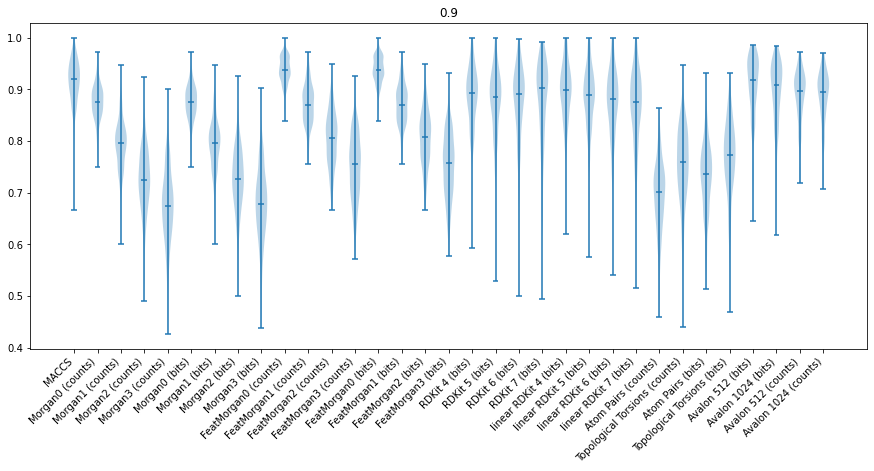

In [43]:
figsize(15,6)
fpnames = list(accum.values())[0].keys()
d = []
for nm in fpnames:
    d.append([x[nm][0.9] for x in accum.values()])
violinplot(d,showmedians=True);
xticks(rotation=45,ha='right');
xticks(range(1,len(d)+1),fpnames);
title('0.9');

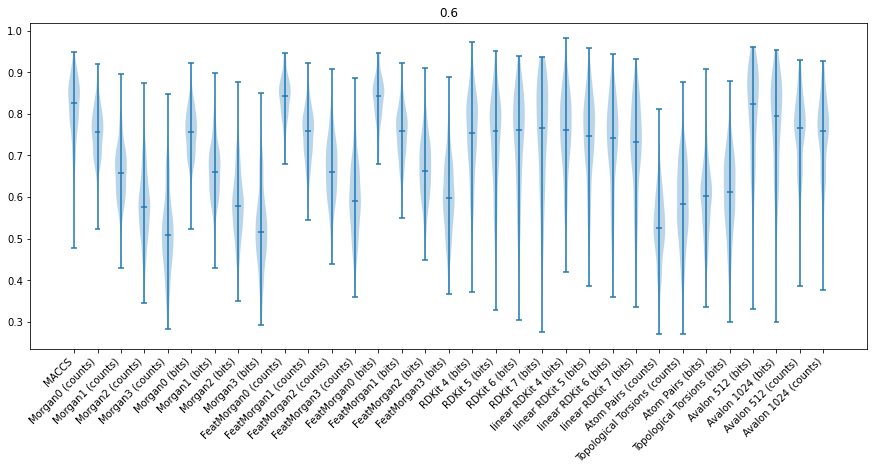

In [44]:
figsize(15,6)
fpnames = list(accum.values())[0].keys()
d = []
for nm in fpnames:
    d.append([x[nm][0.6] for x in accum.values()])
violinplot(d,showmedians=True);
xticks(rotation=45,ha='right');
xticks(range(1,len(d)+1),fpnames);
title('0.6');

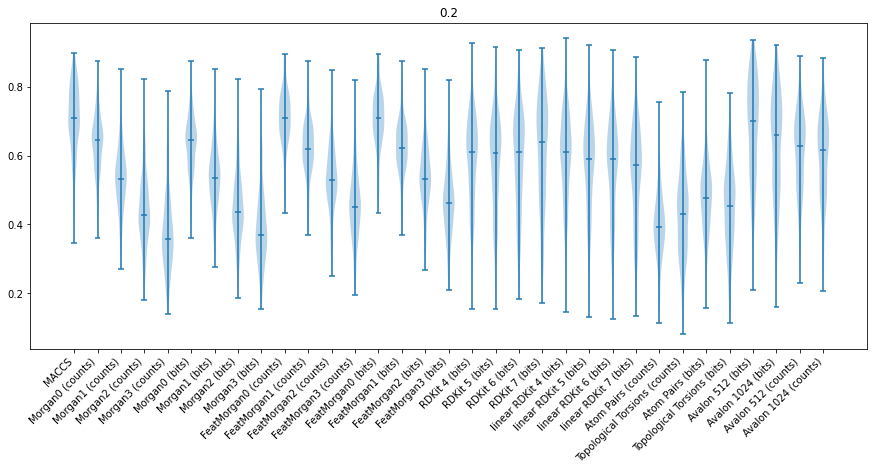

In [45]:
figsize(15,6)
fpnames = list(accum.values())[0].keys()
d = []
for nm in fpnames:
    d.append([x[nm][0.2] for x in accum.values()])
violinplot(d,showmedians=True);
xticks(rotation=45,ha='right');
xticks(range(1,len(d)+1),fpnames);
title('0.2');